In [1]:
import torch 
import torch.nn as nn 
import numpy as np 
import pandas as pd 
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import copy 
import matplotlib.pyplot as plt 
import tqdm
import ast 


In [2]:
base_dir='/Users/vayungoel/Desktop/opl/scene_maam_audioset'
base_mode='scene'
folder_name='device_maam_audioset_opl/'
b_s = 256
list_val_acc = []

In [3]:
run_mode='device'

In [4]:
data=pd.read_csv("/Users/vayungoel/Desktop/passt/final_hear21_embeddings_train_all_blocks.csv")
test_data=pd.read_csv("/Users/vayungoel/Desktop/passt/final_hear21_embeddings_test_all_blocks.csv")

In [5]:
df=pd.DataFrame()
df['file_name']=test_data['file_name']
df.head()

,file_name
0,airport-barcelona-203-6122-b.wav
1,airport-barcelona-203-6122-s1.wav
2,airport-barcelona-203-6122-s2.wav
3,airport-barcelona-203-6122-s4.wav
4,airport-barcelona-203-6122-s6.wav


In [6]:
lr=0.0001

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
acc_list=[]

In [9]:
def train_ready(data,col_name):
    new_list=[]
    for i in range(len(data)):
        temp_list=[]
        x=data[col_name][i]
        tensor_string = x

# Extract the numbers part of the string
        numbers_string = tensor_string.split("[[")[1].split("]]")[0]

# Parse the string into a Python list
        tensor_list = ast.literal_eval("[" + numbers_string + "]")

# Convert the list to a numpy array
        numpy_array = np.array(tensor_list)
        list_data=list(numpy_array)
        
        new_list.append(list_data)
    return new_list

In [10]:
number_of_classes=len(list(np.unique(np.array(data[run_mode]))))
number_of_classes

6

In [11]:
class SceneClassifier(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(SceneClassifier, self).__init__()
    # self.fc1 = nn.Linear(input_dim, int(input_dim/2))  # Hidden layer with half the input dimension
    self.fc2 = nn.Linear(input_dim, 256)        # New hidden layer with 128 neurons
    self.fc3 = nn.Linear(256, output_dim)           # Output layer

  def forward(self, x):
    # x = F.relu(self.fc1(x))  # Apply activation function (ReLU) to first hidden layer output
    emb = F.relu(self.fc2(x))  # Apply activation function (ReLU) to new hidden layer output
    logits = F.log_softmax(self.fc3(emb), dim=1)  # Apply log_softmax for classification
    return logits

input_dim = 768
output_dim = number_of_classes
model = SceneClassifier(input_dim, output_dim).to(device)
# model.to(torch.float32)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)
model.eval()

198406


SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
)

In [12]:
y=data[run_mode].tolist()
print(y)
label_array_train = np.array(y).reshape(-1, 1)
encoder=OneHotEncoder()
y_one_hot_encoded = encoder.fit_transform(label_array_train).toarray()
# print(len(y_one_hot_encoded))
y_one_hot_encoded

['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'a', 's2', 'a', 'a', 'a', 'a', 'a', 'a', 's1', 'a', 's3', 'a', 'a', 'a', 'a', 's2', 'a', 'a', 's3', 'a', 'a', 'a', 'c', 's1', 'a', 'a', 's1', 'a', 'a', 'a', 's2', 'a', 'a', 'a', 'c', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 's2', 'a', 'a', 'a', 'a', 'b', 'a', 'a', 'a', 'a', 's2', 'a', 'a', 'b', 's1', 'a', 'a', 'a', 'a', 'b', 'a', 'b', 's3', 'a', 'a', 'a', 'a', 'c', 'a', 's3', 'a', 'a', 'a', 'a', 'c', 'a', 'a', 'a', 's2', 's3', 'a', 's1', 'a', 's2', 'a', 'a', 'a', 'a', 'a', 'b', 'a', 'a', 'a', 'a', 's1', 'a', 's2', 'a', 'a', 's3', 'a', 'c', 'a', 's3', 'a', 'a', 'a', 'a', 'a', 's1', 'a', 'b', 'c', 's1', 'a', 'a', 'a', 'a', 'a', 's3', 'a', 'a', 'a', 'c', 's1', 'a', 'a', 'a', 'a', 'a', 'a', 's2', 'a', 's3', 'a', 'a', 's2', 'a', 'a', 's3', 'a', 'a', 'a', 'a', 's3', 'a', 'a', 'a', 'a', 's1', 'a', 'a', 'a', 'a', 'a', 'c', 'a', 'a', 'a', 'a', 'a', 'a', 'a'

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

In [13]:
from collections import Counter
labels = np.argmax(y_one_hot_encoded, axis=1)

# Calculate class frequencies
class_counts = Counter(labels)
total_samples = sum(class_counts.values())

# Calculate class weights as inverse of class frequencies
class_weights = {cls: total_samples / (class_counts[cls] * len(class_counts)) for cls in range(len(class_counts))}
weights_array = np.array(list(class_weights.values()), dtype=np.float32)

In [14]:
y_test=test_data[run_mode].tolist()
label_array_test=np.array(y_test).reshape(-1,1)
encoder=OneHotEncoder()
y_test_one_hot_encoded = encoder.fit_transform(label_array_test).toarray()
y_test_one_hot_encoded

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [15]:
class_names = list(np.unique(y_test))

# Block-1

In [16]:
Block_number=1

In [17]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth',map_location=torch.device('cpu'))
new_fc3 = nn.Linear(256, 6)

# Replace the existing fc3 layer with the new one
model.fc3 = new_fc3

In [18]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [19]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [20]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [21]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 6)
(2793, 6)


In [22]:
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

198406


In [23]:
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
num_params_last_layer

1542

In [24]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [25]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)

In [26]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 1542


In [27]:
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(weights_array))
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Epoch 0: 100%|██████████| 43/43 [00:00<00:00, 317.16batch/s, acc=0.0469, loss=2.13]


Epoch 0 validation: Cross-entropy=2.07, Accuracy=5.6%


Epoch 1: 100%|██████████| 43/43 [00:00<00:00, 484.82batch/s, acc=0.227, loss=1.84] 


Epoch 1 validation: Cross-entropy=1.82, Accuracy=22.1%


Epoch 2: 100%|██████████| 43/43 [00:00<00:00, 358.40batch/s, acc=0.242, loss=1.8] 


Epoch 2 validation: Cross-entropy=1.79, Accuracy=23.1%


Epoch 3: 100%|██████████| 43/43 [00:00<00:00, 579.63batch/s, acc=0.242, loss=1.79]


Epoch 3 validation: Cross-entropy=1.78, Accuracy=22.4%


Epoch 4: 100%|██████████| 43/43 [00:00<00:00, 358.63batch/s, acc=0.25, loss=1.78] 


Epoch 4 validation: Cross-entropy=1.77, Accuracy=22.4%


Epoch 5: 100%|██████████| 43/43 [00:00<00:00, 327.09batch/s, acc=0.254, loss=1.78]


Epoch 5 validation: Cross-entropy=1.77, Accuracy=22.6%


Epoch 6: 100%|██████████| 43/43 [00:00<00:00, 437.30batch/s, acc=0.258, loss=1.77]


Epoch 6 validation: Cross-entropy=1.76, Accuracy=22.6%


Epoch 7: 100%|██████████| 43/43 [00:00<00:00, 364.83batch/s, acc=0.273, loss=1.76]


Epoch 7 validation: Cross-entropy=1.76, Accuracy=22.4%


Epoch 8: 100%|██████████| 43/43 [00:00<00:00, 378.05batch/s, acc=0.273, loss=1.76]


Epoch 8 validation: Cross-entropy=1.75, Accuracy=22.7%


Epoch 9: 100%|██████████| 43/43 [00:00<00:00, 513.31batch/s, acc=0.273, loss=1.75]


Epoch 9 validation: Cross-entropy=1.75, Accuracy=23.2%


Epoch 10: 100%|██████████| 43/43 [00:00<00:00, 398.10batch/s, acc=0.266, loss=1.74]


Epoch 10 validation: Cross-entropy=1.74, Accuracy=22.9%


Epoch 11: 100%|██████████| 43/43 [00:00<00:00, 361.78batch/s, acc=0.262, loss=1.74]


Epoch 11 validation: Cross-entropy=1.74, Accuracy=22.0%


Epoch 12: 100%|██████████| 43/43 [00:00<00:00, 380.11batch/s, acc=0.25, loss=1.73] 


Epoch 12 validation: Cross-entropy=1.73, Accuracy=22.1%


Epoch 13: 100%|██████████| 43/43 [00:00<00:00, 440.11batch/s, acc=0.242, loss=1.72]


Epoch 13 validation: Cross-entropy=1.73, Accuracy=20.9%


Epoch 14: 100%|██████████| 43/43 [00:00<00:00, 333.28batch/s, acc=0.238, loss=1.72]


Epoch 14 validation: Cross-entropy=1.73, Accuracy=20.2%


Epoch 15: 100%|██████████| 43/43 [00:00<00:00, 345.73batch/s, acc=0.223, loss=1.71]


Epoch 15 validation: Cross-entropy=1.72, Accuracy=19.4%


Epoch 16: 100%|██████████| 43/43 [00:00<00:00, 343.82batch/s, acc=0.219, loss=1.71]


Epoch 16 validation: Cross-entropy=1.72, Accuracy=19.0%


Epoch 17: 100%|██████████| 43/43 [00:00<00:00, 352.12batch/s, acc=0.199, loss=1.7]  


Epoch 17 validation: Cross-entropy=1.71, Accuracy=18.8%


Epoch 18: 100%|██████████| 43/43 [00:00<00:00, 334.32batch/s, acc=0.199, loss=1.7] 


Epoch 18 validation: Cross-entropy=1.71, Accuracy=18.3%


Epoch 19: 100%|██████████| 43/43 [00:00<00:00, 338.80batch/s, acc=0.195, loss=1.69]


Epoch 19 validation: Cross-entropy=1.71, Accuracy=17.8%


Epoch 20: 100%|██████████| 43/43 [00:00<00:00, 382.05batch/s, acc=0.184, loss=1.68]


Epoch 20 validation: Cross-entropy=1.70, Accuracy=17.8%


Epoch 21: 100%|██████████| 43/43 [00:00<00:00, 420.54batch/s, acc=0.184, loss=1.68]


Epoch 21 validation: Cross-entropy=1.70, Accuracy=17.5%


Epoch 22: 100%|██████████| 43/43 [00:00<00:00, 456.21batch/s, acc=0.18, loss=1.67] 


Epoch 22 validation: Cross-entropy=1.69, Accuracy=17.5%


Epoch 23: 100%|██████████| 43/43 [00:00<00:00, 388.34batch/s, acc=0.176, loss=1.67]


Epoch 23 validation: Cross-entropy=1.69, Accuracy=17.5%


Epoch 24: 100%|██████████| 43/43 [00:00<00:00, 282.72batch/s, acc=0.188, loss=1.66]


Epoch 24 validation: Cross-entropy=1.69, Accuracy=17.3%


Epoch 25: 100%|██████████| 43/43 [00:00<00:00, 340.93batch/s, acc=0.188, loss=1.66]


Epoch 25 validation: Cross-entropy=1.68, Accuracy=17.3%


Epoch 26: 100%|██████████| 43/43 [00:00<00:00, 335.24batch/s, acc=0.188, loss=1.65]


Epoch 26 validation: Cross-entropy=1.68, Accuracy=17.7%


Epoch 27: 100%|██████████| 43/43 [00:00<00:00, 352.52batch/s, acc=0.188, loss=1.65]


Epoch 27 validation: Cross-entropy=1.68, Accuracy=17.8%


Epoch 28: 100%|██████████| 43/43 [00:00<00:00, 365.08batch/s, acc=0.188, loss=1.65]


Epoch 28 validation: Cross-entropy=1.68, Accuracy=17.9%


Epoch 29: 100%|██████████| 43/43 [00:00<00:00, 365.20batch/s, acc=0.191, loss=1.64]


Epoch 29 validation: Cross-entropy=1.67, Accuracy=18.0%


Epoch 30: 100%|██████████| 43/43 [00:00<00:00, 348.02batch/s, acc=0.195, loss=1.64]


Epoch 30 validation: Cross-entropy=1.67, Accuracy=18.4%


Epoch 31: 100%|██████████| 43/43 [00:00<00:00, 516.50batch/s, acc=0.195, loss=1.63]


Epoch 31 validation: Cross-entropy=1.67, Accuracy=18.7%


Epoch 32: 100%|██████████| 43/43 [00:00<00:00, 348.00batch/s, acc=0.203, loss=1.63]


Epoch 32 validation: Cross-entropy=1.66, Accuracy=18.9%


Epoch 33: 100%|██████████| 43/43 [00:00<00:00, 330.12batch/s, acc=0.203, loss=1.62]


Epoch 33 validation: Cross-entropy=1.66, Accuracy=18.9%


Epoch 34: 100%|██████████| 43/43 [00:00<00:00, 276.19batch/s, acc=0.207, loss=1.62]


Epoch 34 validation: Cross-entropy=1.66, Accuracy=19.2%


Epoch 35: 100%|██████████| 43/43 [00:00<00:00, 324.80batch/s, acc=0.203, loss=1.62]


Epoch 35 validation: Cross-entropy=1.66, Accuracy=19.3%


Epoch 36: 100%|██████████| 43/43 [00:00<00:00, 333.67batch/s, acc=0.203, loss=1.61]


Epoch 36 validation: Cross-entropy=1.65, Accuracy=19.4%


Epoch 37: 100%|██████████| 43/43 [00:00<00:00, 375.61batch/s, acc=0.199, loss=1.61]


Epoch 37 validation: Cross-entropy=1.65, Accuracy=19.7%


Epoch 38: 100%|██████████| 43/43 [00:00<00:00, 290.88batch/s, acc=0.195, loss=1.6] 


Epoch 38 validation: Cross-entropy=1.65, Accuracy=19.8%


Epoch 39: 100%|██████████| 43/43 [00:00<00:00, 473.08batch/s, acc=0.195, loss=1.6] 


Epoch 39 validation: Cross-entropy=1.64, Accuracy=19.8%


Epoch 40: 100%|██████████| 43/43 [00:00<00:00, 274.11batch/s, acc=0.199, loss=1.6] 


Epoch 40 validation: Cross-entropy=1.64, Accuracy=20.0%


Epoch 41: 100%|██████████| 43/43 [00:00<00:00, 324.19batch/s, acc=0.203, loss=1.59]


Epoch 41 validation: Cross-entropy=1.64, Accuracy=20.0%


Epoch 42: 100%|██████████| 43/43 [00:00<00:00, 436.91batch/s, acc=0.203, loss=1.59]


Epoch 42 validation: Cross-entropy=1.64, Accuracy=20.3%


Epoch 43: 100%|██████████| 43/43 [00:00<00:00, 341.10batch/s, acc=0.199, loss=1.59]


Epoch 43 validation: Cross-entropy=1.64, Accuracy=20.4%


Epoch 44: 100%|██████████| 43/43 [00:00<00:00, 236.72batch/s, acc=0.199, loss=1.58]


Epoch 44 validation: Cross-entropy=1.63, Accuracy=20.4%


Epoch 45: 100%|██████████| 43/43 [00:00<00:00, 468.47batch/s, acc=0.199, loss=1.58]


Epoch 45 validation: Cross-entropy=1.63, Accuracy=20.7%


Epoch 46: 100%|██████████| 43/43 [00:00<00:00, 520.57batch/s, acc=0.203, loss=1.58]


Epoch 46 validation: Cross-entropy=1.63, Accuracy=20.9%


Epoch 47: 100%|██████████| 43/43 [00:00<00:00, 262.44batch/s, acc=0.207, loss=1.57]


Epoch 47 validation: Cross-entropy=1.63, Accuracy=21.1%


Epoch 48: 100%|██████████| 43/43 [00:00<00:00, 459.29batch/s, acc=0.207, loss=1.57]


Epoch 48 validation: Cross-entropy=1.62, Accuracy=21.3%


Epoch 49: 100%|██████████| 43/43 [00:00<00:00, 494.48batch/s, acc=0.207, loss=1.57]


Epoch 49 validation: Cross-entropy=1.62, Accuracy=21.4%


Epoch 50: 100%|██████████| 43/43 [00:00<00:00, 256.74batch/s, acc=0.207, loss=1.56]


Epoch 50 validation: Cross-entropy=1.62, Accuracy=21.6%


Epoch 51: 100%|██████████| 43/43 [00:00<00:00, 429.19batch/s, acc=0.207, loss=1.56]


Epoch 51 validation: Cross-entropy=1.62, Accuracy=21.6%


Epoch 52: 100%|██████████| 43/43 [00:00<00:00, 217.14batch/s, acc=0.207, loss=1.56]


Epoch 52 validation: Cross-entropy=1.62, Accuracy=21.9%


Epoch 53: 100%|██████████| 43/43 [00:00<00:00, 450.31batch/s, acc=0.215, loss=1.55]


Epoch 53 validation: Cross-entropy=1.61, Accuracy=22.2%


Epoch 54: 100%|██████████| 43/43 [00:00<00:00, 298.75batch/s, acc=0.223, loss=1.55]


Epoch 54 validation: Cross-entropy=1.61, Accuracy=22.3%


Epoch 55: 100%|██████████| 43/43 [00:00<00:00, 568.60batch/s, acc=0.227, loss=1.55]


Epoch 55 validation: Cross-entropy=1.61, Accuracy=22.4%


Epoch 56: 100%|██████████| 43/43 [00:00<00:00, 291.73batch/s, acc=0.234, loss=1.55]


Epoch 56 validation: Cross-entropy=1.61, Accuracy=22.7%


Epoch 57: 100%|██████████| 43/43 [00:00<00:00, 443.29batch/s, acc=0.234, loss=1.54]


Epoch 57 validation: Cross-entropy=1.61, Accuracy=22.8%


Epoch 58: 100%|██████████| 43/43 [00:00<00:00, 460.48batch/s, acc=0.242, loss=1.54]


Epoch 58 validation: Cross-entropy=1.60, Accuracy=22.9%


Epoch 59: 100%|██████████| 43/43 [00:00<00:00, 384.42batch/s, acc=0.242, loss=1.54]


Epoch 59 validation: Cross-entropy=1.60, Accuracy=23.0%


Epoch 60: 100%|██████████| 43/43 [00:00<00:00, 491.60batch/s, acc=0.246, loss=1.54]


Epoch 60 validation: Cross-entropy=1.60, Accuracy=23.0%


Epoch 61: 100%|██████████| 43/43 [00:00<00:00, 345.78batch/s, acc=0.246, loss=1.53]


Epoch 61 validation: Cross-entropy=1.60, Accuracy=23.1%


Epoch 62: 100%|██████████| 43/43 [00:00<00:00, 264.00batch/s, acc=0.25, loss=1.53] 


Epoch 62 validation: Cross-entropy=1.60, Accuracy=23.2%


Epoch 63: 100%|██████████| 43/43 [00:00<00:00, 553.44batch/s, acc=0.246, loss=1.53]


Epoch 63 validation: Cross-entropy=1.60, Accuracy=23.6%


Epoch 64: 100%|██████████| 43/43 [00:00<00:00, 410.98batch/s, acc=0.246, loss=1.52]


Epoch 64 validation: Cross-entropy=1.59, Accuracy=23.8%


Epoch 65: 100%|██████████| 43/43 [00:00<00:00, 366.15batch/s, acc=0.246, loss=1.52]


Epoch 65 validation: Cross-entropy=1.59, Accuracy=24.0%


Epoch 66: 100%|██████████| 43/43 [00:00<00:00, 367.54batch/s, acc=0.25, loss=1.52] 


Epoch 66 validation: Cross-entropy=1.59, Accuracy=24.0%


Epoch 67: 100%|██████████| 43/43 [00:00<00:00, 406.14batch/s, acc=0.246, loss=1.52]


Epoch 67 validation: Cross-entropy=1.59, Accuracy=24.3%


Epoch 68: 100%|██████████| 43/43 [00:00<00:00, 481.75batch/s, acc=0.246, loss=1.52]


Epoch 68 validation: Cross-entropy=1.59, Accuracy=24.4%


Epoch 69: 100%|██████████| 43/43 [00:00<00:00, 359.82batch/s, acc=0.246, loss=1.51]


Epoch 69 validation: Cross-entropy=1.59, Accuracy=24.5%


Epoch 70: 100%|██████████| 43/43 [00:00<00:00, 339.24batch/s, acc=0.242, loss=1.51]


Epoch 70 validation: Cross-entropy=1.58, Accuracy=24.6%


Epoch 71: 100%|██████████| 43/43 [00:00<00:00, 282.06batch/s, acc=0.242, loss=1.51]


Epoch 71 validation: Cross-entropy=1.58, Accuracy=24.8%


Epoch 72: 100%|██████████| 43/43 [00:00<00:00, 311.81batch/s, acc=0.242, loss=1.51]


Epoch 72 validation: Cross-entropy=1.58, Accuracy=25.0%


Epoch 73: 100%|██████████| 43/43 [00:00<00:00, 343.78batch/s, acc=0.238, loss=1.5] 


Epoch 73 validation: Cross-entropy=1.58, Accuracy=24.9%


Epoch 74: 100%|██████████| 43/43 [00:00<00:00, 347.58batch/s, acc=0.238, loss=1.5] 


Epoch 74 validation: Cross-entropy=1.58, Accuracy=25.1%


Epoch 75: 100%|██████████| 43/43 [00:00<00:00, 346.20batch/s, acc=0.242, loss=1.5] 


Epoch 75 validation: Cross-entropy=1.58, Accuracy=25.1%


Epoch 76: 100%|██████████| 43/43 [00:00<00:00, 373.12batch/s, acc=0.242, loss=1.5] 


Epoch 76 validation: Cross-entropy=1.58, Accuracy=25.3%


Epoch 77: 100%|██████████| 43/43 [00:00<00:00, 542.59batch/s, acc=0.242, loss=1.49]


Epoch 77 validation: Cross-entropy=1.57, Accuracy=25.3%


Epoch 78: 100%|██████████| 43/43 [00:00<00:00, 305.77batch/s, acc=0.242, loss=1.49]


Epoch 78 validation: Cross-entropy=1.57, Accuracy=25.5%


Epoch 79: 100%|██████████| 43/43 [00:00<00:00, 319.78batch/s, acc=0.246, loss=1.49]


Epoch 79 validation: Cross-entropy=1.57, Accuracy=25.7%


Epoch 80: 100%|██████████| 43/43 [00:00<00:00, 309.64batch/s, acc=0.25, loss=1.49] 


Epoch 80 validation: Cross-entropy=1.57, Accuracy=25.8%


Epoch 81: 100%|██████████| 43/43 [00:00<00:00, 356.70batch/s, acc=0.25, loss=1.49] 


Epoch 81 validation: Cross-entropy=1.57, Accuracy=26.1%


Epoch 82: 100%|██████████| 43/43 [00:00<00:00, 399.47batch/s, acc=0.25, loss=1.48] 


Epoch 82 validation: Cross-entropy=1.57, Accuracy=26.2%


Epoch 83: 100%|██████████| 43/43 [00:00<00:00, 396.10batch/s, acc=0.25, loss=1.48] 


Epoch 83 validation: Cross-entropy=1.57, Accuracy=26.4%


Epoch 84: 100%|██████████| 43/43 [00:00<00:00, 355.42batch/s, acc=0.25, loss=1.48] 


Epoch 84 validation: Cross-entropy=1.56, Accuracy=26.5%


Epoch 85: 100%|██████████| 43/43 [00:00<00:00, 373.16batch/s, acc=0.25, loss=1.48] 


Epoch 85 validation: Cross-entropy=1.56, Accuracy=26.8%


Epoch 86: 100%|██████████| 43/43 [00:00<00:00, 516.20batch/s, acc=0.25, loss=1.48] 


Epoch 86 validation: Cross-entropy=1.56, Accuracy=27.1%


Epoch 87: 100%|██████████| 43/43 [00:00<00:00, 340.57batch/s, acc=0.25, loss=1.47] 


Epoch 87 validation: Cross-entropy=1.56, Accuracy=27.5%


Epoch 88: 100%|██████████| 43/43 [00:00<00:00, 354.90batch/s, acc=0.254, loss=1.47]


Epoch 88 validation: Cross-entropy=1.56, Accuracy=27.6%


Epoch 89: 100%|██████████| 43/43 [00:00<00:00, 372.71batch/s, acc=0.258, loss=1.47]


Epoch 89 validation: Cross-entropy=1.56, Accuracy=27.7%


Epoch 90: 100%|██████████| 43/43 [00:00<00:00, 371.35batch/s, acc=0.258, loss=1.47]


Epoch 90 validation: Cross-entropy=1.56, Accuracy=27.9%


Epoch 91: 100%|██████████| 43/43 [00:00<00:00, 394.09batch/s, acc=0.258, loss=1.47]


Epoch 91 validation: Cross-entropy=1.56, Accuracy=28.2%


Epoch 92: 100%|██████████| 43/43 [00:00<00:00, 282.37batch/s, acc=0.258, loss=1.47]


Epoch 92 validation: Cross-entropy=1.55, Accuracy=28.4%


Epoch 93: 100%|██████████| 43/43 [00:00<00:00, 456.17batch/s, acc=0.262, loss=1.46]


Epoch 93 validation: Cross-entropy=1.55, Accuracy=28.7%


Epoch 94: 100%|██████████| 43/43 [00:00<00:00, 357.09batch/s, acc=0.266, loss=1.46]


Epoch 94 validation: Cross-entropy=1.55, Accuracy=28.9%


Epoch 95: 100%|██████████| 43/43 [00:00<00:00, 351.62batch/s, acc=0.27, loss=1.46] 


Epoch 95 validation: Cross-entropy=1.55, Accuracy=29.0%


Epoch 96: 100%|██████████| 43/43 [00:00<00:00, 349.86batch/s, acc=0.27, loss=1.46] 


Epoch 96 validation: Cross-entropy=1.55, Accuracy=29.3%


Epoch 97: 100%|██████████| 43/43 [00:00<00:00, 360.00batch/s, acc=0.281, loss=1.46]


Epoch 97 validation: Cross-entropy=1.55, Accuracy=29.4%


Epoch 98: 100%|██████████| 43/43 [00:00<00:00, 371.94batch/s, acc=0.281, loss=1.46]


Epoch 98 validation: Cross-entropy=1.55, Accuracy=29.5%


Epoch 99: 100%|██████████| 43/43 [00:00<00:00, 374.56batch/s, acc=0.281, loss=1.45]


Epoch 99 validation: Cross-entropy=1.55, Accuracy=29.8%


Epoch 100: 100%|██████████| 43/43 [00:00<00:00, 392.72batch/s, acc=0.285, loss=1.45]


Epoch 100 validation: Cross-entropy=1.54, Accuracy=30.0%


Epoch 101: 100%|██████████| 43/43 [00:00<00:00, 433.04batch/s, acc=0.289, loss=1.45]


Epoch 101 validation: Cross-entropy=1.54, Accuracy=30.3%


Epoch 102: 100%|██████████| 43/43 [00:00<00:00, 287.24batch/s, acc=0.289, loss=1.45]


Epoch 102 validation: Cross-entropy=1.54, Accuracy=30.4%


Epoch 103: 100%|██████████| 43/43 [00:00<00:00, 319.62batch/s, acc=0.293, loss=1.45]


Epoch 103 validation: Cross-entropy=1.54, Accuracy=30.6%


Epoch 104: 100%|██████████| 43/43 [00:00<00:00, 403.57batch/s, acc=0.293, loss=1.45]


Epoch 104 validation: Cross-entropy=1.54, Accuracy=30.8%


Epoch 105: 100%|██████████| 43/43 [00:00<00:00, 348.73batch/s, acc=0.293, loss=1.44]


Epoch 105 validation: Cross-entropy=1.54, Accuracy=31.0%


Epoch 106: 100%|██████████| 43/43 [00:00<00:00, 351.64batch/s, acc=0.305, loss=1.44]


Epoch 106 validation: Cross-entropy=1.54, Accuracy=31.3%


Epoch 107: 100%|██████████| 43/43 [00:00<00:00, 351.92batch/s, acc=0.305, loss=1.44]


Epoch 107 validation: Cross-entropy=1.54, Accuracy=31.4%


Epoch 108: 100%|██████████| 43/43 [00:00<00:00, 370.72batch/s, acc=0.305, loss=1.44]


Epoch 108 validation: Cross-entropy=1.54, Accuracy=31.7%


Epoch 109: 100%|██████████| 43/43 [00:00<00:00, 414.68batch/s, acc=0.305, loss=1.44]


Epoch 109 validation: Cross-entropy=1.54, Accuracy=31.8%


Epoch 110: 100%|██████████| 43/43 [00:00<00:00, 473.21batch/s, acc=0.309, loss=1.44]


Epoch 110 validation: Cross-entropy=1.53, Accuracy=32.0%


Epoch 111: 100%|██████████| 43/43 [00:00<00:00, 357.08batch/s, acc=0.309, loss=1.43]


Epoch 111 validation: Cross-entropy=1.53, Accuracy=32.1%


Epoch 112: 100%|██████████| 43/43 [00:00<00:00, 267.34batch/s, acc=0.309, loss=1.43]


Epoch 112 validation: Cross-entropy=1.53, Accuracy=32.2%


Epoch 113: 100%|██████████| 43/43 [00:00<00:00, 312.93batch/s, acc=0.309, loss=1.43]


Epoch 113 validation: Cross-entropy=1.53, Accuracy=32.4%


Epoch 114: 100%|██████████| 43/43 [00:00<00:00, 338.81batch/s, acc=0.309, loss=1.43]


Epoch 114 validation: Cross-entropy=1.53, Accuracy=32.6%


Epoch 115: 100%|██████████| 43/43 [00:00<00:00, 339.59batch/s, acc=0.309, loss=1.43]


Epoch 115 validation: Cross-entropy=1.53, Accuracy=32.8%


Epoch 116: 100%|██████████| 43/43 [00:00<00:00, 320.24batch/s, acc=0.309, loss=1.43]


Epoch 116 validation: Cross-entropy=1.53, Accuracy=32.9%


Epoch 117: 100%|██████████| 43/43 [00:00<00:00, 319.33batch/s, acc=0.312, loss=1.43]


Epoch 117 validation: Cross-entropy=1.53, Accuracy=33.1%


Epoch 118: 100%|██████████| 43/43 [00:00<00:00, 335.28batch/s, acc=0.312, loss=1.42]


Epoch 118 validation: Cross-entropy=1.53, Accuracy=33.4%


Epoch 119: 100%|██████████| 43/43 [00:00<00:00, 368.12batch/s, acc=0.316, loss=1.42]


Epoch 119 validation: Cross-entropy=1.52, Accuracy=33.7%


Epoch 120: 100%|██████████| 43/43 [00:00<00:00, 344.52batch/s, acc=0.316, loss=1.42]


Epoch 120 validation: Cross-entropy=1.52, Accuracy=33.9%


Epoch 121: 100%|██████████| 43/43 [00:00<00:00, 510.06batch/s, acc=0.316, loss=1.42]


Epoch 121 validation: Cross-entropy=1.52, Accuracy=33.9%


Epoch 122: 100%|██████████| 43/43 [00:00<00:00, 531.51batch/s, acc=0.316, loss=1.42]


Epoch 122 validation: Cross-entropy=1.52, Accuracy=34.1%


Epoch 123: 100%|██████████| 43/43 [00:00<00:00, 161.37batch/s, acc=0.316, loss=1.42]


Epoch 123 validation: Cross-entropy=1.52, Accuracy=34.2%


Epoch 124: 100%|██████████| 43/43 [00:00<00:00, 300.43batch/s, acc=0.316, loss=1.42]


Epoch 124 validation: Cross-entropy=1.52, Accuracy=34.2%


Epoch 125: 100%|██████████| 43/43 [00:00<00:00, 512.85batch/s, acc=0.32, loss=1.42] 


Epoch 125 validation: Cross-entropy=1.52, Accuracy=34.4%


Epoch 126: 100%|██████████| 43/43 [00:00<00:00, 264.84batch/s, acc=0.32, loss=1.41] 


Epoch 126 validation: Cross-entropy=1.52, Accuracy=34.6%


Epoch 127: 100%|██████████| 43/43 [00:00<00:00, 344.08batch/s, acc=0.32, loss=1.41] 


Epoch 127 validation: Cross-entropy=1.52, Accuracy=34.6%


Epoch 128: 100%|██████████| 43/43 [00:00<00:00, 261.42batch/s, acc=0.32, loss=1.41] 


Epoch 128 validation: Cross-entropy=1.52, Accuracy=34.9%


Epoch 129: 100%|██████████| 43/43 [00:00<00:00, 359.78batch/s, acc=0.324, loss=1.41]


Epoch 129 validation: Cross-entropy=1.52, Accuracy=34.9%


Epoch 130: 100%|██████████| 43/43 [00:00<00:00, 460.66batch/s, acc=0.324, loss=1.41]


Epoch 130 validation: Cross-entropy=1.51, Accuracy=34.9%


Epoch 131: 100%|██████████| 43/43 [00:00<00:00, 263.72batch/s, acc=0.324, loss=1.41]


Epoch 131 validation: Cross-entropy=1.51, Accuracy=35.1%


Epoch 132: 100%|██████████| 43/43 [00:00<00:00, 528.74batch/s, acc=0.328, loss=1.41]


Epoch 132 validation: Cross-entropy=1.51, Accuracy=35.3%


Epoch 133: 100%|██████████| 43/43 [00:00<00:00, 324.84batch/s, acc=0.328, loss=1.41]


Epoch 133 validation: Cross-entropy=1.51, Accuracy=35.4%


Epoch 134: 100%|██████████| 43/43 [00:00<00:00, 449.93batch/s, acc=0.328, loss=1.4] 


Epoch 134 validation: Cross-entropy=1.51, Accuracy=35.6%


Epoch 135: 100%|██████████| 43/43 [00:00<00:00, 312.10batch/s, acc=0.328, loss=1.4] 


Epoch 135 validation: Cross-entropy=1.51, Accuracy=35.8%


Epoch 136: 100%|██████████| 43/43 [00:00<00:00, 523.93batch/s, acc=0.328, loss=1.4] 


Epoch 136 validation: Cross-entropy=1.51, Accuracy=35.9%


Epoch 137: 100%|██████████| 43/43 [00:00<00:00, 376.90batch/s, acc=0.328, loss=1.4] 


Epoch 137 validation: Cross-entropy=1.51, Accuracy=36.1%


Epoch 138: 100%|██████████| 43/43 [00:00<00:00, 442.29batch/s, acc=0.332, loss=1.4] 


Epoch 138 validation: Cross-entropy=1.51, Accuracy=36.2%


Epoch 139: 100%|██████████| 43/43 [00:00<00:00, 479.19batch/s, acc=0.332, loss=1.4] 


Epoch 139 validation: Cross-entropy=1.51, Accuracy=36.3%


Epoch 140: 100%|██████████| 43/43 [00:00<00:00, 501.14batch/s, acc=0.332, loss=1.4] 


Epoch 140 validation: Cross-entropy=1.51, Accuracy=36.5%


Epoch 141: 100%|██████████| 43/43 [00:00<00:00, 543.84batch/s, acc=0.336, loss=1.4] 


Epoch 141 validation: Cross-entropy=1.51, Accuracy=36.6%


Epoch 142: 100%|██████████| 43/43 [00:00<00:00, 265.78batch/s, acc=0.336, loss=1.39]


Epoch 142 validation: Cross-entropy=1.50, Accuracy=36.7%


Epoch 143: 100%|██████████| 43/43 [00:00<00:00, 437.92batch/s, acc=0.34, loss=1.39] 


Epoch 143 validation: Cross-entropy=1.50, Accuracy=36.7%


Epoch 144: 100%|██████████| 43/43 [00:00<00:00, 296.94batch/s, acc=0.336, loss=1.39]


Epoch 144 validation: Cross-entropy=1.50, Accuracy=37.0%


Epoch 145: 100%|██████████| 43/43 [00:00<00:00, 542.05batch/s, acc=0.348, loss=1.39]


Epoch 145 validation: Cross-entropy=1.50, Accuracy=37.2%


Epoch 146: 100%|██████████| 43/43 [00:00<00:00, 515.43batch/s, acc=0.348, loss=1.39]


Epoch 146 validation: Cross-entropy=1.50, Accuracy=37.3%


Epoch 147: 100%|██████████| 43/43 [00:00<00:00, 296.03batch/s, acc=0.348, loss=1.39]


Epoch 147 validation: Cross-entropy=1.50, Accuracy=37.5%


Epoch 148: 100%|██████████| 43/43 [00:00<00:00, 441.81batch/s, acc=0.348, loss=1.39]


Epoch 148 validation: Cross-entropy=1.50, Accuracy=37.7%


Epoch 149: 100%|██████████| 43/43 [00:00<00:00, 527.19batch/s, acc=0.352, loss=1.39]


Epoch 149 validation: Cross-entropy=1.50, Accuracy=38.0%


Epoch 150: 100%|██████████| 43/43 [00:00<00:00, 321.62batch/s, acc=0.352, loss=1.39]


Epoch 150 validation: Cross-entropy=1.50, Accuracy=38.1%


Epoch 151: 100%|██████████| 43/43 [00:00<00:00, 450.27batch/s, acc=0.355, loss=1.38]


Epoch 151 validation: Cross-entropy=1.50, Accuracy=38.2%


Epoch 152: 100%|██████████| 43/43 [00:00<00:00, 510.61batch/s, acc=0.359, loss=1.38]


Epoch 152 validation: Cross-entropy=1.50, Accuracy=38.3%


Epoch 153: 100%|██████████| 43/43 [00:00<00:00, 292.65batch/s, acc=0.359, loss=1.38]


Epoch 153 validation: Cross-entropy=1.50, Accuracy=38.4%


Epoch 154: 100%|██████████| 43/43 [00:00<00:00, 526.42batch/s, acc=0.359, loss=1.38]


Epoch 154 validation: Cross-entropy=1.49, Accuracy=38.5%


Epoch 155: 100%|██████████| 43/43 [00:00<00:00, 533.15batch/s, acc=0.359, loss=1.38]


Epoch 155 validation: Cross-entropy=1.49, Accuracy=38.6%


Epoch 156: 100%|██████████| 43/43 [00:00<00:00, 317.90batch/s, acc=0.359, loss=1.38]


Epoch 156 validation: Cross-entropy=1.49, Accuracy=38.7%


Epoch 157: 100%|██████████| 43/43 [00:00<00:00, 355.28batch/s, acc=0.359, loss=1.38]


Epoch 157 validation: Cross-entropy=1.49, Accuracy=38.8%


Epoch 158: 100%|██████████| 43/43 [00:00<00:00, 249.09batch/s, acc=0.359, loss=1.38]


Epoch 158 validation: Cross-entropy=1.49, Accuracy=38.9%


Epoch 159: 100%|██████████| 43/43 [00:00<00:00, 505.91batch/s, acc=0.359, loss=1.38]


Epoch 159 validation: Cross-entropy=1.49, Accuracy=39.0%


Epoch 160: 100%|██████████| 43/43 [00:00<00:00, 277.61batch/s, acc=0.359, loss=1.38]


Epoch 160 validation: Cross-entropy=1.49, Accuracy=39.2%


Epoch 161: 100%|██████████| 43/43 [00:00<00:00, 466.59batch/s, acc=0.359, loss=1.37]


Epoch 161 validation: Cross-entropy=1.49, Accuracy=39.3%


Epoch 162: 100%|██████████| 43/43 [00:00<00:00, 262.85batch/s, acc=0.359, loss=1.37]


Epoch 162 validation: Cross-entropy=1.49, Accuracy=39.5%


Epoch 163: 100%|██████████| 43/43 [00:00<00:00, 521.59batch/s, acc=0.359, loss=1.37]


Epoch 163 validation: Cross-entropy=1.49, Accuracy=39.6%


Epoch 164: 100%|██████████| 43/43 [00:00<00:00, 280.07batch/s, acc=0.367, loss=1.37]


Epoch 164 validation: Cross-entropy=1.49, Accuracy=39.8%


Epoch 165: 100%|██████████| 43/43 [00:00<00:00, 492.33batch/s, acc=0.371, loss=1.37]


Epoch 165 validation: Cross-entropy=1.49, Accuracy=40.0%


Epoch 166: 100%|██████████| 43/43 [00:00<00:00, 290.20batch/s, acc=0.371, loss=1.37]


Epoch 166 validation: Cross-entropy=1.49, Accuracy=40.2%


Epoch 167: 100%|██████████| 43/43 [00:00<00:00, 403.53batch/s, acc=0.375, loss=1.37]


Epoch 167 validation: Cross-entropy=1.49, Accuracy=40.2%


Epoch 168: 100%|██████████| 43/43 [00:00<00:00, 486.20batch/s, acc=0.375, loss=1.37]


Epoch 168 validation: Cross-entropy=1.48, Accuracy=40.4%


Epoch 169: 100%|██████████| 43/43 [00:00<00:00, 310.50batch/s, acc=0.375, loss=1.37]


Epoch 169 validation: Cross-entropy=1.48, Accuracy=40.5%


Epoch 170: 100%|██████████| 43/43 [00:00<00:00, 458.56batch/s, acc=0.375, loss=1.37]


Epoch 170 validation: Cross-entropy=1.48, Accuracy=40.6%


Epoch 171: 100%|██████████| 43/43 [00:00<00:00, 414.09batch/s, acc=0.375, loss=1.37]


Epoch 171 validation: Cross-entropy=1.48, Accuracy=40.8%


Epoch 172: 100%|██████████| 43/43 [00:00<00:00, 378.06batch/s, acc=0.379, loss=1.36]


Epoch 172 validation: Cross-entropy=1.48, Accuracy=40.8%


Epoch 173: 100%|██████████| 43/43 [00:00<00:00, 556.22batch/s, acc=0.379, loss=1.36]


Epoch 173 validation: Cross-entropy=1.48, Accuracy=40.9%


Epoch 174: 100%|██████████| 43/43 [00:00<00:00, 310.16batch/s, acc=0.379, loss=1.36]


Epoch 174 validation: Cross-entropy=1.48, Accuracy=41.0%


Epoch 175: 100%|██████████| 43/43 [00:00<00:00, 526.08batch/s, acc=0.379, loss=1.36]


Epoch 175 validation: Cross-entropy=1.48, Accuracy=41.2%


Epoch 176: 100%|██████████| 43/43 [00:00<00:00, 528.93batch/s, acc=0.379, loss=1.36]


Epoch 176 validation: Cross-entropy=1.48, Accuracy=41.3%


Epoch 177: 100%|██████████| 43/43 [00:00<00:00, 256.53batch/s, acc=0.379, loss=1.36]


Epoch 177 validation: Cross-entropy=1.48, Accuracy=41.4%


Epoch 178: 100%|██████████| 43/43 [00:00<00:00, 440.59batch/s, acc=0.379, loss=1.36]


Epoch 178 validation: Cross-entropy=1.48, Accuracy=41.4%


Epoch 179: 100%|██████████| 43/43 [00:00<00:00, 316.71batch/s, acc=0.379, loss=1.36]


Epoch 179 validation: Cross-entropy=1.48, Accuracy=41.6%


Epoch 180: 100%|██████████| 43/43 [00:00<00:00, 487.50batch/s, acc=0.379, loss=1.36]


Epoch 180 validation: Cross-entropy=1.48, Accuracy=41.6%


Epoch 181: 100%|██████████| 43/43 [00:00<00:00, 546.61batch/s, acc=0.375, loss=1.36]


Epoch 181 validation: Cross-entropy=1.48, Accuracy=41.7%


Epoch 182: 100%|██████████| 43/43 [00:00<00:00, 271.90batch/s, acc=0.375, loss=1.36]


Epoch 182 validation: Cross-entropy=1.48, Accuracy=41.8%


Epoch 183: 100%|██████████| 43/43 [00:00<00:00, 549.68batch/s, acc=0.379, loss=1.35]


Epoch 183 validation: Cross-entropy=1.47, Accuracy=42.0%


Epoch 184: 100%|██████████| 43/43 [00:00<00:00, 329.42batch/s, acc=0.379, loss=1.35]


Epoch 184 validation: Cross-entropy=1.47, Accuracy=42.1%


Epoch 185: 100%|██████████| 43/43 [00:00<00:00, 465.23batch/s, acc=0.379, loss=1.35]


Epoch 185 validation: Cross-entropy=1.47, Accuracy=42.2%


Epoch 186: 100%|██████████| 43/43 [00:00<00:00, 529.44batch/s, acc=0.379, loss=1.35]


Epoch 186 validation: Cross-entropy=1.47, Accuracy=42.3%


Epoch 187: 100%|██████████| 43/43 [00:00<00:00, 416.87batch/s, acc=0.379, loss=1.35]


Epoch 187 validation: Cross-entropy=1.47, Accuracy=42.4%


Epoch 188: 100%|██████████| 43/43 [00:00<00:00, 276.25batch/s, acc=0.379, loss=1.35]


Epoch 188 validation: Cross-entropy=1.47, Accuracy=42.6%


Epoch 189: 100%|██████████| 43/43 [00:00<00:00, 537.84batch/s, acc=0.379, loss=1.35]


Epoch 189 validation: Cross-entropy=1.47, Accuracy=42.6%


Epoch 190: 100%|██████████| 43/43 [00:00<00:00, 328.88batch/s, acc=0.383, loss=1.35]


Epoch 190 validation: Cross-entropy=1.47, Accuracy=42.8%


Epoch 191: 100%|██████████| 43/43 [00:00<00:00, 480.42batch/s, acc=0.383, loss=1.35]


Epoch 191 validation: Cross-entropy=1.47, Accuracy=42.9%


Epoch 192: 100%|██████████| 43/43 [00:00<00:00, 268.74batch/s, acc=0.383, loss=1.35]


Epoch 192 validation: Cross-entropy=1.47, Accuracy=43.1%


Epoch 193: 100%|██████████| 43/43 [00:00<00:00, 491.30batch/s, acc=0.383, loss=1.35]


Epoch 193 validation: Cross-entropy=1.47, Accuracy=43.1%


Epoch 194: 100%|██████████| 43/43 [00:00<00:00, 477.56batch/s, acc=0.383, loss=1.35]


Epoch 194 validation: Cross-entropy=1.47, Accuracy=43.3%


Epoch 195: 100%|██████████| 43/43 [00:00<00:00, 315.38batch/s, acc=0.383, loss=1.34]


Epoch 195 validation: Cross-entropy=1.47, Accuracy=43.3%


Epoch 196: 100%|██████████| 43/43 [00:00<00:00, 472.14batch/s, acc=0.383, loss=1.34]


Epoch 196 validation: Cross-entropy=1.47, Accuracy=43.3%


Epoch 197: 100%|██████████| 43/43 [00:00<00:00, 277.22batch/s, acc=0.387, loss=1.34]


Epoch 197 validation: Cross-entropy=1.47, Accuracy=43.3%


Epoch 198: 100%|██████████| 43/43 [00:00<00:00, 466.31batch/s, acc=0.387, loss=1.34]


Epoch 198 validation: Cross-entropy=1.47, Accuracy=43.4%


Epoch 199: 100%|██████████| 43/43 [00:00<00:00, 437.00batch/s, acc=0.391, loss=1.34]


Epoch 199 validation: Cross-entropy=1.46, Accuracy=43.5%


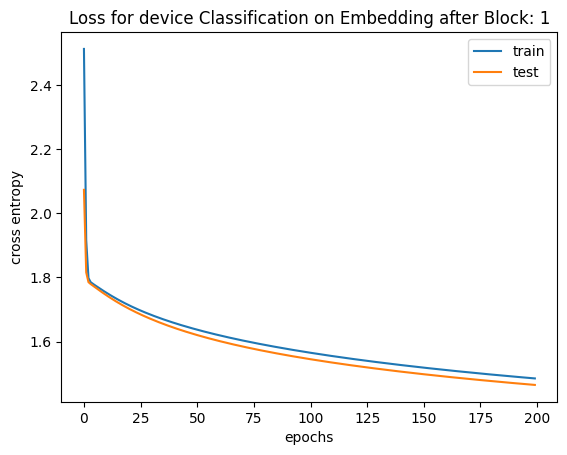

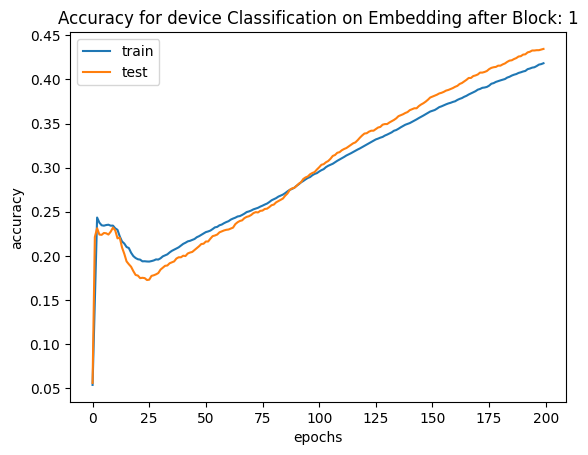

In [28]:
n_epochs = 200
batch_size = 256
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            labels = np.argmax(y_batch, axis=1)
            loss = criterion(y_pred, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if acc > best_acc:
        best_acc = acc

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)
list_val_acc.append(best_acc)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [29]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [30]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')

In [31]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
)

In [32]:
X_test=train_ready(test_data,col_name)

In [33]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

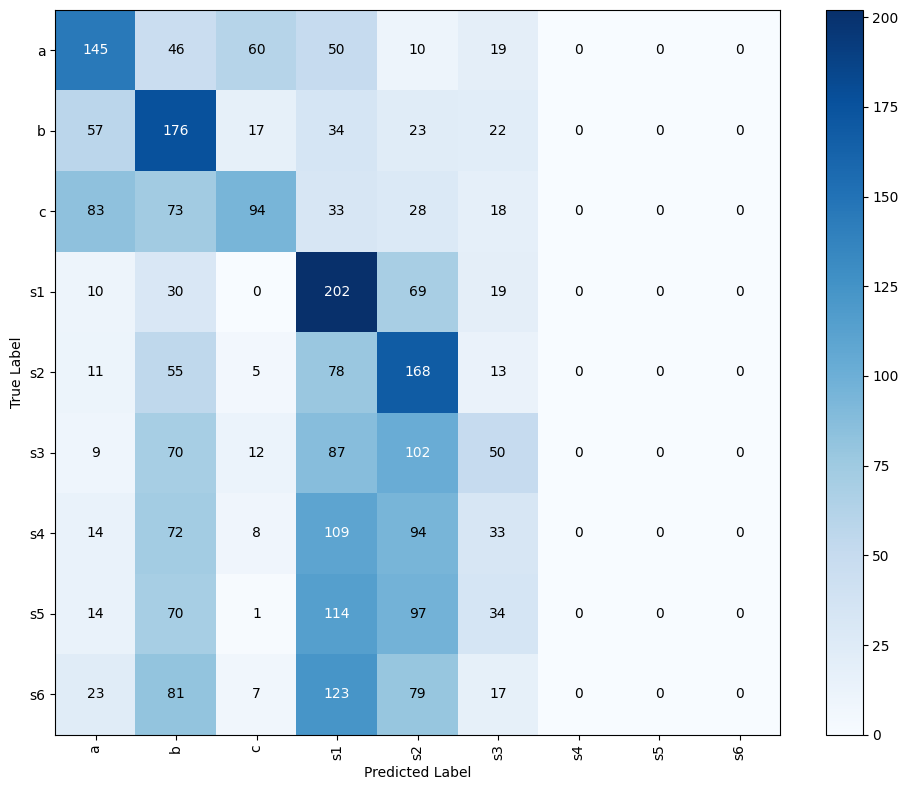

Accuracy: 0.2813


In [34]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-2

In [35]:
Block_number=2

In [36]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth',map_location=torch.device('cpu'))
new_fc3 = nn.Linear(256, 6)

# Replace the existing fc3 layer with the new one
model.fc3 = new_fc3

In [37]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [38]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [39]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [40]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 6)
(2793, 6)


In [41]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 198406
Number of parameters in the last layer is 1542


In [42]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [43]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)

In [44]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 1542


In [45]:
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(weights_array))
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Epoch 0: 100%|██████████| 43/43 [00:00<00:00, 541.25batch/s, acc=0.0391, loss=3.49]


Epoch 0 validation: Cross-entropy=3.35, Accuracy=5.4%


Epoch 1: 100%|██████████| 43/43 [00:00<00:00, 318.88batch/s, acc=0.0508, loss=2.76]


Epoch 1 validation: Cross-entropy=2.67, Accuracy=5.3%


Epoch 2: 100%|██████████| 43/43 [00:00<00:00, 555.12batch/s, acc=0.043, loss=2.27] 


Epoch 2 validation: Cross-entropy=2.24, Accuracy=5.9%


Epoch 3: 100%|██████████| 43/43 [00:00<00:00, 319.76batch/s, acc=0.0547, loss=2]   


Epoch 3 validation: Cross-entropy=1.98, Accuracy=7.6%


Epoch 4: 100%|██████████| 43/43 [00:00<00:00, 308.36batch/s, acc=0.0742, loss=1.86]


Epoch 4 validation: Cross-entropy=1.84, Accuracy=9.8%


Epoch 5: 100%|██████████| 43/43 [00:00<00:00, 542.28batch/s, acc=0.117, loss=1.83] 


Epoch 5 validation: Cross-entropy=1.81, Accuracy=14.0%


Epoch 6: 100%|██████████| 43/43 [00:00<00:00, 423.97batch/s, acc=0.129, loss=1.82]


Epoch 6 validation: Cross-entropy=1.80, Accuracy=15.5%


Epoch 7: 100%|██████████| 43/43 [00:00<00:00, 360.72batch/s, acc=0.141, loss=1.8] 


Epoch 7 validation: Cross-entropy=1.79, Accuracy=17.3%


Epoch 8: 100%|██████████| 43/43 [00:00<00:00, 556.19batch/s, acc=0.16, loss=1.79] 


Epoch 8 validation: Cross-entropy=1.78, Accuracy=19.3%


Epoch 9: 100%|██████████| 43/43 [00:00<00:00, 380.11batch/s, acc=0.188, loss=1.78]


Epoch 9 validation: Cross-entropy=1.77, Accuracy=20.9%


Epoch 10: 100%|██████████| 43/43 [00:00<00:00, 400.85batch/s, acc=0.195, loss=1.77]


Epoch 10 validation: Cross-entropy=1.76, Accuracy=22.7%


Epoch 11: 100%|██████████| 43/43 [00:00<00:00, 326.55batch/s, acc=0.203, loss=1.76]


Epoch 11 validation: Cross-entropy=1.74, Accuracy=24.5%


Epoch 12: 100%|██████████| 43/43 [00:00<00:00, 531.63batch/s, acc=0.219, loss=1.74]


Epoch 12 validation: Cross-entropy=1.73, Accuracy=26.1%


Epoch 13: 100%|██████████| 43/43 [00:00<00:00, 274.31batch/s, acc=0.242, loss=1.73]


Epoch 13 validation: Cross-entropy=1.72, Accuracy=27.9%


Epoch 14: 100%|██████████| 43/43 [00:00<00:00, 528.60batch/s, acc=0.25, loss=1.72] 


Epoch 14 validation: Cross-entropy=1.71, Accuracy=29.9%


Epoch 15: 100%|██████████| 43/43 [00:00<00:00, 557.59batch/s, acc=0.266, loss=1.71]


Epoch 15 validation: Cross-entropy=1.70, Accuracy=31.5%


Epoch 16: 100%|██████████| 43/43 [00:00<00:00, 200.43batch/s, acc=0.289, loss=1.7] 


Epoch 16 validation: Cross-entropy=1.69, Accuracy=33.3%


Epoch 17: 100%|██████████| 43/43 [00:00<00:00, 275.17batch/s, acc=0.297, loss=1.69]


Epoch 17 validation: Cross-entropy=1.68, Accuracy=34.9%


Epoch 18: 100%|██████████| 43/43 [00:00<00:00, 499.04batch/s, acc=0.297, loss=1.68]


Epoch 18 validation: Cross-entropy=1.67, Accuracy=36.6%


Epoch 19: 100%|██████████| 43/43 [00:00<00:00, 497.40batch/s, acc=0.316, loss=1.67]


Epoch 19 validation: Cross-entropy=1.66, Accuracy=38.4%


Epoch 20: 100%|██████████| 43/43 [00:00<00:00, 550.37batch/s, acc=0.344, loss=1.66]


Epoch 20 validation: Cross-entropy=1.65, Accuracy=39.4%


Epoch 21: 100%|██████████| 43/43 [00:00<00:00, 291.10batch/s, acc=0.367, loss=1.65]


Epoch 21 validation: Cross-entropy=1.64, Accuracy=40.5%


Epoch 22: 100%|██████████| 43/43 [00:00<00:00, 491.54batch/s, acc=0.379, loss=1.64]


Epoch 22 validation: Cross-entropy=1.64, Accuracy=41.4%


Epoch 23: 100%|██████████| 43/43 [00:00<00:00, 236.13batch/s, acc=0.387, loss=1.63]


Epoch 23 validation: Cross-entropy=1.63, Accuracy=42.1%


Epoch 24: 100%|██████████| 43/43 [00:00<00:00, 417.30batch/s, acc=0.402, loss=1.62]


Epoch 24 validation: Cross-entropy=1.62, Accuracy=43.2%


Epoch 25: 100%|██████████| 43/43 [00:00<00:00, 500.16batch/s, acc=0.414, loss=1.61]


Epoch 25 validation: Cross-entropy=1.61, Accuracy=44.1%


Epoch 26: 100%|██████████| 43/43 [00:00<00:00, 286.85batch/s, acc=0.418, loss=1.6] 


Epoch 26 validation: Cross-entropy=1.60, Accuracy=44.8%


Epoch 27: 100%|██████████| 43/43 [00:00<00:00, 472.71batch/s, acc=0.43, loss=1.59] 


Epoch 27 validation: Cross-entropy=1.59, Accuracy=45.5%


Epoch 28: 100%|██████████| 43/43 [00:00<00:00, 284.20batch/s, acc=0.434, loss=1.58]


Epoch 28 validation: Cross-entropy=1.59, Accuracy=46.0%


Epoch 29: 100%|██████████| 43/43 [00:00<00:00, 476.26batch/s, acc=0.445, loss=1.57]


Epoch 29 validation: Cross-entropy=1.58, Accuracy=46.4%


Epoch 30: 100%|██████████| 43/43 [00:00<00:00, 245.45batch/s, acc=0.453, loss=1.56]


Epoch 30 validation: Cross-entropy=1.57, Accuracy=47.1%


Epoch 31: 100%|██████████| 43/43 [00:00<00:00, 394.93batch/s, acc=0.453, loss=1.56]


Epoch 31 validation: Cross-entropy=1.56, Accuracy=47.8%


Epoch 32: 100%|██████████| 43/43 [00:00<00:00, 220.32batch/s, acc=0.461, loss=1.55]


Epoch 32 validation: Cross-entropy=1.55, Accuracy=48.0%


Epoch 33: 100%|██████████| 43/43 [00:00<00:00, 417.07batch/s, acc=0.473, loss=1.54]


Epoch 33 validation: Cross-entropy=1.55, Accuracy=48.2%


Epoch 34: 100%|██████████| 43/43 [00:00<00:00, 570.73batch/s, acc=0.484, loss=1.53]


Epoch 34 validation: Cross-entropy=1.54, Accuracy=48.4%


Epoch 35: 100%|██████████| 43/43 [00:00<00:00, 522.27batch/s, acc=0.484, loss=1.53]


Epoch 35 validation: Cross-entropy=1.53, Accuracy=48.8%


Epoch 36: 100%|██████████| 43/43 [00:00<00:00, 291.84batch/s, acc=0.488, loss=1.52]


Epoch 36 validation: Cross-entropy=1.53, Accuracy=49.2%


Epoch 37: 100%|██████████| 43/43 [00:00<00:00, 526.96batch/s, acc=0.484, loss=1.51]


Epoch 37 validation: Cross-entropy=1.52, Accuracy=49.1%


Epoch 38: 100%|██████████| 43/43 [00:00<00:00, 424.47batch/s, acc=0.488, loss=1.5] 


Epoch 38 validation: Cross-entropy=1.51, Accuracy=49.7%


Epoch 39: 100%|██████████| 43/43 [00:00<00:00, 263.40batch/s, acc=0.488, loss=1.5] 


Epoch 39 validation: Cross-entropy=1.51, Accuracy=49.8%


Epoch 40: 100%|██████████| 43/43 [00:00<00:00, 519.58batch/s, acc=0.496, loss=1.49]


Epoch 40 validation: Cross-entropy=1.50, Accuracy=50.1%


Epoch 41: 100%|██████████| 43/43 [00:00<00:00, 241.78batch/s, acc=0.508, loss=1.48]


Epoch 41 validation: Cross-entropy=1.49, Accuracy=50.4%


Epoch 42: 100%|██████████| 43/43 [00:00<00:00, 311.99batch/s, acc=0.508, loss=1.48]


Epoch 42 validation: Cross-entropy=1.49, Accuracy=50.6%


Epoch 43: 100%|██████████| 43/43 [00:00<00:00, 465.01batch/s, acc=0.504, loss=1.47]


Epoch 43 validation: Cross-entropy=1.48, Accuracy=50.7%


Epoch 44: 100%|██████████| 43/43 [00:00<00:00, 471.93batch/s, acc=0.512, loss=1.46]


Epoch 44 validation: Cross-entropy=1.48, Accuracy=51.1%


Epoch 45: 100%|██████████| 43/43 [00:00<00:00, 290.35batch/s, acc=0.508, loss=1.46]


Epoch 45 validation: Cross-entropy=1.47, Accuracy=51.3%


Epoch 46: 100%|██████████| 43/43 [00:00<00:00, 629.50batch/s, acc=0.508, loss=1.45]


Epoch 46 validation: Cross-entropy=1.47, Accuracy=51.1%


Epoch 47: 100%|██████████| 43/43 [00:00<00:00, 409.47batch/s, acc=0.508, loss=1.45]


Epoch 47 validation: Cross-entropy=1.46, Accuracy=51.2%


Epoch 48: 100%|██████████| 43/43 [00:00<00:00, 287.69batch/s, acc=0.512, loss=1.44]


Epoch 48 validation: Cross-entropy=1.45, Accuracy=51.3%


Epoch 49: 100%|██████████| 43/43 [00:00<00:00, 572.07batch/s, acc=0.508, loss=1.43]


Epoch 49 validation: Cross-entropy=1.45, Accuracy=51.5%


Epoch 50: 100%|██████████| 43/43 [00:00<00:00, 266.79batch/s, acc=0.516, loss=1.43]


Epoch 50 validation: Cross-entropy=1.44, Accuracy=51.6%


Epoch 51: 100%|██████████| 43/43 [00:00<00:00, 383.68batch/s, acc=0.512, loss=1.42]


Epoch 51 validation: Cross-entropy=1.44, Accuracy=51.7%


Epoch 52: 100%|██████████| 43/43 [00:00<00:00, 224.43batch/s, acc=0.512, loss=1.42]


Epoch 52 validation: Cross-entropy=1.43, Accuracy=51.8%


Epoch 53: 100%|██████████| 43/43 [00:00<00:00, 544.55batch/s, acc=0.512, loss=1.41]


Epoch 53 validation: Cross-entropy=1.43, Accuracy=52.2%


Epoch 54: 100%|██████████| 43/43 [00:00<00:00, 548.49batch/s, acc=0.512, loss=1.41]


Epoch 54 validation: Cross-entropy=1.42, Accuracy=52.2%


Epoch 55: 100%|██████████| 43/43 [00:00<00:00, 284.63batch/s, acc=0.516, loss=1.4] 


Epoch 55 validation: Cross-entropy=1.42, Accuracy=52.5%


Epoch 56: 100%|██████████| 43/43 [00:00<00:00, 555.59batch/s, acc=0.52, loss=1.4]  


Epoch 56 validation: Cross-entropy=1.41, Accuracy=52.7%


Epoch 57: 100%|██████████| 43/43 [00:00<00:00, 260.69batch/s, acc=0.516, loss=1.39]


Epoch 57 validation: Cross-entropy=1.41, Accuracy=52.8%


Epoch 58: 100%|██████████| 43/43 [00:00<00:00, 455.15batch/s, acc=0.516, loss=1.39]


Epoch 58 validation: Cross-entropy=1.40, Accuracy=52.9%


Epoch 59: 100%|██████████| 43/43 [00:00<00:00, 290.45batch/s, acc=0.52, loss=1.38] 


Epoch 59 validation: Cross-entropy=1.40, Accuracy=53.1%


Epoch 60: 100%|██████████| 43/43 [00:00<00:00, 480.26batch/s, acc=0.527, loss=1.38]


Epoch 60 validation: Cross-entropy=1.40, Accuracy=53.3%


Epoch 61: 100%|██████████| 43/43 [00:00<00:00, 314.25batch/s, acc=0.527, loss=1.37]


Epoch 61 validation: Cross-entropy=1.39, Accuracy=53.5%


Epoch 62: 100%|██████████| 43/43 [00:00<00:00, 314.88batch/s, acc=0.523, loss=1.37]


Epoch 62 validation: Cross-entropy=1.39, Accuracy=53.5%


Epoch 63: 100%|██████████| 43/43 [00:00<00:00, 498.28batch/s, acc=0.523, loss=1.36]


Epoch 63 validation: Cross-entropy=1.38, Accuracy=53.4%


Epoch 64: 100%|██████████| 43/43 [00:00<00:00, 270.84batch/s, acc=0.52, loss=1.36] 


Epoch 64 validation: Cross-entropy=1.38, Accuracy=53.6%


Epoch 65: 100%|██████████| 43/43 [00:00<00:00, 542.59batch/s, acc=0.52, loss=1.35] 


Epoch 65 validation: Cross-entropy=1.37, Accuracy=53.7%


Epoch 66: 100%|██████████| 43/43 [00:00<00:00, 314.98batch/s, acc=0.523, loss=1.35]


Epoch 66 validation: Cross-entropy=1.37, Accuracy=53.8%


Epoch 67: 100%|██████████| 43/43 [00:00<00:00, 492.88batch/s, acc=0.527, loss=1.34]


Epoch 67 validation: Cross-entropy=1.37, Accuracy=54.0%


Epoch 68: 100%|██████████| 43/43 [00:00<00:00, 499.77batch/s, acc=0.527, loss=1.34]


Epoch 68 validation: Cross-entropy=1.36, Accuracy=54.0%


Epoch 69: 100%|██████████| 43/43 [00:00<00:00, 509.85batch/s, acc=0.527, loss=1.34]


Epoch 69 validation: Cross-entropy=1.36, Accuracy=54.0%


Epoch 70: 100%|██████████| 43/43 [00:00<00:00, 520.05batch/s, acc=0.527, loss=1.33]


Epoch 70 validation: Cross-entropy=1.35, Accuracy=53.8%


Epoch 71: 100%|██████████| 43/43 [00:00<00:00, 262.79batch/s, acc=0.531, loss=1.33]


Epoch 71 validation: Cross-entropy=1.35, Accuracy=54.0%


Epoch 72: 100%|██████████| 43/43 [00:00<00:00, 468.84batch/s, acc=0.531, loss=1.32]


Epoch 72 validation: Cross-entropy=1.35, Accuracy=54.1%


Epoch 73: 100%|██████████| 43/43 [00:00<00:00, 274.90batch/s, acc=0.531, loss=1.32]


Epoch 73 validation: Cross-entropy=1.34, Accuracy=54.1%


Epoch 74: 100%|██████████| 43/43 [00:00<00:00, 441.56batch/s, acc=0.531, loss=1.32]


Epoch 74 validation: Cross-entropy=1.34, Accuracy=54.0%


Epoch 75: 100%|██████████| 43/43 [00:00<00:00, 456.17batch/s, acc=0.531, loss=1.31]


Epoch 75 validation: Cross-entropy=1.34, Accuracy=54.1%


Epoch 76: 100%|██████████| 43/43 [00:00<00:00, 469.20batch/s, acc=0.531, loss=1.31]


Epoch 76 validation: Cross-entropy=1.33, Accuracy=54.3%


Epoch 77: 100%|██████████| 43/43 [00:00<00:00, 278.26batch/s, acc=0.535, loss=1.3] 


Epoch 77 validation: Cross-entropy=1.33, Accuracy=54.3%


Epoch 78: 100%|██████████| 43/43 [00:00<00:00, 471.08batch/s, acc=0.531, loss=1.3] 


Epoch 78 validation: Cross-entropy=1.33, Accuracy=54.3%


Epoch 79: 100%|██████████| 43/43 [00:00<00:00, 534.15batch/s, acc=0.531, loss=1.3] 


Epoch 79 validation: Cross-entropy=1.32, Accuracy=54.2%


Epoch 80: 100%|██████████| 43/43 [00:00<00:00, 274.76batch/s, acc=0.531, loss=1.29]


Epoch 80 validation: Cross-entropy=1.32, Accuracy=54.2%


Epoch 81: 100%|██████████| 43/43 [00:00<00:00, 453.29batch/s, acc=0.531, loss=1.29]


Epoch 81 validation: Cross-entropy=1.32, Accuracy=54.3%


Epoch 82: 100%|██████████| 43/43 [00:00<00:00, 286.71batch/s, acc=0.531, loss=1.29]


Epoch 82 validation: Cross-entropy=1.31, Accuracy=54.4%


Epoch 83: 100%|██████████| 43/43 [00:00<00:00, 492.49batch/s, acc=0.531, loss=1.28]


Epoch 83 validation: Cross-entropy=1.31, Accuracy=54.4%


Epoch 84: 100%|██████████| 43/43 [00:00<00:00, 287.18batch/s, acc=0.531, loss=1.28]


Epoch 84 validation: Cross-entropy=1.31, Accuracy=54.4%


Epoch 85: 100%|██████████| 43/43 [00:00<00:00, 475.88batch/s, acc=0.531, loss=1.28]


Epoch 85 validation: Cross-entropy=1.30, Accuracy=54.3%


Epoch 86: 100%|██████████| 43/43 [00:00<00:00, 556.45batch/s, acc=0.531, loss=1.27]


Epoch 86 validation: Cross-entropy=1.30, Accuracy=54.4%


Epoch 87: 100%|██████████| 43/43 [00:00<00:00, 279.82batch/s, acc=0.535, loss=1.27]


Epoch 87 validation: Cross-entropy=1.30, Accuracy=54.4%


Epoch 88: 100%|██████████| 43/43 [00:00<00:00, 459.91batch/s, acc=0.535, loss=1.27]


Epoch 88 validation: Cross-entropy=1.29, Accuracy=54.5%


Epoch 89: 100%|██████████| 43/43 [00:00<00:00, 529.29batch/s, acc=0.535, loss=1.26]


Epoch 89 validation: Cross-entropy=1.29, Accuracy=54.4%


Epoch 90: 100%|██████████| 43/43 [00:00<00:00, 264.61batch/s, acc=0.535, loss=1.26]


Epoch 90 validation: Cross-entropy=1.29, Accuracy=54.4%


Epoch 91: 100%|██████████| 43/43 [00:00<00:00, 549.42batch/s, acc=0.535, loss=1.26]


Epoch 91 validation: Cross-entropy=1.29, Accuracy=54.4%


Epoch 92: 100%|██████████| 43/43 [00:00<00:00, 482.69batch/s, acc=0.539, loss=1.26]


Epoch 92 validation: Cross-entropy=1.28, Accuracy=54.3%


Epoch 93: 100%|██████████| 43/43 [00:00<00:00, 370.81batch/s, acc=0.539, loss=1.25]


Epoch 93 validation: Cross-entropy=1.28, Accuracy=54.4%


Epoch 94: 100%|██████████| 43/43 [00:00<00:00, 532.81batch/s, acc=0.539, loss=1.25]


Epoch 94 validation: Cross-entropy=1.28, Accuracy=54.4%


Epoch 95: 100%|██████████| 43/43 [00:00<00:00, 286.76batch/s, acc=0.539, loss=1.25]


Epoch 95 validation: Cross-entropy=1.28, Accuracy=54.5%


Epoch 96: 100%|██████████| 43/43 [00:00<00:00, 520.79batch/s, acc=0.539, loss=1.24]


Epoch 96 validation: Cross-entropy=1.27, Accuracy=54.4%


Epoch 97: 100%|██████████| 43/43 [00:00<00:00, 260.07batch/s, acc=0.539, loss=1.24]


Epoch 97 validation: Cross-entropy=1.27, Accuracy=54.5%


Epoch 98: 100%|██████████| 43/43 [00:00<00:00, 518.00batch/s, acc=0.543, loss=1.24]


Epoch 98 validation: Cross-entropy=1.27, Accuracy=54.5%


Epoch 99: 100%|██████████| 43/43 [00:00<00:00, 338.83batch/s, acc=0.543, loss=1.24]


Epoch 99 validation: Cross-entropy=1.26, Accuracy=54.6%


Epoch 100: 100%|██████████| 43/43 [00:00<00:00, 477.42batch/s, acc=0.543, loss=1.23]


Epoch 100 validation: Cross-entropy=1.26, Accuracy=54.7%


Epoch 101: 100%|██████████| 43/43 [00:00<00:00, 285.42batch/s, acc=0.543, loss=1.23]


Epoch 101 validation: Cross-entropy=1.26, Accuracy=54.7%


Epoch 102: 100%|██████████| 43/43 [00:00<00:00, 487.20batch/s, acc=0.543, loss=1.23]


Epoch 102 validation: Cross-entropy=1.26, Accuracy=54.7%


Epoch 103: 100%|██████████| 43/43 [00:00<00:00, 297.24batch/s, acc=0.543, loss=1.23]


Epoch 103 validation: Cross-entropy=1.26, Accuracy=54.7%


Epoch 104: 100%|██████████| 43/43 [00:00<00:00, 465.50batch/s, acc=0.543, loss=1.22]


Epoch 104 validation: Cross-entropy=1.25, Accuracy=54.7%


Epoch 105: 100%|██████████| 43/43 [00:00<00:00, 289.20batch/s, acc=0.543, loss=1.22]


Epoch 105 validation: Cross-entropy=1.25, Accuracy=54.8%


Epoch 106: 100%|██████████| 43/43 [00:00<00:00, 510.66batch/s, acc=0.543, loss=1.22]


Epoch 106 validation: Cross-entropy=1.25, Accuracy=54.8%


Epoch 107: 100%|██████████| 43/43 [00:00<00:00, 300.66batch/s, acc=0.543, loss=1.22]


Epoch 107 validation: Cross-entropy=1.25, Accuracy=54.7%


Epoch 108: 100%|██████████| 43/43 [00:00<00:00, 428.10batch/s, acc=0.543, loss=1.21]


Epoch 108 validation: Cross-entropy=1.24, Accuracy=54.6%


Epoch 109: 100%|██████████| 43/43 [00:00<00:00, 505.02batch/s, acc=0.543, loss=1.21]


Epoch 109 validation: Cross-entropy=1.24, Accuracy=54.6%


Epoch 110: 100%|██████████| 43/43 [00:00<00:00, 276.40batch/s, acc=0.543, loss=1.21]


Epoch 110 validation: Cross-entropy=1.24, Accuracy=54.7%


Epoch 111: 100%|██████████| 43/43 [00:00<00:00, 465.01batch/s, acc=0.543, loss=1.21]


Epoch 111 validation: Cross-entropy=1.24, Accuracy=54.7%


Epoch 112: 100%|██████████| 43/43 [00:00<00:00, 270.42batch/s, acc=0.543, loss=1.2] 


Epoch 112 validation: Cross-entropy=1.24, Accuracy=54.8%


Epoch 113: 100%|██████████| 43/43 [00:00<00:00, 571.47batch/s, acc=0.543, loss=1.2] 


Epoch 113 validation: Cross-entropy=1.23, Accuracy=54.8%


Epoch 114: 100%|██████████| 43/43 [00:00<00:00, 546.92batch/s, acc=0.543, loss=1.2] 


Epoch 114 validation: Cross-entropy=1.23, Accuracy=54.8%


Epoch 115: 100%|██████████| 43/43 [00:00<00:00, 305.32batch/s, acc=0.543, loss=1.2] 


Epoch 115 validation: Cross-entropy=1.23, Accuracy=54.8%


Epoch 116: 100%|██████████| 43/43 [00:00<00:00, 515.88batch/s, acc=0.543, loss=1.19]


Epoch 116 validation: Cross-entropy=1.23, Accuracy=54.8%


Epoch 117: 100%|██████████| 43/43 [00:00<00:00, 535.72batch/s, acc=0.547, loss=1.19]


Epoch 117 validation: Cross-entropy=1.22, Accuracy=54.8%


Epoch 118: 100%|██████████| 43/43 [00:00<00:00, 319.97batch/s, acc=0.547, loss=1.19]


Epoch 118 validation: Cross-entropy=1.22, Accuracy=54.9%


Epoch 119: 100%|██████████| 43/43 [00:00<00:00, 530.31batch/s, acc=0.543, loss=1.19]


Epoch 119 validation: Cross-entropy=1.22, Accuracy=54.9%


Epoch 120: 100%|██████████| 43/43 [00:00<00:00, 555.59batch/s, acc=0.543, loss=1.19]


Epoch 120 validation: Cross-entropy=1.22, Accuracy=54.9%


Epoch 121: 100%|██████████| 43/43 [00:00<00:00, 290.03batch/s, acc=0.543, loss=1.18]


Epoch 121 validation: Cross-entropy=1.22, Accuracy=54.9%


Epoch 122: 100%|██████████| 43/43 [00:00<00:00, 463.77batch/s, acc=0.543, loss=1.18]


Epoch 122 validation: Cross-entropy=1.22, Accuracy=55.0%


Epoch 123: 100%|██████████| 43/43 [00:00<00:00, 544.06batch/s, acc=0.543, loss=1.18]


Epoch 123 validation: Cross-entropy=1.21, Accuracy=55.0%


Epoch 124: 100%|██████████| 43/43 [00:00<00:00, 301.06batch/s, acc=0.539, loss=1.18]


Epoch 124 validation: Cross-entropy=1.21, Accuracy=55.0%


Epoch 125: 100%|██████████| 43/43 [00:00<00:00, 504.64batch/s, acc=0.539, loss=1.18]


Epoch 125 validation: Cross-entropy=1.21, Accuracy=54.9%


Epoch 126: 100%|██████████| 43/43 [00:00<00:00, 448.55batch/s, acc=0.539, loss=1.17]


Epoch 126 validation: Cross-entropy=1.21, Accuracy=55.0%


Epoch 127: 100%|██████████| 43/43 [00:00<00:00, 376.57batch/s, acc=0.539, loss=1.17]


Epoch 127 validation: Cross-entropy=1.21, Accuracy=55.1%


Epoch 128: 100%|██████████| 43/43 [00:00<00:00, 533.84batch/s, acc=0.539, loss=1.17]


Epoch 128 validation: Cross-entropy=1.20, Accuracy=55.1%


Epoch 129: 100%|██████████| 43/43 [00:00<00:00, 246.13batch/s, acc=0.539, loss=1.17]


Epoch 129 validation: Cross-entropy=1.20, Accuracy=55.1%


Epoch 130: 100%|██████████| 43/43 [00:00<00:00, 580.14batch/s, acc=0.535, loss=1.17]


Epoch 130 validation: Cross-entropy=1.20, Accuracy=55.1%


Epoch 131: 100%|██████████| 43/43 [00:00<00:00, 534.75batch/s, acc=0.535, loss=1.16]


Epoch 131 validation: Cross-entropy=1.20, Accuracy=55.1%


Epoch 132: 100%|██████████| 43/43 [00:00<00:00, 302.23batch/s, acc=0.535, loss=1.16]


Epoch 132 validation: Cross-entropy=1.20, Accuracy=55.3%


Epoch 133: 100%|██████████| 43/43 [00:00<00:00, 570.37batch/s, acc=0.535, loss=1.16]


Epoch 133 validation: Cross-entropy=1.20, Accuracy=55.3%


Epoch 134: 100%|██████████| 43/43 [00:00<00:00, 315.94batch/s, acc=0.535, loss=1.16]


Epoch 134 validation: Cross-entropy=1.19, Accuracy=55.3%


Epoch 135: 100%|██████████| 43/43 [00:00<00:00, 447.15batch/s, acc=0.535, loss=1.16]


Epoch 135 validation: Cross-entropy=1.19, Accuracy=55.3%


Epoch 136: 100%|██████████| 43/43 [00:00<00:00, 474.41batch/s, acc=0.535, loss=1.16]


Epoch 136 validation: Cross-entropy=1.19, Accuracy=55.4%


Epoch 137: 100%|██████████| 43/43 [00:00<00:00, 304.17batch/s, acc=0.535, loss=1.15]


Epoch 137 validation: Cross-entropy=1.19, Accuracy=55.5%


Epoch 138: 100%|██████████| 43/43 [00:00<00:00, 554.80batch/s, acc=0.535, loss=1.15]


Epoch 138 validation: Cross-entropy=1.19, Accuracy=55.5%


Epoch 139: 100%|██████████| 43/43 [00:00<00:00, 303.54batch/s, acc=0.535, loss=1.15]


Epoch 139 validation: Cross-entropy=1.19, Accuracy=55.5%


Epoch 140: 100%|██████████| 43/43 [00:00<00:00, 518.38batch/s, acc=0.531, loss=1.15]


Epoch 140 validation: Cross-entropy=1.19, Accuracy=55.5%


Epoch 141: 100%|██████████| 43/43 [00:00<00:00, 555.71batch/s, acc=0.535, loss=1.15]


Epoch 141 validation: Cross-entropy=1.18, Accuracy=55.5%


Epoch 142: 100%|██████████| 43/43 [00:00<00:00, 282.85batch/s, acc=0.539, loss=1.15]


Epoch 142 validation: Cross-entropy=1.18, Accuracy=55.6%


Epoch 143: 100%|██████████| 43/43 [00:00<00:00, 481.87batch/s, acc=0.539, loss=1.14]


Epoch 143 validation: Cross-entropy=1.18, Accuracy=55.6%


Epoch 144: 100%|██████████| 43/43 [00:00<00:00, 552.98batch/s, acc=0.539, loss=1.14]


Epoch 144 validation: Cross-entropy=1.18, Accuracy=55.7%


Epoch 145: 100%|██████████| 43/43 [00:00<00:00, 291.25batch/s, acc=0.539, loss=1.14]


Epoch 145 validation: Cross-entropy=1.18, Accuracy=55.7%


Epoch 146: 100%|██████████| 43/43 [00:00<00:00, 536.66batch/s, acc=0.539, loss=1.14]


Epoch 146 validation: Cross-entropy=1.18, Accuracy=55.7%


Epoch 147: 100%|██████████| 43/43 [00:00<00:00, 296.47batch/s, acc=0.539, loss=1.14]


Epoch 147 validation: Cross-entropy=1.18, Accuracy=55.6%


Epoch 148: 100%|██████████| 43/43 [00:00<00:00, 461.90batch/s, acc=0.539, loss=1.14]


Epoch 148 validation: Cross-entropy=1.17, Accuracy=55.7%


Epoch 149: 100%|██████████| 43/43 [00:00<00:00, 557.06batch/s, acc=0.539, loss=1.14]


Epoch 149 validation: Cross-entropy=1.17, Accuracy=55.7%


Epoch 150: 100%|██████████| 43/43 [00:00<00:00, 329.15batch/s, acc=0.543, loss=1.13]


Epoch 150 validation: Cross-entropy=1.17, Accuracy=55.7%


Epoch 151: 100%|██████████| 43/43 [00:00<00:00, 536.35batch/s, acc=0.547, loss=1.13]


Epoch 151 validation: Cross-entropy=1.17, Accuracy=55.7%


Epoch 152: 100%|██████████| 43/43 [00:00<00:00, 552.21batch/s, acc=0.547, loss=1.13]


Epoch 152 validation: Cross-entropy=1.17, Accuracy=55.7%


Epoch 153: 100%|██████████| 43/43 [00:00<00:00, 275.38batch/s, acc=0.551, loss=1.13]


Epoch 153 validation: Cross-entropy=1.17, Accuracy=55.6%


Epoch 154: 100%|██████████| 43/43 [00:00<00:00, 497.62batch/s, acc=0.551, loss=1.13]


Epoch 154 validation: Cross-entropy=1.17, Accuracy=55.6%


Epoch 155: 100%|██████████| 43/43 [00:00<00:00, 309.96batch/s, acc=0.551, loss=1.13]


Epoch 155 validation: Cross-entropy=1.16, Accuracy=55.6%


Epoch 156: 100%|██████████| 43/43 [00:00<00:00, 507.06batch/s, acc=0.551, loss=1.13]


Epoch 156 validation: Cross-entropy=1.16, Accuracy=55.6%


Epoch 157: 100%|██████████| 43/43 [00:00<00:00, 563.76batch/s, acc=0.551, loss=1.12]


Epoch 157 validation: Cross-entropy=1.16, Accuracy=55.6%


Epoch 158: 100%|██████████| 43/43 [00:00<00:00, 300.37batch/s, acc=0.551, loss=1.12]


Epoch 158 validation: Cross-entropy=1.16, Accuracy=55.7%


Epoch 159: 100%|██████████| 43/43 [00:00<00:00, 288.18batch/s, acc=0.551, loss=1.12]


Epoch 159 validation: Cross-entropy=1.16, Accuracy=55.7%


Epoch 160: 100%|██████████| 43/43 [00:00<00:00, 429.05batch/s, acc=0.551, loss=1.12]


Epoch 160 validation: Cross-entropy=1.16, Accuracy=55.7%


Epoch 161: 100%|██████████| 43/43 [00:00<00:00, 535.63batch/s, acc=0.551, loss=1.12]


Epoch 161 validation: Cross-entropy=1.16, Accuracy=55.8%


Epoch 162: 100%|██████████| 43/43 [00:00<00:00, 386.92batch/s, acc=0.555, loss=1.12]


Epoch 162 validation: Cross-entropy=1.16, Accuracy=55.9%


Epoch 163: 100%|██████████| 43/43 [00:00<00:00, 377.94batch/s, acc=0.555, loss=1.12]


Epoch 163 validation: Cross-entropy=1.16, Accuracy=55.9%


Epoch 164: 100%|██████████| 43/43 [00:00<00:00, 534.43batch/s, acc=0.555, loss=1.12]


Epoch 164 validation: Cross-entropy=1.15, Accuracy=55.9%


Epoch 165: 100%|██████████| 43/43 [00:00<00:00, 319.94batch/s, acc=0.555, loss=1.11]


Epoch 165 validation: Cross-entropy=1.15, Accuracy=55.9%


Epoch 166: 100%|██████████| 43/43 [00:00<00:00, 457.51batch/s, acc=0.555, loss=1.11]


Epoch 166 validation: Cross-entropy=1.15, Accuracy=55.9%


Epoch 167: 100%|██████████| 43/43 [00:00<00:00, 532.86batch/s, acc=0.555, loss=1.11]


Epoch 167 validation: Cross-entropy=1.15, Accuracy=55.9%


Epoch 168: 100%|██████████| 43/43 [00:00<00:00, 293.76batch/s, acc=0.555, loss=1.11]


Epoch 168 validation: Cross-entropy=1.15, Accuracy=55.9%


Epoch 169: 100%|██████████| 43/43 [00:00<00:00, 440.37batch/s, acc=0.555, loss=1.11]


Epoch 169 validation: Cross-entropy=1.15, Accuracy=56.0%


Epoch 170: 100%|██████████| 43/43 [00:00<00:00, 555.45batch/s, acc=0.559, loss=1.11]


Epoch 170 validation: Cross-entropy=1.15, Accuracy=56.0%


Epoch 171: 100%|██████████| 43/43 [00:00<00:00, 293.32batch/s, acc=0.559, loss=1.11]


Epoch 171 validation: Cross-entropy=1.15, Accuracy=55.9%


Epoch 172: 100%|██████████| 43/43 [00:00<00:00, 527.99batch/s, acc=0.559, loss=1.11]


Epoch 172 validation: Cross-entropy=1.15, Accuracy=55.9%


Epoch 173: 100%|██████████| 43/43 [00:00<00:00, 545.59batch/s, acc=0.559, loss=1.1] 


Epoch 173 validation: Cross-entropy=1.14, Accuracy=55.9%


Epoch 174: 100%|██████████| 43/43 [00:00<00:00, 299.35batch/s, acc=0.559, loss=1.1] 


Epoch 174 validation: Cross-entropy=1.14, Accuracy=56.0%


Epoch 175: 100%|██████████| 43/43 [00:00<00:00, 491.03batch/s, acc=0.559, loss=1.1] 


Epoch 175 validation: Cross-entropy=1.14, Accuracy=56.0%


Epoch 176: 100%|██████████| 43/43 [00:00<00:00, 302.43batch/s, acc=0.559, loss=1.1] 


Epoch 176 validation: Cross-entropy=1.14, Accuracy=56.0%


Epoch 177: 100%|██████████| 43/43 [00:00<00:00, 455.23batch/s, acc=0.559, loss=1.1] 


Epoch 177 validation: Cross-entropy=1.14, Accuracy=56.0%


Epoch 178: 100%|██████████| 43/43 [00:00<00:00, 584.49batch/s, acc=0.559, loss=1.1] 


Epoch 178 validation: Cross-entropy=1.14, Accuracy=56.0%


Epoch 179: 100%|██████████| 43/43 [00:00<00:00, 290.17batch/s, acc=0.559, loss=1.1] 


Epoch 179 validation: Cross-entropy=1.14, Accuracy=56.1%


Epoch 180: 100%|██████████| 43/43 [00:00<00:00, 529.87batch/s, acc=0.559, loss=1.1] 


Epoch 180 validation: Cross-entropy=1.14, Accuracy=56.1%


Epoch 181: 100%|██████████| 43/43 [00:00<00:00, 297.28batch/s, acc=0.559, loss=1.1] 


Epoch 181 validation: Cross-entropy=1.14, Accuracy=56.1%


Epoch 182: 100%|██████████| 43/43 [00:00<00:00, 478.16batch/s, acc=0.559, loss=1.09]


Epoch 182 validation: Cross-entropy=1.14, Accuracy=56.1%


Epoch 183: 100%|██████████| 43/43 [00:00<00:00, 554.28batch/s, acc=0.559, loss=1.09]


Epoch 183 validation: Cross-entropy=1.13, Accuracy=56.1%


Epoch 184: 100%|██████████| 43/43 [00:00<00:00, 291.35batch/s, acc=0.559, loss=1.09] 


Epoch 184 validation: Cross-entropy=1.13, Accuracy=56.0%


Epoch 185: 100%|██████████| 43/43 [00:00<00:00, 520.49batch/s, acc=0.559, loss=1.09] 


Epoch 185 validation: Cross-entropy=1.13, Accuracy=56.0%


Epoch 186: 100%|██████████| 43/43 [00:00<00:00, 298.68batch/s, acc=0.559, loss=1.09] 


Epoch 186 validation: Cross-entropy=1.13, Accuracy=56.0%


Epoch 187: 100%|██████████| 43/43 [00:00<00:00, 537.06batch/s, acc=0.559, loss=1.09] 


Epoch 187 validation: Cross-entropy=1.13, Accuracy=56.1%


Epoch 188: 100%|██████████| 43/43 [00:00<00:00, 293.71batch/s, acc=0.559, loss=1.09] 


Epoch 188 validation: Cross-entropy=1.13, Accuracy=56.1%


Epoch 189: 100%|██████████| 43/43 [00:00<00:00, 497.69batch/s, acc=0.559, loss=1.09] 


Epoch 189 validation: Cross-entropy=1.13, Accuracy=56.1%


Epoch 190: 100%|██████████| 43/43 [00:00<00:00, 526.13batch/s, acc=0.559, loss=1.09] 


Epoch 190 validation: Cross-entropy=1.13, Accuracy=56.1%


Epoch 191: 100%|██████████| 43/43 [00:00<00:00, 308.84batch/s, acc=0.551, loss=1.09] 


Epoch 191 validation: Cross-entropy=1.13, Accuracy=56.1%


Epoch 192: 100%|██████████| 43/43 [00:00<00:00, 362.94batch/s, acc=0.551, loss=1.08]


Epoch 192 validation: Cross-entropy=1.13, Accuracy=56.1%


Epoch 193: 100%|██████████| 43/43 [00:00<00:00, 282.55batch/s, acc=0.551, loss=1.08] 


Epoch 193 validation: Cross-entropy=1.13, Accuracy=56.1%


Epoch 194: 100%|██████████| 43/43 [00:00<00:00, 522.70batch/s, acc=0.551, loss=1.08] 


Epoch 194 validation: Cross-entropy=1.12, Accuracy=56.0%


Epoch 195: 100%|██████████| 43/43 [00:00<00:00, 540.92batch/s, acc=0.551, loss=1.08] 


Epoch 195 validation: Cross-entropy=1.12, Accuracy=56.0%


Epoch 196: 100%|██████████| 43/43 [00:00<00:00, 318.56batch/s, acc=0.551, loss=1.08] 


Epoch 196 validation: Cross-entropy=1.12, Accuracy=56.1%


Epoch 197: 100%|██████████| 43/43 [00:00<00:00, 549.41batch/s, acc=0.551, loss=1.08] 


Epoch 197 validation: Cross-entropy=1.12, Accuracy=56.1%


Epoch 198: 100%|██████████| 43/43 [00:00<00:00, 319.70batch/s, acc=0.551, loss=1.08] 


Epoch 198 validation: Cross-entropy=1.12, Accuracy=56.1%


Epoch 199: 100%|██████████| 43/43 [00:00<00:00, 495.10batch/s, acc=0.551, loss=1.08] 


Epoch 199 validation: Cross-entropy=1.12, Accuracy=56.1%


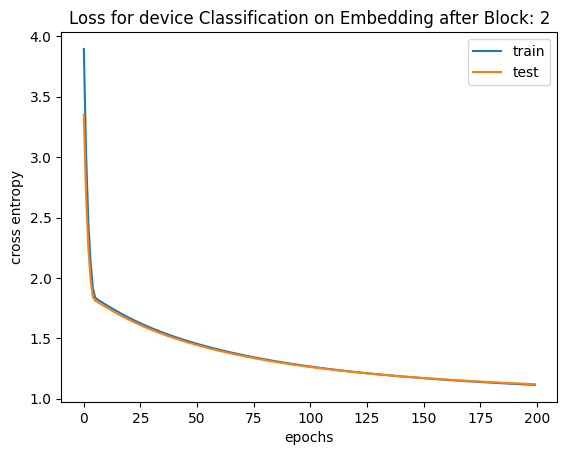

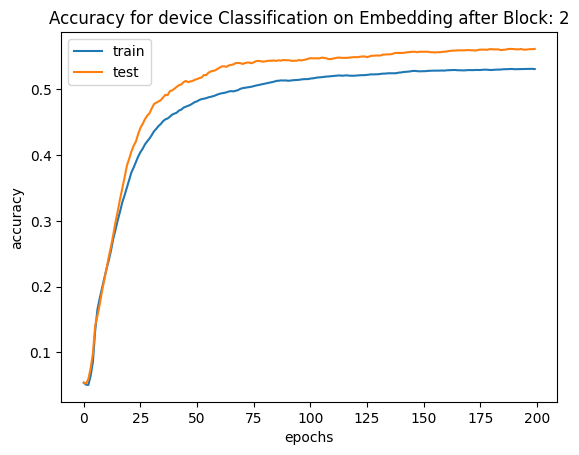

In [46]:
n_epochs = 200
batch_size = b_s
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            labels = np.argmax(y_batch, axis=1)
            loss = criterion(y_pred, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if acc > best_acc:
        best_acc = acc

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)
list_val_acc.append(best_acc)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [47]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [48]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')

In [49]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
)

In [50]:
X_test=train_ready(test_data,col_name)

In [51]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

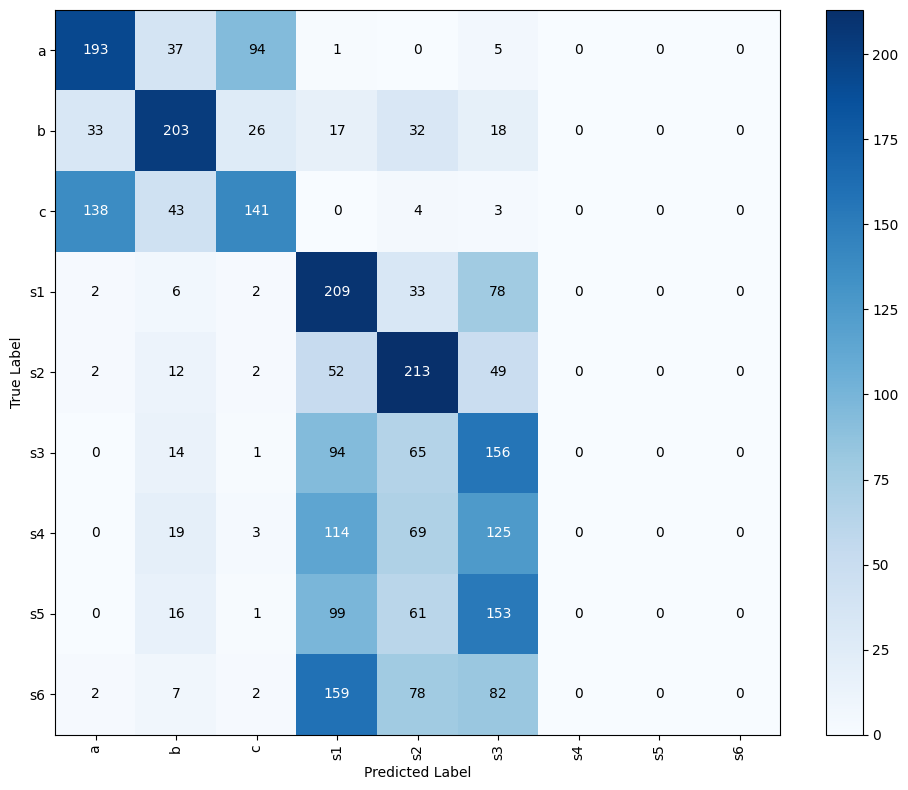

Accuracy: 0.3757


In [52]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-3

In [53]:
Block_number=3

In [54]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth',map_location=torch.device('cpu'))
new_fc3 = nn.Linear(256, 6)

# Replace the existing fc3 layer with the new one
model.fc3 = new_fc3

In [55]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [56]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [57]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [58]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 6)
(2793, 6)


In [59]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 198406
Number of parameters in the last layer is 1542


In [60]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [61]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)

In [62]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 1542


In [63]:
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(weights_array))
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Total number of paramerters in the model are: 198406
Total number of paramerters being trained:  1542


Epoch 0: 100%|██████████| 43/43 [00:00<00:00, 530.62batch/s, acc=0.281, loss=3.1] 


Epoch 0 validation: Cross-entropy=2.98, Accuracy=26.4%


Epoch 1: 100%|██████████| 43/43 [00:00<00:00, 227.06batch/s, acc=0.238, loss=2.57]


Epoch 1 validation: Cross-entropy=2.45, Accuracy=23.6%


Epoch 2: 100%|██████████| 43/43 [00:00<00:00, 513.33batch/s, acc=0.227, loss=2.17]


Epoch 2 validation: Cross-entropy=2.06, Accuracy=22.0%


Epoch 3: 100%|██████████| 43/43 [00:00<00:00, 316.93batch/s, acc=0.117, loss=2]   


Epoch 3 validation: Cross-entropy=1.91, Accuracy=14.4%


Epoch 4: 100%|██████████| 43/43 [00:00<00:00, 530.75batch/s, acc=0.0859, loss=1.94]


Epoch 4 validation: Cross-entropy=1.87, Accuracy=11.1%


Epoch 5: 100%|██████████| 43/43 [00:00<00:00, 255.01batch/s, acc=0.0703, loss=1.93]


Epoch 5 validation: Cross-entropy=1.85, Accuracy=8.7%


Epoch 6: 100%|██████████| 43/43 [00:00<00:00, 535.73batch/s, acc=0.0625, loss=1.91]


Epoch 6 validation: Cross-entropy=1.84, Accuracy=8.6%


Epoch 7: 100%|██████████| 43/43 [00:00<00:00, 298.72batch/s, acc=0.0547, loss=1.9] 


Epoch 7 validation: Cross-entropy=1.83, Accuracy=8.7%


Epoch 8: 100%|██████████| 43/43 [00:00<00:00, 528.72batch/s, acc=0.0547, loss=1.89]


Epoch 8 validation: Cross-entropy=1.82, Accuracy=8.9%


Epoch 9: 100%|██████████| 43/43 [00:00<00:00, 321.94batch/s, acc=0.0586, loss=1.88]


Epoch 9 validation: Cross-entropy=1.81, Accuracy=8.8%


Epoch 10: 100%|██████████| 43/43 [00:00<00:00, 348.51batch/s, acc=0.0586, loss=1.87]


Epoch 10 validation: Cross-entropy=1.81, Accuracy=9.1%


Epoch 11: 100%|██████████| 43/43 [00:00<00:00, 328.72batch/s, acc=0.0625, loss=1.86]


Epoch 11 validation: Cross-entropy=1.80, Accuracy=9.1%


Epoch 12: 100%|██████████| 43/43 [00:00<00:00, 422.40batch/s, acc=0.0625, loss=1.85]


Epoch 12 validation: Cross-entropy=1.79, Accuracy=9.3%


Epoch 13: 100%|██████████| 43/43 [00:00<00:00, 429.41batch/s, acc=0.0664, loss=1.84]


Epoch 13 validation: Cross-entropy=1.78, Accuracy=9.3%


Epoch 14: 100%|██████████| 43/43 [00:00<00:00, 371.22batch/s, acc=0.0781, loss=1.83]


Epoch 14 validation: Cross-entropy=1.77, Accuracy=9.6%


Epoch 15: 100%|██████████| 43/43 [00:00<00:00, 278.43batch/s, acc=0.082, loss=1.82] 


Epoch 15 validation: Cross-entropy=1.77, Accuracy=9.9%


Epoch 16: 100%|██████████| 43/43 [00:00<00:00, 225.77batch/s, acc=0.0781, loss=1.81]


Epoch 16 validation: Cross-entropy=1.76, Accuracy=10.2%


Epoch 17: 100%|██████████| 43/43 [00:00<00:00, 317.72batch/s, acc=0.0859, loss=1.81]


Epoch 17 validation: Cross-entropy=1.75, Accuracy=10.4%


Epoch 18: 100%|██████████| 43/43 [00:00<00:00, 319.68batch/s, acc=0.0898, loss=1.8] 


Epoch 18 validation: Cross-entropy=1.75, Accuracy=10.7%


Epoch 19: 100%|██████████| 43/43 [00:00<00:00, 520.41batch/s, acc=0.0859, loss=1.79]


Epoch 19 validation: Cross-entropy=1.74, Accuracy=11.3%


Epoch 20: 100%|██████████| 43/43 [00:00<00:00, 477.24batch/s, acc=0.082, loss=1.78] 


Epoch 20 validation: Cross-entropy=1.74, Accuracy=11.7%


Epoch 21: 100%|██████████| 43/43 [00:00<00:00, 258.26batch/s, acc=0.0859, loss=1.78]


Epoch 21 validation: Cross-entropy=1.73, Accuracy=12.2%


Epoch 22: 100%|██████████| 43/43 [00:00<00:00, 300.36batch/s, acc=0.0859, loss=1.77]


Epoch 22 validation: Cross-entropy=1.72, Accuracy=12.5%


Epoch 23: 100%|██████████| 43/43 [00:00<00:00, 535.81batch/s, acc=0.0898, loss=1.76]


Epoch 23 validation: Cross-entropy=1.72, Accuracy=12.9%


Epoch 24: 100%|██████████| 43/43 [00:00<00:00, 284.31batch/s, acc=0.102, loss=1.76] 


Epoch 24 validation: Cross-entropy=1.71, Accuracy=13.4%


Epoch 25: 100%|██████████| 43/43 [00:00<00:00, 445.20batch/s, acc=0.102, loss=1.75] 


Epoch 25 validation: Cross-entropy=1.71, Accuracy=13.7%


Epoch 26: 100%|██████████| 43/43 [00:00<00:00, 532.34batch/s, acc=0.102, loss=1.74] 


Epoch 26 validation: Cross-entropy=1.70, Accuracy=14.0%


Epoch 27: 100%|██████████| 43/43 [00:00<00:00, 283.07batch/s, acc=0.113, loss=1.74] 


Epoch 27 validation: Cross-entropy=1.70, Accuracy=14.6%


Epoch 28: 100%|██████████| 43/43 [00:00<00:00, 503.61batch/s, acc=0.121, loss=1.73]


Epoch 28 validation: Cross-entropy=1.69, Accuracy=15.2%


Epoch 29: 100%|██████████| 43/43 [00:00<00:00, 287.48batch/s, acc=0.121, loss=1.73]


Epoch 29 validation: Cross-entropy=1.69, Accuracy=15.9%


Epoch 30: 100%|██████████| 43/43 [00:00<00:00, 467.81batch/s, acc=0.129, loss=1.72]


Epoch 30 validation: Cross-entropy=1.68, Accuracy=16.6%


Epoch 31: 100%|██████████| 43/43 [00:00<00:00, 496.78batch/s, acc=0.137, loss=1.71]


Epoch 31 validation: Cross-entropy=1.68, Accuracy=17.4%


Epoch 32: 100%|██████████| 43/43 [00:00<00:00, 289.52batch/s, acc=0.148, loss=1.71]


Epoch 32 validation: Cross-entropy=1.67, Accuracy=17.8%


Epoch 33: 100%|██████████| 43/43 [00:00<00:00, 526.43batch/s, acc=0.145, loss=1.7] 


Epoch 33 validation: Cross-entropy=1.67, Accuracy=18.4%


Epoch 34: 100%|██████████| 43/43 [00:00<00:00, 225.90batch/s, acc=0.145, loss=1.7] 


Epoch 34 validation: Cross-entropy=1.66, Accuracy=19.1%


Epoch 35: 100%|██████████| 43/43 [00:00<00:00, 541.38batch/s, acc=0.148, loss=1.69]


Epoch 35 validation: Cross-entropy=1.66, Accuracy=19.6%


Epoch 36: 100%|██████████| 43/43 [00:00<00:00, 273.35batch/s, acc=0.156, loss=1.69]


Epoch 36 validation: Cross-entropy=1.65, Accuracy=20.2%


Epoch 37: 100%|██████████| 43/43 [00:00<00:00, 475.35batch/s, acc=0.164, loss=1.68]


Epoch 37 validation: Cross-entropy=1.65, Accuracy=20.7%


Epoch 38: 100%|██████████| 43/43 [00:00<00:00, 518.98batch/s, acc=0.168, loss=1.68]


Epoch 38 validation: Cross-entropy=1.64, Accuracy=21.4%


Epoch 39: 100%|██████████| 43/43 [00:00<00:00, 273.89batch/s, acc=0.172, loss=1.67]


Epoch 39 validation: Cross-entropy=1.64, Accuracy=21.8%


Epoch 40: 100%|██████████| 43/43 [00:00<00:00, 528.73batch/s, acc=0.18, loss=1.67] 


Epoch 40 validation: Cross-entropy=1.64, Accuracy=22.4%


Epoch 41: 100%|██████████| 43/43 [00:00<00:00, 505.63batch/s, acc=0.184, loss=1.66]


Epoch 41 validation: Cross-entropy=1.63, Accuracy=22.8%


Epoch 42: 100%|██████████| 43/43 [00:00<00:00, 276.09batch/s, acc=0.184, loss=1.66]


Epoch 42 validation: Cross-entropy=1.63, Accuracy=23.3%


Epoch 43: 100%|██████████| 43/43 [00:00<00:00, 509.48batch/s, acc=0.184, loss=1.65]


Epoch 43 validation: Cross-entropy=1.62, Accuracy=23.9%


Epoch 44: 100%|██████████| 43/43 [00:00<00:00, 207.40batch/s, acc=0.199, loss=1.65]


Epoch 44 validation: Cross-entropy=1.62, Accuracy=24.5%


Epoch 45: 100%|██████████| 43/43 [00:00<00:00, 549.92batch/s, acc=0.211, loss=1.64]


Epoch 45 validation: Cross-entropy=1.61, Accuracy=25.2%


Epoch 46: 100%|██████████| 43/43 [00:00<00:00, 310.20batch/s, acc=0.219, loss=1.64]


Epoch 46 validation: Cross-entropy=1.61, Accuracy=25.6%


Epoch 47: 100%|██████████| 43/43 [00:00<00:00, 461.46batch/s, acc=0.223, loss=1.63]


Epoch 47 validation: Cross-entropy=1.61, Accuracy=25.8%


Epoch 48: 100%|██████████| 43/43 [00:00<00:00, 304.16batch/s, acc=0.227, loss=1.63]


Epoch 48 validation: Cross-entropy=1.60, Accuracy=26.1%


Epoch 49: 100%|██████████| 43/43 [00:00<00:00, 481.55batch/s, acc=0.227, loss=1.62]


Epoch 49 validation: Cross-entropy=1.60, Accuracy=26.4%


Epoch 50: 100%|██████████| 43/43 [00:00<00:00, 530.27batch/s, acc=0.234, loss=1.62]


Epoch 50 validation: Cross-entropy=1.59, Accuracy=26.7%


Epoch 51: 100%|██████████| 43/43 [00:00<00:00, 281.66batch/s, acc=0.242, loss=1.61]


Epoch 51 validation: Cross-entropy=1.59, Accuracy=26.7%


Epoch 52: 100%|██████████| 43/43 [00:00<00:00, 551.32batch/s, acc=0.246, loss=1.61]


Epoch 52 validation: Cross-entropy=1.59, Accuracy=26.9%


Epoch 53: 100%|██████████| 43/43 [00:00<00:00, 221.58batch/s, acc=0.25, loss=1.6]  


Epoch 53 validation: Cross-entropy=1.58, Accuracy=27.2%


Epoch 54: 100%|██████████| 43/43 [00:00<00:00, 482.67batch/s, acc=0.254, loss=1.6] 


Epoch 54 validation: Cross-entropy=1.58, Accuracy=27.3%


Epoch 55: 100%|██████████| 43/43 [00:00<00:00, 540.14batch/s, acc=0.254, loss=1.59]


Epoch 55 validation: Cross-entropy=1.57, Accuracy=27.7%


Epoch 56: 100%|██████████| 43/43 [00:00<00:00, 279.39batch/s, acc=0.258, loss=1.59]


Epoch 56 validation: Cross-entropy=1.57, Accuracy=28.1%


Epoch 57: 100%|██████████| 43/43 [00:00<00:00, 542.74batch/s, acc=0.266, loss=1.59]


Epoch 57 validation: Cross-entropy=1.57, Accuracy=28.5%


Epoch 58: 100%|██████████| 43/43 [00:00<00:00, 533.91batch/s, acc=0.27, loss=1.58] 


Epoch 58 validation: Cross-entropy=1.56, Accuracy=28.7%


Epoch 59: 100%|██████████| 43/43 [00:00<00:00, 318.04batch/s, acc=0.273, loss=1.58]


Epoch 59 validation: Cross-entropy=1.56, Accuracy=29.1%


Epoch 60: 100%|██████████| 43/43 [00:00<00:00, 550.81batch/s, acc=0.289, loss=1.57]


Epoch 60 validation: Cross-entropy=1.56, Accuracy=29.5%


Epoch 61: 100%|██████████| 43/43 [00:00<00:00, 280.13batch/s, acc=0.301, loss=1.57]


Epoch 61 validation: Cross-entropy=1.55, Accuracy=29.8%


Epoch 62: 100%|██████████| 43/43 [00:00<00:00, 541.40batch/s, acc=0.312, loss=1.56]


Epoch 62 validation: Cross-entropy=1.55, Accuracy=30.0%


Epoch 63: 100%|██████████| 43/43 [00:00<00:00, 230.41batch/s, acc=0.316, loss=1.56]


Epoch 63 validation: Cross-entropy=1.55, Accuracy=30.5%


Epoch 64: 100%|██████████| 43/43 [00:00<00:00, 439.17batch/s, acc=0.316, loss=1.56]


Epoch 64 validation: Cross-entropy=1.54, Accuracy=30.9%


Epoch 65: 100%|██████████| 43/43 [00:00<00:00, 296.52batch/s, acc=0.316, loss=1.55]


Epoch 65 validation: Cross-entropy=1.54, Accuracy=31.0%


Epoch 66: 100%|██████████| 43/43 [00:00<00:00, 528.12batch/s, acc=0.316, loss=1.55]


Epoch 66 validation: Cross-entropy=1.54, Accuracy=31.3%


Epoch 67: 100%|██████████| 43/43 [00:00<00:00, 575.70batch/s, acc=0.316, loss=1.54]


Epoch 67 validation: Cross-entropy=1.53, Accuracy=31.5%


Epoch 68: 100%|██████████| 43/43 [00:00<00:00, 295.09batch/s, acc=0.316, loss=1.54]


Epoch 68 validation: Cross-entropy=1.53, Accuracy=31.7%


Epoch 69: 100%|██████████| 43/43 [00:00<00:00, 479.04batch/s, acc=0.32, loss=1.54] 


Epoch 69 validation: Cross-entropy=1.53, Accuracy=32.0%


Epoch 70: 100%|██████████| 43/43 [00:00<00:00, 324.38batch/s, acc=0.328, loss=1.53]


Epoch 70 validation: Cross-entropy=1.52, Accuracy=32.3%


Epoch 71: 100%|██████████| 43/43 [00:00<00:00, 478.92batch/s, acc=0.332, loss=1.53]


Epoch 71 validation: Cross-entropy=1.52, Accuracy=32.9%


Epoch 72: 100%|██████████| 43/43 [00:00<00:00, 534.78batch/s, acc=0.336, loss=1.52]


Epoch 72 validation: Cross-entropy=1.52, Accuracy=33.2%


Epoch 73: 100%|██████████| 43/43 [00:00<00:00, 234.12batch/s, acc=0.336, loss=1.52]


Epoch 73 validation: Cross-entropy=1.51, Accuracy=33.5%


Epoch 74: 100%|██████████| 43/43 [00:00<00:00, 406.86batch/s, acc=0.336, loss=1.52]


Epoch 74 validation: Cross-entropy=1.51, Accuracy=33.8%


Epoch 75: 100%|██████████| 43/43 [00:00<00:00, 382.52batch/s, acc=0.336, loss=1.51]


Epoch 75 validation: Cross-entropy=1.51, Accuracy=34.2%


Epoch 76: 100%|██████████| 43/43 [00:00<00:00, 505.98batch/s, acc=0.336, loss=1.51]


Epoch 76 validation: Cross-entropy=1.50, Accuracy=34.6%


Epoch 77: 100%|██████████| 43/43 [00:00<00:00, 302.57batch/s, acc=0.348, loss=1.51]


Epoch 77 validation: Cross-entropy=1.50, Accuracy=35.0%


Epoch 78: 100%|██████████| 43/43 [00:00<00:00, 540.74batch/s, acc=0.348, loss=1.5] 


Epoch 78 validation: Cross-entropy=1.50, Accuracy=35.5%


Epoch 79: 100%|██████████| 43/43 [00:00<00:00, 297.13batch/s, acc=0.348, loss=1.5] 


Epoch 79 validation: Cross-entropy=1.49, Accuracy=35.8%


Epoch 80: 100%|██████████| 43/43 [00:00<00:00, 502.26batch/s, acc=0.352, loss=1.5] 


Epoch 80 validation: Cross-entropy=1.49, Accuracy=36.2%


Epoch 81: 100%|██████████| 43/43 [00:00<00:00, 540.73batch/s, acc=0.348, loss=1.49]


Epoch 81 validation: Cross-entropy=1.49, Accuracy=36.4%


Epoch 82: 100%|██████████| 43/43 [00:00<00:00, 221.93batch/s, acc=0.355, loss=1.49]


Epoch 82 validation: Cross-entropy=1.49, Accuracy=36.9%


Epoch 83: 100%|██████████| 43/43 [00:00<00:00, 565.76batch/s, acc=0.355, loss=1.49]


Epoch 83 validation: Cross-entropy=1.48, Accuracy=37.1%


Epoch 84: 100%|██████████| 43/43 [00:00<00:00, 275.54batch/s, acc=0.355, loss=1.48]


Epoch 84 validation: Cross-entropy=1.48, Accuracy=37.3%


Epoch 85: 100%|██████████| 43/43 [00:00<00:00, 531.38batch/s, acc=0.355, loss=1.48]


Epoch 85 validation: Cross-entropy=1.48, Accuracy=37.4%


Epoch 86: 100%|██████████| 43/43 [00:00<00:00, 284.87batch/s, acc=0.363, loss=1.47]


Epoch 86 validation: Cross-entropy=1.47, Accuracy=37.7%


Epoch 87: 100%|██████████| 43/43 [00:00<00:00, 517.52batch/s, acc=0.367, loss=1.47]


Epoch 87 validation: Cross-entropy=1.47, Accuracy=37.8%


Epoch 88: 100%|██████████| 43/43 [00:00<00:00, 255.90batch/s, acc=0.371, loss=1.47]


Epoch 88 validation: Cross-entropy=1.47, Accuracy=37.8%


Epoch 89: 100%|██████████| 43/43 [00:00<00:00, 515.14batch/s, acc=0.371, loss=1.47]


Epoch 89 validation: Cross-entropy=1.47, Accuracy=38.0%


Epoch 90: 100%|██████████| 43/43 [00:00<00:00, 552.50batch/s, acc=0.371, loss=1.46]


Epoch 90 validation: Cross-entropy=1.46, Accuracy=38.1%


Epoch 91: 100%|██████████| 43/43 [00:00<00:00, 219.53batch/s, acc=0.375, loss=1.46]


Epoch 91 validation: Cross-entropy=1.46, Accuracy=38.2%


Epoch 92: 100%|██████████| 43/43 [00:00<00:00, 511.63batch/s, acc=0.375, loss=1.46]


Epoch 92 validation: Cross-entropy=1.46, Accuracy=38.5%


Epoch 93: 100%|██████████| 43/43 [00:00<00:00, 287.47batch/s, acc=0.375, loss=1.45]


Epoch 93 validation: Cross-entropy=1.46, Accuracy=38.6%


Epoch 94: 100%|██████████| 43/43 [00:00<00:00, 527.13batch/s, acc=0.375, loss=1.45]


Epoch 94 validation: Cross-entropy=1.45, Accuracy=38.8%


Epoch 95: 100%|██████████| 43/43 [00:00<00:00, 290.69batch/s, acc=0.375, loss=1.45]


Epoch 95 validation: Cross-entropy=1.45, Accuracy=39.1%


Epoch 96: 100%|██████████| 43/43 [00:00<00:00, 512.30batch/s, acc=0.375, loss=1.44]


Epoch 96 validation: Cross-entropy=1.45, Accuracy=39.4%


Epoch 97: 100%|██████████| 43/43 [00:00<00:00, 293.30batch/s, acc=0.379, loss=1.44]


Epoch 97 validation: Cross-entropy=1.45, Accuracy=39.6%


Epoch 98: 100%|██████████| 43/43 [00:00<00:00, 536.74batch/s, acc=0.379, loss=1.44]


Epoch 98 validation: Cross-entropy=1.44, Accuracy=39.8%


Epoch 99: 100%|██████████| 43/43 [00:00<00:00, 432.14batch/s, acc=0.383, loss=1.43]


Epoch 99 validation: Cross-entropy=1.44, Accuracy=39.8%


Epoch 100: 100%|██████████| 43/43 [00:00<00:00, 375.79batch/s, acc=0.379, loss=1.43]


Epoch 100 validation: Cross-entropy=1.44, Accuracy=40.1%


Epoch 101: 100%|██████████| 43/43 [00:00<00:00, 345.17batch/s, acc=0.383, loss=1.43]


Epoch 101 validation: Cross-entropy=1.44, Accuracy=40.1%


Epoch 102: 100%|██████████| 43/43 [00:00<00:00, 300.94batch/s, acc=0.383, loss=1.43]


Epoch 102 validation: Cross-entropy=1.43, Accuracy=40.3%


Epoch 103: 100%|██████████| 43/43 [00:00<00:00, 535.71batch/s, acc=0.387, loss=1.42]


Epoch 103 validation: Cross-entropy=1.43, Accuracy=40.6%


Epoch 104: 100%|██████████| 43/43 [00:00<00:00, 278.03batch/s, acc=0.387, loss=1.42]


Epoch 104 validation: Cross-entropy=1.43, Accuracy=40.7%


Epoch 105: 100%|██████████| 43/43 [00:00<00:00, 543.92batch/s, acc=0.391, loss=1.42]


Epoch 105 validation: Cross-entropy=1.43, Accuracy=40.8%


Epoch 106: 100%|██████████| 43/43 [00:00<00:00, 517.65batch/s, acc=0.391, loss=1.41]


Epoch 106 validation: Cross-entropy=1.42, Accuracy=40.9%


Epoch 107: 100%|██████████| 43/43 [00:00<00:00, 271.30batch/s, acc=0.391, loss=1.41]


Epoch 107 validation: Cross-entropy=1.42, Accuracy=41.1%


Epoch 108: 100%|██████████| 43/43 [00:00<00:00, 518.19batch/s, acc=0.395, loss=1.41]


Epoch 108 validation: Cross-entropy=1.42, Accuracy=41.2%


Epoch 109: 100%|██████████| 43/43 [00:00<00:00, 256.53batch/s, acc=0.398, loss=1.41]


Epoch 109 validation: Cross-entropy=1.42, Accuracy=41.2%


Epoch 110: 100%|██████████| 43/43 [00:00<00:00, 312.51batch/s, acc=0.406, loss=1.4] 


Epoch 110 validation: Cross-entropy=1.42, Accuracy=41.4%


Epoch 111: 100%|██████████| 43/43 [00:00<00:00, 298.19batch/s, acc=0.41, loss=1.4]  


Epoch 111 validation: Cross-entropy=1.41, Accuracy=41.6%


Epoch 112: 100%|██████████| 43/43 [00:00<00:00, 489.58batch/s, acc=0.41, loss=1.4]  


Epoch 112 validation: Cross-entropy=1.41, Accuracy=41.7%


Epoch 113: 100%|██████████| 43/43 [00:00<00:00, 304.38batch/s, acc=0.41, loss=1.4]  


Epoch 113 validation: Cross-entropy=1.41, Accuracy=41.9%


Epoch 114: 100%|██████████| 43/43 [00:00<00:00, 503.09batch/s, acc=0.414, loss=1.39]


Epoch 114 validation: Cross-entropy=1.41, Accuracy=42.1%


Epoch 115: 100%|██████████| 43/43 [00:00<00:00, 414.08batch/s, acc=0.414, loss=1.39]


Epoch 115 validation: Cross-entropy=1.40, Accuracy=42.2%


Epoch 116: 100%|██████████| 43/43 [00:00<00:00, 415.32batch/s, acc=0.414, loss=1.39]


Epoch 116 validation: Cross-entropy=1.40, Accuracy=42.3%


Epoch 117: 100%|██████████| 43/43 [00:00<00:00, 570.47batch/s, acc=0.418, loss=1.39]


Epoch 117 validation: Cross-entropy=1.40, Accuracy=42.3%


Epoch 118: 100%|██████████| 43/43 [00:00<00:00, 388.83batch/s, acc=0.418, loss=1.38]


Epoch 118 validation: Cross-entropy=1.40, Accuracy=42.4%


Epoch 119: 100%|██████████| 43/43 [00:00<00:00, 384.50batch/s, acc=0.418, loss=1.38]


Epoch 119 validation: Cross-entropy=1.40, Accuracy=42.5%


Epoch 120: 100%|██████████| 43/43 [00:00<00:00, 352.16batch/s, acc=0.418, loss=1.38]


Epoch 120 validation: Cross-entropy=1.39, Accuracy=42.6%


Epoch 121: 100%|██████████| 43/43 [00:00<00:00, 273.42batch/s, acc=0.422, loss=1.38]


Epoch 121 validation: Cross-entropy=1.39, Accuracy=42.6%


Epoch 122: 100%|██████████| 43/43 [00:00<00:00, 548.27batch/s, acc=0.422, loss=1.37]


Epoch 122 validation: Cross-entropy=1.39, Accuracy=42.7%


Epoch 123: 100%|██████████| 43/43 [00:00<00:00, 310.95batch/s, acc=0.422, loss=1.37]


Epoch 123 validation: Cross-entropy=1.39, Accuracy=42.9%


Epoch 124: 100%|██████████| 43/43 [00:00<00:00, 539.25batch/s, acc=0.422, loss=1.37]


Epoch 124 validation: Cross-entropy=1.39, Accuracy=43.0%


Epoch 125: 100%|██████████| 43/43 [00:00<00:00, 510.21batch/s, acc=0.422, loss=1.37]


Epoch 125 validation: Cross-entropy=1.39, Accuracy=43.3%


Epoch 126: 100%|██████████| 43/43 [00:00<00:00, 277.64batch/s, acc=0.426, loss=1.36]


Epoch 126 validation: Cross-entropy=1.38, Accuracy=43.4%


Epoch 127: 100%|██████████| 43/43 [00:00<00:00, 499.43batch/s, acc=0.426, loss=1.36]


Epoch 127 validation: Cross-entropy=1.38, Accuracy=43.5%


Epoch 128: 100%|██████████| 43/43 [00:00<00:00, 278.93batch/s, acc=0.43, loss=1.36] 


Epoch 128 validation: Cross-entropy=1.38, Accuracy=43.6%


Epoch 129: 100%|██████████| 43/43 [00:00<00:00, 246.40batch/s, acc=0.43, loss=1.36] 


Epoch 129 validation: Cross-entropy=1.38, Accuracy=43.6%


Epoch 130: 100%|██████████| 43/43 [00:00<00:00, 474.79batch/s, acc=0.438, loss=1.36]


Epoch 130 validation: Cross-entropy=1.38, Accuracy=43.6%


Epoch 131: 100%|██████████| 43/43 [00:00<00:00, 293.79batch/s, acc=0.438, loss=1.35]


Epoch 131 validation: Cross-entropy=1.37, Accuracy=43.8%


Epoch 132: 100%|██████████| 43/43 [00:00<00:00, 524.15batch/s, acc=0.438, loss=1.35]


Epoch 132 validation: Cross-entropy=1.37, Accuracy=43.9%


Epoch 133: 100%|██████████| 43/43 [00:00<00:00, 587.19batch/s, acc=0.438, loss=1.35]


Epoch 133 validation: Cross-entropy=1.37, Accuracy=44.0%


Epoch 134: 100%|██████████| 43/43 [00:00<00:00, 302.97batch/s, acc=0.438, loss=1.35]


Epoch 134 validation: Cross-entropy=1.37, Accuracy=44.1%


Epoch 135: 100%|██████████| 43/43 [00:00<00:00, 511.34batch/s, acc=0.438, loss=1.34]


Epoch 135 validation: Cross-entropy=1.37, Accuracy=44.1%


Epoch 136: 100%|██████████| 43/43 [00:00<00:00, 565.43batch/s, acc=0.441, loss=1.34]


Epoch 136 validation: Cross-entropy=1.37, Accuracy=44.1%


Epoch 137: 100%|██████████| 43/43 [00:00<00:00, 272.79batch/s, acc=0.441, loss=1.34]


Epoch 137 validation: Cross-entropy=1.36, Accuracy=44.3%


Epoch 138: 100%|██████████| 43/43 [00:00<00:00, 360.52batch/s, acc=0.445, loss=1.34]


Epoch 138 validation: Cross-entropy=1.36, Accuracy=44.3%


Epoch 139: 100%|██████████| 43/43 [00:00<00:00, 305.85batch/s, acc=0.445, loss=1.34]


Epoch 139 validation: Cross-entropy=1.36, Accuracy=44.4%


Epoch 140: 100%|██████████| 43/43 [00:00<00:00, 565.27batch/s, acc=0.445, loss=1.33]


Epoch 140 validation: Cross-entropy=1.36, Accuracy=44.5%


Epoch 141: 100%|██████████| 43/43 [00:00<00:00, 265.19batch/s, acc=0.453, loss=1.33]


Epoch 141 validation: Cross-entropy=1.36, Accuracy=44.5%


Epoch 142: 100%|██████████| 43/43 [00:00<00:00, 494.55batch/s, acc=0.453, loss=1.33]


Epoch 142 validation: Cross-entropy=1.36, Accuracy=44.8%


Epoch 143: 100%|██████████| 43/43 [00:00<00:00, 248.22batch/s, acc=0.449, loss=1.33]


Epoch 143 validation: Cross-entropy=1.35, Accuracy=45.0%


Epoch 144: 100%|██████████| 43/43 [00:00<00:00, 563.05batch/s, acc=0.449, loss=1.33]


Epoch 144 validation: Cross-entropy=1.35, Accuracy=45.1%


Epoch 145: 100%|██████████| 43/43 [00:00<00:00, 303.87batch/s, acc=0.449, loss=1.32]


Epoch 145 validation: Cross-entropy=1.35, Accuracy=45.3%


Epoch 146: 100%|██████████| 43/43 [00:00<00:00, 490.65batch/s, acc=0.449, loss=1.32]


Epoch 146 validation: Cross-entropy=1.35, Accuracy=45.4%


Epoch 147: 100%|██████████| 43/43 [00:00<00:00, 541.75batch/s, acc=0.449, loss=1.32]


Epoch 147 validation: Cross-entropy=1.35, Accuracy=45.4%


Epoch 148: 100%|██████████| 43/43 [00:00<00:00, 267.33batch/s, acc=0.449, loss=1.32]


Epoch 148 validation: Cross-entropy=1.35, Accuracy=45.4%


Epoch 149: 100%|██████████| 43/43 [00:00<00:00, 462.37batch/s, acc=0.449, loss=1.32]


Epoch 149 validation: Cross-entropy=1.34, Accuracy=45.6%


Epoch 150: 100%|██████████| 43/43 [00:00<00:00, 561.34batch/s, acc=0.449, loss=1.32]


Epoch 150 validation: Cross-entropy=1.34, Accuracy=45.6%


Epoch 151: 100%|██████████| 43/43 [00:00<00:00, 314.78batch/s, acc=0.449, loss=1.31]


Epoch 151 validation: Cross-entropy=1.34, Accuracy=45.7%


Epoch 152: 100%|██████████| 43/43 [00:00<00:00, 550.96batch/s, acc=0.449, loss=1.31]


Epoch 152 validation: Cross-entropy=1.34, Accuracy=45.8%


Epoch 153: 100%|██████████| 43/43 [00:00<00:00, 255.78batch/s, acc=0.449, loss=1.31]


Epoch 153 validation: Cross-entropy=1.34, Accuracy=45.9%


Epoch 154: 100%|██████████| 43/43 [00:00<00:00, 453.47batch/s, acc=0.449, loss=1.31]


Epoch 154 validation: Cross-entropy=1.34, Accuracy=46.1%


Epoch 155: 100%|██████████| 43/43 [00:00<00:00, 332.03batch/s, acc=0.449, loss=1.31]


Epoch 155 validation: Cross-entropy=1.34, Accuracy=46.1%


Epoch 156: 100%|██████████| 43/43 [00:00<00:00, 453.62batch/s, acc=0.453, loss=1.3] 


Epoch 156 validation: Cross-entropy=1.33, Accuracy=46.1%


Epoch 157: 100%|██████████| 43/43 [00:00<00:00, 361.74batch/s, acc=0.453, loss=1.3] 


Epoch 157 validation: Cross-entropy=1.33, Accuracy=46.1%


Epoch 158: 100%|██████████| 43/43 [00:00<00:00, 280.72batch/s, acc=0.457, loss=1.3] 


Epoch 158 validation: Cross-entropy=1.33, Accuracy=46.2%


Epoch 159: 100%|██████████| 43/43 [00:00<00:00, 460.97batch/s, acc=0.461, loss=1.3] 


Epoch 159 validation: Cross-entropy=1.33, Accuracy=46.3%


Epoch 160: 100%|██████████| 43/43 [00:00<00:00, 231.55batch/s, acc=0.461, loss=1.3] 


Epoch 160 validation: Cross-entropy=1.33, Accuracy=46.3%


Epoch 161: 100%|██████████| 43/43 [00:00<00:00, 537.74batch/s, acc=0.461, loss=1.3] 


Epoch 161 validation: Cross-entropy=1.33, Accuracy=46.3%


Epoch 162: 100%|██████████| 43/43 [00:00<00:00, 280.95batch/s, acc=0.461, loss=1.29]


Epoch 162 validation: Cross-entropy=1.33, Accuracy=46.3%


Epoch 163: 100%|██████████| 43/43 [00:00<00:00, 386.49batch/s, acc=0.461, loss=1.29]


Epoch 163 validation: Cross-entropy=1.32, Accuracy=46.4%


Epoch 164: 100%|██████████| 43/43 [00:00<00:00, 307.59batch/s, acc=0.461, loss=1.29]


Epoch 164 validation: Cross-entropy=1.32, Accuracy=46.5%


Epoch 165: 100%|██████████| 43/43 [00:00<00:00, 441.21batch/s, acc=0.461, loss=1.29]


Epoch 165 validation: Cross-entropy=1.32, Accuracy=46.8%


Epoch 166: 100%|██████████| 43/43 [00:00<00:00, 547.33batch/s, acc=0.461, loss=1.29]


Epoch 166 validation: Cross-entropy=1.32, Accuracy=46.9%


Epoch 167: 100%|██████████| 43/43 [00:00<00:00, 224.19batch/s, acc=0.465, loss=1.29]


Epoch 167 validation: Cross-entropy=1.32, Accuracy=47.0%


Epoch 168: 100%|██████████| 43/43 [00:00<00:00, 556.09batch/s, acc=0.465, loss=1.28]


Epoch 168 validation: Cross-entropy=1.32, Accuracy=47.0%


Epoch 169: 100%|██████████| 43/43 [00:00<00:00, 297.31batch/s, acc=0.469, loss=1.28]


Epoch 169 validation: Cross-entropy=1.32, Accuracy=47.0%


Epoch 170: 100%|██████████| 43/43 [00:00<00:00, 526.16batch/s, acc=0.469, loss=1.28]


Epoch 170 validation: Cross-entropy=1.31, Accuracy=47.1%


Epoch 171: 100%|██████████| 43/43 [00:00<00:00, 534.43batch/s, acc=0.469, loss=1.28]


Epoch 171 validation: Cross-entropy=1.31, Accuracy=47.0%


Epoch 172: 100%|██████████| 43/43 [00:00<00:00, 296.68batch/s, acc=0.469, loss=1.28]


Epoch 172 validation: Cross-entropy=1.31, Accuracy=47.1%


Epoch 173: 100%|██████████| 43/43 [00:00<00:00, 539.48batch/s, acc=0.469, loss=1.28]


Epoch 173 validation: Cross-entropy=1.31, Accuracy=47.2%


Epoch 174: 100%|██████████| 43/43 [00:00<00:00, 289.28batch/s, acc=0.469, loss=1.27]


Epoch 174 validation: Cross-entropy=1.31, Accuracy=47.2%


Epoch 175: 100%|██████████| 43/43 [00:00<00:00, 537.41batch/s, acc=0.469, loss=1.27]


Epoch 175 validation: Cross-entropy=1.31, Accuracy=47.2%


Epoch 176: 100%|██████████| 43/43 [00:00<00:00, 235.82batch/s, acc=0.469, loss=1.27]


Epoch 176 validation: Cross-entropy=1.31, Accuracy=47.3%


Epoch 177: 100%|██████████| 43/43 [00:00<00:00, 537.51batch/s, acc=0.469, loss=1.27]


Epoch 177 validation: Cross-entropy=1.31, Accuracy=47.3%


Epoch 178: 100%|██████████| 43/43 [00:00<00:00, 326.51batch/s, acc=0.469, loss=1.27]


Epoch 178 validation: Cross-entropy=1.30, Accuracy=47.3%


Epoch 179: 100%|██████████| 43/43 [00:00<00:00, 453.45batch/s, acc=0.473, loss=1.27]


Epoch 179 validation: Cross-entropy=1.30, Accuracy=47.3%


Epoch 180: 100%|██████████| 43/43 [00:00<00:00, 574.11batch/s, acc=0.473, loss=1.27]


Epoch 180 validation: Cross-entropy=1.30, Accuracy=47.3%


Epoch 181: 100%|██████████| 43/43 [00:00<00:00, 308.24batch/s, acc=0.473, loss=1.26]


Epoch 181 validation: Cross-entropy=1.30, Accuracy=47.4%


Epoch 182: 100%|██████████| 43/43 [00:00<00:00, 532.76batch/s, acc=0.473, loss=1.26]


Epoch 182 validation: Cross-entropy=1.30, Accuracy=47.4%


Epoch 183: 100%|██████████| 43/43 [00:00<00:00, 547.14batch/s, acc=0.477, loss=1.26]


Epoch 183 validation: Cross-entropy=1.30, Accuracy=47.4%


Epoch 184: 100%|██████████| 43/43 [00:00<00:00, 359.07batch/s, acc=0.477, loss=1.26]


Epoch 184 validation: Cross-entropy=1.30, Accuracy=47.6%


Epoch 185: 100%|██████████| 43/43 [00:00<00:00, 236.89batch/s, acc=0.477, loss=1.26]


Epoch 185 validation: Cross-entropy=1.30, Accuracy=47.7%


Epoch 186: 100%|██████████| 43/43 [00:00<00:00, 463.98batch/s, acc=0.477, loss=1.26]


Epoch 186 validation: Cross-entropy=1.29, Accuracy=47.6%


Epoch 187: 100%|██████████| 43/43 [00:00<00:00, 549.77batch/s, acc=0.477, loss=1.26]


Epoch 187 validation: Cross-entropy=1.29, Accuracy=47.7%


Epoch 188: 100%|██████████| 43/43 [00:00<00:00, 285.19batch/s, acc=0.477, loss=1.25]


Epoch 188 validation: Cross-entropy=1.29, Accuracy=47.7%


Epoch 189: 100%|██████████| 43/43 [00:00<00:00, 510.13batch/s, acc=0.477, loss=1.25]


Epoch 189 validation: Cross-entropy=1.29, Accuracy=47.7%


Epoch 190: 100%|██████████| 43/43 [00:00<00:00, 298.49batch/s, acc=0.477, loss=1.25]


Epoch 190 validation: Cross-entropy=1.29, Accuracy=47.7%


Epoch 191: 100%|██████████| 43/43 [00:00<00:00, 488.69batch/s, acc=0.473, loss=1.25]


Epoch 191 validation: Cross-entropy=1.29, Accuracy=47.9%


Epoch 192: 100%|██████████| 43/43 [00:00<00:00, 551.56batch/s, acc=0.473, loss=1.25]


Epoch 192 validation: Cross-entropy=1.29, Accuracy=47.9%


Epoch 193: 100%|██████████| 43/43 [00:00<00:00, 276.97batch/s, acc=0.477, loss=1.25]


Epoch 193 validation: Cross-entropy=1.29, Accuracy=47.9%


Epoch 194: 100%|██████████| 43/43 [00:00<00:00, 483.45batch/s, acc=0.48, loss=1.25] 


Epoch 194 validation: Cross-entropy=1.29, Accuracy=48.0%


Epoch 195: 100%|██████████| 43/43 [00:00<00:00, 197.52batch/s, acc=0.48, loss=1.25] 


Epoch 195 validation: Cross-entropy=1.28, Accuracy=48.0%


Epoch 196: 100%|██████████| 43/43 [00:00<00:00, 523.55batch/s, acc=0.48, loss=1.24] 


Epoch 196 validation: Cross-entropy=1.28, Accuracy=48.2%


Epoch 197: 100%|██████████| 43/43 [00:00<00:00, 327.65batch/s, acc=0.48, loss=1.24] 


Epoch 197 validation: Cross-entropy=1.28, Accuracy=48.1%


Epoch 198: 100%|██████████| 43/43 [00:00<00:00, 565.68batch/s, acc=0.48, loss=1.24] 


Epoch 198 validation: Cross-entropy=1.28, Accuracy=48.1%


Epoch 199: 100%|██████████| 43/43 [00:00<00:00, 326.82batch/s, acc=0.48, loss=1.24] 


Epoch 199 validation: Cross-entropy=1.28, Accuracy=48.1%


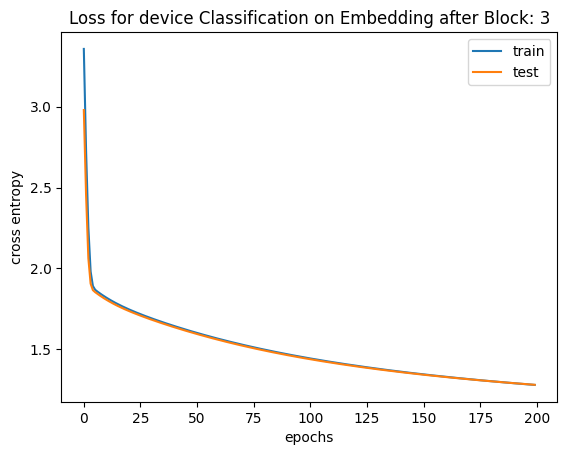

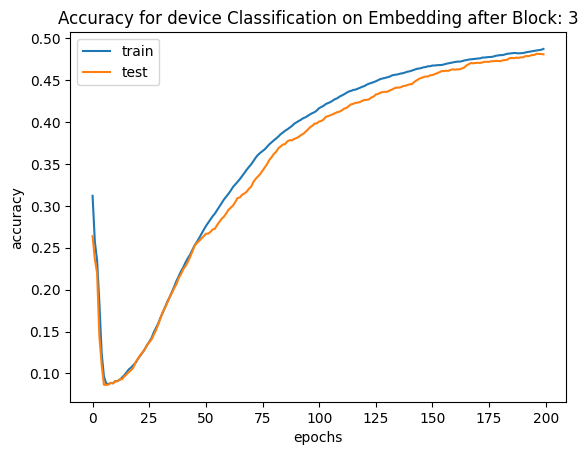

In [64]:
n_epochs = 200
batch_size = b_s
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# # Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters in the model are: {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of paramerters being trained: ", total_trainable_params)


best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            labels = np.argmax(y_batch, axis=1)
            loss = criterion(y_pred, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if acc > best_acc:
        best_acc = acc

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)
list_val_acc.append(best_acc)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [65]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [66]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')

In [67]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
)

In [68]:
X_test=train_ready(test_data,col_name)

In [69]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

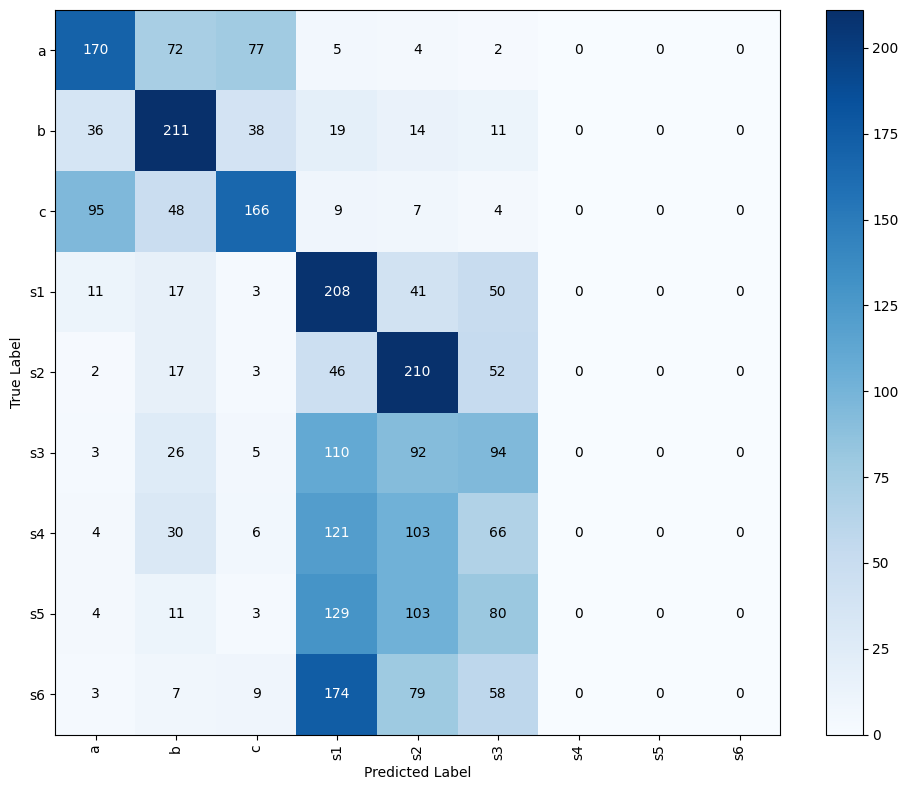

Accuracy: 0.3568


In [70]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-4

In [71]:
Block_number=4

In [72]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth',map_location=torch.device('cpu'))
new_fc3 = nn.Linear(256, 6)

# Replace the existing fc3 layer with the new one
model.fc3 = new_fc3

In [73]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [74]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [75]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [76]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 6)
(2793, 6)


In [77]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 198406
Number of parameters in the last layer is 1542


In [78]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [79]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)

In [80]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 1542


In [81]:
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(weights_array))
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Total number of paramerters in the model are: 198406
Total number of paramerters being trained:  1542


Epoch 0: 100%|██████████| 43/43 [00:00<00:00, 463.03batch/s, acc=0.0625, loss=1.91]


Epoch 0 validation: Cross-entropy=1.98, Accuracy=6.8%


Epoch 1: 100%|██████████| 43/43 [00:00<00:00, 304.32batch/s, acc=0.121, loss=1.86] 


Epoch 1 validation: Cross-entropy=1.92, Accuracy=9.6%


Epoch 2: 100%|██████████| 43/43 [00:00<00:00, 228.18batch/s, acc=0.141, loss=1.84] 


Epoch 2 validation: Cross-entropy=1.88, Accuracy=11.5%


Epoch 3: 100%|██████████| 43/43 [00:00<00:00, 283.00batch/s, acc=0.141, loss=1.82] 


Epoch 3 validation: Cross-entropy=1.85, Accuracy=12.8%


Epoch 4: 100%|██████████| 43/43 [00:00<00:00, 308.94batch/s, acc=0.152, loss=1.8]  


Epoch 4 validation: Cross-entropy=1.83, Accuracy=14.2%


Epoch 5: 100%|██████████| 43/43 [00:00<00:00, 566.59batch/s, acc=0.137, loss=1.79]


Epoch 5 validation: Cross-entropy=1.81, Accuracy=15.0%


Epoch 6: 100%|██████████| 43/43 [00:00<00:00, 368.06batch/s, acc=0.141, loss=1.78]


Epoch 6 validation: Cross-entropy=1.79, Accuracy=15.7%


Epoch 7: 100%|██████████| 43/43 [00:00<00:00, 546.42batch/s, acc=0.145, loss=1.77]


Epoch 7 validation: Cross-entropy=1.78, Accuracy=16.1%


Epoch 8: 100%|██████████| 43/43 [00:00<00:00, 329.04batch/s, acc=0.129, loss=1.76]


Epoch 8 validation: Cross-entropy=1.77, Accuracy=16.1%


Epoch 9: 100%|██████████| 43/43 [00:00<00:00, 359.50batch/s, acc=0.125, loss=1.75]


Epoch 9 validation: Cross-entropy=1.77, Accuracy=16.1%


Epoch 10: 100%|██████████| 43/43 [00:00<00:00, 328.09batch/s, acc=0.137, loss=1.74]


Epoch 10 validation: Cross-entropy=1.76, Accuracy=16.8%


Epoch 11: 100%|██████████| 43/43 [00:00<00:00, 366.44batch/s, acc=0.156, loss=1.74]


Epoch 11 validation: Cross-entropy=1.75, Accuracy=17.6%


Epoch 12: 100%|██████████| 43/43 [00:00<00:00, 493.76batch/s, acc=0.16, loss=1.73] 


Epoch 12 validation: Cross-entropy=1.74, Accuracy=18.4%


Epoch 13: 100%|██████████| 43/43 [00:00<00:00, 308.64batch/s, acc=0.172, loss=1.72]


Epoch 13 validation: Cross-entropy=1.74, Accuracy=18.7%


Epoch 14: 100%|██████████| 43/43 [00:00<00:00, 336.26batch/s, acc=0.184, loss=1.72]


Epoch 14 validation: Cross-entropy=1.73, Accuracy=19.0%


Epoch 15: 100%|██████████| 43/43 [00:00<00:00, 362.54batch/s, acc=0.184, loss=1.71]


Epoch 15 validation: Cross-entropy=1.73, Accuracy=19.7%


Epoch 16: 100%|██████████| 43/43 [00:00<00:00, 280.35batch/s, acc=0.191, loss=1.71]


Epoch 16 validation: Cross-entropy=1.72, Accuracy=20.8%


Epoch 17: 100%|██████████| 43/43 [00:00<00:00, 361.11batch/s, acc=0.199, loss=1.7] 


Epoch 17 validation: Cross-entropy=1.72, Accuracy=21.6%


Epoch 18: 100%|██████████| 43/43 [00:00<00:00, 403.71batch/s, acc=0.203, loss=1.69]


Epoch 18 validation: Cross-entropy=1.71, Accuracy=22.4%


Epoch 19: 100%|██████████| 43/43 [00:00<00:00, 352.27batch/s, acc=0.215, loss=1.69]


Epoch 19 validation: Cross-entropy=1.71, Accuracy=23.1%


Epoch 20: 100%|██████████| 43/43 [00:00<00:00, 388.08batch/s, acc=0.219, loss=1.68]


Epoch 20 validation: Cross-entropy=1.70, Accuracy=23.8%


Epoch 21: 100%|██████████| 43/43 [00:00<00:00, 283.73batch/s, acc=0.23, loss=1.68] 


Epoch 21 validation: Cross-entropy=1.70, Accuracy=24.6%


Epoch 22: 100%|██████████| 43/43 [00:00<00:00, 318.94batch/s, acc=0.238, loss=1.67]


Epoch 22 validation: Cross-entropy=1.69, Accuracy=25.3%


Epoch 23: 100%|██████████| 43/43 [00:00<00:00, 526.74batch/s, acc=0.246, loss=1.67]


Epoch 23 validation: Cross-entropy=1.69, Accuracy=26.4%


Epoch 24: 100%|██████████| 43/43 [00:00<00:00, 479.52batch/s, acc=0.254, loss=1.66]


Epoch 24 validation: Cross-entropy=1.68, Accuracy=27.1%


Epoch 25: 100%|██████████| 43/43 [00:00<00:00, 214.96batch/s, acc=0.262, loss=1.66]


Epoch 25 validation: Cross-entropy=1.68, Accuracy=27.9%


Epoch 26: 100%|██████████| 43/43 [00:00<00:00, 504.83batch/s, acc=0.273, loss=1.65]


Epoch 26 validation: Cross-entropy=1.67, Accuracy=28.7%


Epoch 27: 100%|██████████| 43/43 [00:00<00:00, 263.90batch/s, acc=0.273, loss=1.65]


Epoch 27 validation: Cross-entropy=1.67, Accuracy=29.6%


Epoch 28: 100%|██████████| 43/43 [00:00<00:00, 540.20batch/s, acc=0.285, loss=1.64]


Epoch 28 validation: Cross-entropy=1.66, Accuracy=29.9%


Epoch 29: 100%|██████████| 43/43 [00:00<00:00, 318.21batch/s, acc=0.297, loss=1.64]


Epoch 29 validation: Cross-entropy=1.66, Accuracy=30.5%


Epoch 30: 100%|██████████| 43/43 [00:00<00:00, 459.18batch/s, acc=0.297, loss=1.64]


Epoch 30 validation: Cross-entropy=1.66, Accuracy=31.3%


Epoch 31: 100%|██████████| 43/43 [00:00<00:00, 331.69batch/s, acc=0.301, loss=1.63]


Epoch 31 validation: Cross-entropy=1.65, Accuracy=32.0%


Epoch 32: 100%|██████████| 43/43 [00:00<00:00, 170.95batch/s, acc=0.309, loss=1.63]


Epoch 32 validation: Cross-entropy=1.65, Accuracy=32.7%


Epoch 33: 100%|██████████| 43/43 [00:00<00:00, 424.45batch/s, acc=0.316, loss=1.62]


Epoch 33 validation: Cross-entropy=1.64, Accuracy=33.4%


Epoch 34: 100%|██████████| 43/43 [00:00<00:00, 307.61batch/s, acc=0.328, loss=1.62]


Epoch 34 validation: Cross-entropy=1.64, Accuracy=33.8%


Epoch 35: 100%|██████████| 43/43 [00:00<00:00, 348.17batch/s, acc=0.328, loss=1.61]


Epoch 35 validation: Cross-entropy=1.63, Accuracy=34.3%


Epoch 36: 100%|██████████| 43/43 [00:00<00:00, 258.66batch/s, acc=0.336, loss=1.61]


Epoch 36 validation: Cross-entropy=1.63, Accuracy=34.8%


Epoch 37: 100%|██████████| 43/43 [00:00<00:00, 386.67batch/s, acc=0.34, loss=1.6]  


Epoch 37 validation: Cross-entropy=1.63, Accuracy=35.2%


Epoch 38: 100%|██████████| 43/43 [00:00<00:00, 283.10batch/s, acc=0.352, loss=1.6] 


Epoch 38 validation: Cross-entropy=1.62, Accuracy=35.8%


Epoch 39: 100%|██████████| 43/43 [00:00<00:00, 471.04batch/s, acc=0.359, loss=1.6] 


Epoch 39 validation: Cross-entropy=1.62, Accuracy=36.7%


Epoch 40: 100%|██████████| 43/43 [00:00<00:00, 243.02batch/s, acc=0.363, loss=1.59]


Epoch 40 validation: Cross-entropy=1.61, Accuracy=36.9%


Epoch 41: 100%|██████████| 43/43 [00:00<00:00, 514.45batch/s, acc=0.367, loss=1.59]


Epoch 41 validation: Cross-entropy=1.61, Accuracy=37.3%


Epoch 42: 100%|██████████| 43/43 [00:00<00:00, 342.93batch/s, acc=0.379, loss=1.58]


Epoch 42 validation: Cross-entropy=1.61, Accuracy=37.8%


Epoch 43: 100%|██████████| 43/43 [00:00<00:00, 483.80batch/s, acc=0.387, loss=1.58]


Epoch 43 validation: Cross-entropy=1.60, Accuracy=37.8%


Epoch 44: 100%|██████████| 43/43 [00:00<00:00, 531.97batch/s, acc=0.387, loss=1.57]


Epoch 44 validation: Cross-entropy=1.60, Accuracy=38.4%


Epoch 45: 100%|██████████| 43/43 [00:00<00:00, 211.23batch/s, acc=0.387, loss=1.57]


Epoch 45 validation: Cross-entropy=1.59, Accuracy=38.8%


Epoch 46: 100%|██████████| 43/43 [00:00<00:00, 511.14batch/s, acc=0.395, loss=1.57]


Epoch 46 validation: Cross-entropy=1.59, Accuracy=39.3%


Epoch 47: 100%|██████████| 43/43 [00:00<00:00, 266.18batch/s, acc=0.395, loss=1.56]


Epoch 47 validation: Cross-entropy=1.59, Accuracy=39.8%


Epoch 48: 100%|██████████| 43/43 [00:00<00:00, 543.18batch/s, acc=0.406, loss=1.56]


Epoch 48 validation: Cross-entropy=1.58, Accuracy=40.3%


Epoch 49: 100%|██████████| 43/43 [00:00<00:00, 286.97batch/s, acc=0.406, loss=1.55]


Epoch 49 validation: Cross-entropy=1.58, Accuracy=40.8%


Epoch 50: 100%|██████████| 43/43 [00:00<00:00, 512.66batch/s, acc=0.41, loss=1.55] 


Epoch 50 validation: Cross-entropy=1.58, Accuracy=41.2%


Epoch 51: 100%|██████████| 43/43 [00:00<00:00, 274.11batch/s, acc=0.414, loss=1.55]


Epoch 51 validation: Cross-entropy=1.57, Accuracy=41.5%


Epoch 52: 100%|██████████| 43/43 [00:00<00:00, 531.88batch/s, acc=0.422, loss=1.54]


Epoch 52 validation: Cross-entropy=1.57, Accuracy=41.7%


Epoch 53: 100%|██████████| 43/43 [00:00<00:00, 252.98batch/s, acc=0.418, loss=1.54]


Epoch 53 validation: Cross-entropy=1.57, Accuracy=42.2%


Epoch 54: 100%|██████████| 43/43 [00:00<00:00, 512.36batch/s, acc=0.414, loss=1.54]


Epoch 54 validation: Cross-entropy=1.56, Accuracy=42.5%


Epoch 55: 100%|██████████| 43/43 [00:00<00:00, 247.26batch/s, acc=0.418, loss=1.53]


Epoch 55 validation: Cross-entropy=1.56, Accuracy=42.8%


Epoch 56: 100%|██████████| 43/43 [00:00<00:00, 441.83batch/s, acc=0.426, loss=1.53]


Epoch 56 validation: Cross-entropy=1.56, Accuracy=43.2%


Epoch 57: 100%|██████████| 43/43 [00:00<00:00, 449.25batch/s, acc=0.434, loss=1.52]


Epoch 57 validation: Cross-entropy=1.55, Accuracy=43.5%


Epoch 58: 100%|██████████| 43/43 [00:00<00:00, 229.43batch/s, acc=0.434, loss=1.52]


Epoch 58 validation: Cross-entropy=1.55, Accuracy=43.9%


Epoch 59: 100%|██████████| 43/43 [00:00<00:00, 488.25batch/s, acc=0.434, loss=1.52]


Epoch 59 validation: Cross-entropy=1.55, Accuracy=44.1%


Epoch 60: 100%|██████████| 43/43 [00:00<00:00, 244.70batch/s, acc=0.434, loss=1.51]


Epoch 60 validation: Cross-entropy=1.54, Accuracy=44.4%


Epoch 61: 100%|██████████| 43/43 [00:00<00:00, 553.35batch/s, acc=0.441, loss=1.51]


Epoch 61 validation: Cross-entropy=1.54, Accuracy=44.9%


Epoch 62: 100%|██████████| 43/43 [00:00<00:00, 279.72batch/s, acc=0.445, loss=1.51]


Epoch 62 validation: Cross-entropy=1.54, Accuracy=45.2%


Epoch 63: 100%|██████████| 43/43 [00:00<00:00, 505.69batch/s, acc=0.445, loss=1.5] 


Epoch 63 validation: Cross-entropy=1.53, Accuracy=45.5%


Epoch 64: 100%|██████████| 43/43 [00:00<00:00, 274.29batch/s, acc=0.449, loss=1.5] 


Epoch 64 validation: Cross-entropy=1.53, Accuracy=45.7%


Epoch 65: 100%|██████████| 43/43 [00:00<00:00, 258.79batch/s, acc=0.449, loss=1.5] 


Epoch 65 validation: Cross-entropy=1.53, Accuracy=46.1%


Epoch 66: 100%|██████████| 43/43 [00:00<00:00, 380.65batch/s, acc=0.449, loss=1.49]


Epoch 66 validation: Cross-entropy=1.52, Accuracy=46.3%


Epoch 67: 100%|██████████| 43/43 [00:00<00:00, 498.18batch/s, acc=0.453, loss=1.49]


Epoch 67 validation: Cross-entropy=1.52, Accuracy=46.6%


Epoch 68: 100%|██████████| 43/43 [00:00<00:00, 257.28batch/s, acc=0.457, loss=1.48]


Epoch 68 validation: Cross-entropy=1.52, Accuracy=47.2%


Epoch 69: 100%|██████████| 43/43 [00:00<00:00, 502.28batch/s, acc=0.461, loss=1.48]


Epoch 69 validation: Cross-entropy=1.51, Accuracy=47.5%


Epoch 70: 100%|██████████| 43/43 [00:00<00:00, 278.01batch/s, acc=0.461, loss=1.48]


Epoch 70 validation: Cross-entropy=1.51, Accuracy=47.5%


Epoch 71: 100%|██████████| 43/43 [00:00<00:00, 449.44batch/s, acc=0.461, loss=1.47]


Epoch 71 validation: Cross-entropy=1.51, Accuracy=47.9%


Epoch 72: 100%|██████████| 43/43 [00:00<00:00, 494.84batch/s, acc=0.469, loss=1.47]


Epoch 72 validation: Cross-entropy=1.51, Accuracy=48.1%


Epoch 73: 100%|██████████| 43/43 [00:00<00:00, 239.53batch/s, acc=0.465, loss=1.47]


Epoch 73 validation: Cross-entropy=1.50, Accuracy=48.2%


Epoch 74: 100%|██████████| 43/43 [00:00<00:00, 507.09batch/s, acc=0.469, loss=1.46]


Epoch 74 validation: Cross-entropy=1.50, Accuracy=48.3%


Epoch 75: 100%|██████████| 43/43 [00:00<00:00, 232.25batch/s, acc=0.477, loss=1.46]


Epoch 75 validation: Cross-entropy=1.50, Accuracy=48.5%


Epoch 76: 100%|██████████| 43/43 [00:00<00:00, 552.12batch/s, acc=0.48, loss=1.46] 


Epoch 76 validation: Cross-entropy=1.49, Accuracy=48.6%


Epoch 77: 100%|██████████| 43/43 [00:00<00:00, 274.36batch/s, acc=0.484, loss=1.45]


Epoch 77 validation: Cross-entropy=1.49, Accuracy=48.8%


Epoch 78: 100%|██████████| 43/43 [00:00<00:00, 483.60batch/s, acc=0.488, loss=1.45]


Epoch 78 validation: Cross-entropy=1.49, Accuracy=48.9%


Epoch 79: 100%|██████████| 43/43 [00:00<00:00, 267.88batch/s, acc=0.492, loss=1.45]


Epoch 79 validation: Cross-entropy=1.49, Accuracy=49.1%


Epoch 80: 100%|██████████| 43/43 [00:00<00:00, 523.12batch/s, acc=0.492, loss=1.45]


Epoch 80 validation: Cross-entropy=1.48, Accuracy=49.2%


Epoch 81: 100%|██████████| 43/43 [00:00<00:00, 286.88batch/s, acc=0.492, loss=1.44]


Epoch 81 validation: Cross-entropy=1.48, Accuracy=49.3%


Epoch 82: 100%|██████████| 43/43 [00:00<00:00, 511.10batch/s, acc=0.496, loss=1.44]


Epoch 82 validation: Cross-entropy=1.48, Accuracy=49.4%


Epoch 83: 100%|██████████| 43/43 [00:00<00:00, 345.70batch/s, acc=0.496, loss=1.44]


Epoch 83 validation: Cross-entropy=1.47, Accuracy=49.5%


Epoch 84: 100%|██████████| 43/43 [00:00<00:00, 272.49batch/s, acc=0.504, loss=1.43]


Epoch 84 validation: Cross-entropy=1.47, Accuracy=49.6%


Epoch 85: 100%|██████████| 43/43 [00:00<00:00, 507.03batch/s, acc=0.504, loss=1.43]


Epoch 85 validation: Cross-entropy=1.47, Accuracy=49.8%


Epoch 86: 100%|██████████| 43/43 [00:00<00:00, 283.64batch/s, acc=0.504, loss=1.43]


Epoch 86 validation: Cross-entropy=1.47, Accuracy=50.0%


Epoch 87: 100%|██████████| 43/43 [00:00<00:00, 512.46batch/s, acc=0.508, loss=1.42]


Epoch 87 validation: Cross-entropy=1.46, Accuracy=50.1%


Epoch 88: 100%|██████████| 43/43 [00:00<00:00, 236.49batch/s, acc=0.508, loss=1.42]


Epoch 88 validation: Cross-entropy=1.46, Accuracy=50.2%


Epoch 89: 100%|██████████| 43/43 [00:00<00:00, 549.89batch/s, acc=0.512, loss=1.42]


Epoch 89 validation: Cross-entropy=1.46, Accuracy=50.4%


Epoch 90: 100%|██████████| 43/43 [00:00<00:00, 310.78batch/s, acc=0.512, loss=1.41]


Epoch 90 validation: Cross-entropy=1.46, Accuracy=50.4%


Epoch 91: 100%|██████████| 43/43 [00:00<00:00, 514.85batch/s, acc=0.52, loss=1.41] 


Epoch 91 validation: Cross-entropy=1.45, Accuracy=50.6%


Epoch 92: 100%|██████████| 43/43 [00:00<00:00, 303.95batch/s, acc=0.52, loss=1.41] 


Epoch 92 validation: Cross-entropy=1.45, Accuracy=50.8%


Epoch 93: 100%|██████████| 43/43 [00:00<00:00, 536.51batch/s, acc=0.52, loss=1.41] 


Epoch 93 validation: Cross-entropy=1.45, Accuracy=50.9%


Epoch 94: 100%|██████████| 43/43 [00:00<00:00, 261.62batch/s, acc=0.52, loss=1.4]  


Epoch 94 validation: Cross-entropy=1.45, Accuracy=51.1%


Epoch 95: 100%|██████████| 43/43 [00:00<00:00, 439.44batch/s, acc=0.52, loss=1.4]  


Epoch 95 validation: Cross-entropy=1.44, Accuracy=51.2%


Epoch 96: 100%|██████████| 43/43 [00:00<00:00, 546.65batch/s, acc=0.52, loss=1.4]  


Epoch 96 validation: Cross-entropy=1.44, Accuracy=51.3%


Epoch 97: 100%|██████████| 43/43 [00:00<00:00, 254.28batch/s, acc=0.52, loss=1.39] 


Epoch 97 validation: Cross-entropy=1.44, Accuracy=51.5%


Epoch 98: 100%|██████████| 43/43 [00:00<00:00, 426.07batch/s, acc=0.52, loss=1.39] 


Epoch 98 validation: Cross-entropy=1.44, Accuracy=51.6%


Epoch 99: 100%|██████████| 43/43 [00:00<00:00, 220.92batch/s, acc=0.52, loss=1.39] 


Epoch 99 validation: Cross-entropy=1.43, Accuracy=51.7%


Epoch 100: 100%|██████████| 43/43 [00:00<00:00, 522.29batch/s, acc=0.52, loss=1.39] 


Epoch 100 validation: Cross-entropy=1.43, Accuracy=51.7%


Epoch 101: 100%|██████████| 43/43 [00:00<00:00, 280.98batch/s, acc=0.52, loss=1.38] 


Epoch 101 validation: Cross-entropy=1.43, Accuracy=51.9%


Epoch 102: 100%|██████████| 43/43 [00:00<00:00, 497.58batch/s, acc=0.52, loss=1.38] 


Epoch 102 validation: Cross-entropy=1.43, Accuracy=52.1%


Epoch 103: 100%|██████████| 43/43 [00:00<00:00, 239.23batch/s, acc=0.52, loss=1.38] 


Epoch 103 validation: Cross-entropy=1.42, Accuracy=52.2%


Epoch 104: 100%|██████████| 43/43 [00:00<00:00, 471.12batch/s, acc=0.52, loss=1.38] 


Epoch 104 validation: Cross-entropy=1.42, Accuracy=52.2%


Epoch 105: 100%|██████████| 43/43 [00:00<00:00, 308.21batch/s, acc=0.52, loss=1.37] 


Epoch 105 validation: Cross-entropy=1.42, Accuracy=52.3%


Epoch 106: 100%|██████████| 43/43 [00:00<00:00, 464.50batch/s, acc=0.52, loss=1.37] 


Epoch 106 validation: Cross-entropy=1.42, Accuracy=52.3%


Epoch 107: 100%|██████████| 43/43 [00:00<00:00, 300.26batch/s, acc=0.52, loss=1.37] 


Epoch 107 validation: Cross-entropy=1.42, Accuracy=52.6%


Epoch 108: 100%|██████████| 43/43 [00:00<00:00, 466.20batch/s, acc=0.52, loss=1.37] 


Epoch 108 validation: Cross-entropy=1.41, Accuracy=52.6%


Epoch 109: 100%|██████████| 43/43 [00:00<00:00, 550.16batch/s, acc=0.52, loss=1.36] 


Epoch 109 validation: Cross-entropy=1.41, Accuracy=52.7%


Epoch 110: 100%|██████████| 43/43 [00:00<00:00, 279.53batch/s, acc=0.52, loss=1.36] 


Epoch 110 validation: Cross-entropy=1.41, Accuracy=52.8%


Epoch 111: 100%|██████████| 43/43 [00:00<00:00, 535.21batch/s, acc=0.52, loss=1.36] 


Epoch 111 validation: Cross-entropy=1.41, Accuracy=52.8%


Epoch 112: 100%|██████████| 43/43 [00:00<00:00, 559.11batch/s, acc=0.52, loss=1.36] 


Epoch 112 validation: Cross-entropy=1.40, Accuracy=53.1%


Epoch 113: 100%|██████████| 43/43 [00:00<00:00, 224.40batch/s, acc=0.52, loss=1.35] 


Epoch 113 validation: Cross-entropy=1.40, Accuracy=53.2%


Epoch 114: 100%|██████████| 43/43 [00:00<00:00, 553.44batch/s, acc=0.523, loss=1.35]


Epoch 114 validation: Cross-entropy=1.40, Accuracy=53.3%


Epoch 115: 100%|██████████| 43/43 [00:00<00:00, 560.98batch/s, acc=0.523, loss=1.35]


Epoch 115 validation: Cross-entropy=1.40, Accuracy=53.2%


Epoch 116: 100%|██████████| 43/43 [00:00<00:00, 377.22batch/s, acc=0.527, loss=1.35]


Epoch 116 validation: Cross-entropy=1.40, Accuracy=53.2%


Epoch 117: 100%|██████████| 43/43 [00:00<00:00, 489.96batch/s, acc=0.531, loss=1.34]


Epoch 117 validation: Cross-entropy=1.39, Accuracy=53.3%


Epoch 118: 100%|██████████| 43/43 [00:00<00:00, 365.67batch/s, acc=0.531, loss=1.34]


Epoch 118 validation: Cross-entropy=1.39, Accuracy=53.4%


Epoch 119: 100%|██████████| 43/43 [00:00<00:00, 523.20batch/s, acc=0.531, loss=1.34]


Epoch 119 validation: Cross-entropy=1.39, Accuracy=53.3%


Epoch 120: 100%|██████████| 43/43 [00:00<00:00, 321.03batch/s, acc=0.531, loss=1.34]


Epoch 120 validation: Cross-entropy=1.39, Accuracy=53.5%


Epoch 121: 100%|██████████| 43/43 [00:00<00:00, 488.52batch/s, acc=0.531, loss=1.33]


Epoch 121 validation: Cross-entropy=1.39, Accuracy=53.6%


Epoch 122: 100%|██████████| 43/43 [00:00<00:00, 218.84batch/s, acc=0.531, loss=1.33]


Epoch 122 validation: Cross-entropy=1.38, Accuracy=53.7%


Epoch 123: 100%|██████████| 43/43 [00:00<00:00, 556.03batch/s, acc=0.531, loss=1.33]


Epoch 123 validation: Cross-entropy=1.38, Accuracy=53.7%


Epoch 124: 100%|██████████| 43/43 [00:00<00:00, 290.84batch/s, acc=0.531, loss=1.33]


Epoch 124 validation: Cross-entropy=1.38, Accuracy=53.7%


Epoch 125: 100%|██████████| 43/43 [00:00<00:00, 503.38batch/s, acc=0.527, loss=1.32]


Epoch 125 validation: Cross-entropy=1.38, Accuracy=53.7%


Epoch 126: 100%|██████████| 43/43 [00:00<00:00, 296.12batch/s, acc=0.527, loss=1.32]


Epoch 126 validation: Cross-entropy=1.38, Accuracy=53.7%


Epoch 127: 100%|██████████| 43/43 [00:00<00:00, 536.07batch/s, acc=0.527, loss=1.32]


Epoch 127 validation: Cross-entropy=1.37, Accuracy=53.8%


Epoch 128: 100%|██████████| 43/43 [00:00<00:00, 294.49batch/s, acc=0.531, loss=1.32]


Epoch 128 validation: Cross-entropy=1.37, Accuracy=54.0%


Epoch 129: 100%|██████████| 43/43 [00:00<00:00, 485.92batch/s, acc=0.531, loss=1.31]


Epoch 129 validation: Cross-entropy=1.37, Accuracy=54.0%


Epoch 130: 100%|██████████| 43/43 [00:00<00:00, 278.73batch/s, acc=0.531, loss=1.31]


Epoch 130 validation: Cross-entropy=1.37, Accuracy=54.0%


Epoch 131: 100%|██████████| 43/43 [00:00<00:00, 524.70batch/s, acc=0.531, loss=1.31]


Epoch 131 validation: Cross-entropy=1.37, Accuracy=54.2%


Epoch 132: 100%|██████████| 43/43 [00:00<00:00, 229.99batch/s, acc=0.531, loss=1.31]


Epoch 132 validation: Cross-entropy=1.36, Accuracy=54.2%


Epoch 133: 100%|██████████| 43/43 [00:00<00:00, 474.93batch/s, acc=0.531, loss=1.31]


Epoch 133 validation: Cross-entropy=1.36, Accuracy=54.3%


Epoch 134: 100%|██████████| 43/43 [00:00<00:00, 377.14batch/s, acc=0.531, loss=1.3] 


Epoch 134 validation: Cross-entropy=1.36, Accuracy=54.3%


Epoch 135: 100%|██████████| 43/43 [00:00<00:00, 571.17batch/s, acc=0.535, loss=1.3] 


Epoch 135 validation: Cross-entropy=1.36, Accuracy=54.4%


Epoch 136: 100%|██████████| 43/43 [00:00<00:00, 300.34batch/s, acc=0.539, loss=1.3] 


Epoch 136 validation: Cross-entropy=1.36, Accuracy=54.6%


Epoch 137: 100%|██████████| 43/43 [00:00<00:00, 525.23batch/s, acc=0.539, loss=1.3] 


Epoch 137 validation: Cross-entropy=1.35, Accuracy=54.6%


Epoch 138: 100%|██████████| 43/43 [00:00<00:00, 298.86batch/s, acc=0.539, loss=1.29]


Epoch 138 validation: Cross-entropy=1.35, Accuracy=54.7%


Epoch 139: 100%|██████████| 43/43 [00:00<00:00, 469.71batch/s, acc=0.539, loss=1.29]


Epoch 139 validation: Cross-entropy=1.35, Accuracy=54.9%


Epoch 140: 100%|██████████| 43/43 [00:00<00:00, 348.12batch/s, acc=0.539, loss=1.29]


Epoch 140 validation: Cross-entropy=1.35, Accuracy=55.0%


Epoch 141: 100%|██████████| 43/43 [00:00<00:00, 458.54batch/s, acc=0.543, loss=1.29]


Epoch 141 validation: Cross-entropy=1.35, Accuracy=55.1%


Epoch 142: 100%|██████████| 43/43 [00:00<00:00, 353.09batch/s, acc=0.543, loss=1.29]


Epoch 142 validation: Cross-entropy=1.35, Accuracy=55.1%


Epoch 143: 100%|██████████| 43/43 [00:00<00:00, 355.47batch/s, acc=0.547, loss=1.28]


Epoch 143 validation: Cross-entropy=1.34, Accuracy=55.1%


Epoch 144: 100%|██████████| 43/43 [00:00<00:00, 483.50batch/s, acc=0.547, loss=1.28]


Epoch 144 validation: Cross-entropy=1.34, Accuracy=55.1%


Epoch 145: 100%|██████████| 43/43 [00:00<00:00, 495.33batch/s, acc=0.551, loss=1.28]


Epoch 145 validation: Cross-entropy=1.34, Accuracy=55.2%


Epoch 146: 100%|██████████| 43/43 [00:00<00:00, 364.74batch/s, acc=0.551, loss=1.28]


Epoch 146 validation: Cross-entropy=1.34, Accuracy=55.2%


Epoch 147: 100%|██████████| 43/43 [00:00<00:00, 311.88batch/s, acc=0.551, loss=1.28]


Epoch 147 validation: Cross-entropy=1.34, Accuracy=55.2%


Epoch 148: 100%|██████████| 43/43 [00:00<00:00, 433.87batch/s, acc=0.551, loss=1.27]


Epoch 148 validation: Cross-entropy=1.34, Accuracy=55.2%


Epoch 149: 100%|██████████| 43/43 [00:00<00:00, 557.01batch/s, acc=0.551, loss=1.27]


Epoch 149 validation: Cross-entropy=1.33, Accuracy=55.2%


Epoch 150: 100%|██████████| 43/43 [00:00<00:00, 280.98batch/s, acc=0.551, loss=1.27]


Epoch 150 validation: Cross-entropy=1.33, Accuracy=55.4%


Epoch 151: 100%|██████████| 43/43 [00:00<00:00, 334.43batch/s, acc=0.551, loss=1.27]


Epoch 151 validation: Cross-entropy=1.33, Accuracy=55.6%


Epoch 152: 100%|██████████| 43/43 [00:00<00:00, 251.28batch/s, acc=0.551, loss=1.27]


Epoch 152 validation: Cross-entropy=1.33, Accuracy=55.7%


Epoch 153: 100%|██████████| 43/43 [00:00<00:00, 561.22batch/s, acc=0.551, loss=1.26]


Epoch 153 validation: Cross-entropy=1.33, Accuracy=55.7%


Epoch 154: 100%|██████████| 43/43 [00:00<00:00, 535.57batch/s, acc=0.551, loss=1.26]


Epoch 154 validation: Cross-entropy=1.33, Accuracy=55.8%


Epoch 155: 100%|██████████| 43/43 [00:00<00:00, 273.94batch/s, acc=0.555, loss=1.26]


Epoch 155 validation: Cross-entropy=1.32, Accuracy=55.8%


Epoch 156: 100%|██████████| 43/43 [00:00<00:00, 515.11batch/s, acc=0.555, loss=1.26]


Epoch 156 validation: Cross-entropy=1.32, Accuracy=55.9%


Epoch 157: 100%|██████████| 43/43 [00:00<00:00, 284.19batch/s, acc=0.555, loss=1.26]


Epoch 157 validation: Cross-entropy=1.32, Accuracy=55.8%


Epoch 158: 100%|██████████| 43/43 [00:00<00:00, 570.56batch/s, acc=0.555, loss=1.25]


Epoch 158 validation: Cross-entropy=1.32, Accuracy=55.8%


Epoch 159: 100%|██████████| 43/43 [00:00<00:00, 349.20batch/s, acc=0.555, loss=1.25]


Epoch 159 validation: Cross-entropy=1.32, Accuracy=55.9%


Epoch 160: 100%|██████████| 43/43 [00:00<00:00, 477.45batch/s, acc=0.555, loss=1.25]


Epoch 160 validation: Cross-entropy=1.32, Accuracy=55.9%


Epoch 161: 100%|██████████| 43/43 [00:00<00:00, 225.11batch/s, acc=0.555, loss=1.25]


Epoch 161 validation: Cross-entropy=1.31, Accuracy=56.0%


Epoch 162: 100%|██████████| 43/43 [00:00<00:00, 557.43batch/s, acc=0.559, loss=1.25]


Epoch 162 validation: Cross-entropy=1.31, Accuracy=56.2%


Epoch 163: 100%|██████████| 43/43 [00:00<00:00, 343.35batch/s, acc=0.559, loss=1.25]


Epoch 163 validation: Cross-entropy=1.31, Accuracy=56.2%


Epoch 164: 100%|██████████| 43/43 [00:00<00:00, 407.87batch/s, acc=0.559, loss=1.24]


Epoch 164 validation: Cross-entropy=1.31, Accuracy=56.4%


Epoch 165: 100%|██████████| 43/43 [00:00<00:00, 544.33batch/s, acc=0.559, loss=1.24]


Epoch 165 validation: Cross-entropy=1.31, Accuracy=56.4%


Epoch 166: 100%|██████████| 43/43 [00:00<00:00, 276.53batch/s, acc=0.559, loss=1.24]


Epoch 166 validation: Cross-entropy=1.31, Accuracy=56.5%


Epoch 167: 100%|██████████| 43/43 [00:00<00:00, 558.67batch/s, acc=0.559, loss=1.24]


Epoch 167 validation: Cross-entropy=1.30, Accuracy=56.5%


Epoch 168: 100%|██████████| 43/43 [00:00<00:00, 270.73batch/s, acc=0.559, loss=1.24]


Epoch 168 validation: Cross-entropy=1.30, Accuracy=56.6%


Epoch 169: 100%|██████████| 43/43 [00:00<00:00, 510.89batch/s, acc=0.562, loss=1.23]


Epoch 169 validation: Cross-entropy=1.30, Accuracy=56.6%


Epoch 170: 100%|██████████| 43/43 [00:00<00:00, 239.61batch/s, acc=0.566, loss=1.23]


Epoch 170 validation: Cross-entropy=1.30, Accuracy=56.7%


Epoch 171: 100%|██████████| 43/43 [00:00<00:00, 490.70batch/s, acc=0.57, loss=1.23] 


Epoch 171 validation: Cross-entropy=1.30, Accuracy=56.7%


Epoch 172: 100%|██████████| 43/43 [00:00<00:00, 278.45batch/s, acc=0.57, loss=1.23] 


Epoch 172 validation: Cross-entropy=1.30, Accuracy=56.8%


Epoch 173: 100%|██████████| 43/43 [00:00<00:00, 546.47batch/s, acc=0.57, loss=1.23] 


Epoch 173 validation: Cross-entropy=1.30, Accuracy=56.8%


Epoch 174: 100%|██████████| 43/43 [00:00<00:00, 309.06batch/s, acc=0.57, loss=1.23] 


Epoch 174 validation: Cross-entropy=1.29, Accuracy=56.9%


Epoch 175: 100%|██████████| 43/43 [00:00<00:00, 506.07batch/s, acc=0.574, loss=1.22]


Epoch 175 validation: Cross-entropy=1.29, Accuracy=57.0%


Epoch 176: 100%|██████████| 43/43 [00:00<00:00, 306.86batch/s, acc=0.574, loss=1.22]


Epoch 176 validation: Cross-entropy=1.29, Accuracy=57.0%


Epoch 177: 100%|██████████| 43/43 [00:00<00:00, 479.03batch/s, acc=0.582, loss=1.22]


Epoch 177 validation: Cross-entropy=1.29, Accuracy=57.0%


Epoch 178: 100%|██████████| 43/43 [00:00<00:00, 571.64batch/s, acc=0.582, loss=1.22]


Epoch 178 validation: Cross-entropy=1.29, Accuracy=57.1%


Epoch 179: 100%|██████████| 43/43 [00:00<00:00, 286.45batch/s, acc=0.582, loss=1.22]


Epoch 179 validation: Cross-entropy=1.29, Accuracy=57.1%


Epoch 180: 100%|██████████| 43/43 [00:00<00:00, 235.99batch/s, acc=0.582, loss=1.22]


Epoch 180 validation: Cross-entropy=1.29, Accuracy=57.2%


Epoch 181: 100%|██████████| 43/43 [00:00<00:00, 457.07batch/s, acc=0.586, loss=1.21]


Epoch 181 validation: Cross-entropy=1.28, Accuracy=57.3%


Epoch 182: 100%|██████████| 43/43 [00:00<00:00, 593.41batch/s, acc=0.586, loss=1.21]


Epoch 182 validation: Cross-entropy=1.28, Accuracy=57.3%


Epoch 183: 100%|██████████| 43/43 [00:00<00:00, 309.63batch/s, acc=0.586, loss=1.21]


Epoch 183 validation: Cross-entropy=1.28, Accuracy=57.3%


Epoch 184: 100%|██████████| 43/43 [00:00<00:00, 492.91batch/s, acc=0.586, loss=1.21]


Epoch 184 validation: Cross-entropy=1.28, Accuracy=57.5%


Epoch 185: 100%|██████████| 43/43 [00:00<00:00, 531.05batch/s, acc=0.586, loss=1.21]


Epoch 185 validation: Cross-entropy=1.28, Accuracy=57.5%


Epoch 186: 100%|██████████| 43/43 [00:00<00:00, 278.85batch/s, acc=0.586, loss=1.21]


Epoch 186 validation: Cross-entropy=1.28, Accuracy=57.6%


Epoch 187: 100%|██████████| 43/43 [00:00<00:00, 464.45batch/s, acc=0.586, loss=1.2] 


Epoch 187 validation: Cross-entropy=1.28, Accuracy=57.6%


Epoch 188: 100%|██████████| 43/43 [00:00<00:00, 581.01batch/s, acc=0.586, loss=1.2] 


Epoch 188 validation: Cross-entropy=1.27, Accuracy=57.6%


Epoch 189: 100%|██████████| 43/43 [00:00<00:00, 216.67batch/s, acc=0.586, loss=1.2] 


Epoch 189 validation: Cross-entropy=1.27, Accuracy=57.6%


Epoch 190: 100%|██████████| 43/43 [00:00<00:00, 283.04batch/s, acc=0.594, loss=1.2] 


Epoch 190 validation: Cross-entropy=1.27, Accuracy=57.5%


Epoch 191: 100%|██████████| 43/43 [00:00<00:00, 456.72batch/s, acc=0.594, loss=1.2] 


Epoch 191 validation: Cross-entropy=1.27, Accuracy=57.5%


Epoch 192: 100%|██████████| 43/43 [00:00<00:00, 547.43batch/s, acc=0.594, loss=1.2] 


Epoch 192 validation: Cross-entropy=1.27, Accuracy=57.6%


Epoch 193: 100%|██████████| 43/43 [00:00<00:00, 293.03batch/s, acc=0.594, loss=1.19]


Epoch 193 validation: Cross-entropy=1.27, Accuracy=57.5%


Epoch 194: 100%|██████████| 43/43 [00:00<00:00, 545.78batch/s, acc=0.594, loss=1.19]


Epoch 194 validation: Cross-entropy=1.27, Accuracy=57.7%


Epoch 195: 100%|██████████| 43/43 [00:00<00:00, 418.53batch/s, acc=0.594, loss=1.19]


Epoch 195 validation: Cross-entropy=1.26, Accuracy=57.6%


Epoch 196: 100%|██████████| 43/43 [00:00<00:00, 389.55batch/s, acc=0.594, loss=1.19]


Epoch 196 validation: Cross-entropy=1.26, Accuracy=57.6%


Epoch 197: 100%|██████████| 43/43 [00:00<00:00, 561.17batch/s, acc=0.594, loss=1.19]


Epoch 197 validation: Cross-entropy=1.26, Accuracy=57.6%


Epoch 198: 100%|██████████| 43/43 [00:00<00:00, 237.29batch/s, acc=0.594, loss=1.19]


Epoch 198 validation: Cross-entropy=1.26, Accuracy=57.6%


Epoch 199: 100%|██████████| 43/43 [00:00<00:00, 541.81batch/s, acc=0.594, loss=1.19]


Epoch 199 validation: Cross-entropy=1.26, Accuracy=57.7%


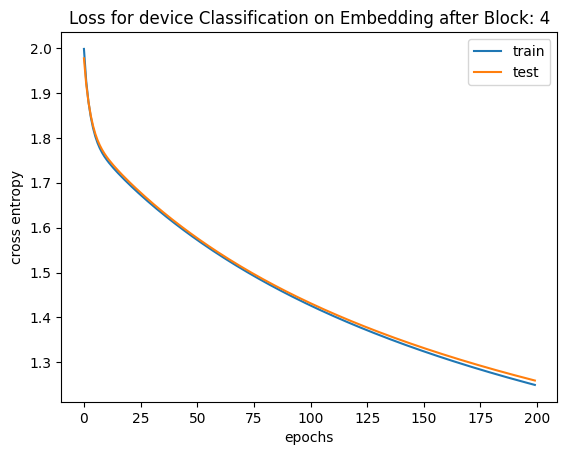

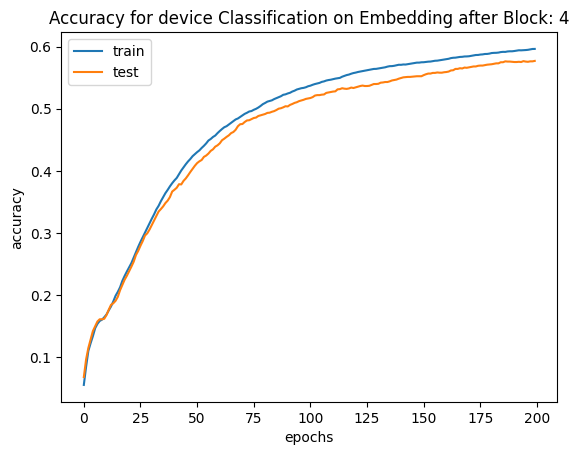

In [82]:
n_epochs = 200
batch_size = b_s
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# # Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters in the model are: {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of paramerters being trained: ", total_trainable_params)

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            labels = np.argmax(y_batch, axis=1)
            loss = criterion(y_pred, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if acc > best_acc:
        best_acc = acc

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)
list_val_acc.append(best_acc)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [83]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [84]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')

In [85]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
)

In [86]:
X_test=train_ready(test_data,col_name)

In [87]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

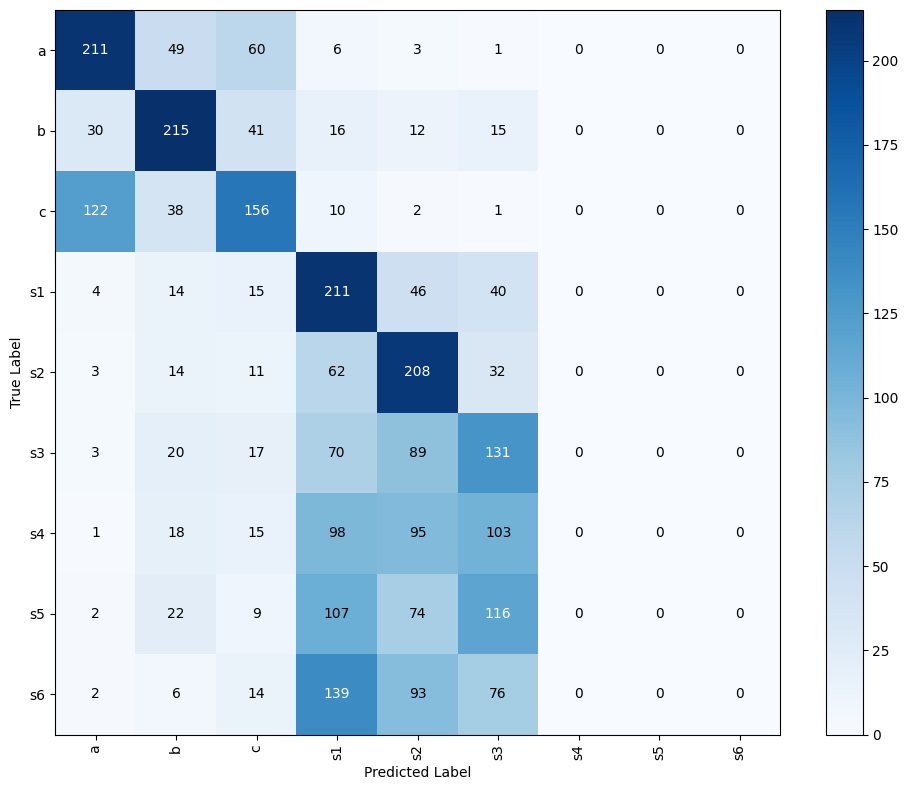

Accuracy: 0.3814


In [88]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-5

In [89]:
Block_number=5

In [90]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth',map_location=torch.device('cpu'))
new_fc3 = nn.Linear(256, 6)

# Replace the existing fc3 layer with the new one
model.fc3 = new_fc3

In [91]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [92]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [93]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [94]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 6)
(2793, 6)


In [95]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 198406
Number of parameters in the last layer is 1542


In [96]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [97]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)

In [98]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 1542


In [99]:
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(weights_array))
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Total number of paramerters in the model are: 198406
Total number of paramerters being trained:  1542


Epoch 0: 100%|██████████| 43/43 [00:00<00:00, 294.57batch/s, acc=0.0781, loss=1.83]


Epoch 0 validation: Cross-entropy=1.86, Accuracy=9.8%


Epoch 1: 100%|██████████| 43/43 [00:00<00:00, 280.67batch/s, acc=0.133, loss=1.8]  


Epoch 1 validation: Cross-entropy=1.82, Accuracy=14.8%


Epoch 2: 100%|██████████| 43/43 [00:00<00:00, 262.26batch/s, acc=0.152, loss=1.79]


Epoch 2 validation: Cross-entropy=1.80, Accuracy=17.8%


Epoch 3: 100%|██████████| 43/43 [00:00<00:00, 496.36batch/s, acc=0.152, loss=1.79]


Epoch 3 validation: Cross-entropy=1.79, Accuracy=19.1%


Epoch 4: 100%|██████████| 43/43 [00:00<00:00, 345.35batch/s, acc=0.172, loss=1.79]


Epoch 4 validation: Cross-entropy=1.78, Accuracy=20.4%


Epoch 5: 100%|██████████| 43/43 [00:00<00:00, 313.26batch/s, acc=0.195, loss=1.79]


Epoch 5 validation: Cross-entropy=1.77, Accuracy=21.5%


Epoch 6: 100%|██████████| 43/43 [00:00<00:00, 543.00batch/s, acc=0.211, loss=1.79]


Epoch 6 validation: Cross-entropy=1.76, Accuracy=22.8%


Epoch 7: 100%|██████████| 43/43 [00:00<00:00, 340.98batch/s, acc=0.238, loss=1.78]


Epoch 7 validation: Cross-entropy=1.75, Accuracy=23.5%


Epoch 8: 100%|██████████| 43/43 [00:00<00:00, 536.59batch/s, acc=0.238, loss=1.78]


Epoch 8 validation: Cross-entropy=1.75, Accuracy=24.3%


Epoch 9: 100%|██████████| 43/43 [00:00<00:00, 270.96batch/s, acc=0.23, loss=1.78] 


Epoch 9 validation: Cross-entropy=1.74, Accuracy=25.2%


Epoch 10: 100%|██████████| 43/43 [00:00<00:00, 467.66batch/s, acc=0.23, loss=1.78] 


Epoch 10 validation: Cross-entropy=1.74, Accuracy=25.9%


Epoch 11: 100%|██████████| 43/43 [00:00<00:00, 517.73batch/s, acc=0.238, loss=1.77]


Epoch 11 validation: Cross-entropy=1.73, Accuracy=26.2%


Epoch 12: 100%|██████████| 43/43 [00:00<00:00, 208.14batch/s, acc=0.25, loss=1.77] 


Epoch 12 validation: Cross-entropy=1.73, Accuracy=27.1%


Epoch 13: 100%|██████████| 43/43 [00:00<00:00, 328.69batch/s, acc=0.258, loss=1.77]


Epoch 13 validation: Cross-entropy=1.72, Accuracy=27.7%


Epoch 14: 100%|██████████| 43/43 [00:00<00:00, 581.65batch/s, acc=0.262, loss=1.76]


Epoch 14 validation: Cross-entropy=1.71, Accuracy=28.5%


Epoch 15: 100%|██████████| 43/43 [00:00<00:00, 331.43batch/s, acc=0.254, loss=1.76]


Epoch 15 validation: Cross-entropy=1.71, Accuracy=29.4%


Epoch 16: 100%|██████████| 43/43 [00:00<00:00, 546.26batch/s, acc=0.258, loss=1.75]


Epoch 16 validation: Cross-entropy=1.70, Accuracy=29.9%


Epoch 17: 100%|██████████| 43/43 [00:00<00:00, 329.63batch/s, acc=0.27, loss=1.75] 


Epoch 17 validation: Cross-entropy=1.70, Accuracy=31.0%


Epoch 18: 100%|██████████| 43/43 [00:00<00:00, 444.74batch/s, acc=0.285, loss=1.74]


Epoch 18 validation: Cross-entropy=1.69, Accuracy=31.9%


Epoch 19: 100%|██████████| 43/43 [00:00<00:00, 264.38batch/s, acc=0.289, loss=1.74]


Epoch 19 validation: Cross-entropy=1.69, Accuracy=32.5%


Epoch 20: 100%|██████████| 43/43 [00:00<00:00, 318.33batch/s, acc=0.293, loss=1.73]


Epoch 20 validation: Cross-entropy=1.68, Accuracy=33.1%


Epoch 21: 100%|██████████| 43/43 [00:00<00:00, 367.40batch/s, acc=0.301, loss=1.73]


Epoch 21 validation: Cross-entropy=1.68, Accuracy=33.7%


Epoch 22: 100%|██████████| 43/43 [00:00<00:00, 329.95batch/s, acc=0.301, loss=1.73]


Epoch 22 validation: Cross-entropy=1.68, Accuracy=34.7%


Epoch 23: 100%|██████████| 43/43 [00:00<00:00, 324.54batch/s, acc=0.305, loss=1.72]


Epoch 23 validation: Cross-entropy=1.67, Accuracy=35.2%


Epoch 24: 100%|██████████| 43/43 [00:00<00:00, 308.45batch/s, acc=0.328, loss=1.72]


Epoch 24 validation: Cross-entropy=1.67, Accuracy=35.7%


Epoch 25: 100%|██████████| 43/43 [00:00<00:00, 483.85batch/s, acc=0.332, loss=1.71]


Epoch 25 validation: Cross-entropy=1.66, Accuracy=36.3%


Epoch 26: 100%|██████████| 43/43 [00:00<00:00, 400.67batch/s, acc=0.332, loss=1.71]


Epoch 26 validation: Cross-entropy=1.66, Accuracy=36.7%


Epoch 27: 100%|██████████| 43/43 [00:00<00:00, 276.55batch/s, acc=0.336, loss=1.7] 


Epoch 27 validation: Cross-entropy=1.65, Accuracy=37.1%


Epoch 28: 100%|██████████| 43/43 [00:00<00:00, 472.38batch/s, acc=0.344, loss=1.7] 


Epoch 28 validation: Cross-entropy=1.65, Accuracy=37.7%


Epoch 29: 100%|██████████| 43/43 [00:00<00:00, 533.79batch/s, acc=0.34, loss=1.69] 


Epoch 29 validation: Cross-entropy=1.64, Accuracy=38.3%


Epoch 30: 100%|██████████| 43/43 [00:00<00:00, 266.53batch/s, acc=0.355, loss=1.69]


Epoch 30 validation: Cross-entropy=1.64, Accuracy=39.2%


Epoch 31: 100%|██████████| 43/43 [00:00<00:00, 406.64batch/s, acc=0.359, loss=1.68]


Epoch 31 validation: Cross-entropy=1.64, Accuracy=39.8%


Epoch 32: 100%|██████████| 43/43 [00:00<00:00, 545.98batch/s, acc=0.359, loss=1.68]


Epoch 32 validation: Cross-entropy=1.63, Accuracy=40.2%


Epoch 33: 100%|██████████| 43/43 [00:00<00:00, 298.05batch/s, acc=0.371, loss=1.68]


Epoch 33 validation: Cross-entropy=1.63, Accuracy=40.7%


Epoch 34: 100%|██████████| 43/43 [00:00<00:00, 551.64batch/s, acc=0.375, loss=1.67]


Epoch 34 validation: Cross-entropy=1.62, Accuracy=41.1%


Epoch 35: 100%|██████████| 43/43 [00:00<00:00, 534.33batch/s, acc=0.391, loss=1.67]


Epoch 35 validation: Cross-entropy=1.62, Accuracy=41.2%


Epoch 36: 100%|██████████| 43/43 [00:00<00:00, 313.38batch/s, acc=0.391, loss=1.66]


Epoch 36 validation: Cross-entropy=1.61, Accuracy=41.5%


Epoch 37: 100%|██████████| 43/43 [00:00<00:00, 528.71batch/s, acc=0.398, loss=1.66]


Epoch 37 validation: Cross-entropy=1.61, Accuracy=41.8%


Epoch 38: 100%|██████████| 43/43 [00:00<00:00, 371.13batch/s, acc=0.395, loss=1.66]


Epoch 38 validation: Cross-entropy=1.61, Accuracy=42.2%


Epoch 39: 100%|██████████| 43/43 [00:00<00:00, 423.22batch/s, acc=0.398, loss=1.65]


Epoch 39 validation: Cross-entropy=1.60, Accuracy=42.4%


Epoch 40: 100%|██████████| 43/43 [00:00<00:00, 511.06batch/s, acc=0.398, loss=1.65]


Epoch 40 validation: Cross-entropy=1.60, Accuracy=42.5%


Epoch 41: 100%|██████████| 43/43 [00:00<00:00, 204.29batch/s, acc=0.406, loss=1.64]


Epoch 41 validation: Cross-entropy=1.60, Accuracy=42.7%


Epoch 42: 100%|██████████| 43/43 [00:00<00:00, 515.38batch/s, acc=0.406, loss=1.64]


Epoch 42 validation: Cross-entropy=1.59, Accuracy=43.0%


Epoch 43: 100%|██████████| 43/43 [00:00<00:00, 289.13batch/s, acc=0.418, loss=1.64]


Epoch 43 validation: Cross-entropy=1.59, Accuracy=43.4%


Epoch 44: 100%|██████████| 43/43 [00:00<00:00, 452.31batch/s, acc=0.418, loss=1.63]


Epoch 44 validation: Cross-entropy=1.58, Accuracy=43.7%


Epoch 45: 100%|██████████| 43/43 [00:00<00:00, 538.67batch/s, acc=0.418, loss=1.63]


Epoch 45 validation: Cross-entropy=1.58, Accuracy=44.0%


Epoch 46: 100%|██████████| 43/43 [00:00<00:00, 258.16batch/s, acc=0.434, loss=1.62]


Epoch 46 validation: Cross-entropy=1.58, Accuracy=44.1%


Epoch 47: 100%|██████████| 43/43 [00:00<00:00, 526.05batch/s, acc=0.434, loss=1.62]


Epoch 47 validation: Cross-entropy=1.57, Accuracy=44.3%


Epoch 48: 100%|██████████| 43/43 [00:00<00:00, 270.21batch/s, acc=0.441, loss=1.62]


Epoch 48 validation: Cross-entropy=1.57, Accuracy=44.8%


Epoch 49: 100%|██████████| 43/43 [00:00<00:00, 462.72batch/s, acc=0.445, loss=1.61]


Epoch 49 validation: Cross-entropy=1.57, Accuracy=45.3%


Epoch 50: 100%|██████████| 43/43 [00:00<00:00, 290.29batch/s, acc=0.445, loss=1.61]


Epoch 50 validation: Cross-entropy=1.56, Accuracy=45.5%


Epoch 51: 100%|██████████| 43/43 [00:00<00:00, 334.41batch/s, acc=0.453, loss=1.61]


Epoch 51 validation: Cross-entropy=1.56, Accuracy=45.8%


Epoch 52: 100%|██████████| 43/43 [00:00<00:00, 502.19batch/s, acc=0.453, loss=1.6] 


Epoch 52 validation: Cross-entropy=1.56, Accuracy=46.1%


Epoch 53: 100%|██████████| 43/43 [00:00<00:00, 276.02batch/s, acc=0.453, loss=1.6] 


Epoch 53 validation: Cross-entropy=1.55, Accuracy=46.3%


Epoch 54: 100%|██████████| 43/43 [00:00<00:00, 468.99batch/s, acc=0.457, loss=1.59]


Epoch 54 validation: Cross-entropy=1.55, Accuracy=46.5%


Epoch 55: 100%|██████████| 43/43 [00:00<00:00, 519.86batch/s, acc=0.457, loss=1.59]


Epoch 55 validation: Cross-entropy=1.55, Accuracy=46.8%


Epoch 56: 100%|██████████| 43/43 [00:00<00:00, 276.79batch/s, acc=0.453, loss=1.59]


Epoch 56 validation: Cross-entropy=1.54, Accuracy=46.9%


Epoch 57: 100%|██████████| 43/43 [00:00<00:00, 480.06batch/s, acc=0.457, loss=1.58]


Epoch 57 validation: Cross-entropy=1.54, Accuracy=47.2%


Epoch 58: 100%|██████████| 43/43 [00:00<00:00, 411.84batch/s, acc=0.453, loss=1.58]


Epoch 58 validation: Cross-entropy=1.54, Accuracy=47.5%


Epoch 59: 100%|██████████| 43/43 [00:00<00:00, 272.22batch/s, acc=0.457, loss=1.58]


Epoch 59 validation: Cross-entropy=1.53, Accuracy=47.6%


Epoch 60: 100%|██████████| 43/43 [00:00<00:00, 568.08batch/s, acc=0.457, loss=1.57]


Epoch 60 validation: Cross-entropy=1.53, Accuracy=47.9%


Epoch 61: 100%|██████████| 43/43 [00:00<00:00, 259.34batch/s, acc=0.457, loss=1.57]


Epoch 61 validation: Cross-entropy=1.53, Accuracy=48.1%


Epoch 62: 100%|██████████| 43/43 [00:00<00:00, 403.65batch/s, acc=0.465, loss=1.57]


Epoch 62 validation: Cross-entropy=1.52, Accuracy=48.3%


Epoch 63: 100%|██████████| 43/43 [00:00<00:00, 523.56batch/s, acc=0.465, loss=1.56]


Epoch 63 validation: Cross-entropy=1.52, Accuracy=48.4%


Epoch 64: 100%|██████████| 43/43 [00:00<00:00, 319.20batch/s, acc=0.461, loss=1.56]


Epoch 64 validation: Cross-entropy=1.52, Accuracy=48.6%


Epoch 65: 100%|██████████| 43/43 [00:00<00:00, 479.42batch/s, acc=0.457, loss=1.56]


Epoch 65 validation: Cross-entropy=1.52, Accuracy=48.8%


Epoch 66: 100%|██████████| 43/43 [00:00<00:00, 308.46batch/s, acc=0.457, loss=1.55]


Epoch 66 validation: Cross-entropy=1.51, Accuracy=48.9%


Epoch 67: 100%|██████████| 43/43 [00:00<00:00, 496.57batch/s, acc=0.457, loss=1.55]


Epoch 67 validation: Cross-entropy=1.51, Accuracy=48.9%


Epoch 68: 100%|██████████| 43/43 [00:00<00:00, 494.79batch/s, acc=0.457, loss=1.55]


Epoch 68 validation: Cross-entropy=1.51, Accuracy=49.1%


Epoch 69: 100%|██████████| 43/43 [00:00<00:00, 347.99batch/s, acc=0.461, loss=1.54]


Epoch 69 validation: Cross-entropy=1.50, Accuracy=49.2%


Epoch 70: 100%|██████████| 43/43 [00:00<00:00, 520.44batch/s, acc=0.457, loss=1.54]


Epoch 70 validation: Cross-entropy=1.50, Accuracy=49.3%


Epoch 71: 100%|██████████| 43/43 [00:00<00:00, 223.70batch/s, acc=0.457, loss=1.54]


Epoch 71 validation: Cross-entropy=1.50, Accuracy=49.5%


Epoch 72: 100%|██████████| 43/43 [00:00<00:00, 483.84batch/s, acc=0.457, loss=1.53]


Epoch 72 validation: Cross-entropy=1.50, Accuracy=49.7%


Epoch 73: 100%|██████████| 43/43 [00:00<00:00, 489.44batch/s, acc=0.461, loss=1.53]


Epoch 73 validation: Cross-entropy=1.49, Accuracy=49.8%


Epoch 74: 100%|██████████| 43/43 [00:00<00:00, 290.35batch/s, acc=0.469, loss=1.53]


Epoch 74 validation: Cross-entropy=1.49, Accuracy=49.9%


Epoch 75: 100%|██████████| 43/43 [00:00<00:00, 551.69batch/s, acc=0.469, loss=1.53]


Epoch 75 validation: Cross-entropy=1.49, Accuracy=50.1%


Epoch 76: 100%|██████████| 43/43 [00:00<00:00, 310.40batch/s, acc=0.477, loss=1.52]


Epoch 76 validation: Cross-entropy=1.48, Accuracy=50.2%


Epoch 77: 100%|██████████| 43/43 [00:00<00:00, 544.68batch/s, acc=0.477, loss=1.52]


Epoch 77 validation: Cross-entropy=1.48, Accuracy=50.2%


Epoch 78: 100%|██████████| 43/43 [00:00<00:00, 281.74batch/s, acc=0.477, loss=1.52]


Epoch 78 validation: Cross-entropy=1.48, Accuracy=50.3%


Epoch 79: 100%|██████████| 43/43 [00:00<00:00, 537.17batch/s, acc=0.48, loss=1.51] 


Epoch 79 validation: Cross-entropy=1.48, Accuracy=50.5%


Epoch 80: 100%|██████████| 43/43 [00:00<00:00, 541.40batch/s, acc=0.48, loss=1.51] 


Epoch 80 validation: Cross-entropy=1.47, Accuracy=50.7%


Epoch 81: 100%|██████████| 43/43 [00:00<00:00, 207.11batch/s, acc=0.48, loss=1.51] 


Epoch 81 validation: Cross-entropy=1.47, Accuracy=50.7%


Epoch 82: 100%|██████████| 43/43 [00:00<00:00, 531.06batch/s, acc=0.48, loss=1.5]  


Epoch 82 validation: Cross-entropy=1.47, Accuracy=50.8%


Epoch 83: 100%|██████████| 43/43 [00:00<00:00, 549.98batch/s, acc=0.484, loss=1.5] 


Epoch 83 validation: Cross-entropy=1.47, Accuracy=50.8%


Epoch 84: 100%|██████████| 43/43 [00:00<00:00, 259.38batch/s, acc=0.488, loss=1.5] 


Epoch 84 validation: Cross-entropy=1.46, Accuracy=51.0%


Epoch 85: 100%|██████████| 43/43 [00:00<00:00, 515.30batch/s, acc=0.488, loss=1.5] 


Epoch 85 validation: Cross-entropy=1.46, Accuracy=51.1%


Epoch 86: 100%|██████████| 43/43 [00:00<00:00, 289.61batch/s, acc=0.488, loss=1.49]


Epoch 86 validation: Cross-entropy=1.46, Accuracy=51.3%


Epoch 87: 100%|██████████| 43/43 [00:00<00:00, 555.10batch/s, acc=0.492, loss=1.49]


Epoch 87 validation: Cross-entropy=1.46, Accuracy=51.5%


Epoch 88: 100%|██████████| 43/43 [00:00<00:00, 328.48batch/s, acc=0.492, loss=1.49]


Epoch 88 validation: Cross-entropy=1.45, Accuracy=51.5%


Epoch 89: 100%|██████████| 43/43 [00:00<00:00, 548.44batch/s, acc=0.492, loss=1.49]


Epoch 89 validation: Cross-entropy=1.45, Accuracy=51.8%


Epoch 90: 100%|██████████| 43/43 [00:00<00:00, 501.04batch/s, acc=0.496, loss=1.48]


Epoch 90 validation: Cross-entropy=1.45, Accuracy=51.6%


Epoch 91: 100%|██████████| 43/43 [00:00<00:00, 298.60batch/s, acc=0.5, loss=1.48]  


Epoch 91 validation: Cross-entropy=1.45, Accuracy=51.8%


Epoch 92: 100%|██████████| 43/43 [00:00<00:00, 510.63batch/s, acc=0.496, loss=1.48]


Epoch 92 validation: Cross-entropy=1.44, Accuracy=52.0%


Epoch 93: 100%|██████████| 43/43 [00:00<00:00, 526.41batch/s, acc=0.496, loss=1.47]


Epoch 93 validation: Cross-entropy=1.44, Accuracy=52.1%


Epoch 94: 100%|██████████| 43/43 [00:00<00:00, 551.99batch/s, acc=0.5, loss=1.47]  


Epoch 94 validation: Cross-entropy=1.44, Accuracy=52.1%


Epoch 95: 100%|██████████| 43/43 [00:00<00:00, 317.68batch/s, acc=0.5, loss=1.47]  


Epoch 95 validation: Cross-entropy=1.44, Accuracy=52.2%


Epoch 96: 100%|██████████| 43/43 [00:00<00:00, 568.01batch/s, acc=0.5, loss=1.47]  


Epoch 96 validation: Cross-entropy=1.43, Accuracy=52.3%


Epoch 97: 100%|██████████| 43/43 [00:00<00:00, 331.67batch/s, acc=0.5, loss=1.46]  


Epoch 97 validation: Cross-entropy=1.43, Accuracy=52.4%


Epoch 98: 100%|██████████| 43/43 [00:00<00:00, 519.10batch/s, acc=0.496, loss=1.46]


Epoch 98 validation: Cross-entropy=1.43, Accuracy=52.6%


Epoch 99: 100%|██████████| 43/43 [00:00<00:00, 571.47batch/s, acc=0.504, loss=1.46]


Epoch 99 validation: Cross-entropy=1.43, Accuracy=52.7%


Epoch 100: 100%|██████████| 43/43 [00:00<00:00, 323.28batch/s, acc=0.504, loss=1.46]


Epoch 100 validation: Cross-entropy=1.42, Accuracy=52.8%


Epoch 101: 100%|██████████| 43/43 [00:00<00:00, 421.21batch/s, acc=0.508, loss=1.45]


Epoch 101 validation: Cross-entropy=1.42, Accuracy=52.9%


Epoch 102: 100%|██████████| 43/43 [00:00<00:00, 323.01batch/s, acc=0.508, loss=1.45]


Epoch 102 validation: Cross-entropy=1.42, Accuracy=53.1%


Epoch 103: 100%|██████████| 43/43 [00:00<00:00, 552.76batch/s, acc=0.508, loss=1.45]


Epoch 103 validation: Cross-entropy=1.42, Accuracy=53.1%


Epoch 104: 100%|██████████| 43/43 [00:00<00:00, 574.77batch/s, acc=0.508, loss=1.45]


Epoch 104 validation: Cross-entropy=1.42, Accuracy=53.1%


Epoch 105: 100%|██████████| 43/43 [00:00<00:00, 282.21batch/s, acc=0.508, loss=1.44]


Epoch 105 validation: Cross-entropy=1.41, Accuracy=53.3%


Epoch 106: 100%|██████████| 43/43 [00:00<00:00, 509.59batch/s, acc=0.508, loss=1.44]


Epoch 106 validation: Cross-entropy=1.41, Accuracy=53.3%


Epoch 107: 100%|██████████| 43/43 [00:00<00:00, 305.48batch/s, acc=0.512, loss=1.44]


Epoch 107 validation: Cross-entropy=1.41, Accuracy=53.5%


Epoch 108: 100%|██████████| 43/43 [00:00<00:00, 517.68batch/s, acc=0.516, loss=1.44]


Epoch 108 validation: Cross-entropy=1.41, Accuracy=53.5%


Epoch 109: 100%|██████████| 43/43 [00:00<00:00, 343.06batch/s, acc=0.52, loss=1.43] 


Epoch 109 validation: Cross-entropy=1.40, Accuracy=53.4%


Epoch 110: 100%|██████████| 43/43 [00:00<00:00, 522.76batch/s, acc=0.523, loss=1.43]


Epoch 110 validation: Cross-entropy=1.40, Accuracy=53.5%


Epoch 111: 100%|██████████| 43/43 [00:00<00:00, 241.54batch/s, acc=0.523, loss=1.43]


Epoch 111 validation: Cross-entropy=1.40, Accuracy=53.5%


Epoch 112: 100%|██████████| 43/43 [00:00<00:00, 590.07batch/s, acc=0.523, loss=1.43]


Epoch 112 validation: Cross-entropy=1.40, Accuracy=53.5%


Epoch 113: 100%|██████████| 43/43 [00:00<00:00, 552.16batch/s, acc=0.523, loss=1.42]


Epoch 113 validation: Cross-entropy=1.40, Accuracy=53.5%


Epoch 114: 100%|██████████| 43/43 [00:00<00:00, 328.86batch/s, acc=0.523, loss=1.42]


Epoch 114 validation: Cross-entropy=1.39, Accuracy=53.6%


Epoch 115: 100%|██████████| 43/43 [00:00<00:00, 558.48batch/s, acc=0.531, loss=1.42]


Epoch 115 validation: Cross-entropy=1.39, Accuracy=53.7%


Epoch 116: 100%|██████████| 43/43 [00:00<00:00, 609.52batch/s, acc=0.531, loss=1.42]


Epoch 116 validation: Cross-entropy=1.39, Accuracy=53.8%


Epoch 117: 100%|██████████| 43/43 [00:00<00:00, 297.82batch/s, acc=0.535, loss=1.41]


Epoch 117 validation: Cross-entropy=1.39, Accuracy=54.0%


Epoch 118: 100%|██████████| 43/43 [00:00<00:00, 518.67batch/s, acc=0.535, loss=1.41]


Epoch 118 validation: Cross-entropy=1.39, Accuracy=54.0%


Epoch 119: 100%|██████████| 43/43 [00:00<00:00, 571.81batch/s, acc=0.535, loss=1.41]


Epoch 119 validation: Cross-entropy=1.38, Accuracy=54.2%


Epoch 120: 100%|██████████| 43/43 [00:00<00:00, 338.75batch/s, acc=0.535, loss=1.41]


Epoch 120 validation: Cross-entropy=1.38, Accuracy=54.4%


Epoch 121: 100%|██████████| 43/43 [00:00<00:00, 362.40batch/s, acc=0.539, loss=1.41]


Epoch 121 validation: Cross-entropy=1.38, Accuracy=54.4%


Epoch 122: 100%|██████████| 43/43 [00:00<00:00, 329.49batch/s, acc=0.539, loss=1.4] 


Epoch 122 validation: Cross-entropy=1.38, Accuracy=54.6%


Epoch 123: 100%|██████████| 43/43 [00:00<00:00, 565.88batch/s, acc=0.539, loss=1.4] 


Epoch 123 validation: Cross-entropy=1.38, Accuracy=54.5%


Epoch 124: 100%|██████████| 43/43 [00:00<00:00, 344.59batch/s, acc=0.539, loss=1.4] 


Epoch 124 validation: Cross-entropy=1.37, Accuracy=54.5%


Epoch 125: 100%|██████████| 43/43 [00:00<00:00, 532.03batch/s, acc=0.539, loss=1.4] 


Epoch 125 validation: Cross-entropy=1.37, Accuracy=54.6%


Epoch 126: 100%|██████████| 43/43 [00:00<00:00, 560.92batch/s, acc=0.539, loss=1.39]


Epoch 126 validation: Cross-entropy=1.37, Accuracy=54.7%


Epoch 127: 100%|██████████| 43/43 [00:00<00:00, 339.41batch/s, acc=0.543, loss=1.39]


Epoch 127 validation: Cross-entropy=1.37, Accuracy=54.6%


Epoch 128: 100%|██████████| 43/43 [00:00<00:00, 529.37batch/s, acc=0.543, loss=1.39]


Epoch 128 validation: Cross-entropy=1.37, Accuracy=54.7%


Epoch 129: 100%|██████████| 43/43 [00:00<00:00, 563.73batch/s, acc=0.547, loss=1.39]


Epoch 129 validation: Cross-entropy=1.36, Accuracy=54.8%


Epoch 130: 100%|██████████| 43/43 [00:00<00:00, 372.78batch/s, acc=0.547, loss=1.39]


Epoch 130 validation: Cross-entropy=1.36, Accuracy=54.8%


Epoch 131: 100%|██████████| 43/43 [00:00<00:00, 362.23batch/s, acc=0.551, loss=1.38]


Epoch 131 validation: Cross-entropy=1.36, Accuracy=55.0%


Epoch 132: 100%|██████████| 43/43 [00:00<00:00, 560.64batch/s, acc=0.551, loss=1.38]


Epoch 132 validation: Cross-entropy=1.36, Accuracy=55.0%


Epoch 133: 100%|██████████| 43/43 [00:00<00:00, 575.26batch/s, acc=0.555, loss=1.38]


Epoch 133 validation: Cross-entropy=1.36, Accuracy=55.0%


Epoch 134: 100%|██████████| 43/43 [00:00<00:00, 320.46batch/s, acc=0.559, loss=1.38]


Epoch 134 validation: Cross-entropy=1.35, Accuracy=55.1%


Epoch 135: 100%|██████████| 43/43 [00:00<00:00, 554.59batch/s, acc=0.559, loss=1.38]


Epoch 135 validation: Cross-entropy=1.35, Accuracy=55.1%


Epoch 136: 100%|██████████| 43/43 [00:00<00:00, 597.41batch/s, acc=0.559, loss=1.37]


Epoch 136 validation: Cross-entropy=1.35, Accuracy=55.1%


Epoch 137: 100%|██████████| 43/43 [00:00<00:00, 335.24batch/s, acc=0.559, loss=1.37]


Epoch 137 validation: Cross-entropy=1.35, Accuracy=55.2%


Epoch 138: 100%|██████████| 43/43 [00:00<00:00, 548.38batch/s, acc=0.559, loss=1.37]


Epoch 138 validation: Cross-entropy=1.35, Accuracy=55.3%


Epoch 139: 100%|██████████| 43/43 [00:00<00:00, 585.22batch/s, acc=0.559, loss=1.37]


Epoch 139 validation: Cross-entropy=1.35, Accuracy=55.3%


Epoch 140: 100%|██████████| 43/43 [00:00<00:00, 340.65batch/s, acc=0.559, loss=1.37]


Epoch 140 validation: Cross-entropy=1.34, Accuracy=55.4%


Epoch 141: 100%|██████████| 43/43 [00:00<00:00, 382.04batch/s, acc=0.559, loss=1.36]


Epoch 141 validation: Cross-entropy=1.34, Accuracy=55.5%


Epoch 142: 100%|██████████| 43/43 [00:00<00:00, 309.90batch/s, acc=0.559, loss=1.36]


Epoch 142 validation: Cross-entropy=1.34, Accuracy=55.5%


Epoch 143: 100%|██████████| 43/43 [00:00<00:00, 607.81batch/s, acc=0.559, loss=1.36]


Epoch 143 validation: Cross-entropy=1.34, Accuracy=55.5%


Epoch 144: 100%|██████████| 43/43 [00:00<00:00, 554.36batch/s, acc=0.559, loss=1.36]


Epoch 144 validation: Cross-entropy=1.34, Accuracy=55.5%


Epoch 145: 100%|██████████| 43/43 [00:00<00:00, 338.84batch/s, acc=0.559, loss=1.36]


Epoch 145 validation: Cross-entropy=1.34, Accuracy=55.6%


Epoch 146: 100%|██████████| 43/43 [00:00<00:00, 592.63batch/s, acc=0.559, loss=1.35]


Epoch 146 validation: Cross-entropy=1.33, Accuracy=55.7%


Epoch 147: 100%|██████████| 43/43 [00:00<00:00, 555.55batch/s, acc=0.559, loss=1.35]


Epoch 147 validation: Cross-entropy=1.33, Accuracy=55.7%


Epoch 148: 100%|██████████| 43/43 [00:00<00:00, 314.74batch/s, acc=0.559, loss=1.35]


Epoch 148 validation: Cross-entropy=1.33, Accuracy=55.8%


Epoch 149: 100%|██████████| 43/43 [00:00<00:00, 586.70batch/s, acc=0.559, loss=1.35]


Epoch 149 validation: Cross-entropy=1.33, Accuracy=55.7%


Epoch 150: 100%|██████████| 43/43 [00:00<00:00, 585.27batch/s, acc=0.559, loss=1.35]


Epoch 150 validation: Cross-entropy=1.33, Accuracy=55.8%


Epoch 151: 100%|██████████| 43/43 [00:00<00:00, 313.26batch/s, acc=0.559, loss=1.34]


Epoch 151 validation: Cross-entropy=1.33, Accuracy=55.9%


Epoch 152: 100%|██████████| 43/43 [00:00<00:00, 484.85batch/s, acc=0.559, loss=1.34]


Epoch 152 validation: Cross-entropy=1.32, Accuracy=55.9%


Epoch 153: 100%|██████████| 43/43 [00:00<00:00, 574.67batch/s, acc=0.559, loss=1.34]


Epoch 153 validation: Cross-entropy=1.32, Accuracy=56.0%


Epoch 154: 100%|██████████| 43/43 [00:00<00:00, 320.05batch/s, acc=0.559, loss=1.34]


Epoch 154 validation: Cross-entropy=1.32, Accuracy=56.1%


Epoch 155: 100%|██████████| 43/43 [00:00<00:00, 551.46batch/s, acc=0.559, loss=1.34]


Epoch 155 validation: Cross-entropy=1.32, Accuracy=56.1%


Epoch 156: 100%|██████████| 43/43 [00:00<00:00, 547.28batch/s, acc=0.559, loss=1.33]


Epoch 156 validation: Cross-entropy=1.32, Accuracy=56.0%


Epoch 157: 100%|██████████| 43/43 [00:00<00:00, 287.64batch/s, acc=0.559, loss=1.33]


Epoch 157 validation: Cross-entropy=1.32, Accuracy=56.1%


Epoch 158: 100%|██████████| 43/43 [00:00<00:00, 537.00batch/s, acc=0.555, loss=1.33]


Epoch 158 validation: Cross-entropy=1.31, Accuracy=56.2%


Epoch 159: 100%|██████████| 43/43 [00:00<00:00, 311.09batch/s, acc=0.555, loss=1.33]


Epoch 159 validation: Cross-entropy=1.31, Accuracy=56.3%


Epoch 160: 100%|██████████| 43/43 [00:00<00:00, 489.82batch/s, acc=0.555, loss=1.33]


Epoch 160 validation: Cross-entropy=1.31, Accuracy=56.4%


Epoch 161: 100%|██████████| 43/43 [00:00<00:00, 232.09batch/s, acc=0.559, loss=1.33]


Epoch 161 validation: Cross-entropy=1.31, Accuracy=56.6%


Epoch 162: 100%|██████████| 43/43 [00:00<00:00, 513.16batch/s, acc=0.559, loss=1.32]


Epoch 162 validation: Cross-entropy=1.31, Accuracy=56.6%


Epoch 163: 100%|██████████| 43/43 [00:00<00:00, 577.43batch/s, acc=0.559, loss=1.32]


Epoch 163 validation: Cross-entropy=1.31, Accuracy=56.6%


Epoch 164: 100%|██████████| 43/43 [00:00<00:00, 310.82batch/s, acc=0.559, loss=1.32]


Epoch 164 validation: Cross-entropy=1.30, Accuracy=56.7%


Epoch 165: 100%|██████████| 43/43 [00:00<00:00, 584.69batch/s, acc=0.559, loss=1.32]


Epoch 165 validation: Cross-entropy=1.30, Accuracy=56.8%


Epoch 166: 100%|██████████| 43/43 [00:00<00:00, 563.28batch/s, acc=0.562, loss=1.32]


Epoch 166 validation: Cross-entropy=1.30, Accuracy=56.9%


Epoch 167: 100%|██████████| 43/43 [00:00<00:00, 298.60batch/s, acc=0.562, loss=1.31]


Epoch 167 validation: Cross-entropy=1.30, Accuracy=57.0%


Epoch 168: 100%|██████████| 43/43 [00:00<00:00, 536.10batch/s, acc=0.562, loss=1.31]


Epoch 168 validation: Cross-entropy=1.30, Accuracy=57.0%


Epoch 169: 100%|██████████| 43/43 [00:00<00:00, 570.15batch/s, acc=0.562, loss=1.31]


Epoch 169 validation: Cross-entropy=1.30, Accuracy=57.1%


Epoch 170: 100%|██████████| 43/43 [00:00<00:00, 309.61batch/s, acc=0.562, loss=1.31]


Epoch 170 validation: Cross-entropy=1.30, Accuracy=57.2%


Epoch 171: 100%|██████████| 43/43 [00:00<00:00, 570.15batch/s, acc=0.562, loss=1.31]


Epoch 171 validation: Cross-entropy=1.29, Accuracy=57.2%


Epoch 172: 100%|██████████| 43/43 [00:00<00:00, 404.37batch/s, acc=0.562, loss=1.31]


Epoch 172 validation: Cross-entropy=1.29, Accuracy=57.3%


Epoch 173: 100%|██████████| 43/43 [00:00<00:00, 316.31batch/s, acc=0.562, loss=1.3] 


Epoch 173 validation: Cross-entropy=1.29, Accuracy=57.4%


Epoch 174: 100%|██████████| 43/43 [00:00<00:00, 470.23batch/s, acc=0.562, loss=1.3] 


Epoch 174 validation: Cross-entropy=1.29, Accuracy=57.3%


Epoch 175: 100%|██████████| 43/43 [00:00<00:00, 260.72batch/s, acc=0.562, loss=1.3] 


Epoch 175 validation: Cross-entropy=1.29, Accuracy=57.4%


Epoch 176: 100%|██████████| 43/43 [00:00<00:00, 490.51batch/s, acc=0.562, loss=1.3] 


Epoch 176 validation: Cross-entropy=1.29, Accuracy=57.4%


Epoch 177: 100%|██████████| 43/43 [00:00<00:00, 296.31batch/s, acc=0.562, loss=1.3] 


Epoch 177 validation: Cross-entropy=1.28, Accuracy=57.4%


Epoch 178: 100%|██████████| 43/43 [00:00<00:00, 462.40batch/s, acc=0.562, loss=1.3] 


Epoch 178 validation: Cross-entropy=1.28, Accuracy=57.5%


Epoch 179: 100%|██████████| 43/43 [00:00<00:00, 502.85batch/s, acc=0.562, loss=1.29]


Epoch 179 validation: Cross-entropy=1.28, Accuracy=57.5%


Epoch 180: 100%|██████████| 43/43 [00:00<00:00, 511.98batch/s, acc=0.562, loss=1.29]


Epoch 180 validation: Cross-entropy=1.28, Accuracy=57.5%


Epoch 181: 100%|██████████| 43/43 [00:00<00:00, 212.46batch/s, acc=0.562, loss=1.29]


Epoch 181 validation: Cross-entropy=1.28, Accuracy=57.6%


Epoch 182: 100%|██████████| 43/43 [00:00<00:00, 512.47batch/s, acc=0.562, loss=1.29]


Epoch 182 validation: Cross-entropy=1.28, Accuracy=57.8%


Epoch 183: 100%|██████████| 43/43 [00:00<00:00, 549.22batch/s, acc=0.562, loss=1.29]


Epoch 183 validation: Cross-entropy=1.28, Accuracy=57.9%


Epoch 184: 100%|██████████| 43/43 [00:00<00:00, 312.68batch/s, acc=0.566, loss=1.29]


Epoch 184 validation: Cross-entropy=1.28, Accuracy=57.9%


Epoch 185: 100%|██████████| 43/43 [00:00<00:00, 482.69batch/s, acc=0.566, loss=1.29]


Epoch 185 validation: Cross-entropy=1.27, Accuracy=57.9%


Epoch 186: 100%|██████████| 43/43 [00:00<00:00, 489.27batch/s, acc=0.566, loss=1.28]


Epoch 186 validation: Cross-entropy=1.27, Accuracy=57.9%


Epoch 187: 100%|██████████| 43/43 [00:00<00:00, 515.23batch/s, acc=0.57, loss=1.28] 


Epoch 187 validation: Cross-entropy=1.27, Accuracy=58.0%


Epoch 188: 100%|██████████| 43/43 [00:00<00:00, 378.14batch/s, acc=0.57, loss=1.28] 


Epoch 188 validation: Cross-entropy=1.27, Accuracy=57.9%


Epoch 189: 100%|██████████| 43/43 [00:00<00:00, 356.60batch/s, acc=0.574, loss=1.28]


Epoch 189 validation: Cross-entropy=1.27, Accuracy=58.0%


Epoch 190: 100%|██████████| 43/43 [00:00<00:00, 499.66batch/s, acc=0.574, loss=1.28]


Epoch 190 validation: Cross-entropy=1.27, Accuracy=58.0%


Epoch 191: 100%|██████████| 43/43 [00:00<00:00, 274.55batch/s, acc=0.574, loss=1.28]


Epoch 191 validation: Cross-entropy=1.27, Accuracy=58.1%


Epoch 192: 100%|██████████| 43/43 [00:00<00:00, 470.71batch/s, acc=0.578, loss=1.27]


Epoch 192 validation: Cross-entropy=1.26, Accuracy=58.1%


Epoch 193: 100%|██████████| 43/43 [00:00<00:00, 520.22batch/s, acc=0.578, loss=1.27]


Epoch 193 validation: Cross-entropy=1.26, Accuracy=58.1%


Epoch 194: 100%|██████████| 43/43 [00:00<00:00, 293.77batch/s, acc=0.582, loss=1.27]


Epoch 194 validation: Cross-entropy=1.26, Accuracy=58.2%


Epoch 195: 100%|██████████| 43/43 [00:00<00:00, 432.25batch/s, acc=0.582, loss=1.27]


Epoch 195 validation: Cross-entropy=1.26, Accuracy=58.3%


Epoch 196: 100%|██████████| 43/43 [00:00<00:00, 529.84batch/s, acc=0.582, loss=1.27]


Epoch 196 validation: Cross-entropy=1.26, Accuracy=58.3%


Epoch 197: 100%|██████████| 43/43 [00:00<00:00, 272.48batch/s, acc=0.582, loss=1.27]


Epoch 197 validation: Cross-entropy=1.26, Accuracy=58.4%


Epoch 198: 100%|██████████| 43/43 [00:00<00:00, 269.81batch/s, acc=0.582, loss=1.27]


Epoch 198 validation: Cross-entropy=1.26, Accuracy=58.5%


Epoch 199: 100%|██████████| 43/43 [00:00<00:00, 475.49batch/s, acc=0.586, loss=1.26]


Epoch 199 validation: Cross-entropy=1.25, Accuracy=58.5%


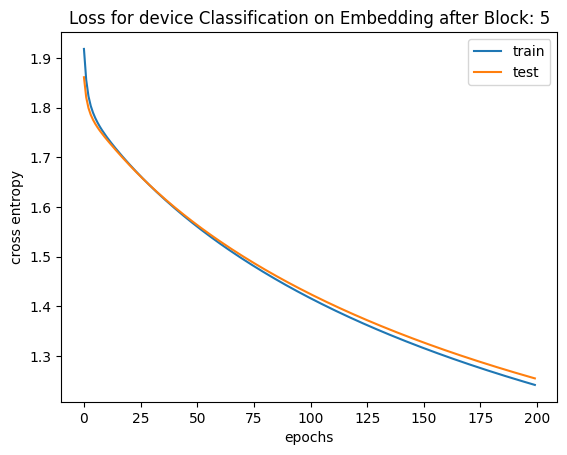

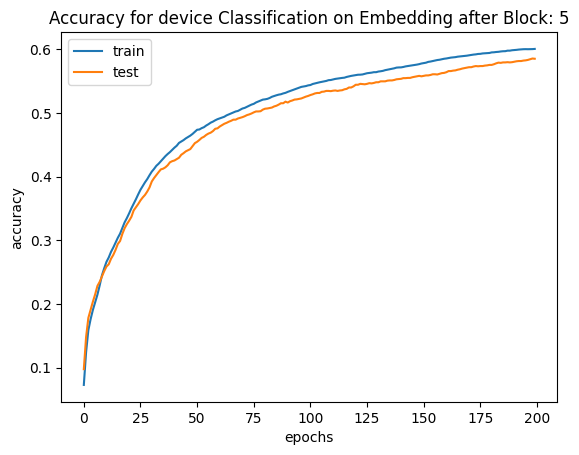

In [100]:
n_epochs = 200
batch_size = b_s
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# # Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters in the model are: {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of paramerters being trained: ", total_trainable_params)

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            labels = np.argmax(y_batch, axis=1)
            loss = criterion(y_pred, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if acc > best_acc:
        best_acc = acc

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)
list_val_acc.append(best_acc)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [101]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [102]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')

In [103]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
)

In [104]:
X_test=train_ready(test_data,col_name)

In [105]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

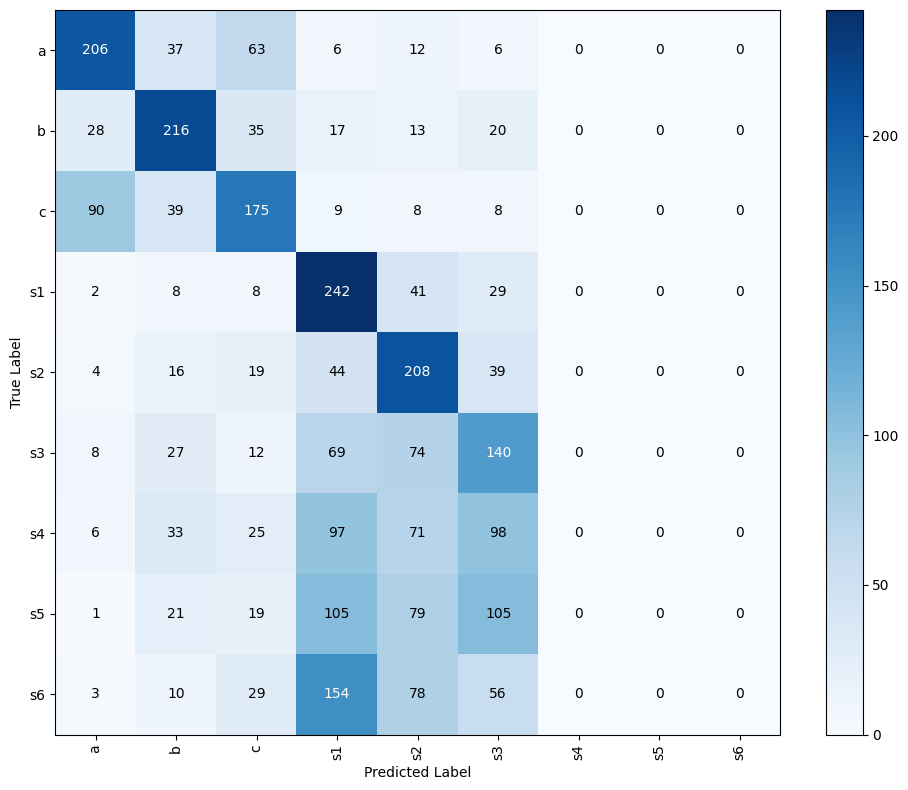

Accuracy: 0.3999


In [106]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-6

In [107]:
Block_number=6

In [108]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth',map_location=torch.device('cpu'))
new_fc3 = nn.Linear(256, 6)

# Replace the existing fc3 layer with the new one
model.fc3 = new_fc3

In [109]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [110]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [111]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [112]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 6)
(2793, 6)


In [113]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 198406
Number of parameters in the last layer is 1542


In [114]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [115]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)

In [116]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 1542


In [117]:
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(weights_array))
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Total number of paramerters in the model are: 198406
Total number of paramerters being trained:  1542


Epoch 0: 100%|██████████| 43/43 [00:00<00:00, 351.41batch/s, acc=0.328, loss=2.08]


Epoch 0 validation: Cross-entropy=2.22, Accuracy=31.1%


Epoch 1: 100%|██████████| 43/43 [00:00<00:00, 306.60batch/s, acc=0.324, loss=1.99]


Epoch 1 validation: Cross-entropy=2.08, Accuracy=31.7%


Epoch 2: 100%|██████████| 43/43 [00:00<00:00, 344.58batch/s, acc=0.324, loss=1.93]


Epoch 2 validation: Cross-entropy=1.98, Accuracy=32.2%


Epoch 3: 100%|██████████| 43/43 [00:00<00:00, 304.90batch/s, acc=0.32, loss=1.9]  


Epoch 3 validation: Cross-entropy=1.91, Accuracy=32.3%


Epoch 4: 100%|██████████| 43/43 [00:00<00:00, 522.71batch/s, acc=0.301, loss=1.87]


Epoch 4 validation: Cross-entropy=1.87, Accuracy=32.3%


Epoch 5: 100%|██████████| 43/43 [00:00<00:00, 533.70batch/s, acc=0.309, loss=1.86]


Epoch 5 validation: Cross-entropy=1.83, Accuracy=33.2%


Epoch 6: 100%|██████████| 43/43 [00:00<00:00, 392.24batch/s, acc=0.328, loss=1.85]


Epoch 6 validation: Cross-entropy=1.81, Accuracy=33.4%


Epoch 7: 100%|██████████| 43/43 [00:00<00:00, 403.74batch/s, acc=0.352, loss=1.84]


Epoch 7 validation: Cross-entropy=1.79, Accuracy=33.7%


Epoch 8: 100%|██████████| 43/43 [00:00<00:00, 216.92batch/s, acc=0.332, loss=1.83]


Epoch 8 validation: Cross-entropy=1.77, Accuracy=34.5%


Epoch 9: 100%|██████████| 43/43 [00:00<00:00, 540.37batch/s, acc=0.32, loss=1.82] 


Epoch 9 validation: Cross-entropy=1.76, Accuracy=34.4%


Epoch 10: 100%|██████████| 43/43 [00:00<00:00, 299.69batch/s, acc=0.328, loss=1.81]


Epoch 10 validation: Cross-entropy=1.75, Accuracy=34.3%


Epoch 11: 100%|██████████| 43/43 [00:00<00:00, 541.26batch/s, acc=0.316, loss=1.81]


Epoch 11 validation: Cross-entropy=1.74, Accuracy=34.5%


Epoch 12: 100%|██████████| 43/43 [00:00<00:00, 550.48batch/s, acc=0.312, loss=1.8] 


Epoch 12 validation: Cross-entropy=1.73, Accuracy=34.6%


Epoch 13: 100%|██████████| 43/43 [00:00<00:00, 308.02batch/s, acc=0.312, loss=1.79]


Epoch 13 validation: Cross-entropy=1.72, Accuracy=34.4%


Epoch 14: 100%|██████████| 43/43 [00:00<00:00, 492.95batch/s, acc=0.305, loss=1.79]


Epoch 14 validation: Cross-entropy=1.72, Accuracy=34.5%


Epoch 15: 100%|██████████| 43/43 [00:00<00:00, 259.11batch/s, acc=0.301, loss=1.78]


Epoch 15 validation: Cross-entropy=1.71, Accuracy=34.2%


Epoch 16: 100%|██████████| 43/43 [00:00<00:00, 568.67batch/s, acc=0.301, loss=1.78]


Epoch 16 validation: Cross-entropy=1.70, Accuracy=34.3%


Epoch 17: 100%|██████████| 43/43 [00:00<00:00, 322.06batch/s, acc=0.301, loss=1.77]


Epoch 17 validation: Cross-entropy=1.70, Accuracy=35.0%


Epoch 18: 100%|██████████| 43/43 [00:00<00:00, 547.77batch/s, acc=0.297, loss=1.76]


Epoch 18 validation: Cross-entropy=1.69, Accuracy=35.5%


Epoch 19: 100%|██████████| 43/43 [00:00<00:00, 585.41batch/s, acc=0.305, loss=1.76]


Epoch 19 validation: Cross-entropy=1.69, Accuracy=36.2%


Epoch 20: 100%|██████████| 43/43 [00:00<00:00, 368.60batch/s, acc=0.316, loss=1.75]


Epoch 20 validation: Cross-entropy=1.68, Accuracy=36.8%


Epoch 21: 100%|██████████| 43/43 [00:00<00:00, 588.69batch/s, acc=0.328, loss=1.74]


Epoch 21 validation: Cross-entropy=1.68, Accuracy=37.2%


Epoch 22: 100%|██████████| 43/43 [00:00<00:00, 376.48batch/s, acc=0.34, loss=1.74] 


Epoch 22 validation: Cross-entropy=1.67, Accuracy=37.9%


Epoch 23: 100%|██████████| 43/43 [00:00<00:00, 404.87batch/s, acc=0.34, loss=1.73] 


Epoch 23 validation: Cross-entropy=1.67, Accuracy=38.3%


Epoch 24: 100%|██████████| 43/43 [00:00<00:00, 537.65batch/s, acc=0.34, loss=1.73] 


Epoch 24 validation: Cross-entropy=1.66, Accuracy=39.2%


Epoch 25: 100%|██████████| 43/43 [00:00<00:00, 248.20batch/s, acc=0.344, loss=1.72]


Epoch 25 validation: Cross-entropy=1.66, Accuracy=39.5%


Epoch 26: 100%|██████████| 43/43 [00:00<00:00, 336.49batch/s, acc=0.34, loss=1.71] 


Epoch 26 validation: Cross-entropy=1.65, Accuracy=40.1%


Epoch 27: 100%|██████████| 43/43 [00:00<00:00, 524.60batch/s, acc=0.352, loss=1.71]


Epoch 27 validation: Cross-entropy=1.64, Accuracy=40.8%


Epoch 28: 100%|██████████| 43/43 [00:00<00:00, 539.05batch/s, acc=0.352, loss=1.7] 


Epoch 28 validation: Cross-entropy=1.64, Accuracy=41.7%


Epoch 29: 100%|██████████| 43/43 [00:00<00:00, 301.91batch/s, acc=0.355, loss=1.7] 


Epoch 29 validation: Cross-entropy=1.63, Accuracy=42.0%


Epoch 30: 100%|██████████| 43/43 [00:00<00:00, 598.49batch/s, acc=0.355, loss=1.69]


Epoch 30 validation: Cross-entropy=1.63, Accuracy=42.4%


Epoch 31: 100%|██████████| 43/43 [00:00<00:00, 582.68batch/s, acc=0.359, loss=1.68]


Epoch 31 validation: Cross-entropy=1.62, Accuracy=42.9%


Epoch 32: 100%|██████████| 43/43 [00:00<00:00, 350.09batch/s, acc=0.363, loss=1.68]


Epoch 32 validation: Cross-entropy=1.62, Accuracy=43.4%


Epoch 33: 100%|██████████| 43/43 [00:00<00:00, 562.91batch/s, acc=0.367, loss=1.67]


Epoch 33 validation: Cross-entropy=1.61, Accuracy=43.9%


Epoch 34: 100%|██████████| 43/43 [00:00<00:00, 320.16batch/s, acc=0.371, loss=1.67]


Epoch 34 validation: Cross-entropy=1.61, Accuracy=44.4%


Epoch 35: 100%|██████████| 43/43 [00:00<00:00, 326.95batch/s, acc=0.371, loss=1.66]


Epoch 35 validation: Cross-entropy=1.61, Accuracy=44.9%


Epoch 36: 100%|██████████| 43/43 [00:00<00:00, 545.06batch/s, acc=0.383, loss=1.66]


Epoch 36 validation: Cross-entropy=1.60, Accuracy=45.2%


Epoch 37: 100%|██████████| 43/43 [00:00<00:00, 347.19batch/s, acc=0.387, loss=1.65]


Epoch 37 validation: Cross-entropy=1.60, Accuracy=45.6%


Epoch 38: 100%|██████████| 43/43 [00:00<00:00, 518.08batch/s, acc=0.395, loss=1.65]


Epoch 38 validation: Cross-entropy=1.59, Accuracy=46.1%


Epoch 39: 100%|██████████| 43/43 [00:00<00:00, 517.99batch/s, acc=0.391, loss=1.64]


Epoch 39 validation: Cross-entropy=1.59, Accuracy=46.5%


Epoch 40: 100%|██████████| 43/43 [00:00<00:00, 381.19batch/s, acc=0.395, loss=1.64]


Epoch 40 validation: Cross-entropy=1.58, Accuracy=47.2%


Epoch 41: 100%|██████████| 43/43 [00:00<00:00, 454.55batch/s, acc=0.402, loss=1.63]


Epoch 41 validation: Cross-entropy=1.58, Accuracy=47.5%


Epoch 42: 100%|██████████| 43/43 [00:00<00:00, 537.94batch/s, acc=0.418, loss=1.63]


Epoch 42 validation: Cross-entropy=1.57, Accuracy=47.9%


Epoch 43: 100%|██████████| 43/43 [00:00<00:00, 540.68batch/s, acc=0.422, loss=1.62]


Epoch 43 validation: Cross-entropy=1.57, Accuracy=48.4%


Epoch 44: 100%|██████████| 43/43 [00:00<00:00, 518.15batch/s, acc=0.418, loss=1.62]


Epoch 44 validation: Cross-entropy=1.56, Accuracy=48.4%


Epoch 45: 100%|██████████| 43/43 [00:00<00:00, 281.96batch/s, acc=0.418, loss=1.61]


Epoch 45 validation: Cross-entropy=1.56, Accuracy=49.0%


Epoch 46: 100%|██████████| 43/43 [00:00<00:00, 345.91batch/s, acc=0.426, loss=1.61]


Epoch 46 validation: Cross-entropy=1.56, Accuracy=49.3%


Epoch 47: 100%|██████████| 43/43 [00:00<00:00, 302.11batch/s, acc=0.43, loss=1.6]  


Epoch 47 validation: Cross-entropy=1.55, Accuracy=49.6%


Epoch 48: 100%|██████████| 43/43 [00:00<00:00, 508.16batch/s, acc=0.438, loss=1.6] 


Epoch 48 validation: Cross-entropy=1.55, Accuracy=50.1%


Epoch 49: 100%|██████████| 43/43 [00:00<00:00, 521.79batch/s, acc=0.441, loss=1.59]


Epoch 49 validation: Cross-entropy=1.54, Accuracy=50.4%


Epoch 50: 100%|██████████| 43/43 [00:00<00:00, 264.07batch/s, acc=0.449, loss=1.59]


Epoch 50 validation: Cross-entropy=1.54, Accuracy=50.9%


Epoch 51: 100%|██████████| 43/43 [00:00<00:00, 466.33batch/s, acc=0.449, loss=1.58]


Epoch 51 validation: Cross-entropy=1.53, Accuracy=51.3%


Epoch 52: 100%|██████████| 43/43 [00:00<00:00, 421.28batch/s, acc=0.449, loss=1.58]


Epoch 52 validation: Cross-entropy=1.53, Accuracy=51.8%


Epoch 53: 100%|██████████| 43/43 [00:00<00:00, 487.95batch/s, acc=0.453, loss=1.57]


Epoch 53 validation: Cross-entropy=1.53, Accuracy=52.1%


Epoch 54: 100%|██████████| 43/43 [00:00<00:00, 275.30batch/s, acc=0.457, loss=1.57]


Epoch 54 validation: Cross-entropy=1.52, Accuracy=52.3%


Epoch 55: 100%|██████████| 43/43 [00:00<00:00, 524.07batch/s, acc=0.465, loss=1.56]


Epoch 55 validation: Cross-entropy=1.52, Accuracy=52.5%


Epoch 56: 100%|██████████| 43/43 [00:00<00:00, 274.64batch/s, acc=0.465, loss=1.56]


Epoch 56 validation: Cross-entropy=1.51, Accuracy=52.8%


Epoch 57: 100%|██████████| 43/43 [00:00<00:00, 359.79batch/s, acc=0.473, loss=1.55]


Epoch 57 validation: Cross-entropy=1.51, Accuracy=53.0%


Epoch 58: 100%|██████████| 43/43 [00:00<00:00, 534.06batch/s, acc=0.48, loss=1.55] 


Epoch 58 validation: Cross-entropy=1.51, Accuracy=53.3%


Epoch 59: 100%|██████████| 43/43 [00:00<00:00, 262.49batch/s, acc=0.477, loss=1.54]


Epoch 59 validation: Cross-entropy=1.50, Accuracy=53.5%


Epoch 60: 100%|██████████| 43/43 [00:00<00:00, 553.39batch/s, acc=0.484, loss=1.54]


Epoch 60 validation: Cross-entropy=1.50, Accuracy=53.7%


Epoch 61: 100%|██████████| 43/43 [00:00<00:00, 284.74batch/s, acc=0.492, loss=1.54]


Epoch 61 validation: Cross-entropy=1.49, Accuracy=53.9%


Epoch 62: 100%|██████████| 43/43 [00:00<00:00, 478.29batch/s, acc=0.5, loss=1.53]  


Epoch 62 validation: Cross-entropy=1.49, Accuracy=54.3%


Epoch 63: 100%|██████████| 43/43 [00:00<00:00, 522.31batch/s, acc=0.5, loss=1.53]  


Epoch 63 validation: Cross-entropy=1.49, Accuracy=54.6%


Epoch 64: 100%|██████████| 43/43 [00:00<00:00, 308.85batch/s, acc=0.504, loss=1.52]


Epoch 64 validation: Cross-entropy=1.48, Accuracy=55.0%


Epoch 65: 100%|██████████| 43/43 [00:00<00:00, 509.35batch/s, acc=0.516, loss=1.52]


Epoch 65 validation: Cross-entropy=1.48, Accuracy=55.2%


Epoch 66: 100%|██████████| 43/43 [00:00<00:00, 218.45batch/s, acc=0.516, loss=1.51]


Epoch 66 validation: Cross-entropy=1.48, Accuracy=55.5%


Epoch 67: 100%|██████████| 43/43 [00:00<00:00, 285.28batch/s, acc=0.52, loss=1.51] 


Epoch 67 validation: Cross-entropy=1.47, Accuracy=55.8%


Epoch 68: 100%|██████████| 43/43 [00:00<00:00, 540.52batch/s, acc=0.527, loss=1.51]


Epoch 68 validation: Cross-entropy=1.47, Accuracy=56.0%


Epoch 69: 100%|██████████| 43/43 [00:00<00:00, 297.11batch/s, acc=0.531, loss=1.5] 


Epoch 69 validation: Cross-entropy=1.47, Accuracy=56.3%


Epoch 70: 100%|██████████| 43/43 [00:00<00:00, 484.02batch/s, acc=0.527, loss=1.5] 


Epoch 70 validation: Cross-entropy=1.46, Accuracy=56.6%


Epoch 71: 100%|██████████| 43/43 [00:00<00:00, 512.11batch/s, acc=0.531, loss=1.49]


Epoch 71 validation: Cross-entropy=1.46, Accuracy=56.9%


Epoch 72: 100%|██████████| 43/43 [00:00<00:00, 338.14batch/s, acc=0.531, loss=1.49]


Epoch 72 validation: Cross-entropy=1.45, Accuracy=57.1%


Epoch 73: 100%|██████████| 43/43 [00:00<00:00, 280.52batch/s, acc=0.535, loss=1.49]


Epoch 73 validation: Cross-entropy=1.45, Accuracy=57.4%


Epoch 74: 100%|██████████| 43/43 [00:00<00:00, 522.20batch/s, acc=0.535, loss=1.48]


Epoch 74 validation: Cross-entropy=1.45, Accuracy=57.4%


Epoch 75: 100%|██████████| 43/43 [00:00<00:00, 383.83batch/s, acc=0.539, loss=1.48]


Epoch 75 validation: Cross-entropy=1.44, Accuracy=57.6%


Epoch 76: 100%|██████████| 43/43 [00:00<00:00, 311.35batch/s, acc=0.539, loss=1.47]


Epoch 76 validation: Cross-entropy=1.44, Accuracy=57.8%


Epoch 77: 100%|██████████| 43/43 [00:00<00:00, 520.38batch/s, acc=0.543, loss=1.47]


Epoch 77 validation: Cross-entropy=1.44, Accuracy=58.1%


Epoch 78: 100%|██████████| 43/43 [00:00<00:00, 310.37batch/s, acc=0.543, loss=1.47]


Epoch 78 validation: Cross-entropy=1.43, Accuracy=58.3%


Epoch 79: 100%|██████████| 43/43 [00:00<00:00, 506.78batch/s, acc=0.543, loss=1.46]


Epoch 79 validation: Cross-entropy=1.43, Accuracy=58.5%


Epoch 80: 100%|██████████| 43/43 [00:00<00:00, 294.41batch/s, acc=0.547, loss=1.46]


Epoch 80 validation: Cross-entropy=1.43, Accuracy=58.7%


Epoch 81: 100%|██████████| 43/43 [00:00<00:00, 471.86batch/s, acc=0.551, loss=1.45]


Epoch 81 validation: Cross-entropy=1.42, Accuracy=58.8%


Epoch 82: 100%|██████████| 43/43 [00:00<00:00, 530.01batch/s, acc=0.547, loss=1.45]


Epoch 82 validation: Cross-entropy=1.42, Accuracy=58.8%


Epoch 83: 100%|██████████| 43/43 [00:00<00:00, 330.57batch/s, acc=0.547, loss=1.45]


Epoch 83 validation: Cross-entropy=1.42, Accuracy=59.0%


Epoch 84: 100%|██████████| 43/43 [00:00<00:00, 447.41batch/s, acc=0.547, loss=1.44]


Epoch 84 validation: Cross-entropy=1.41, Accuracy=59.0%


Epoch 85: 100%|██████████| 43/43 [00:00<00:00, 521.34batch/s, acc=0.547, loss=1.44]


Epoch 85 validation: Cross-entropy=1.41, Accuracy=59.3%


Epoch 86: 100%|██████████| 43/43 [00:00<00:00, 223.64batch/s, acc=0.551, loss=1.44]


Epoch 86 validation: Cross-entropy=1.41, Accuracy=59.4%


Epoch 87: 100%|██████████| 43/43 [00:00<00:00, 497.00batch/s, acc=0.555, loss=1.43]


Epoch 87 validation: Cross-entropy=1.40, Accuracy=59.5%


Epoch 88: 100%|██████████| 43/43 [00:00<00:00, 550.05batch/s, acc=0.559, loss=1.43]


Epoch 88 validation: Cross-entropy=1.40, Accuracy=59.6%


Epoch 89: 100%|██████████| 43/43 [00:00<00:00, 265.52batch/s, acc=0.562, loss=1.42]


Epoch 89 validation: Cross-entropy=1.40, Accuracy=59.6%


Epoch 90: 100%|██████████| 43/43 [00:00<00:00, 536.01batch/s, acc=0.562, loss=1.42]


Epoch 90 validation: Cross-entropy=1.40, Accuracy=59.7%


Epoch 91: 100%|██████████| 43/43 [00:00<00:00, 278.93batch/s, acc=0.562, loss=1.42]


Epoch 91 validation: Cross-entropy=1.39, Accuracy=60.0%


Epoch 92: 100%|██████████| 43/43 [00:00<00:00, 542.94batch/s, acc=0.562, loss=1.41]


Epoch 92 validation: Cross-entropy=1.39, Accuracy=60.3%


Epoch 93: 100%|██████████| 43/43 [00:00<00:00, 477.36batch/s, acc=0.562, loss=1.41]


Epoch 93 validation: Cross-entropy=1.39, Accuracy=60.4%


Epoch 94: 100%|██████████| 43/43 [00:00<00:00, 356.52batch/s, acc=0.566, loss=1.41]


Epoch 94 validation: Cross-entropy=1.38, Accuracy=60.5%


Epoch 95: 100%|██████████| 43/43 [00:00<00:00, 509.48batch/s, acc=0.566, loss=1.4] 


Epoch 95 validation: Cross-entropy=1.38, Accuracy=60.5%


Epoch 96: 100%|██████████| 43/43 [00:00<00:00, 232.40batch/s, acc=0.566, loss=1.4] 


Epoch 96 validation: Cross-entropy=1.38, Accuracy=60.7%


Epoch 97: 100%|██████████| 43/43 [00:00<00:00, 335.64batch/s, acc=0.566, loss=1.4] 


Epoch 97 validation: Cross-entropy=1.37, Accuracy=60.7%


Epoch 98: 100%|██████████| 43/43 [00:00<00:00, 455.94batch/s, acc=0.566, loss=1.39]


Epoch 98 validation: Cross-entropy=1.37, Accuracy=60.8%


Epoch 99: 100%|██████████| 43/43 [00:00<00:00, 542.73batch/s, acc=0.578, loss=1.39]


Epoch 99 validation: Cross-entropy=1.37, Accuracy=60.9%


Epoch 100: 100%|██████████| 43/43 [00:00<00:00, 274.85batch/s, acc=0.582, loss=1.39]


Epoch 100 validation: Cross-entropy=1.37, Accuracy=60.9%


Epoch 101: 100%|██████████| 43/43 [00:00<00:00, 541.51batch/s, acc=0.582, loss=1.38]


Epoch 101 validation: Cross-entropy=1.36, Accuracy=60.8%


Epoch 102: 100%|██████████| 43/43 [00:00<00:00, 294.12batch/s, acc=0.586, loss=1.38]


Epoch 102 validation: Cross-entropy=1.36, Accuracy=60.9%


Epoch 103: 100%|██████████| 43/43 [00:00<00:00, 495.18batch/s, acc=0.59, loss=1.38] 


Epoch 103 validation: Cross-entropy=1.36, Accuracy=61.1%


Epoch 104: 100%|██████████| 43/43 [00:00<00:00, 241.64batch/s, acc=0.598, loss=1.37]


Epoch 104 validation: Cross-entropy=1.35, Accuracy=61.2%


Epoch 105: 100%|██████████| 43/43 [00:00<00:00, 466.70batch/s, acc=0.598, loss=1.37]


Epoch 105 validation: Cross-entropy=1.35, Accuracy=61.3%


Epoch 106: 100%|██████████| 43/43 [00:00<00:00, 286.19batch/s, acc=0.598, loss=1.37]


Epoch 106 validation: Cross-entropy=1.35, Accuracy=61.4%


Epoch 107: 100%|██████████| 43/43 [00:00<00:00, 542.52batch/s, acc=0.594, loss=1.36]


Epoch 107 validation: Cross-entropy=1.35, Accuracy=61.5%


Epoch 108: 100%|██████████| 43/43 [00:00<00:00, 532.57batch/s, acc=0.594, loss=1.36]


Epoch 108 validation: Cross-entropy=1.34, Accuracy=61.7%


Epoch 109: 100%|██████████| 43/43 [00:00<00:00, 261.39batch/s, acc=0.594, loss=1.36]


Epoch 109 validation: Cross-entropy=1.34, Accuracy=61.8%


Epoch 110: 100%|██████████| 43/43 [00:00<00:00, 524.27batch/s, acc=0.594, loss=1.35]


Epoch 110 validation: Cross-entropy=1.34, Accuracy=61.9%


Epoch 111: 100%|██████████| 43/43 [00:00<00:00, 298.79batch/s, acc=0.594, loss=1.35]


Epoch 111 validation: Cross-entropy=1.34, Accuracy=61.8%


Epoch 112: 100%|██████████| 43/43 [00:00<00:00, 455.08batch/s, acc=0.602, loss=1.35]


Epoch 112 validation: Cross-entropy=1.33, Accuracy=61.9%


Epoch 113: 100%|██████████| 43/43 [00:00<00:00, 489.48batch/s, acc=0.602, loss=1.34]


Epoch 113 validation: Cross-entropy=1.33, Accuracy=61.9%


Epoch 114: 100%|██████████| 43/43 [00:00<00:00, 216.28batch/s, acc=0.602, loss=1.34]


Epoch 114 validation: Cross-entropy=1.33, Accuracy=62.0%


Epoch 115: 100%|██████████| 43/43 [00:00<00:00, 557.92batch/s, acc=0.602, loss=1.34]


Epoch 115 validation: Cross-entropy=1.33, Accuracy=62.0%


Epoch 116: 100%|██████████| 43/43 [00:00<00:00, 317.07batch/s, acc=0.602, loss=1.34]


Epoch 116 validation: Cross-entropy=1.32, Accuracy=62.1%


Epoch 117: 100%|██████████| 43/43 [00:00<00:00, 496.50batch/s, acc=0.602, loss=1.33]


Epoch 117 validation: Cross-entropy=1.32, Accuracy=62.2%


Epoch 118: 100%|██████████| 43/43 [00:00<00:00, 339.23batch/s, acc=0.602, loss=1.33]


Epoch 118 validation: Cross-entropy=1.32, Accuracy=62.4%


Epoch 119: 100%|██████████| 43/43 [00:00<00:00, 440.58batch/s, acc=0.602, loss=1.33]


Epoch 119 validation: Cross-entropy=1.31, Accuracy=62.5%


Epoch 120: 100%|██████████| 43/43 [00:00<00:00, 308.64batch/s, acc=0.602, loss=1.32]


Epoch 120 validation: Cross-entropy=1.31, Accuracy=62.6%


Epoch 121: 100%|██████████| 43/43 [00:00<00:00, 537.40batch/s, acc=0.605, loss=1.32]


Epoch 121 validation: Cross-entropy=1.31, Accuracy=62.6%


Epoch 122: 100%|██████████| 43/43 [00:00<00:00, 549.95batch/s, acc=0.602, loss=1.32]


Epoch 122 validation: Cross-entropy=1.31, Accuracy=62.8%


Epoch 123: 100%|██████████| 43/43 [00:00<00:00, 224.67batch/s, acc=0.602, loss=1.31]


Epoch 123 validation: Cross-entropy=1.30, Accuracy=62.9%


Epoch 124: 100%|██████████| 43/43 [00:00<00:00, 537.52batch/s, acc=0.602, loss=1.31]


Epoch 124 validation: Cross-entropy=1.30, Accuracy=63.0%


Epoch 125: 100%|██████████| 43/43 [00:00<00:00, 371.57batch/s, acc=0.605, loss=1.31]


Epoch 125 validation: Cross-entropy=1.30, Accuracy=63.0%


Epoch 126: 100%|██████████| 43/43 [00:00<00:00, 432.73batch/s, acc=0.609, loss=1.31]


Epoch 126 validation: Cross-entropy=1.30, Accuracy=63.1%


Epoch 127: 100%|██████████| 43/43 [00:00<00:00, 544.91batch/s, acc=0.609, loss=1.3] 


Epoch 127 validation: Cross-entropy=1.30, Accuracy=63.1%


Epoch 128: 100%|██████████| 43/43 [00:00<00:00, 300.26batch/s, acc=0.613, loss=1.3] 


Epoch 128 validation: Cross-entropy=1.29, Accuracy=63.2%


Epoch 129: 100%|██████████| 43/43 [00:00<00:00, 432.48batch/s, acc=0.613, loss=1.3] 


Epoch 129 validation: Cross-entropy=1.29, Accuracy=63.2%


Epoch 130: 100%|██████████| 43/43 [00:00<00:00, 516.18batch/s, acc=0.613, loss=1.3] 


Epoch 130 validation: Cross-entropy=1.29, Accuracy=63.3%


Epoch 131: 100%|██████████| 43/43 [00:00<00:00, 262.84batch/s, acc=0.613, loss=1.29]


Epoch 131 validation: Cross-entropy=1.29, Accuracy=63.5%


Epoch 132: 100%|██████████| 43/43 [00:00<00:00, 355.26batch/s, acc=0.613, loss=1.29]


Epoch 132 validation: Cross-entropy=1.28, Accuracy=63.5%


Epoch 133: 100%|██████████| 43/43 [00:00<00:00, 319.32batch/s, acc=0.613, loss=1.29]


Epoch 133 validation: Cross-entropy=1.28, Accuracy=63.6%


Epoch 134: 100%|██████████| 43/43 [00:00<00:00, 506.52batch/s, acc=0.613, loss=1.28]


Epoch 134 validation: Cross-entropy=1.28, Accuracy=63.7%


Epoch 135: 100%|██████████| 43/43 [00:00<00:00, 393.82batch/s, acc=0.613, loss=1.28]


Epoch 135 validation: Cross-entropy=1.28, Accuracy=63.7%


Epoch 136: 100%|██████████| 43/43 [00:00<00:00, 372.91batch/s, acc=0.609, loss=1.28]


Epoch 136 validation: Cross-entropy=1.27, Accuracy=63.8%


Epoch 137: 100%|██████████| 43/43 [00:00<00:00, 555.81batch/s, acc=0.609, loss=1.28]


Epoch 137 validation: Cross-entropy=1.27, Accuracy=63.9%


Epoch 138: 100%|██████████| 43/43 [00:00<00:00, 296.00batch/s, acc=0.609, loss=1.27]


Epoch 138 validation: Cross-entropy=1.27, Accuracy=63.9%


Epoch 139: 100%|██████████| 43/43 [00:00<00:00, 496.51batch/s, acc=0.609, loss=1.27]


Epoch 139 validation: Cross-entropy=1.27, Accuracy=64.2%


Epoch 140: 100%|██████████| 43/43 [00:00<00:00, 353.92batch/s, acc=0.613, loss=1.27]


Epoch 140 validation: Cross-entropy=1.27, Accuracy=64.3%


Epoch 141: 100%|██████████| 43/43 [00:00<00:00, 306.63batch/s, acc=0.613, loss=1.27]


Epoch 141 validation: Cross-entropy=1.26, Accuracy=64.4%


Epoch 142: 100%|██████████| 43/43 [00:00<00:00, 497.35batch/s, acc=0.613, loss=1.26]


Epoch 142 validation: Cross-entropy=1.26, Accuracy=64.5%


Epoch 143: 100%|██████████| 43/43 [00:00<00:00, 267.55batch/s, acc=0.613, loss=1.26]


Epoch 143 validation: Cross-entropy=1.26, Accuracy=64.5%


Epoch 144: 100%|██████████| 43/43 [00:00<00:00, 551.52batch/s, acc=0.613, loss=1.26]


Epoch 144 validation: Cross-entropy=1.26, Accuracy=64.5%


Epoch 145: 100%|██████████| 43/43 [00:00<00:00, 294.50batch/s, acc=0.617, loss=1.26]


Epoch 145 validation: Cross-entropy=1.25, Accuracy=64.5%


Epoch 146: 100%|██████████| 43/43 [00:00<00:00, 467.27batch/s, acc=0.613, loss=1.25]


Epoch 146 validation: Cross-entropy=1.25, Accuracy=64.6%


Epoch 147: 100%|██████████| 43/43 [00:00<00:00, 388.53batch/s, acc=0.613, loss=1.25]


Epoch 147 validation: Cross-entropy=1.25, Accuracy=64.6%


Epoch 148: 100%|██████████| 43/43 [00:00<00:00, 393.78batch/s, acc=0.613, loss=1.25]


Epoch 148 validation: Cross-entropy=1.25, Accuracy=64.6%


Epoch 149: 100%|██████████| 43/43 [00:00<00:00, 285.10batch/s, acc=0.613, loss=1.25]


Epoch 149 validation: Cross-entropy=1.25, Accuracy=64.6%


Epoch 150: 100%|██████████| 43/43 [00:00<00:00, 502.86batch/s, acc=0.613, loss=1.24]


Epoch 150 validation: Cross-entropy=1.24, Accuracy=64.8%


Epoch 151: 100%|██████████| 43/43 [00:00<00:00, 219.49batch/s, acc=0.613, loss=1.24]


Epoch 151 validation: Cross-entropy=1.24, Accuracy=64.8%


Epoch 152: 100%|██████████| 43/43 [00:00<00:00, 531.27batch/s, acc=0.613, loss=1.24]


Epoch 152 validation: Cross-entropy=1.24, Accuracy=64.8%


Epoch 153: 100%|██████████| 43/43 [00:00<00:00, 546.95batch/s, acc=0.613, loss=1.24]


Epoch 153 validation: Cross-entropy=1.24, Accuracy=64.9%


Epoch 154: 100%|██████████| 43/43 [00:00<00:00, 276.20batch/s, acc=0.613, loss=1.23]


Epoch 154 validation: Cross-entropy=1.24, Accuracy=65.0%


Epoch 155: 100%|██████████| 43/43 [00:00<00:00, 544.38batch/s, acc=0.613, loss=1.23]


Epoch 155 validation: Cross-entropy=1.23, Accuracy=65.1%


Epoch 156: 100%|██████████| 43/43 [00:00<00:00, 519.42batch/s, acc=0.613, loss=1.23]


Epoch 156 validation: Cross-entropy=1.23, Accuracy=65.2%


Epoch 157: 100%|██████████| 43/43 [00:00<00:00, 270.59batch/s, acc=0.617, loss=1.23]


Epoch 157 validation: Cross-entropy=1.23, Accuracy=65.1%


Epoch 158: 100%|██████████| 43/43 [00:00<00:00, 542.99batch/s, acc=0.617, loss=1.22]


Epoch 158 validation: Cross-entropy=1.23, Accuracy=65.1%


Epoch 159: 100%|██████████| 43/43 [00:00<00:00, 282.95batch/s, acc=0.621, loss=1.22]


Epoch 159 validation: Cross-entropy=1.23, Accuracy=65.1%


Epoch 160: 100%|██████████| 43/43 [00:00<00:00, 568.61batch/s, acc=0.625, loss=1.22]


Epoch 160 validation: Cross-entropy=1.22, Accuracy=65.1%


Epoch 161: 100%|██████████| 43/43 [00:00<00:00, 227.70batch/s, acc=0.625, loss=1.22]


Epoch 161 validation: Cross-entropy=1.22, Accuracy=65.1%


Epoch 162: 100%|██████████| 43/43 [00:00<00:00, 507.85batch/s, acc=0.625, loss=1.22]


Epoch 162 validation: Cross-entropy=1.22, Accuracy=65.2%


Epoch 163: 100%|██████████| 43/43 [00:00<00:00, 276.37batch/s, acc=0.625, loss=1.21]


Epoch 163 validation: Cross-entropy=1.22, Accuracy=65.2%


Epoch 164: 100%|██████████| 43/43 [00:00<00:00, 526.62batch/s, acc=0.625, loss=1.21]


Epoch 164 validation: Cross-entropy=1.22, Accuracy=65.3%


Epoch 165: 100%|██████████| 43/43 [00:00<00:00, 529.73batch/s, acc=0.625, loss=1.21]


Epoch 165 validation: Cross-entropy=1.21, Accuracy=65.2%


Epoch 166: 100%|██████████| 43/43 [00:00<00:00, 273.74batch/s, acc=0.625, loss=1.21]


Epoch 166 validation: Cross-entropy=1.21, Accuracy=65.2%


Epoch 167: 100%|██████████| 43/43 [00:00<00:00, 535.66batch/s, acc=0.625, loss=1.2] 


Epoch 167 validation: Cross-entropy=1.21, Accuracy=65.2%


Epoch 168: 100%|██████████| 43/43 [00:00<00:00, 281.45batch/s, acc=0.625, loss=1.2] 


Epoch 168 validation: Cross-entropy=1.21, Accuracy=65.3%


Epoch 169: 100%|██████████| 43/43 [00:00<00:00, 440.99batch/s, acc=0.625, loss=1.2] 


Epoch 169 validation: Cross-entropy=1.21, Accuracy=65.3%


Epoch 170: 100%|██████████| 43/43 [00:00<00:00, 218.65batch/s, acc=0.625, loss=1.2] 

Epoch 170 validation: Cross-entropy=1.21, Accuracy=65.3%

Epoch 171: 100%|██████████| 43/43 [00:00<00:00, 568.32batch/s, acc=0.625, loss=1.2] 


Epoch 171 validation: Cross-entropy=1.20, Accuracy=65.3%


Epoch 172: 100%|██████████| 43/43 [00:00<00:00, 298.69batch/s, acc=0.629, loss=1.19]


Epoch 172 validation: Cross-entropy=1.20, Accuracy=65.4%


Epoch 173: 100%|██████████| 43/43 [00:00<00:00, 474.88batch/s, acc=0.629, loss=1.19]


Epoch 173 validation: Cross-entropy=1.20, Accuracy=65.4%


Epoch 174: 100%|██████████| 43/43 [00:00<00:00, 557.46batch/s, acc=0.629, loss=1.19]


Epoch 174 validation: Cross-entropy=1.20, Accuracy=65.4%


Epoch 175: 100%|██████████| 43/43 [00:00<00:00, 273.24batch/s, acc=0.629, loss=1.19]


Epoch 175 validation: Cross-entropy=1.20, Accuracy=65.4%


Epoch 176: 100%|██████████| 43/43 [00:00<00:00, 548.40batch/s, acc=0.629, loss=1.18]


Epoch 176 validation: Cross-entropy=1.19, Accuracy=65.5%


Epoch 177: 100%|██████████| 43/43 [00:00<00:00, 529.92batch/s, acc=0.633, loss=1.18]


Epoch 177 validation: Cross-entropy=1.19, Accuracy=65.5%


Epoch 178: 100%|██████████| 43/43 [00:00<00:00, 284.94batch/s, acc=0.633, loss=1.18]


Epoch 178 validation: Cross-entropy=1.19, Accuracy=65.5%


Epoch 179: 100%|██████████| 43/43 [00:00<00:00, 344.66batch/s, acc=0.633, loss=1.18]


Epoch 179 validation: Cross-entropy=1.19, Accuracy=65.5%


Epoch 180: 100%|██████████| 43/43 [00:00<00:00, 291.47batch/s, acc=0.629, loss=1.18]


Epoch 180 validation: Cross-entropy=1.19, Accuracy=65.6%


Epoch 181: 100%|██████████| 43/43 [00:00<00:00, 523.48batch/s, acc=0.629, loss=1.17]


Epoch 181 validation: Cross-entropy=1.19, Accuracy=65.7%


Epoch 182: 100%|██████████| 43/43 [00:00<00:00, 278.37batch/s, acc=0.637, loss=1.17]


Epoch 182 validation: Cross-entropy=1.18, Accuracy=65.7%


Epoch 183: 100%|██████████| 43/43 [00:00<00:00, 523.19batch/s, acc=0.637, loss=1.17]


Epoch 183 validation: Cross-entropy=1.18, Accuracy=65.6%


Epoch 184: 100%|██████████| 43/43 [00:00<00:00, 517.64batch/s, acc=0.637, loss=1.17]


Epoch 184 validation: Cross-entropy=1.18, Accuracy=65.7%


Epoch 185: 100%|██████████| 43/43 [00:00<00:00, 305.78batch/s, acc=0.637, loss=1.17]


Epoch 185 validation: Cross-entropy=1.18, Accuracy=65.7%


Epoch 186: 100%|██████████| 43/43 [00:00<00:00, 510.43batch/s, acc=0.637, loss=1.16]


Epoch 186 validation: Cross-entropy=1.18, Accuracy=65.7%


Epoch 187: 100%|██████████| 43/43 [00:00<00:00, 275.18batch/s, acc=0.637, loss=1.16]


Epoch 187 validation: Cross-entropy=1.18, Accuracy=65.7%


Epoch 188: 100%|██████████| 43/43 [00:00<00:00, 523.31batch/s, acc=0.637, loss=1.16]


Epoch 188 validation: Cross-entropy=1.17, Accuracy=65.8%


Epoch 189: 100%|██████████| 43/43 [00:00<00:00, 222.64batch/s, acc=0.641, loss=1.16]


Epoch 189 validation: Cross-entropy=1.17, Accuracy=65.8%


Epoch 190: 100%|██████████| 43/43 [00:00<00:00, 543.77batch/s, acc=0.641, loss=1.16]


Epoch 190 validation: Cross-entropy=1.17, Accuracy=65.8%


Epoch 191: 100%|██████████| 43/43 [00:00<00:00, 284.53batch/s, acc=0.641, loss=1.15]


Epoch 191 validation: Cross-entropy=1.17, Accuracy=65.8%


Epoch 192: 100%|██████████| 43/43 [00:00<00:00, 469.12batch/s, acc=0.641, loss=1.15]


Epoch 192 validation: Cross-entropy=1.17, Accuracy=65.8%


Epoch 193: 100%|██████████| 43/43 [00:00<00:00, 355.90batch/s, acc=0.641, loss=1.15]


Epoch 193 validation: Cross-entropy=1.17, Accuracy=65.9%


Epoch 194: 100%|██████████| 43/43 [00:00<00:00, 400.62batch/s, acc=0.641, loss=1.15]


Epoch 194 validation: Cross-entropy=1.16, Accuracy=65.9%


Epoch 195: 100%|██████████| 43/43 [00:00<00:00, 513.19batch/s, acc=0.641, loss=1.15]


Epoch 195 validation: Cross-entropy=1.16, Accuracy=66.0%


Epoch 196: 100%|██████████| 43/43 [00:00<00:00, 284.81batch/s, acc=0.641, loss=1.15]


Epoch 196 validation: Cross-entropy=1.16, Accuracy=66.0%


Epoch 197: 100%|██████████| 43/43 [00:00<00:00, 489.26batch/s, acc=0.641, loss=1.14]


Epoch 197 validation: Cross-entropy=1.16, Accuracy=66.0%


Epoch 198: 100%|██████████| 43/43 [00:00<00:00, 337.09batch/s, acc=0.641, loss=1.14]


Epoch 198 validation: Cross-entropy=1.16, Accuracy=66.1%


Epoch 199: 100%|██████████| 43/43 [00:00<00:00, 356.19batch/s, acc=0.641, loss=1.14]


Epoch 199 validation: Cross-entropy=1.16, Accuracy=66.1%


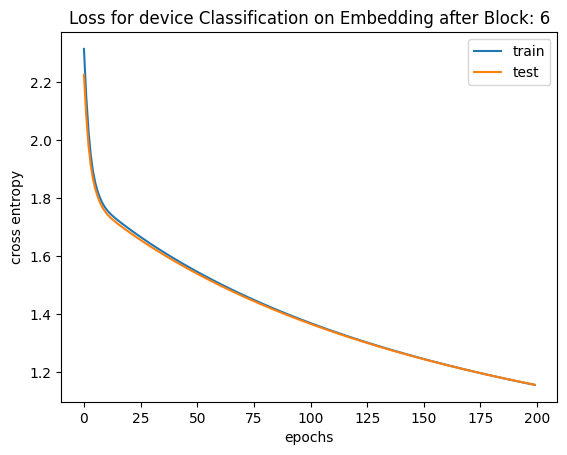

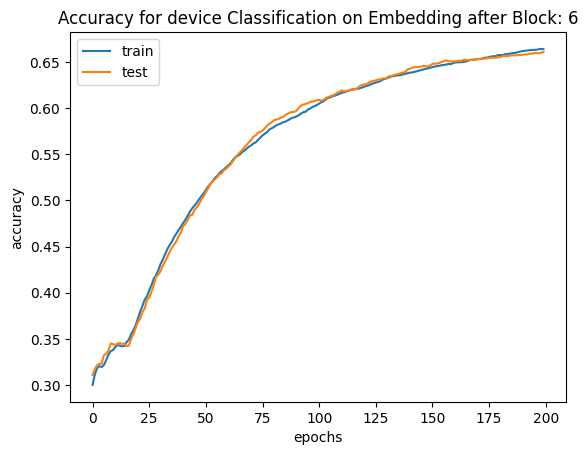

In [118]:
n_epochs = 200
batch_size = b_s
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# # Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters in the model are: {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of paramerters being trained: ", total_trainable_params)

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            labels = np.argmax(y_batch, axis=1)
            loss = criterion(y_pred, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if acc > best_acc:
        best_acc = acc

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)
list_val_acc.append(best_acc)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [119]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [120]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')

In [121]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
)

In [122]:
X_test=train_ready(test_data,col_name)

In [123]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred


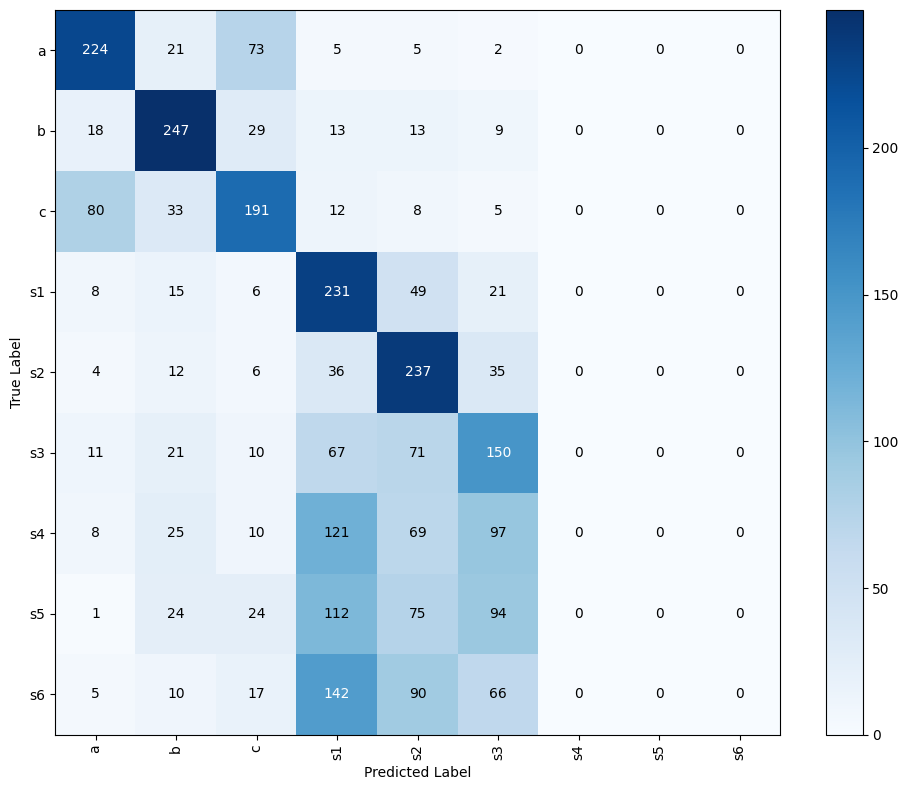

Accuracy: 0.4313


In [124]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-7

In [125]:
Block_number=7

In [126]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth',map_location=torch.device('cpu'))
new_fc3 = nn.Linear(256, 6)

# Replace the existing fc3 layer with the new one
model.fc3 = new_fc3

In [127]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [128]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [129]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [130]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 6)
(2793, 6)


In [131]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 198406
Number of parameters in the last layer is 1542


In [132]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [133]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)

In [134]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)

In [135]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 1542


In [136]:
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(weights_array))
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Total number of paramerters in the model are: 198406
Total number of paramerters being trained:  1542


Epoch 0: 100%|██████████| 43/43 [00:00<00:00, 515.30batch/s, acc=0.203, loss=2.24]


Epoch 0 validation: Cross-entropy=2.20, Accuracy=21.3%


Epoch 1: 100%|██████████| 43/43 [00:00<00:00, 470.93batch/s, acc=0.203, loss=2.1] 


Epoch 1 validation: Cross-entropy=2.07, Accuracy=19.5%


Epoch 2: 100%|██████████| 43/43 [00:00<00:00, 277.66batch/s, acc=0.207, loss=1.99]


Epoch 2 validation: Cross-entropy=1.97, Accuracy=19.4%


Epoch 3: 100%|██████████| 43/43 [00:00<00:00, 506.17batch/s, acc=0.199, loss=1.91]


Epoch 3 validation: Cross-entropy=1.90, Accuracy=19.5%


Epoch 4: 100%|██████████| 43/43 [00:00<00:00, 213.38batch/s, acc=0.18, loss=1.85] 


Epoch 4 validation: Cross-entropy=1.85, Accuracy=18.8%


Epoch 5: 100%|██████████| 43/43 [00:00<00:00, 521.36batch/s, acc=0.184, loss=1.82]


Epoch 5 validation: Cross-entropy=1.82, Accuracy=18.9%


Epoch 6: 100%|██████████| 43/43 [00:00<00:00, 548.03batch/s, acc=0.203, loss=1.79]


Epoch 6 validation: Cross-entropy=1.80, Accuracy=20.2%


Epoch 7: 100%|██████████| 43/43 [00:00<00:00, 283.48batch/s, acc=0.219, loss=1.77]


Epoch 7 validation: Cross-entropy=1.79, Accuracy=21.6%


Epoch 8: 100%|██████████| 43/43 [00:00<00:00, 546.06batch/s, acc=0.215, loss=1.76]


Epoch 8 validation: Cross-entropy=1.78, Accuracy=23.2%


Epoch 9: 100%|██████████| 43/43 [00:00<00:00, 287.20batch/s, acc=0.23, loss=1.75] 


Epoch 9 validation: Cross-entropy=1.77, Accuracy=24.3%


Epoch 10: 100%|██████████| 43/43 [00:00<00:00, 359.05batch/s, acc=0.23, loss=1.75] 


Epoch 10 validation: Cross-entropy=1.76, Accuracy=25.6%


Epoch 11: 100%|██████████| 43/43 [00:00<00:00, 336.68batch/s, acc=0.254, loss=1.74]


Epoch 11 validation: Cross-entropy=1.76, Accuracy=26.6%


Epoch 12: 100%|██████████| 43/43 [00:00<00:00, 569.48batch/s, acc=0.273, loss=1.73]


Epoch 12 validation: Cross-entropy=1.75, Accuracy=27.6%


Epoch 13: 100%|██████████| 43/43 [00:00<00:00, 280.83batch/s, acc=0.281, loss=1.73]


Epoch 13 validation: Cross-entropy=1.74, Accuracy=28.3%


Epoch 14: 100%|██████████| 43/43 [00:00<00:00, 526.28batch/s, acc=0.289, loss=1.72]


Epoch 14 validation: Cross-entropy=1.74, Accuracy=29.0%


Epoch 15: 100%|██████████| 43/43 [00:00<00:00, 554.49batch/s, acc=0.301, loss=1.72]


Epoch 15 validation: Cross-entropy=1.73, Accuracy=29.3%


Epoch 16: 100%|██████████| 43/43 [00:00<00:00, 326.39batch/s, acc=0.324, loss=1.71]


Epoch 16 validation: Cross-entropy=1.73, Accuracy=30.2%


Epoch 17: 100%|██████████| 43/43 [00:00<00:00, 496.19batch/s, acc=0.328, loss=1.7] 


Epoch 17 validation: Cross-entropy=1.72, Accuracy=31.0%


Epoch 18: 100%|██████████| 43/43 [00:00<00:00, 214.06batch/s, acc=0.34, loss=1.7]  


Epoch 18 validation: Cross-entropy=1.72, Accuracy=31.7%


Epoch 19: 100%|██████████| 43/43 [00:00<00:00, 531.40batch/s, acc=0.348, loss=1.69]


Epoch 19 validation: Cross-entropy=1.71, Accuracy=32.6%


Epoch 20: 100%|██████████| 43/43 [00:00<00:00, 279.61batch/s, acc=0.355, loss=1.69]


Epoch 20 validation: Cross-entropy=1.70, Accuracy=33.4%


Epoch 21: 100%|██████████| 43/43 [00:00<00:00, 554.27batch/s, acc=0.363, loss=1.68]


Epoch 21 validation: Cross-entropy=1.70, Accuracy=34.1%


Epoch 22: 100%|██████████| 43/43 [00:00<00:00, 573.63batch/s, acc=0.355, loss=1.68]


Epoch 22 validation: Cross-entropy=1.69, Accuracy=35.3%


Epoch 23: 100%|██████████| 43/43 [00:00<00:00, 322.16batch/s, acc=0.359, loss=1.67]


Epoch 23 validation: Cross-entropy=1.69, Accuracy=36.2%


Epoch 24: 100%|██████████| 43/43 [00:00<00:00, 554.05batch/s, acc=0.359, loss=1.67]


Epoch 24 validation: Cross-entropy=1.68, Accuracy=36.8%


Epoch 25: 100%|██████████| 43/43 [00:00<00:00, 336.64batch/s, acc=0.367, loss=1.66]


Epoch 25 validation: Cross-entropy=1.68, Accuracy=37.4%


Epoch 26: 100%|██████████| 43/43 [00:00<00:00, 457.90batch/s, acc=0.371, loss=1.65]


Epoch 26 validation: Cross-entropy=1.67, Accuracy=38.1%


Epoch 27: 100%|██████████| 43/43 [00:00<00:00, 550.75batch/s, acc=0.375, loss=1.65]


Epoch 27 validation: Cross-entropy=1.67, Accuracy=38.6%


Epoch 28: 100%|██████████| 43/43 [00:00<00:00, 217.11batch/s, acc=0.391, loss=1.64]


Epoch 28 validation: Cross-entropy=1.66, Accuracy=38.9%


Epoch 29: 100%|██████████| 43/43 [00:00<00:00, 501.49batch/s, acc=0.398, loss=1.64]


Epoch 29 validation: Cross-entropy=1.66, Accuracy=39.8%


Epoch 30: 100%|██████████| 43/43 [00:00<00:00, 270.85batch/s, acc=0.402, loss=1.63]


Epoch 30 validation: Cross-entropy=1.65, Accuracy=40.4%


Epoch 31: 100%|██████████| 43/43 [00:00<00:00, 543.03batch/s, acc=0.402, loss=1.63]


Epoch 31 validation: Cross-entropy=1.65, Accuracy=41.0%


Epoch 32: 100%|██████████| 43/43 [00:00<00:00, 552.87batch/s, acc=0.402, loss=1.62]


Epoch 32 validation: Cross-entropy=1.64, Accuracy=41.5%


Epoch 33: 100%|██████████| 43/43 [00:00<00:00, 283.48batch/s, acc=0.406, loss=1.62]


Epoch 33 validation: Cross-entropy=1.64, Accuracy=42.1%


Epoch 34: 100%|██████████| 43/43 [00:00<00:00, 526.10batch/s, acc=0.406, loss=1.61]


Epoch 34 validation: Cross-entropy=1.63, Accuracy=42.9%


Epoch 35: 100%|██████████| 43/43 [00:00<00:00, 313.80batch/s, acc=0.41, loss=1.61] 


Epoch 35 validation: Cross-entropy=1.63, Accuracy=43.6%


Epoch 36: 100%|██████████| 43/43 [00:00<00:00, 478.44batch/s, acc=0.414, loss=1.61]


Epoch 36 validation: Cross-entropy=1.62, Accuracy=44.5%


Epoch 37: 100%|██████████| 43/43 [00:00<00:00, 317.84batch/s, acc=0.414, loss=1.6] 


Epoch 37 validation: Cross-entropy=1.62, Accuracy=44.8%


Epoch 38: 100%|██████████| 43/43 [00:00<00:00, 324.13batch/s, acc=0.414, loss=1.6] 


Epoch 38 validation: Cross-entropy=1.62, Accuracy=45.1%


Epoch 39: 100%|██████████| 43/43 [00:00<00:00, 267.48batch/s, acc=0.418, loss=1.59]


Epoch 39 validation: Cross-entropy=1.61, Accuracy=45.3%


Epoch 40: 100%|██████████| 43/43 [00:00<00:00, 510.26batch/s, acc=0.43, loss=1.59] 


Epoch 40 validation: Cross-entropy=1.61, Accuracy=45.8%


Epoch 41: 100%|██████████| 43/43 [00:00<00:00, 550.29batch/s, acc=0.445, loss=1.58]


Epoch 41 validation: Cross-entropy=1.60, Accuracy=46.2%


Epoch 42: 100%|██████████| 43/43 [00:00<00:00, 516.21batch/s, acc=0.449, loss=1.58]


Epoch 42 validation: Cross-entropy=1.60, Accuracy=46.4%


Epoch 43: 100%|██████████| 43/43 [00:00<00:00, 259.50batch/s, acc=0.461, loss=1.57]


Epoch 43 validation: Cross-entropy=1.59, Accuracy=46.9%


Epoch 44: 100%|██████████| 43/43 [00:00<00:00, 555.97batch/s, acc=0.465, loss=1.57]


Epoch 44 validation: Cross-entropy=1.59, Accuracy=47.4%


Epoch 45: 100%|██████████| 43/43 [00:00<00:00, 293.14batch/s, acc=0.469, loss=1.56]


Epoch 45 validation: Cross-entropy=1.58, Accuracy=47.7%


Epoch 46: 100%|██████████| 43/43 [00:00<00:00, 480.55batch/s, acc=0.473, loss=1.56]


Epoch 46 validation: Cross-entropy=1.58, Accuracy=48.3%


Epoch 47: 100%|██████████| 43/43 [00:00<00:00, 565.95batch/s, acc=0.477, loss=1.56]


Epoch 47 validation: Cross-entropy=1.58, Accuracy=48.7%


Epoch 48: 100%|██████████| 43/43 [00:00<00:00, 277.32batch/s, acc=0.484, loss=1.55]


Epoch 48 validation: Cross-entropy=1.57, Accuracy=49.0%


Epoch 49: 100%|██████████| 43/43 [00:00<00:00, 309.04batch/s, acc=0.496, loss=1.55]


Epoch 49 validation: Cross-entropy=1.57, Accuracy=49.2%


Epoch 50: 100%|██████████| 43/43 [00:00<00:00, 558.99batch/s, acc=0.504, loss=1.54]


Epoch 50 validation: Cross-entropy=1.56, Accuracy=49.7%


Epoch 51: 100%|██████████| 43/43 [00:00<00:00, 257.40batch/s, acc=0.508, loss=1.54]


Epoch 51 validation: Cross-entropy=1.56, Accuracy=50.2%


Epoch 52: 100%|██████████| 43/43 [00:00<00:00, 565.93batch/s, acc=0.504, loss=1.54]


Epoch 52 validation: Cross-entropy=1.56, Accuracy=50.4%


Epoch 53: 100%|██████████| 43/43 [00:00<00:00, 540.09batch/s, acc=0.504, loss=1.53]


Epoch 53 validation: Cross-entropy=1.55, Accuracy=50.6%


Epoch 54: 100%|██████████| 43/43 [00:00<00:00, 276.03batch/s, acc=0.508, loss=1.53]


Epoch 54 validation: Cross-entropy=1.55, Accuracy=50.8%


Epoch 55: 100%|██████████| 43/43 [00:00<00:00, 547.37batch/s, acc=0.512, loss=1.52]


Epoch 55 validation: Cross-entropy=1.54, Accuracy=51.1%


Epoch 56: 100%|██████████| 43/43 [00:00<00:00, 299.16batch/s, acc=0.512, loss=1.52]


Epoch 56 validation: Cross-entropy=1.54, Accuracy=51.2%


Epoch 57: 100%|██████████| 43/43 [00:00<00:00, 564.48batch/s, acc=0.52, loss=1.52] 


Epoch 57 validation: Cross-entropy=1.54, Accuracy=51.5%


Epoch 58: 100%|██████████| 43/43 [00:00<00:00, 396.81batch/s, acc=0.527, loss=1.51]


Epoch 58 validation: Cross-entropy=1.53, Accuracy=51.6%


Epoch 59: 100%|██████████| 43/43 [00:00<00:00, 293.70batch/s, acc=0.527, loss=1.51]


Epoch 59 validation: Cross-entropy=1.53, Accuracy=51.6%


Epoch 60: 100%|██████████| 43/43 [00:00<00:00, 287.92batch/s, acc=0.523, loss=1.5] 


Epoch 60 validation: Cross-entropy=1.52, Accuracy=51.7%


Epoch 61: 100%|██████████| 43/43 [00:00<00:00, 474.72batch/s, acc=0.527, loss=1.5] 


Epoch 61 validation: Cross-entropy=1.52, Accuracy=51.9%


Epoch 62: 100%|██████████| 43/43 [00:00<00:00, 518.91batch/s, acc=0.527, loss=1.5] 


Epoch 62 validation: Cross-entropy=1.52, Accuracy=52.0%


Epoch 63: 100%|██████████| 43/43 [00:00<00:00, 332.98batch/s, acc=0.535, loss=1.49]


Epoch 63 validation: Cross-entropy=1.51, Accuracy=52.3%


Epoch 64: 100%|██████████| 43/43 [00:00<00:00, 476.94batch/s, acc=0.543, loss=1.49]


Epoch 64 validation: Cross-entropy=1.51, Accuracy=52.6%


Epoch 65: 100%|██████████| 43/43 [00:00<00:00, 274.59batch/s, acc=0.559, loss=1.48]


Epoch 65 validation: Cross-entropy=1.51, Accuracy=52.8%


Epoch 66: 100%|██████████| 43/43 [00:00<00:00, 554.25batch/s, acc=0.559, loss=1.48]


Epoch 66 validation: Cross-entropy=1.50, Accuracy=53.0%


Epoch 67: 100%|██████████| 43/43 [00:00<00:00, 506.12batch/s, acc=0.559, loss=1.48]


Epoch 67 validation: Cross-entropy=1.50, Accuracy=53.5%


Epoch 68: 100%|██████████| 43/43 [00:00<00:00, 413.51batch/s, acc=0.574, loss=1.47]


Epoch 68 validation: Cross-entropy=1.50, Accuracy=53.6%


Epoch 69: 100%|██████████| 43/43 [00:00<00:00, 544.51batch/s, acc=0.574, loss=1.47]


Epoch 69 validation: Cross-entropy=1.49, Accuracy=53.8%


Epoch 70: 100%|██████████| 43/43 [00:00<00:00, 274.50batch/s, acc=0.574, loss=1.47]


Epoch 70 validation: Cross-entropy=1.49, Accuracy=54.1%


Epoch 71: 100%|██████████| 43/43 [00:00<00:00, 527.46batch/s, acc=0.574, loss=1.46]


Epoch 71 validation: Cross-entropy=1.49, Accuracy=54.2%


Epoch 72: 100%|██████████| 43/43 [00:00<00:00, 297.62batch/s, acc=0.582, loss=1.46]


Epoch 72 validation: Cross-entropy=1.48, Accuracy=54.4%


Epoch 73: 100%|██████████| 43/43 [00:00<00:00, 513.64batch/s, acc=0.586, loss=1.46]


Epoch 73 validation: Cross-entropy=1.48, Accuracy=54.7%


Epoch 74: 100%|██████████| 43/43 [00:00<00:00, 569.26batch/s, acc=0.586, loss=1.45]


Epoch 74 validation: Cross-entropy=1.48, Accuracy=55.1%


Epoch 75: 100%|██████████| 43/43 [00:00<00:00, 293.01batch/s, acc=0.582, loss=1.45]


Epoch 75 validation: Cross-entropy=1.47, Accuracy=55.4%


Epoch 76: 100%|██████████| 43/43 [00:00<00:00, 476.40batch/s, acc=0.578, loss=1.45]


Epoch 76 validation: Cross-entropy=1.47, Accuracy=55.7%


Epoch 77: 100%|██████████| 43/43 [00:00<00:00, 201.77batch/s, acc=0.582, loss=1.44]


Epoch 77 validation: Cross-entropy=1.47, Accuracy=55.7%


Epoch 78: 100%|██████████| 43/43 [00:00<00:00, 455.73batch/s, acc=0.582, loss=1.44]


Epoch 78 validation: Cross-entropy=1.46, Accuracy=55.8%


Epoch 79: 100%|██████████| 43/43 [00:00<00:00, 272.72batch/s, acc=0.582, loss=1.44]


Epoch 79 validation: Cross-entropy=1.46, Accuracy=56.0%


Epoch 80: 100%|██████████| 43/43 [00:00<00:00, 436.29batch/s, acc=0.586, loss=1.43]


Epoch 80 validation: Cross-entropy=1.46, Accuracy=56.1%


Epoch 81: 100%|██████████| 43/43 [00:00<00:00, 404.93batch/s, acc=0.578, loss=1.43]


Epoch 81 validation: Cross-entropy=1.45, Accuracy=56.2%


Epoch 82: 100%|██████████| 43/43 [00:00<00:00, 533.88batch/s, acc=0.582, loss=1.43]


Epoch 82 validation: Cross-entropy=1.45, Accuracy=56.3%


Epoch 83: 100%|██████████| 43/43 [00:00<00:00, 277.38batch/s, acc=0.582, loss=1.42]


Epoch 83 validation: Cross-entropy=1.45, Accuracy=56.3%


Epoch 84: 100%|██████████| 43/43 [00:00<00:00, 538.32batch/s, acc=0.586, loss=1.42]


Epoch 84 validation: Cross-entropy=1.44, Accuracy=56.5%


Epoch 85: 100%|██████████| 43/43 [00:00<00:00, 298.18batch/s, acc=0.59, loss=1.42] 


Epoch 85 validation: Cross-entropy=1.44, Accuracy=56.5%


Epoch 86: 100%|██████████| 43/43 [00:00<00:00, 415.96batch/s, acc=0.586, loss=1.41]


Epoch 86 validation: Cross-entropy=1.44, Accuracy=56.6%


Epoch 87: 100%|██████████| 43/43 [00:00<00:00, 337.06batch/s, acc=0.586, loss=1.41]


Epoch 87 validation: Cross-entropy=1.43, Accuracy=56.8%


Epoch 88: 100%|██████████| 43/43 [00:00<00:00, 409.06batch/s, acc=0.582, loss=1.41]


Epoch 88 validation: Cross-entropy=1.43, Accuracy=57.0%


Epoch 89: 100%|██████████| 43/43 [00:00<00:00, 538.77batch/s, acc=0.586, loss=1.4] 


Epoch 89 validation: Cross-entropy=1.43, Accuracy=57.3%


Epoch 90: 100%|██████████| 43/43 [00:00<00:00, 336.91batch/s, acc=0.59, loss=1.4]  


Epoch 90 validation: Cross-entropy=1.43, Accuracy=57.4%


Epoch 91: 100%|██████████| 43/43 [00:00<00:00, 396.31batch/s, acc=0.59, loss=1.4]  


Epoch 91 validation: Cross-entropy=1.42, Accuracy=57.5%


Epoch 92: 100%|██████████| 43/43 [00:00<00:00, 401.10batch/s, acc=0.59, loss=1.4]  


Epoch 92 validation: Cross-entropy=1.42, Accuracy=57.6%


Epoch 93: 100%|██████████| 43/43 [00:00<00:00, 416.84batch/s, acc=0.59, loss=1.39] 


Epoch 93 validation: Cross-entropy=1.42, Accuracy=57.7%


Epoch 94: 100%|██████████| 43/43 [00:00<00:00, 365.34batch/s, acc=0.59, loss=1.39] 


Epoch 94 validation: Cross-entropy=1.41, Accuracy=57.9%


Epoch 95: 100%|██████████| 43/43 [00:00<00:00, 559.24batch/s, acc=0.594, loss=1.39]


Epoch 95 validation: Cross-entropy=1.41, Accuracy=58.0%


Epoch 96: 100%|██████████| 43/43 [00:00<00:00, 242.65batch/s, acc=0.594, loss=1.38]


Epoch 96 validation: Cross-entropy=1.41, Accuracy=58.2%


Epoch 97: 100%|██████████| 43/43 [00:00<00:00, 461.52batch/s, acc=0.598, loss=1.38]


Epoch 97 validation: Cross-entropy=1.41, Accuracy=58.1%


Epoch 98: 100%|██████████| 43/43 [00:00<00:00, 519.80batch/s, acc=0.605, loss=1.38]


Epoch 98 validation: Cross-entropy=1.40, Accuracy=58.2%


Epoch 99: 100%|██████████| 43/43 [00:00<00:00, 274.97batch/s, acc=0.605, loss=1.38]


Epoch 99 validation: Cross-entropy=1.40, Accuracy=58.4%


Epoch 100: 100%|██████████| 43/43 [00:00<00:00, 534.39batch/s, acc=0.605, loss=1.37]


Epoch 100 validation: Cross-entropy=1.40, Accuracy=58.3%


Epoch 101: 100%|██████████| 43/43 [00:00<00:00, 564.44batch/s, acc=0.609, loss=1.37]


Epoch 101 validation: Cross-entropy=1.39, Accuracy=58.5%


Epoch 102: 100%|██████████| 43/43 [00:00<00:00, 285.85batch/s, acc=0.609, loss=1.37]


Epoch 102 validation: Cross-entropy=1.39, Accuracy=58.6%


Epoch 103: 100%|██████████| 43/43 [00:00<00:00, 568.88batch/s, acc=0.609, loss=1.36]


Epoch 103 validation: Cross-entropy=1.39, Accuracy=58.5%


Epoch 104: 100%|██████████| 43/43 [00:00<00:00, 277.89batch/s, acc=0.613, loss=1.36]


Epoch 104 validation: Cross-entropy=1.39, Accuracy=58.5%


Epoch 105: 100%|██████████| 43/43 [00:00<00:00, 478.63batch/s, acc=0.613, loss=1.36]


Epoch 105 validation: Cross-entropy=1.38, Accuracy=58.5%


Epoch 106: 100%|██████████| 43/43 [00:00<00:00, 230.12batch/s, acc=0.613, loss=1.36]


Epoch 106 validation: Cross-entropy=1.38, Accuracy=58.6%


Epoch 107: 100%|██████████| 43/43 [00:00<00:00, 548.38batch/s, acc=0.617, loss=1.35]


Epoch 107 validation: Cross-entropy=1.38, Accuracy=58.6%


Epoch 108: 100%|██████████| 43/43 [00:00<00:00, 522.19batch/s, acc=0.617, loss=1.35]


Epoch 108 validation: Cross-entropy=1.38, Accuracy=58.6%


Epoch 109: 100%|██████████| 43/43 [00:00<00:00, 262.03batch/s, acc=0.617, loss=1.35]


Epoch 109 validation: Cross-entropy=1.37, Accuracy=58.7%


Epoch 110: 100%|██████████| 43/43 [00:00<00:00, 562.02batch/s, acc=0.617, loss=1.35]


Epoch 110 validation: Cross-entropy=1.37, Accuracy=58.8%


Epoch 111: 100%|██████████| 43/43 [00:00<00:00, 292.63batch/s, acc=0.617, loss=1.34]


Epoch 111 validation: Cross-entropy=1.37, Accuracy=58.9%


Epoch 112: 100%|██████████| 43/43 [00:00<00:00, 455.23batch/s, acc=0.617, loss=1.34]


Epoch 112 validation: Cross-entropy=1.37, Accuracy=59.0%


Epoch 113: 100%|██████████| 43/43 [00:00<00:00, 409.06batch/s, acc=0.617, loss=1.34]


Epoch 113 validation: Cross-entropy=1.36, Accuracy=59.0%


Epoch 114: 100%|██████████| 43/43 [00:00<00:00, 343.44batch/s, acc=0.617, loss=1.33]


Epoch 114 validation: Cross-entropy=1.36, Accuracy=59.1%


Epoch 115: 100%|██████████| 43/43 [00:00<00:00, 537.67batch/s, acc=0.621, loss=1.33]


Epoch 115 validation: Cross-entropy=1.36, Accuracy=59.3%


Epoch 116: 100%|██████████| 43/43 [00:00<00:00, 229.39batch/s, acc=0.621, loss=1.33]


Epoch 116 validation: Cross-entropy=1.36, Accuracy=59.3%


Epoch 117: 100%|██████████| 43/43 [00:00<00:00, 514.07batch/s, acc=0.621, loss=1.33]


Epoch 117 validation: Cross-entropy=1.35, Accuracy=59.4%


Epoch 118: 100%|██████████| 43/43 [00:00<00:00, 293.64batch/s, acc=0.621, loss=1.32]


Epoch 118 validation: Cross-entropy=1.35, Accuracy=59.5%


Epoch 119: 100%|██████████| 43/43 [00:00<00:00, 517.16batch/s, acc=0.625, loss=1.32]


Epoch 119 validation: Cross-entropy=1.35, Accuracy=59.6%


Epoch 120: 100%|██████████| 43/43 [00:00<00:00, 278.06batch/s, acc=0.629, loss=1.32]


Epoch 120 validation: Cross-entropy=1.35, Accuracy=59.7%


Epoch 121: 100%|██████████| 43/43 [00:00<00:00, 539.83batch/s, acc=0.625, loss=1.32]


Epoch 121 validation: Cross-entropy=1.34, Accuracy=60.0%


Epoch 122: 100%|██████████| 43/43 [00:00<00:00, 537.55batch/s, acc=0.625, loss=1.32]


Epoch 122 validation: Cross-entropy=1.34, Accuracy=60.0%


Epoch 123: 100%|██████████| 43/43 [00:00<00:00, 308.01batch/s, acc=0.625, loss=1.31]


Epoch 123 validation: Cross-entropy=1.34, Accuracy=60.2%


Epoch 124: 100%|██████████| 43/43 [00:00<00:00, 488.80batch/s, acc=0.625, loss=1.31]


Epoch 124 validation: Cross-entropy=1.34, Accuracy=60.3%


Epoch 125: 100%|██████████| 43/43 [00:00<00:00, 557.08batch/s, acc=0.625, loss=1.31]


Epoch 125 validation: Cross-entropy=1.33, Accuracy=60.5%


Epoch 126: 100%|██████████| 43/43 [00:00<00:00, 229.55batch/s, acc=0.629, loss=1.31]


Epoch 126 validation: Cross-entropy=1.33, Accuracy=60.5%


Epoch 127: 100%|██████████| 43/43 [00:00<00:00, 519.04batch/s, acc=0.633, loss=1.3] 


Epoch 127 validation: Cross-entropy=1.33, Accuracy=60.6%


Epoch 128: 100%|██████████| 43/43 [00:00<00:00, 538.73batch/s, acc=0.629, loss=1.3] 


Epoch 128 validation: Cross-entropy=1.33, Accuracy=60.5%


Epoch 129: 100%|██████████| 43/43 [00:00<00:00, 284.98batch/s, acc=0.629, loss=1.3] 


Epoch 129 validation: Cross-entropy=1.32, Accuracy=60.7%


Epoch 130: 100%|██████████| 43/43 [00:00<00:00, 543.73batch/s, acc=0.629, loss=1.3] 


Epoch 130 validation: Cross-entropy=1.32, Accuracy=60.7%


Epoch 131: 100%|██████████| 43/43 [00:00<00:00, 246.26batch/s, acc=0.629, loss=1.29]


Epoch 131 validation: Cross-entropy=1.32, Accuracy=60.8%


Epoch 132: 100%|██████████| 43/43 [00:00<00:00, 419.04batch/s, acc=0.629, loss=1.29]


Epoch 132 validation: Cross-entropy=1.32, Accuracy=60.7%


Epoch 133: 100%|██████████| 43/43 [00:00<00:00, 545.24batch/s, acc=0.629, loss=1.29]


Epoch 133 validation: Cross-entropy=1.32, Accuracy=60.7%


Epoch 134: 100%|██████████| 43/43 [00:00<00:00, 326.75batch/s, acc=0.633, loss=1.29]


Epoch 134 validation: Cross-entropy=1.31, Accuracy=60.8%


Epoch 135: 100%|██████████| 43/43 [00:00<00:00, 490.73batch/s, acc=0.633, loss=1.29]


Epoch 135 validation: Cross-entropy=1.31, Accuracy=61.1%


Epoch 136: 100%|██████████| 43/43 [00:00<00:00, 334.67batch/s, acc=0.633, loss=1.28]


Epoch 136 validation: Cross-entropy=1.31, Accuracy=61.3%


Epoch 137: 100%|██████████| 43/43 [00:00<00:00, 280.57batch/s, acc=0.633, loss=1.28]


Epoch 137 validation: Cross-entropy=1.31, Accuracy=61.5%


Epoch 138: 100%|██████████| 43/43 [00:00<00:00, 543.05batch/s, acc=0.633, loss=1.28]


Epoch 138 validation: Cross-entropy=1.31, Accuracy=61.5%


Epoch 139: 100%|██████████| 43/43 [00:00<00:00, 280.04batch/s, acc=0.633, loss=1.28]


Epoch 139 validation: Cross-entropy=1.30, Accuracy=61.7%


Epoch 140: 100%|██████████| 43/43 [00:00<00:00, 537.55batch/s, acc=0.633, loss=1.27]


Epoch 140 validation: Cross-entropy=1.30, Accuracy=61.8%


Epoch 141: 100%|██████████| 43/43 [00:00<00:00, 289.21batch/s, acc=0.637, loss=1.27]


Epoch 141 validation: Cross-entropy=1.30, Accuracy=61.8%


Epoch 142: 100%|██████████| 43/43 [00:00<00:00, 494.53batch/s, acc=0.637, loss=1.27]


Epoch 142 validation: Cross-entropy=1.30, Accuracy=61.9%


Epoch 143: 100%|██████████| 43/43 [00:00<00:00, 448.11batch/s, acc=0.637, loss=1.27]


Epoch 143 validation: Cross-entropy=1.29, Accuracy=61.9%


Epoch 144: 100%|██████████| 43/43 [00:00<00:00, 371.27batch/s, acc=0.641, loss=1.27]


Epoch 144 validation: Cross-entropy=1.29, Accuracy=62.0%


Epoch 145: 100%|██████████| 43/43 [00:00<00:00, 559.94batch/s, acc=0.641, loss=1.26]


Epoch 145 validation: Cross-entropy=1.29, Accuracy=62.1%


Epoch 146: 100%|██████████| 43/43 [00:00<00:00, 208.26batch/s, acc=0.641, loss=1.26]


Epoch 146 validation: Cross-entropy=1.29, Accuracy=62.2%


Epoch 147: 100%|██████████| 43/43 [00:00<00:00, 556.10batch/s, acc=0.641, loss=1.26]


Epoch 147 validation: Cross-entropy=1.29, Accuracy=62.2%


Epoch 148: 100%|██████████| 43/43 [00:00<00:00, 268.43batch/s, acc=0.641, loss=1.26]


Epoch 148 validation: Cross-entropy=1.28, Accuracy=62.3%


Epoch 149: 100%|██████████| 43/43 [00:00<00:00, 562.51batch/s, acc=0.641, loss=1.26]


Epoch 149 validation: Cross-entropy=1.28, Accuracy=62.2%


Epoch 150: 100%|██████████| 43/43 [00:00<00:00, 562.41batch/s, acc=0.641, loss=1.25]


Epoch 150 validation: Cross-entropy=1.28, Accuracy=62.4%


Epoch 151: 100%|██████████| 43/43 [00:00<00:00, 288.27batch/s, acc=0.641, loss=1.25]


Epoch 151 validation: Cross-entropy=1.28, Accuracy=62.4%


Epoch 152: 100%|██████████| 43/43 [00:00<00:00, 563.65batch/s, acc=0.641, loss=1.25]


Epoch 152 validation: Cross-entropy=1.28, Accuracy=62.5%


Epoch 153: 100%|██████████| 43/43 [00:00<00:00, 291.55batch/s, acc=0.645, loss=1.25]


Epoch 153 validation: Cross-entropy=1.27, Accuracy=62.6%


Epoch 154: 100%|██████████| 43/43 [00:00<00:00, 464.69batch/s, acc=0.645, loss=1.25]


Epoch 154 validation: Cross-entropy=1.27, Accuracy=62.7%


Epoch 155: 100%|██████████| 43/43 [00:00<00:00, 284.90batch/s, acc=0.645, loss=1.24]


Epoch 155 validation: Cross-entropy=1.27, Accuracy=62.8%


Epoch 156: 100%|██████████| 43/43 [00:00<00:00, 493.17batch/s, acc=0.648, loss=1.24]


Epoch 156 validation: Cross-entropy=1.27, Accuracy=62.8%


Epoch 157: 100%|██████████| 43/43 [00:00<00:00, 266.44batch/s, acc=0.648, loss=1.24]


Epoch 157 validation: Cross-entropy=1.27, Accuracy=62.8%


Epoch 158: 100%|██████████| 43/43 [00:00<00:00, 529.41batch/s, acc=0.648, loss=1.24]


Epoch 158 validation: Cross-entropy=1.27, Accuracy=62.9%


Epoch 159: 100%|██████████| 43/43 [00:00<00:00, 278.91batch/s, acc=0.648, loss=1.24]


Epoch 159 validation: Cross-entropy=1.26, Accuracy=62.9%


Epoch 160: 100%|██████████| 43/43 [00:00<00:00, 469.39batch/s, acc=0.648, loss=1.23]


Epoch 160 validation: Cross-entropy=1.26, Accuracy=62.9%


Epoch 161: 100%|██████████| 43/43 [00:00<00:00, 531.07batch/s, acc=0.648, loss=1.23]


Epoch 161 validation: Cross-entropy=1.26, Accuracy=62.9%


Epoch 162: 100%|██████████| 43/43 [00:00<00:00, 298.79batch/s, acc=0.648, loss=1.23]


Epoch 162 validation: Cross-entropy=1.26, Accuracy=62.9%


Epoch 163: 100%|██████████| 43/43 [00:00<00:00, 470.22batch/s, acc=0.652, loss=1.23]


Epoch 163 validation: Cross-entropy=1.26, Accuracy=63.1%


Epoch 164: 100%|██████████| 43/43 [00:00<00:00, 523.41batch/s, acc=0.656, loss=1.23]


Epoch 164 validation: Cross-entropy=1.25, Accuracy=63.2%


Epoch 165: 100%|██████████| 43/43 [00:00<00:00, 261.26batch/s, acc=0.656, loss=1.22]


Epoch 165 validation: Cross-entropy=1.25, Accuracy=63.2%


Epoch 166: 100%|██████████| 43/43 [00:00<00:00, 460.99batch/s, acc=0.66, loss=1.22] 


Epoch 166 validation: Cross-entropy=1.25, Accuracy=63.3%


Epoch 167: 100%|██████████| 43/43 [00:00<00:00, 562.06batch/s, acc=0.66, loss=1.22] 


Epoch 167 validation: Cross-entropy=1.25, Accuracy=63.3%


Epoch 168: 100%|██████████| 43/43 [00:00<00:00, 264.40batch/s, acc=0.664, loss=1.22]


Epoch 168 validation: Cross-entropy=1.25, Accuracy=63.3%


Epoch 169: 100%|██████████| 43/43 [00:00<00:00, 561.12batch/s, acc=0.664, loss=1.22]


Epoch 169 validation: Cross-entropy=1.25, Accuracy=63.2%


Epoch 170: 100%|██████████| 43/43 [00:00<00:00, 526.86batch/s, acc=0.668, loss=1.22]


Epoch 170 validation: Cross-entropy=1.24, Accuracy=63.2%


Epoch 171: 100%|██████████| 43/43 [00:00<00:00, 289.21batch/s, acc=0.668, loss=1.21]


Epoch 171 validation: Cross-entropy=1.24, Accuracy=63.3%


Epoch 172: 100%|██████████| 43/43 [00:00<00:00, 308.52batch/s, acc=0.668, loss=1.21]


Epoch 172 validation: Cross-entropy=1.24, Accuracy=63.3%


Epoch 173: 100%|██████████| 43/43 [00:00<00:00, 482.17batch/s, acc=0.668, loss=1.21]


Epoch 173 validation: Cross-entropy=1.24, Accuracy=63.4%


Epoch 174: 100%|██████████| 43/43 [00:00<00:00, 241.19batch/s, acc=0.668, loss=1.21]


Epoch 174 validation: Cross-entropy=1.24, Accuracy=63.4%


Epoch 175: 100%|██████████| 43/43 [00:00<00:00, 465.37batch/s, acc=0.668, loss=1.21]


Epoch 175 validation: Cross-entropy=1.24, Accuracy=63.4%


Epoch 176: 100%|██████████| 43/43 [00:00<00:00, 321.34batch/s, acc=0.664, loss=1.2] 


Epoch 176 validation: Cross-entropy=1.23, Accuracy=63.4%


Epoch 177: 100%|██████████| 43/43 [00:00<00:00, 462.47batch/s, acc=0.664, loss=1.2] 


Epoch 177 validation: Cross-entropy=1.23, Accuracy=63.6%


Epoch 178: 100%|██████████| 43/43 [00:00<00:00, 583.55batch/s, acc=0.664, loss=1.2] 


Epoch 178 validation: Cross-entropy=1.23, Accuracy=63.6%


Epoch 179: 100%|██████████| 43/43 [00:00<00:00, 248.37batch/s, acc=0.664, loss=1.2] 


Epoch 179 validation: Cross-entropy=1.23, Accuracy=63.6%


Epoch 180: 100%|██████████| 43/43 [00:00<00:00, 470.99batch/s, acc=0.664, loss=1.2] 


Epoch 180 validation: Cross-entropy=1.23, Accuracy=63.6%


Epoch 181: 100%|██████████| 43/43 [00:00<00:00, 526.30batch/s, acc=0.664, loss=1.2] 


Epoch 181 validation: Cross-entropy=1.22, Accuracy=63.7%


Epoch 182: 100%|██████████| 43/43 [00:00<00:00, 294.86batch/s, acc=0.664, loss=1.19]


Epoch 182 validation: Cross-entropy=1.22, Accuracy=63.7%


Epoch 183: 100%|██████████| 43/43 [00:00<00:00, 499.47batch/s, acc=0.668, loss=1.19]


Epoch 183 validation: Cross-entropy=1.22, Accuracy=63.8%


Epoch 184: 100%|██████████| 43/43 [00:00<00:00, 229.56batch/s, acc=0.664, loss=1.19]


Epoch 184 validation: Cross-entropy=1.22, Accuracy=63.9%


Epoch 185: 100%|██████████| 43/43 [00:00<00:00, 482.73batch/s, acc=0.664, loss=1.19]


Epoch 185 validation: Cross-entropy=1.22, Accuracy=63.9%


Epoch 186: 100%|██████████| 43/43 [00:00<00:00, 284.76batch/s, acc=0.664, loss=1.19]


Epoch 186 validation: Cross-entropy=1.22, Accuracy=64.0%


Epoch 187: 100%|██████████| 43/43 [00:00<00:00, 463.24batch/s, acc=0.664, loss=1.19]


Epoch 187 validation: Cross-entropy=1.22, Accuracy=64.0%


Epoch 188: 100%|██████████| 43/43 [00:00<00:00, 271.34batch/s, acc=0.664, loss=1.18]


Epoch 188 validation: Cross-entropy=1.21, Accuracy=64.0%


Epoch 189: 100%|██████████| 43/43 [00:00<00:00, 533.25batch/s, acc=0.668, loss=1.18]


Epoch 189 validation: Cross-entropy=1.21, Accuracy=64.1%


Epoch 190: 100%|██████████| 43/43 [00:00<00:00, 360.03batch/s, acc=0.668, loss=1.18]


Epoch 190 validation: Cross-entropy=1.21, Accuracy=64.1%


Epoch 191: 100%|██████████| 43/43 [00:00<00:00, 391.11batch/s, acc=0.668, loss=1.18]


Epoch 191 validation: Cross-entropy=1.21, Accuracy=64.2%


Epoch 192: 100%|██████████| 43/43 [00:00<00:00, 581.66batch/s, acc=0.668, loss=1.18]


Epoch 192 validation: Cross-entropy=1.21, Accuracy=64.3%


Epoch 193: 100%|██████████| 43/43 [00:00<00:00, 250.38batch/s, acc=0.664, loss=1.18]


Epoch 193 validation: Cross-entropy=1.21, Accuracy=64.3%


Epoch 194: 100%|██████████| 43/43 [00:00<00:00, 537.84batch/s, acc=0.664, loss=1.17]


Epoch 194 validation: Cross-entropy=1.20, Accuracy=64.4%


Epoch 195: 100%|██████████| 43/43 [00:00<00:00, 551.41batch/s, acc=0.664, loss=1.17]


Epoch 195 validation: Cross-entropy=1.20, Accuracy=64.4%


Epoch 196: 100%|██████████| 43/43 [00:00<00:00, 261.83batch/s, acc=0.664, loss=1.17]


Epoch 196 validation: Cross-entropy=1.20, Accuracy=64.5%


Epoch 197: 100%|██████████| 43/43 [00:00<00:00, 539.33batch/s, acc=0.664, loss=1.17]


Epoch 197 validation: Cross-entropy=1.20, Accuracy=64.5%


Epoch 198: 100%|██████████| 43/43 [00:00<00:00, 264.75batch/s, acc=0.664, loss=1.17]


Epoch 198 validation: Cross-entropy=1.20, Accuracy=64.6%


Epoch 199: 100%|██████████| 43/43 [00:00<00:00, 541.74batch/s, acc=0.664, loss=1.17]


Epoch 199 validation: Cross-entropy=1.20, Accuracy=64.6%


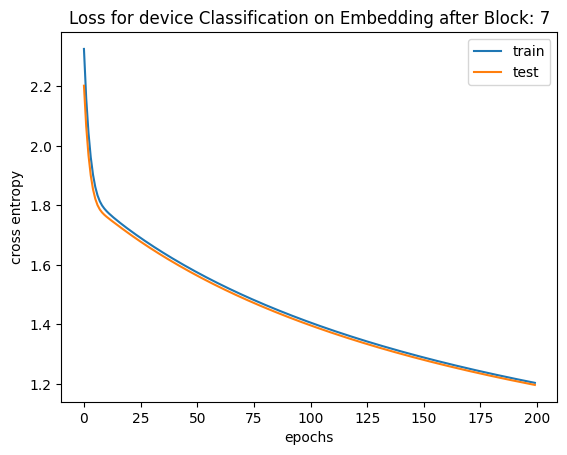

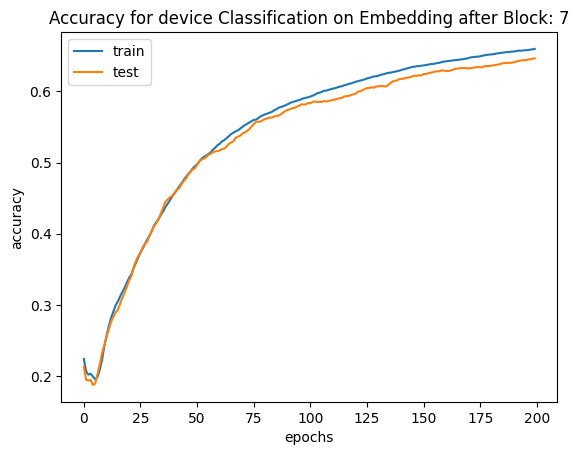

In [137]:
n_epochs = 200
batch_size = b_s
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# # Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters in the model are: {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of paramerters being trained: ", total_trainable_params)

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            labels = np.argmax(y_batch, axis=1)
            loss = criterion(y_pred, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if acc > best_acc:
        best_acc = acc

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)
list_val_acc.append(best_acc)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [138]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [139]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')

In [140]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
)

In [141]:
X_test=train_ready(test_data,col_name)

In [142]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred


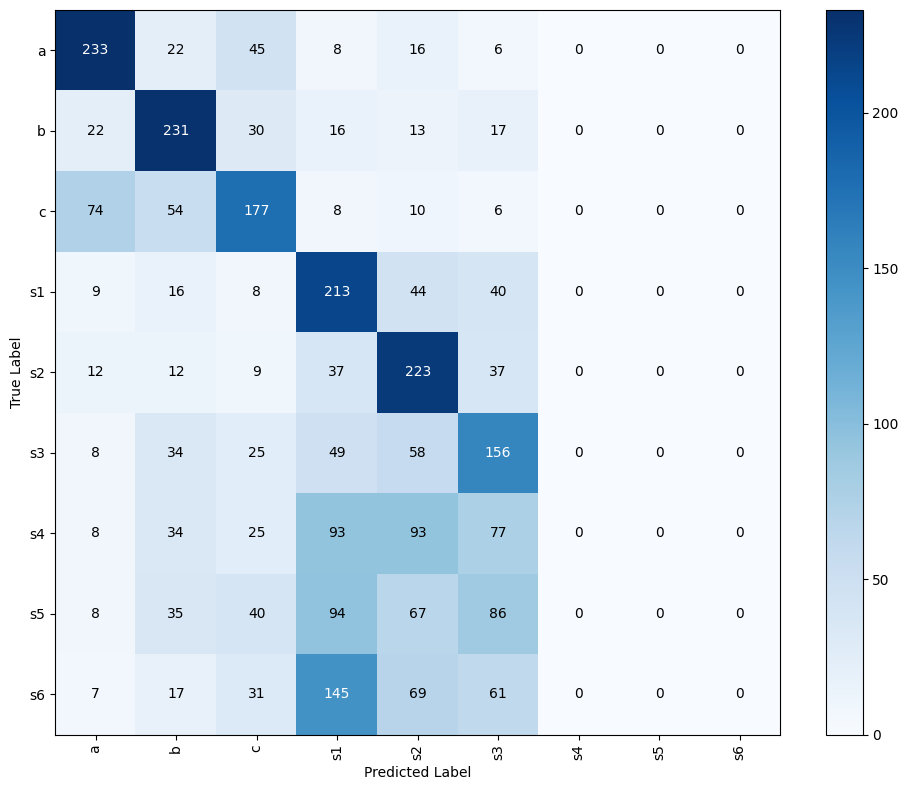

Accuracy: 0.4154


In [143]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-8

In [144]:
Block_number=8

In [145]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth',map_location=torch.device('cpu'))
new_fc3 = nn.Linear(256, 6)

# Replace the existing fc3 layer with the new one
model.fc3 = new_fc3

In [146]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [147]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [148]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [149]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 6)
(2793, 6)


In [150]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 198406
Number of parameters in the last layer is 1542


In [151]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [152]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)

In [153]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)

In [154]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 1542


In [155]:
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(weights_array))
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Total number of paramerters in the model are: 198406
Total number of paramerters being trained:  1542


Epoch 0: 100%|██████████| 43/43 [00:00<00:00, 324.67batch/s, acc=0.285, loss=2.22]


Epoch 0 validation: Cross-entropy=2.17, Accuracy=27.1%


Epoch 1: 100%|██████████| 43/43 [00:00<00:00, 526.85batch/s, acc=0.305, loss=2.04]


Epoch 1 validation: Cross-entropy=2.00, Accuracy=29.3%


Epoch 2: 100%|██████████| 43/43 [00:00<00:00, 515.65batch/s, acc=0.293, loss=1.94]


Epoch 2 validation: Cross-entropy=1.90, Accuracy=28.9%


Epoch 3: 100%|██████████| 43/43 [00:00<00:00, 504.63batch/s, acc=0.277, loss=1.87]


Epoch 3 validation: Cross-entropy=1.85, Accuracy=27.7%


Epoch 4: 100%|██████████| 43/43 [00:00<00:00, 224.62batch/s, acc=0.277, loss=1.84]


Epoch 4 validation: Cross-entropy=1.82, Accuracy=26.1%


Epoch 5: 100%|██████████| 43/43 [00:00<00:00, 526.57batch/s, acc=0.238, loss=1.82]


Epoch 5 validation: Cross-entropy=1.81, Accuracy=23.6%


Epoch 6: 100%|██████████| 43/43 [00:00<00:00, 532.45batch/s, acc=0.238, loss=1.81]


Epoch 6 validation: Cross-entropy=1.80, Accuracy=23.0%


Epoch 7: 100%|██████████| 43/43 [00:00<00:00, 300.68batch/s, acc=0.223, loss=1.8] 


Epoch 7 validation: Cross-entropy=1.79, Accuracy=22.7%


Epoch 8: 100%|██████████| 43/43 [00:00<00:00, 545.53batch/s, acc=0.227, loss=1.79]


Epoch 8 validation: Cross-entropy=1.78, Accuracy=22.8%


Epoch 9: 100%|██████████| 43/43 [00:00<00:00, 285.37batch/s, acc=0.227, loss=1.78]


Epoch 9 validation: Cross-entropy=1.78, Accuracy=23.3%


Epoch 10: 100%|██████████| 43/43 [00:00<00:00, 295.28batch/s, acc=0.23, loss=1.77] 


Epoch 10 validation: Cross-entropy=1.77, Accuracy=24.1%


Epoch 11: 100%|██████████| 43/43 [00:00<00:00, 278.66batch/s, acc=0.223, loss=1.77]


Epoch 11 validation: Cross-entropy=1.76, Accuracy=24.8%


Epoch 12: 100%|██████████| 43/43 [00:00<00:00, 285.68batch/s, acc=0.234, loss=1.76]


Epoch 12 validation: Cross-entropy=1.76, Accuracy=25.7%


Epoch 13: 100%|██████████| 43/43 [00:00<00:00, 484.25batch/s, acc=0.258, loss=1.76]


Epoch 13 validation: Cross-entropy=1.75, Accuracy=26.4%


Epoch 14: 100%|██████████| 43/43 [00:00<00:00, 288.59batch/s, acc=0.266, loss=1.75]


Epoch 14 validation: Cross-entropy=1.75, Accuracy=26.9%


Epoch 15: 100%|██████████| 43/43 [00:00<00:00, 544.05batch/s, acc=0.281, loss=1.74]


Epoch 15 validation: Cross-entropy=1.74, Accuracy=27.9%


Epoch 16: 100%|██████████| 43/43 [00:00<00:00, 249.80batch/s, acc=0.289, loss=1.74]


Epoch 16 validation: Cross-entropy=1.74, Accuracy=28.3%


Epoch 17: 100%|██████████| 43/43 [00:00<00:00, 439.55batch/s, acc=0.277, loss=1.73]


Epoch 17 validation: Cross-entropy=1.73, Accuracy=29.4%


Epoch 18: 100%|██████████| 43/43 [00:00<00:00, 436.77batch/s, acc=0.285, loss=1.73]


Epoch 18 validation: Cross-entropy=1.73, Accuracy=30.3%


Epoch 19: 100%|██████████| 43/43 [00:00<00:00, 349.02batch/s, acc=0.293, loss=1.72]


Epoch 19 validation: Cross-entropy=1.72, Accuracy=31.1%


Epoch 20: 100%|██████████| 43/43 [00:00<00:00, 561.58batch/s, acc=0.297, loss=1.71]


Epoch 20 validation: Cross-entropy=1.71, Accuracy=31.9%


Epoch 21: 100%|██████████| 43/43 [00:00<00:00, 278.54batch/s, acc=0.305, loss=1.71]


Epoch 21 validation: Cross-entropy=1.71, Accuracy=32.4%


Epoch 22: 100%|██████████| 43/43 [00:00<00:00, 460.45batch/s, acc=0.305, loss=1.7] 


Epoch 22 validation: Cross-entropy=1.70, Accuracy=33.0%


Epoch 23: 100%|██████████| 43/43 [00:00<00:00, 536.47batch/s, acc=0.324, loss=1.7] 


Epoch 23 validation: Cross-entropy=1.70, Accuracy=34.0%


Epoch 24: 100%|██████████| 43/43 [00:00<00:00, 252.39batch/s, acc=0.328, loss=1.69]


Epoch 24 validation: Cross-entropy=1.69, Accuracy=34.5%


Epoch 25: 100%|██████████| 43/43 [00:00<00:00, 541.32batch/s, acc=0.336, loss=1.69]


Epoch 25 validation: Cross-entropy=1.69, Accuracy=35.3%


Epoch 26: 100%|██████████| 43/43 [00:00<00:00, 219.99batch/s, acc=0.344, loss=1.68]


Epoch 26 validation: Cross-entropy=1.68, Accuracy=36.1%


Epoch 27: 100%|██████████| 43/43 [00:00<00:00, 442.23batch/s, acc=0.348, loss=1.68]


Epoch 27 validation: Cross-entropy=1.68, Accuracy=36.7%


Epoch 28: 100%|██████████| 43/43 [00:00<00:00, 284.29batch/s, acc=0.359, loss=1.67]


Epoch 28 validation: Cross-entropy=1.68, Accuracy=36.9%


Epoch 29: 100%|██████████| 43/43 [00:00<00:00, 547.07batch/s, acc=0.367, loss=1.67]


Epoch 29 validation: Cross-entropy=1.67, Accuracy=37.1%


Epoch 30: 100%|██████████| 43/43 [00:00<00:00, 286.77batch/s, acc=0.379, loss=1.66]


Epoch 30 validation: Cross-entropy=1.67, Accuracy=37.6%


Epoch 31: 100%|██████████| 43/43 [00:00<00:00, 470.35batch/s, acc=0.383, loss=1.66]


Epoch 31 validation: Cross-entropy=1.66, Accuracy=37.7%


Epoch 32: 100%|██████████| 43/43 [00:00<00:00, 510.57batch/s, acc=0.387, loss=1.65]


Epoch 32 validation: Cross-entropy=1.66, Accuracy=38.5%


Epoch 33: 100%|██████████| 43/43 [00:00<00:00, 505.76batch/s, acc=0.398, loss=1.65]


Epoch 33 validation: Cross-entropy=1.65, Accuracy=38.8%


Epoch 34: 100%|██████████| 43/43 [00:00<00:00, 273.49batch/s, acc=0.395, loss=1.64]


Epoch 34 validation: Cross-entropy=1.65, Accuracy=39.1%


Epoch 35: 100%|██████████| 43/43 [00:00<00:00, 547.29batch/s, acc=0.406, loss=1.64]


Epoch 35 validation: Cross-entropy=1.64, Accuracy=39.5%


Epoch 36: 100%|██████████| 43/43 [00:00<00:00, 235.39batch/s, acc=0.406, loss=1.63]


Epoch 36 validation: Cross-entropy=1.64, Accuracy=40.0%


Epoch 37: 100%|██████████| 43/43 [00:00<00:00, 539.84batch/s, acc=0.422, loss=1.63]


Epoch 37 validation: Cross-entropy=1.63, Accuracy=40.4%


Epoch 38: 100%|██████████| 43/43 [00:00<00:00, 559.03batch/s, acc=0.422, loss=1.62]


Epoch 38 validation: Cross-entropy=1.63, Accuracy=40.9%


Epoch 39: 100%|██████████| 43/43 [00:00<00:00, 286.37batch/s, acc=0.422, loss=1.62]


Epoch 39 validation: Cross-entropy=1.63, Accuracy=41.4%


Epoch 40: 100%|██████████| 43/43 [00:00<00:00, 556.71batch/s, acc=0.434, loss=1.61]


Epoch 40 validation: Cross-entropy=1.62, Accuracy=42.2%


Epoch 41: 100%|██████████| 43/43 [00:00<00:00, 606.13batch/s, acc=0.438, loss=1.61]


Epoch 41 validation: Cross-entropy=1.62, Accuracy=42.6%


Epoch 42: 100%|██████████| 43/43 [00:00<00:00, 379.70batch/s, acc=0.445, loss=1.6] 


Epoch 42 validation: Cross-entropy=1.61, Accuracy=42.9%


Epoch 43: 100%|██████████| 43/43 [00:00<00:00, 391.68batch/s, acc=0.449, loss=1.6] 


Epoch 43 validation: Cross-entropy=1.61, Accuracy=43.2%


Epoch 44: 100%|██████████| 43/43 [00:00<00:00, 535.63batch/s, acc=0.453, loss=1.59]


Epoch 44 validation: Cross-entropy=1.61, Accuracy=43.9%


Epoch 45: 100%|██████████| 43/43 [00:00<00:00, 559.16batch/s, acc=0.461, loss=1.59]


Epoch 45 validation: Cross-entropy=1.60, Accuracy=44.6%


Epoch 46: 100%|██████████| 43/43 [00:00<00:00, 226.15batch/s, acc=0.461, loss=1.58]


Epoch 46 validation: Cross-entropy=1.60, Accuracy=45.1%


Epoch 47: 100%|██████████| 43/43 [00:00<00:00, 279.35batch/s, acc=0.461, loss=1.58]


Epoch 47 validation: Cross-entropy=1.59, Accuracy=45.3%


Epoch 48: 100%|██████████| 43/43 [00:00<00:00, 428.80batch/s, acc=0.461, loss=1.57]


Epoch 48 validation: Cross-entropy=1.59, Accuracy=45.6%


Epoch 49: 100%|██████████| 43/43 [00:00<00:00, 311.30batch/s, acc=0.469, loss=1.57]


Epoch 49 validation: Cross-entropy=1.59, Accuracy=45.6%


Epoch 50: 100%|██████████| 43/43 [00:00<00:00, 531.47batch/s, acc=0.477, loss=1.57]


Epoch 50 validation: Cross-entropy=1.58, Accuracy=46.0%


Epoch 51: 100%|██████████| 43/43 [00:00<00:00, 271.96batch/s, acc=0.484, loss=1.56]


Epoch 51 validation: Cross-entropy=1.58, Accuracy=46.3%


Epoch 52: 100%|██████████| 43/43 [00:00<00:00, 449.23batch/s, acc=0.492, loss=1.56]


Epoch 52 validation: Cross-entropy=1.57, Accuracy=46.6%


Epoch 53: 100%|██████████| 43/43 [00:00<00:00, 243.17batch/s, acc=0.488, loss=1.55]


Epoch 53 validation: Cross-entropy=1.57, Accuracy=46.9%


Epoch 54: 100%|██████████| 43/43 [00:00<00:00, 384.07batch/s, acc=0.492, loss=1.55]


Epoch 54 validation: Cross-entropy=1.57, Accuracy=47.4%


Epoch 55: 100%|██████████| 43/43 [00:00<00:00, 266.87batch/s, acc=0.492, loss=1.54]


Epoch 55 validation: Cross-entropy=1.56, Accuracy=47.7%


Epoch 56: 100%|██████████| 43/43 [00:00<00:00, 475.11batch/s, acc=0.492, loss=1.54]


Epoch 56 validation: Cross-entropy=1.56, Accuracy=47.9%


Epoch 57: 100%|██████████| 43/43 [00:00<00:00, 327.63batch/s, acc=0.492, loss=1.54]


Epoch 57 validation: Cross-entropy=1.55, Accuracy=48.1%


Epoch 58: 100%|██████████| 43/43 [00:00<00:00, 388.38batch/s, acc=0.492, loss=1.53]


Epoch 58 validation: Cross-entropy=1.55, Accuracy=48.3%


Epoch 59: 100%|██████████| 43/43 [00:00<00:00, 346.88batch/s, acc=0.492, loss=1.53]


Epoch 59 validation: Cross-entropy=1.55, Accuracy=48.4%


Epoch 60: 100%|██████████| 43/43 [00:00<00:00, 330.41batch/s, acc=0.496, loss=1.52]


Epoch 60 validation: Cross-entropy=1.54, Accuracy=48.7%


Epoch 61: 100%|██████████| 43/43 [00:00<00:00, 440.34batch/s, acc=0.496, loss=1.52]


Epoch 61 validation: Cross-entropy=1.54, Accuracy=49.2%


Epoch 62: 100%|██████████| 43/43 [00:00<00:00, 306.29batch/s, acc=0.496, loss=1.51]


Epoch 62 validation: Cross-entropy=1.54, Accuracy=49.6%


Epoch 63: 100%|██████████| 43/43 [00:00<00:00, 454.09batch/s, acc=0.504, loss=1.51]


Epoch 63 validation: Cross-entropy=1.53, Accuracy=49.8%


Epoch 64: 100%|██████████| 43/43 [00:00<00:00, 311.04batch/s, acc=0.508, loss=1.51]


Epoch 64 validation: Cross-entropy=1.53, Accuracy=49.9%


Epoch 65: 100%|██████████| 43/43 [00:00<00:00, 272.07batch/s, acc=0.516, loss=1.5] 


Epoch 65 validation: Cross-entropy=1.53, Accuracy=50.1%


Epoch 66: 100%|██████████| 43/43 [00:00<00:00, 384.50batch/s, acc=0.523, loss=1.5] 


Epoch 66 validation: Cross-entropy=1.52, Accuracy=50.3%


Epoch 67: 100%|██████████| 43/43 [00:00<00:00, 360.69batch/s, acc=0.523, loss=1.5] 


Epoch 67 validation: Cross-entropy=1.52, Accuracy=50.6%


Epoch 68: 100%|██████████| 43/43 [00:00<00:00, 331.27batch/s, acc=0.527, loss=1.49]


Epoch 68 validation: Cross-entropy=1.52, Accuracy=50.8%


Epoch 69: 100%|██████████| 43/43 [00:00<00:00, 508.59batch/s, acc=0.531, loss=1.49]


Epoch 69 validation: Cross-entropy=1.51, Accuracy=51.2%


Epoch 70: 100%|██████████| 43/43 [00:00<00:00, 550.92batch/s, acc=0.539, loss=1.48]


Epoch 70 validation: Cross-entropy=1.51, Accuracy=51.2%


Epoch 71: 100%|██████████| 43/43 [00:00<00:00, 326.64batch/s, acc=0.539, loss=1.48]


Epoch 71 validation: Cross-entropy=1.51, Accuracy=51.5%


Epoch 72: 100%|██████████| 43/43 [00:00<00:00, 327.39batch/s, acc=0.539, loss=1.48]


Epoch 72 validation: Cross-entropy=1.50, Accuracy=51.8%


Epoch 73: 100%|██████████| 43/43 [00:00<00:00, 514.12batch/s, acc=0.539, loss=1.47]


Epoch 73 validation: Cross-entropy=1.50, Accuracy=52.0%


Epoch 74: 100%|██████████| 43/43 [00:00<00:00, 324.03batch/s, acc=0.539, loss=1.47]


Epoch 74 validation: Cross-entropy=1.50, Accuracy=52.3%


Epoch 75: 100%|██████████| 43/43 [00:00<00:00, 238.97batch/s, acc=0.539, loss=1.47]


Epoch 75 validation: Cross-entropy=1.49, Accuracy=52.4%


Epoch 76: 100%|██████████| 43/43 [00:00<00:00, 353.82batch/s, acc=0.539, loss=1.46]


Epoch 76 validation: Cross-entropy=1.49, Accuracy=52.7%


Epoch 77: 100%|██████████| 43/43 [00:00<00:00, 421.36batch/s, acc=0.539, loss=1.46]


Epoch 77 validation: Cross-entropy=1.49, Accuracy=53.0%


Epoch 78: 100%|██████████| 43/43 [00:00<00:00, 392.21batch/s, acc=0.543, loss=1.46]


Epoch 78 validation: Cross-entropy=1.48, Accuracy=53.2%


Epoch 79: 100%|██████████| 43/43 [00:00<00:00, 332.57batch/s, acc=0.543, loss=1.45]


Epoch 79 validation: Cross-entropy=1.48, Accuracy=53.3%


Epoch 80: 100%|██████████| 43/43 [00:00<00:00, 326.18batch/s, acc=0.543, loss=1.45]


Epoch 80 validation: Cross-entropy=1.48, Accuracy=53.5%


Epoch 81: 100%|██████████| 43/43 [00:00<00:00, 278.53batch/s, acc=0.543, loss=1.44]


Epoch 81 validation: Cross-entropy=1.47, Accuracy=53.7%


Epoch 82: 100%|██████████| 43/43 [00:00<00:00, 440.15batch/s, acc=0.543, loss=1.44]


Epoch 82 validation: Cross-entropy=1.47, Accuracy=54.1%


Epoch 83: 100%|██████████| 43/43 [00:00<00:00, 296.37batch/s, acc=0.547, loss=1.44]


Epoch 83 validation: Cross-entropy=1.47, Accuracy=54.3%


Epoch 84: 100%|██████████| 43/43 [00:00<00:00, 334.44batch/s, acc=0.555, loss=1.43]


Epoch 84 validation: Cross-entropy=1.47, Accuracy=54.4%


Epoch 85: 100%|██████████| 43/43 [00:00<00:00, 224.48batch/s, acc=0.555, loss=1.43]


Epoch 85 validation: Cross-entropy=1.46, Accuracy=54.6%


Epoch 86: 100%|██████████| 43/43 [00:00<00:00, 493.28batch/s, acc=0.555, loss=1.43]


Epoch 86 validation: Cross-entropy=1.46, Accuracy=54.8%


Epoch 87: 100%|██████████| 43/43 [00:00<00:00, 269.51batch/s, acc=0.555, loss=1.42]


Epoch 87 validation: Cross-entropy=1.46, Accuracy=55.1%


Epoch 88: 100%|██████████| 43/43 [00:00<00:00, 320.84batch/s, acc=0.559, loss=1.42]


Epoch 88 validation: Cross-entropy=1.45, Accuracy=55.2%


Epoch 89: 100%|██████████| 43/43 [00:00<00:00, 286.00batch/s, acc=0.566, loss=1.42]


Epoch 89 validation: Cross-entropy=1.45, Accuracy=55.4%


Epoch 90: 100%|██████████| 43/43 [00:00<00:00, 325.90batch/s, acc=0.566, loss=1.42]


Epoch 90 validation: Cross-entropy=1.45, Accuracy=55.5%


Epoch 91: 100%|██████████| 43/43 [00:00<00:00, 393.54batch/s, acc=0.562, loss=1.41]


Epoch 91 validation: Cross-entropy=1.45, Accuracy=55.6%


Epoch 92: 100%|██████████| 43/43 [00:00<00:00, 278.97batch/s, acc=0.566, loss=1.41]


Epoch 92 validation: Cross-entropy=1.44, Accuracy=55.7%


Epoch 93: 100%|██████████| 43/43 [00:00<00:00, 423.90batch/s, acc=0.574, loss=1.41]


Epoch 93 validation: Cross-entropy=1.44, Accuracy=56.0%


Epoch 94: 100%|██████████| 43/43 [00:00<00:00, 272.10batch/s, acc=0.574, loss=1.4] 


Epoch 94 validation: Cross-entropy=1.44, Accuracy=56.2%


Epoch 95: 100%|██████████| 43/43 [00:00<00:00, 383.07batch/s, acc=0.574, loss=1.4] 


Epoch 95 validation: Cross-entropy=1.43, Accuracy=56.2%


Epoch 96: 100%|██████████| 43/43 [00:00<00:00, 320.12batch/s, acc=0.578, loss=1.4] 


Epoch 96 validation: Cross-entropy=1.43, Accuracy=56.5%


Epoch 97: 100%|██████████| 43/43 [00:00<00:00, 327.92batch/s, acc=0.578, loss=1.39]


Epoch 97 validation: Cross-entropy=1.43, Accuracy=56.6%


Epoch 98: 100%|██████████| 43/43 [00:00<00:00, 337.62batch/s, acc=0.574, loss=1.39]


Epoch 98 validation: Cross-entropy=1.43, Accuracy=56.6%


Epoch 99: 100%|██████████| 43/43 [00:00<00:00, 340.73batch/s, acc=0.574, loss=1.39]


Epoch 99 validation: Cross-entropy=1.42, Accuracy=56.7%


Epoch 100: 100%|██████████| 43/43 [00:00<00:00, 417.06batch/s, acc=0.57, loss=1.38] 


Epoch 100 validation: Cross-entropy=1.42, Accuracy=56.8%


Epoch 101: 100%|██████████| 43/43 [00:00<00:00, 392.22batch/s, acc=0.57, loss=1.38] 


Epoch 101 validation: Cross-entropy=1.42, Accuracy=56.7%


Epoch 102: 100%|██████████| 43/43 [00:00<00:00, 331.60batch/s, acc=0.57, loss=1.38] 


Epoch 102 validation: Cross-entropy=1.42, Accuracy=56.9%


Epoch 103: 100%|██████████| 43/43 [00:00<00:00, 330.35batch/s, acc=0.574, loss=1.38]


Epoch 103 validation: Cross-entropy=1.41, Accuracy=57.2%


Epoch 104: 100%|██████████| 43/43 [00:00<00:00, 335.55batch/s, acc=0.578, loss=1.37]


Epoch 104 validation: Cross-entropy=1.41, Accuracy=57.3%


Epoch 105: 100%|██████████| 43/43 [00:00<00:00, 253.64batch/s, acc=0.578, loss=1.37]


Epoch 105 validation: Cross-entropy=1.41, Accuracy=57.5%


Epoch 106: 100%|██████████| 43/43 [00:00<00:00, 384.66batch/s, acc=0.574, loss=1.37]


Epoch 106 validation: Cross-entropy=1.41, Accuracy=57.5%


Epoch 107: 100%|██████████| 43/43 [00:00<00:00, 410.09batch/s, acc=0.578, loss=1.36]


Epoch 107 validation: Cross-entropy=1.40, Accuracy=57.4%


Epoch 108: 100%|██████████| 43/43 [00:00<00:00, 413.64batch/s, acc=0.578, loss=1.36]


Epoch 108 validation: Cross-entropy=1.40, Accuracy=57.5%


Epoch 109: 100%|██████████| 43/43 [00:00<00:00, 344.06batch/s, acc=0.582, loss=1.36]


Epoch 109 validation: Cross-entropy=1.40, Accuracy=57.7%


Epoch 110: 100%|██████████| 43/43 [00:00<00:00, 347.36batch/s, acc=0.578, loss=1.36]


Epoch 110 validation: Cross-entropy=1.40, Accuracy=57.9%


Epoch 111: 100%|██████████| 43/43 [00:00<00:00, 339.04batch/s, acc=0.586, loss=1.35]


Epoch 111 validation: Cross-entropy=1.39, Accuracy=58.0%


Epoch 112: 100%|██████████| 43/43 [00:00<00:00, 346.44batch/s, acc=0.586, loss=1.35]


Epoch 112 validation: Cross-entropy=1.39, Accuracy=58.1%


Epoch 113: 100%|██████████| 43/43 [00:00<00:00, 359.20batch/s, acc=0.59, loss=1.35] 


Epoch 113 validation: Cross-entropy=1.39, Accuracy=58.1%


Epoch 114: 100%|██████████| 43/43 [00:00<00:00, 377.40batch/s, acc=0.59, loss=1.35] 


Epoch 114 validation: Cross-entropy=1.39, Accuracy=58.1%


Epoch 115: 100%|██████████| 43/43 [00:00<00:00, 272.59batch/s, acc=0.594, loss=1.34]


Epoch 115 validation: Cross-entropy=1.38, Accuracy=58.1%


Epoch 116: 100%|██████████| 43/43 [00:00<00:00, 441.86batch/s, acc=0.598, loss=1.34]


Epoch 116 validation: Cross-entropy=1.38, Accuracy=58.1%


Epoch 117: 100%|██████████| 43/43 [00:00<00:00, 376.25batch/s, acc=0.594, loss=1.34]


Epoch 117 validation: Cross-entropy=1.38, Accuracy=58.1%


Epoch 118: 100%|██████████| 43/43 [00:00<00:00, 349.09batch/s, acc=0.594, loss=1.34]


Epoch 118 validation: Cross-entropy=1.38, Accuracy=58.3%


Epoch 119: 100%|██████████| 43/43 [00:00<00:00, 346.00batch/s, acc=0.594, loss=1.33]


Epoch 119 validation: Cross-entropy=1.38, Accuracy=58.5%


Epoch 120: 100%|██████████| 43/43 [00:00<00:00, 364.18batch/s, acc=0.594, loss=1.33]


Epoch 120 validation: Cross-entropy=1.37, Accuracy=58.5%


Epoch 121: 100%|██████████| 43/43 [00:00<00:00, 425.09batch/s, acc=0.598, loss=1.33]


Epoch 121 validation: Cross-entropy=1.37, Accuracy=58.6%


Epoch 122: 100%|██████████| 43/43 [00:00<00:00, 426.20batch/s, acc=0.602, loss=1.33]


Epoch 122 validation: Cross-entropy=1.37, Accuracy=58.8%


Epoch 123: 100%|██████████| 43/43 [00:00<00:00, 349.81batch/s, acc=0.602, loss=1.32]


Epoch 123 validation: Cross-entropy=1.37, Accuracy=59.0%


Epoch 124: 100%|██████████| 43/43 [00:00<00:00, 335.02batch/s, acc=0.602, loss=1.32]


Epoch 124 validation: Cross-entropy=1.36, Accuracy=59.0%


Epoch 125: 100%|██████████| 43/43 [00:00<00:00, 352.27batch/s, acc=0.602, loss=1.32]


Epoch 125 validation: Cross-entropy=1.36, Accuracy=59.1%


Epoch 126: 100%|██████████| 43/43 [00:00<00:00, 303.07batch/s, acc=0.602, loss=1.32]


Epoch 126 validation: Cross-entropy=1.36, Accuracy=59.2%


Epoch 127: 100%|██████████| 43/43 [00:00<00:00, 389.28batch/s, acc=0.602, loss=1.31]


Epoch 127 validation: Cross-entropy=1.36, Accuracy=59.2%


Epoch 128: 100%|██████████| 43/43 [00:00<00:00, 454.69batch/s, acc=0.602, loss=1.31]


Epoch 128 validation: Cross-entropy=1.36, Accuracy=59.3%


Epoch 129: 100%|██████████| 43/43 [00:00<00:00, 356.12batch/s, acc=0.602, loss=1.31]


Epoch 129 validation: Cross-entropy=1.35, Accuracy=59.3%


Epoch 130: 100%|██████████| 43/43 [00:00<00:00, 333.87batch/s, acc=0.602, loss=1.31]


Epoch 130 validation: Cross-entropy=1.35, Accuracy=59.4%


Epoch 131: 100%|██████████| 43/43 [00:00<00:00, 320.23batch/s, acc=0.602, loss=1.3] 


Epoch 131 validation: Cross-entropy=1.35, Accuracy=59.4%


Epoch 132: 100%|██████████| 43/43 [00:00<00:00, 327.74batch/s, acc=0.602, loss=1.3] 


Epoch 132 validation: Cross-entropy=1.35, Accuracy=59.5%


Epoch 133: 100%|██████████| 43/43 [00:00<00:00, 294.70batch/s, acc=0.602, loss=1.3] 


Epoch 133 validation: Cross-entropy=1.34, Accuracy=59.6%


Epoch 134: 100%|██████████| 43/43 [00:00<00:00, 400.94batch/s, acc=0.602, loss=1.3] 


Epoch 134 validation: Cross-entropy=1.34, Accuracy=59.8%


Epoch 135: 100%|██████████| 43/43 [00:00<00:00, 475.01batch/s, acc=0.602, loss=1.3] 


Epoch 135 validation: Cross-entropy=1.34, Accuracy=59.9%


Epoch 136: 100%|██████████| 43/43 [00:00<00:00, 380.69batch/s, acc=0.602, loss=1.29]


Epoch 136 validation: Cross-entropy=1.34, Accuracy=59.9%


Epoch 137: 100%|██████████| 43/43 [00:00<00:00, 177.03batch/s, acc=0.602, loss=1.29]


Epoch 137 validation: Cross-entropy=1.34, Accuracy=59.9%


Epoch 138: 100%|██████████| 43/43 [00:00<00:00, 351.28batch/s, acc=0.605, loss=1.29]


Epoch 138 validation: Cross-entropy=1.33, Accuracy=60.2%


Epoch 139: 100%|██████████| 43/43 [00:00<00:00, 412.12batch/s, acc=0.609, loss=1.29]


Epoch 139 validation: Cross-entropy=1.33, Accuracy=60.2%


Epoch 140: 100%|██████████| 43/43 [00:00<00:00, 547.37batch/s, acc=0.609, loss=1.28]


Epoch 140 validation: Cross-entropy=1.33, Accuracy=60.3%


Epoch 141: 100%|██████████| 43/43 [00:00<00:00, 420.45batch/s, acc=0.609, loss=1.28]


Epoch 141 validation: Cross-entropy=1.33, Accuracy=60.2%


Epoch 142: 100%|██████████| 43/43 [00:00<00:00, 376.21batch/s, acc=0.609, loss=1.28]


Epoch 142 validation: Cross-entropy=1.33, Accuracy=60.3%


Epoch 143: 100%|██████████| 43/43 [00:00<00:00, 498.22batch/s, acc=0.609, loss=1.28]


Epoch 143 validation: Cross-entropy=1.32, Accuracy=60.5%


Epoch 144: 100%|██████████| 43/43 [00:00<00:00, 277.91batch/s, acc=0.609, loss=1.28]


Epoch 144 validation: Cross-entropy=1.32, Accuracy=60.6%


Epoch 145: 100%|██████████| 43/43 [00:00<00:00, 460.24batch/s, acc=0.609, loss=1.27]


Epoch 145 validation: Cross-entropy=1.32, Accuracy=60.7%


Epoch 146: 100%|██████████| 43/43 [00:00<00:00, 389.37batch/s, acc=0.609, loss=1.27]


Epoch 146 validation: Cross-entropy=1.32, Accuracy=60.8%


Epoch 147: 100%|██████████| 43/43 [00:00<00:00, 298.35batch/s, acc=0.609, loss=1.27]


Epoch 147 validation: Cross-entropy=1.32, Accuracy=60.7%


Epoch 148: 100%|██████████| 43/43 [00:00<00:00, 489.79batch/s, acc=0.609, loss=1.27]


Epoch 148 validation: Cross-entropy=1.32, Accuracy=60.7%


Epoch 149: 100%|██████████| 43/43 [00:00<00:00, 507.99batch/s, acc=0.609, loss=1.27]


Epoch 149 validation: Cross-entropy=1.31, Accuracy=60.8%


Epoch 150: 100%|██████████| 43/43 [00:00<00:00, 267.94batch/s, acc=0.609, loss=1.26]


Epoch 150 validation: Cross-entropy=1.31, Accuracy=60.9%


Epoch 151: 100%|██████████| 43/43 [00:00<00:00, 506.24batch/s, acc=0.609, loss=1.26]


Epoch 151 validation: Cross-entropy=1.31, Accuracy=60.8%


Epoch 152: 100%|██████████| 43/43 [00:00<00:00, 272.68batch/s, acc=0.617, loss=1.26]


Epoch 152 validation: Cross-entropy=1.31, Accuracy=60.9%


Epoch 153: 100%|██████████| 43/43 [00:00<00:00, 450.71batch/s, acc=0.617, loss=1.26]


Epoch 153 validation: Cross-entropy=1.31, Accuracy=60.9%


Epoch 154: 100%|██████████| 43/43 [00:00<00:00, 518.71batch/s, acc=0.617, loss=1.26]


Epoch 154 validation: Cross-entropy=1.30, Accuracy=61.0%


Epoch 155: 100%|██████████| 43/43 [00:00<00:00, 302.93batch/s, acc=0.621, loss=1.25]


Epoch 155 validation: Cross-entropy=1.30, Accuracy=61.0%


Epoch 156: 100%|██████████| 43/43 [00:00<00:00, 321.28batch/s, acc=0.621, loss=1.25]


Epoch 156 validation: Cross-entropy=1.30, Accuracy=61.2%


Epoch 157: 100%|██████████| 43/43 [00:00<00:00, 263.66batch/s, acc=0.621, loss=1.25]


Epoch 157 validation: Cross-entropy=1.30, Accuracy=61.3%


Epoch 158: 100%|██████████| 43/43 [00:00<00:00, 531.74batch/s, acc=0.621, loss=1.25]


Epoch 158 validation: Cross-entropy=1.30, Accuracy=61.3%


Epoch 159: 100%|██████████| 43/43 [00:00<00:00, 251.91batch/s, acc=0.617, loss=1.25]


Epoch 159 validation: Cross-entropy=1.30, Accuracy=61.4%


Epoch 160: 100%|██████████| 43/43 [00:00<00:00, 535.32batch/s, acc=0.617, loss=1.24]


Epoch 160 validation: Cross-entropy=1.29, Accuracy=61.5%


Epoch 161: 100%|██████████| 43/43 [00:00<00:00, 525.07batch/s, acc=0.617, loss=1.24]


Epoch 161 validation: Cross-entropy=1.29, Accuracy=61.6%


Epoch 162: 100%|██████████| 43/43 [00:00<00:00, 329.13batch/s, acc=0.617, loss=1.24]


Epoch 162 validation: Cross-entropy=1.29, Accuracy=61.6%


Epoch 163: 100%|██████████| 43/43 [00:00<00:00, 510.60batch/s, acc=0.617, loss=1.24]


Epoch 163 validation: Cross-entropy=1.29, Accuracy=61.5%


Epoch 164: 100%|██████████| 43/43 [00:00<00:00, 501.58batch/s, acc=0.621, loss=1.24]


Epoch 164 validation: Cross-entropy=1.29, Accuracy=61.6%


Epoch 165: 100%|██████████| 43/43 [00:00<00:00, 502.31batch/s, acc=0.621, loss=1.23]


Epoch 165 validation: Cross-entropy=1.29, Accuracy=61.6%


Epoch 166: 100%|██████████| 43/43 [00:00<00:00, 194.60batch/s, acc=0.621, loss=1.23]


Epoch 166 validation: Cross-entropy=1.28, Accuracy=61.7%


Epoch 167: 100%|██████████| 43/43 [00:00<00:00, 268.17batch/s, acc=0.629, loss=1.23]


Epoch 167 validation: Cross-entropy=1.28, Accuracy=61.7%


Epoch 168: 100%|██████████| 43/43 [00:00<00:00, 443.59batch/s, acc=0.629, loss=1.23]


Epoch 168 validation: Cross-entropy=1.28, Accuracy=61.8%


Epoch 169: 100%|██████████| 43/43 [00:00<00:00, 524.74batch/s, acc=0.633, loss=1.23]


Epoch 169 validation: Cross-entropy=1.28, Accuracy=61.8%


Epoch 170: 100%|██████████| 43/43 [00:00<00:00, 488.26batch/s, acc=0.633, loss=1.23]


Epoch 170 validation: Cross-entropy=1.28, Accuracy=61.8%


Epoch 171: 100%|██████████| 43/43 [00:00<00:00, 295.67batch/s, acc=0.629, loss=1.22]


Epoch 171 validation: Cross-entropy=1.28, Accuracy=61.8%


Epoch 172: 100%|██████████| 43/43 [00:00<00:00, 524.69batch/s, acc=0.629, loss=1.22]


Epoch 172 validation: Cross-entropy=1.27, Accuracy=61.9%


Epoch 173: 100%|██████████| 43/43 [00:00<00:00, 298.44batch/s, acc=0.629, loss=1.22]


Epoch 173 validation: Cross-entropy=1.27, Accuracy=61.9%


Epoch 174: 100%|██████████| 43/43 [00:00<00:00, 188.59batch/s, acc=0.629, loss=1.22]


Epoch 174 validation: Cross-entropy=1.27, Accuracy=61.9%


Epoch 175: 100%|██████████| 43/43 [00:00<00:00, 492.57batch/s, acc=0.629, loss=1.22]


Epoch 175 validation: Cross-entropy=1.27, Accuracy=61.8%


Epoch 176: 100%|██████████| 43/43 [00:00<00:00, 291.83batch/s, acc=0.629, loss=1.22]


Epoch 176 validation: Cross-entropy=1.27, Accuracy=61.8%


Epoch 177: 100%|██████████| 43/43 [00:00<00:00, 491.97batch/s, acc=0.629, loss=1.21]


Epoch 177 validation: Cross-entropy=1.27, Accuracy=61.8%


Epoch 178: 100%|██████████| 43/43 [00:00<00:00, 537.43batch/s, acc=0.629, loss=1.21]


Epoch 178 validation: Cross-entropy=1.26, Accuracy=61.8%


Epoch 179: 100%|██████████| 43/43 [00:00<00:00, 282.73batch/s, acc=0.629, loss=1.21]


Epoch 179 validation: Cross-entropy=1.26, Accuracy=61.9%


Epoch 180: 100%|██████████| 43/43 [00:00<00:00, 328.26batch/s, acc=0.629, loss=1.21]


Epoch 180 validation: Cross-entropy=1.26, Accuracy=61.8%


Epoch 181: 100%|██████████| 43/43 [00:00<00:00, 250.58batch/s, acc=0.629, loss=1.21]


Epoch 181 validation: Cross-entropy=1.26, Accuracy=61.9%


Epoch 182: 100%|██████████| 43/43 [00:00<00:00, 516.63batch/s, acc=0.629, loss=1.21]


Epoch 182 validation: Cross-entropy=1.26, Accuracy=61.8%


Epoch 183: 100%|██████████| 43/43 [00:00<00:00, 258.59batch/s, acc=0.629, loss=1.2] 


Epoch 183 validation: Cross-entropy=1.26, Accuracy=61.8%


Epoch 184: 100%|██████████| 43/43 [00:00<00:00, 446.52batch/s, acc=0.629, loss=1.2] 


Epoch 184 validation: Cross-entropy=1.25, Accuracy=61.8%


Epoch 185: 100%|██████████| 43/43 [00:00<00:00, 528.38batch/s, acc=0.629, loss=1.2] 


Epoch 185 validation: Cross-entropy=1.25, Accuracy=61.9%


Epoch 186: 100%|██████████| 43/43 [00:00<00:00, 203.48batch/s, acc=0.629, loss=1.2] 


Epoch 186 validation: Cross-entropy=1.25, Accuracy=62.0%


Epoch 187: 100%|██████████| 43/43 [00:00<00:00, 521.43batch/s, acc=0.633, loss=1.2] 


Epoch 187 validation: Cross-entropy=1.25, Accuracy=62.2%


Epoch 188: 100%|██████████| 43/43 [00:00<00:00, 529.45batch/s, acc=0.633, loss=1.2] 


Epoch 188 validation: Cross-entropy=1.25, Accuracy=62.2%


Epoch 189: 100%|██████████| 43/43 [00:00<00:00, 261.01batch/s, acc=0.633, loss=1.19]


Epoch 189 validation: Cross-entropy=1.25, Accuracy=62.2%


Epoch 190: 100%|██████████| 43/43 [00:00<00:00, 528.80batch/s, acc=0.633, loss=1.19]


Epoch 190 validation: Cross-entropy=1.25, Accuracy=62.1%


Epoch 191: 100%|██████████| 43/43 [00:00<00:00, 385.74batch/s, acc=0.633, loss=1.19]

Epoch 191 validation: Cross-entropy=1.24, Accuracy=62.2%



Epoch 192: 100%|██████████| 43/43 [00:00<00:00, 216.06batch/s, acc=0.637, loss=1.19]


Epoch 192 validation: Cross-entropy=1.24, Accuracy=62.2%


Epoch 193: 100%|██████████| 43/43 [00:00<00:00, 503.80batch/s, acc=0.637, loss=1.19]


Epoch 193 validation: Cross-entropy=1.24, Accuracy=62.3%


Epoch 194: 100%|██████████| 43/43 [00:00<00:00, 531.98batch/s, acc=0.637, loss=1.19]


Epoch 194 validation: Cross-entropy=1.24, Accuracy=62.3%


Epoch 195: 100%|██████████| 43/43 [00:00<00:00, 275.80batch/s, acc=0.637, loss=1.19]


Epoch 195 validation: Cross-entropy=1.24, Accuracy=62.4%


Epoch 196: 100%|██████████| 43/43 [00:00<00:00, 496.63batch/s, acc=0.637, loss=1.18]


Epoch 196 validation: Cross-entropy=1.24, Accuracy=62.4%


Epoch 197: 100%|██████████| 43/43 [00:00<00:00, 500.91batch/s, acc=0.637, loss=1.18]


Epoch 197 validation: Cross-entropy=1.24, Accuracy=62.4%


Epoch 198: 100%|██████████| 43/43 [00:00<00:00, 339.12batch/s, acc=0.637, loss=1.18]


Epoch 198 validation: Cross-entropy=1.23, Accuracy=62.5%


Epoch 199: 100%|██████████| 43/43 [00:00<00:00, 365.89batch/s, acc=0.637, loss=1.18]


Epoch 199 validation: Cross-entropy=1.23, Accuracy=62.6%


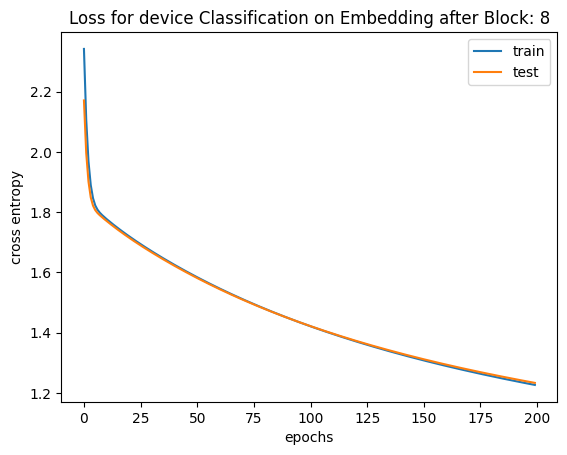

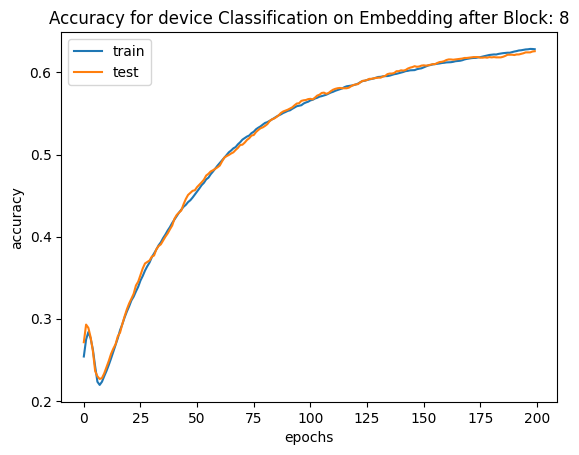

In [156]:
n_epochs = 200
batch_size = b_s
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# # Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters in the model are: {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of paramerters being trained: ", total_trainable_params)

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            labels = np.argmax(y_batch, axis=1)
            loss = criterion(y_pred, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if acc > best_acc:
        best_acc = acc

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)
list_val_acc.append(best_acc)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [157]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [158]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')

In [159]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
)

In [160]:
X_test=train_ready(test_data,col_name)

In [161]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred


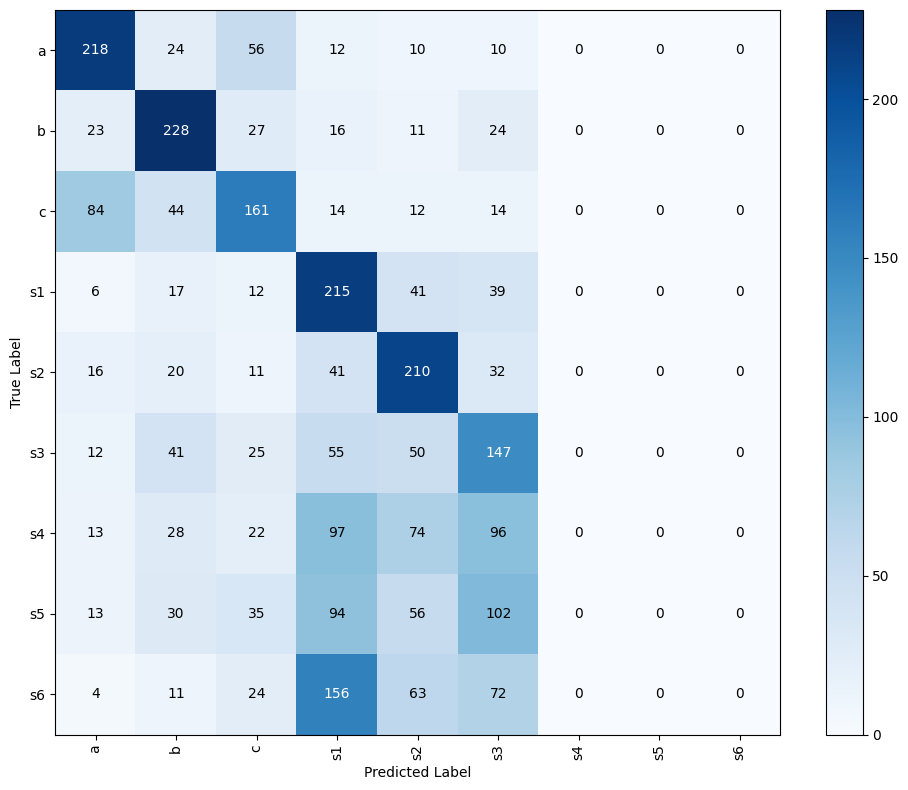

Accuracy: 0.3972


In [162]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-9

In [163]:
Block_number=9

In [164]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth',map_location=torch.device('cpu'))
new_fc3 = nn.Linear(256, 6)

# Replace the existing fc3 layer with the new one
model.fc3 = new_fc3

In [165]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [166]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [167]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [168]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 6)
(2793, 6)


In [169]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 198406
Number of parameters in the last layer is 1542


In [170]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [171]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)

In [172]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)

In [173]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 1542


In [174]:
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(weights_array))
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Total number of paramerters in the model are: 198406
Total number of paramerters being trained:  1542


Epoch 0: 100%|██████████| 43/43 [00:00<00:00, 474.11batch/s, acc=0.227, loss=2.24]


Epoch 0 validation: Cross-entropy=2.13, Accuracy=22.1%


Epoch 1: 100%|██████████| 43/43 [00:00<00:00, 484.92batch/s, acc=0.234, loss=2.07]


Epoch 1 validation: Cross-entropy=1.98, Accuracy=22.8%


Epoch 2: 100%|██████████| 43/43 [00:00<00:00, 244.12batch/s, acc=0.246, loss=1.97]


Epoch 2 validation: Cross-entropy=1.90, Accuracy=23.3%


Epoch 3: 100%|██████████| 43/43 [00:00<00:00, 298.59batch/s, acc=0.262, loss=1.91]


Epoch 3 validation: Cross-entropy=1.86, Accuracy=24.8%


Epoch 4: 100%|██████████| 43/43 [00:00<00:00, 287.91batch/s, acc=0.238, loss=1.87]


Epoch 4 validation: Cross-entropy=1.83, Accuracy=25.0%


Epoch 5: 100%|██████████| 43/43 [00:00<00:00, 529.55batch/s, acc=0.258, loss=1.84]


Epoch 5 validation: Cross-entropy=1.81, Accuracy=25.7%


Epoch 6: 100%|██████████| 43/43 [00:00<00:00, 332.46batch/s, acc=0.27, loss=1.83] 


Epoch 6 validation: Cross-entropy=1.79, Accuracy=26.7%


Epoch 7: 100%|██████████| 43/43 [00:00<00:00, 532.55batch/s, acc=0.301, loss=1.82]


Epoch 7 validation: Cross-entropy=1.78, Accuracy=28.5%


Epoch 8: 100%|██████████| 43/43 [00:00<00:00, 324.85batch/s, acc=0.312, loss=1.81]


Epoch 8 validation: Cross-entropy=1.77, Accuracy=29.4%


Epoch 9: 100%|██████████| 43/43 [00:00<00:00, 241.99batch/s, acc=0.316, loss=1.8] 


Epoch 9 validation: Cross-entropy=1.77, Accuracy=30.5%


Epoch 10: 100%|██████████| 43/43 [00:00<00:00, 523.71batch/s, acc=0.324, loss=1.79]


Epoch 10 validation: Cross-entropy=1.76, Accuracy=31.8%


Epoch 11: 100%|██████████| 43/43 [00:00<00:00, 311.40batch/s, acc=0.32, loss=1.78] 


Epoch 11 validation: Cross-entropy=1.75, Accuracy=32.5%


Epoch 12: 100%|██████████| 43/43 [00:00<00:00, 339.07batch/s, acc=0.336, loss=1.78]


Epoch 12 validation: Cross-entropy=1.74, Accuracy=33.2%


Epoch 13: 100%|██████████| 43/43 [00:00<00:00, 523.17batch/s, acc=0.34, loss=1.77] 


Epoch 13 validation: Cross-entropy=1.74, Accuracy=34.0%


Epoch 14: 100%|██████████| 43/43 [00:00<00:00, 240.91batch/s, acc=0.348, loss=1.76]


Epoch 14 validation: Cross-entropy=1.73, Accuracy=35.0%


Epoch 15: 100%|██████████| 43/43 [00:00<00:00, 340.71batch/s, acc=0.348, loss=1.76]


Epoch 15 validation: Cross-entropy=1.72, Accuracy=35.8%


Epoch 16: 100%|██████████| 43/43 [00:00<00:00, 439.19batch/s, acc=0.359, loss=1.75]


Epoch 16 validation: Cross-entropy=1.72, Accuracy=36.2%


Epoch 17: 100%|██████████| 43/43 [00:00<00:00, 522.49batch/s, acc=0.363, loss=1.74]


Epoch 17 validation: Cross-entropy=1.71, Accuracy=36.9%


Epoch 18: 100%|██████████| 43/43 [00:00<00:00, 285.48batch/s, acc=0.371, loss=1.74]


Epoch 18 validation: Cross-entropy=1.71, Accuracy=37.6%


Epoch 19: 100%|██████████| 43/43 [00:00<00:00, 360.17batch/s, acc=0.383, loss=1.73]


Epoch 19 validation: Cross-entropy=1.70, Accuracy=38.6%


Epoch 20: 100%|██████████| 43/43 [00:00<00:00, 496.88batch/s, acc=0.387, loss=1.72]


Epoch 20 validation: Cross-entropy=1.69, Accuracy=39.5%


Epoch 21: 100%|██████████| 43/43 [00:00<00:00, 301.89batch/s, acc=0.398, loss=1.72]


Epoch 21 validation: Cross-entropy=1.69, Accuracy=40.1%


Epoch 22: 100%|██████████| 43/43 [00:00<00:00, 513.74batch/s, acc=0.402, loss=1.71]


Epoch 22 validation: Cross-entropy=1.68, Accuracy=41.0%


Epoch 23: 100%|██████████| 43/43 [00:00<00:00, 481.35batch/s, acc=0.41, loss=1.7]  


Epoch 23 validation: Cross-entropy=1.68, Accuracy=42.0%


Epoch 24: 100%|██████████| 43/43 [00:00<00:00, 455.46batch/s, acc=0.418, loss=1.7] 


Epoch 24 validation: Cross-entropy=1.67, Accuracy=42.7%


Epoch 25: 100%|██████████| 43/43 [00:00<00:00, 460.79batch/s, acc=0.43, loss=1.69] 


Epoch 25 validation: Cross-entropy=1.67, Accuracy=43.4%


Epoch 26: 100%|██████████| 43/43 [00:00<00:00, 282.83batch/s, acc=0.441, loss=1.68]


Epoch 26 validation: Cross-entropy=1.66, Accuracy=43.9%


Epoch 27: 100%|██████████| 43/43 [00:00<00:00, 339.45batch/s, acc=0.457, loss=1.68]


Epoch 27 validation: Cross-entropy=1.65, Accuracy=44.7%


Epoch 28: 100%|██████████| 43/43 [00:00<00:00, 344.10batch/s, acc=0.469, loss=1.67]


Epoch 28 validation: Cross-entropy=1.65, Accuracy=45.3%


Epoch 29: 100%|██████████| 43/43 [00:00<00:00, 263.26batch/s, acc=0.477, loss=1.67]


Epoch 29 validation: Cross-entropy=1.64, Accuracy=46.3%


Epoch 30: 100%|██████████| 43/43 [00:00<00:00, 277.73batch/s, acc=0.473, loss=1.66]


Epoch 30 validation: Cross-entropy=1.64, Accuracy=47.0%


Epoch 31: 100%|██████████| 43/43 [00:00<00:00, 535.82batch/s, acc=0.473, loss=1.65]


Epoch 31 validation: Cross-entropy=1.63, Accuracy=47.4%


Epoch 32: 100%|██████████| 43/43 [00:00<00:00, 551.71batch/s, acc=0.48, loss=1.65] 


Epoch 32 validation: Cross-entropy=1.63, Accuracy=48.2%


Epoch 33: 100%|██████████| 43/43 [00:00<00:00, 538.39batch/s, acc=0.492, loss=1.64]


Epoch 33 validation: Cross-entropy=1.62, Accuracy=48.7%


Epoch 34: 100%|██████████| 43/43 [00:00<00:00, 301.50batch/s, acc=0.504, loss=1.64]


Epoch 34 validation: Cross-entropy=1.62, Accuracy=49.2%


Epoch 35: 100%|██████████| 43/43 [00:00<00:00, 472.64batch/s, acc=0.512, loss=1.63]


Epoch 35 validation: Cross-entropy=1.61, Accuracy=49.6%


Epoch 36: 100%|██████████| 43/43 [00:00<00:00, 302.18batch/s, acc=0.508, loss=1.63]


Epoch 36 validation: Cross-entropy=1.61, Accuracy=49.8%


Epoch 37: 100%|██████████| 43/43 [00:00<00:00, 305.88batch/s, acc=0.512, loss=1.62]


Epoch 37 validation: Cross-entropy=1.60, Accuracy=50.3%


Epoch 38: 100%|██████████| 43/43 [00:00<00:00, 404.07batch/s, acc=0.508, loss=1.61]


Epoch 38 validation: Cross-entropy=1.60, Accuracy=50.8%


Epoch 39: 100%|██████████| 43/43 [00:00<00:00, 249.91batch/s, acc=0.508, loss=1.61]


Epoch 39 validation: Cross-entropy=1.59, Accuracy=51.0%


Epoch 40: 100%|██████████| 43/43 [00:00<00:00, 476.46batch/s, acc=0.512, loss=1.6] 


Epoch 40 validation: Cross-entropy=1.59, Accuracy=51.4%


Epoch 41: 100%|██████████| 43/43 [00:00<00:00, 267.14batch/s, acc=0.512, loss=1.6] 


Epoch 41 validation: Cross-entropy=1.59, Accuracy=51.6%


Epoch 42: 100%|██████████| 43/43 [00:00<00:00, 503.13batch/s, acc=0.516, loss=1.59]


Epoch 42 validation: Cross-entropy=1.58, Accuracy=52.1%


Epoch 43: 100%|██████████| 43/43 [00:00<00:00, 276.88batch/s, acc=0.52, loss=1.59] 


Epoch 43 validation: Cross-entropy=1.58, Accuracy=52.4%


Epoch 44: 100%|██████████| 43/43 [00:00<00:00, 481.14batch/s, acc=0.523, loss=1.58]


Epoch 44 validation: Cross-entropy=1.57, Accuracy=52.7%


Epoch 45: 100%|██████████| 43/43 [00:00<00:00, 488.44batch/s, acc=0.531, loss=1.58]


Epoch 45 validation: Cross-entropy=1.57, Accuracy=52.8%


Epoch 46: 100%|██████████| 43/43 [00:00<00:00, 356.57batch/s, acc=0.535, loss=1.57]


Epoch 46 validation: Cross-entropy=1.56, Accuracy=53.3%


Epoch 47: 100%|██████████| 43/43 [00:00<00:00, 501.36batch/s, acc=0.543, loss=1.57]


Epoch 47 validation: Cross-entropy=1.56, Accuracy=53.5%


Epoch 48: 100%|██████████| 43/43 [00:00<00:00, 505.94batch/s, acc=0.547, loss=1.56]


Epoch 48 validation: Cross-entropy=1.55, Accuracy=53.9%


Epoch 49: 100%|██████████| 43/43 [00:00<00:00, 283.83batch/s, acc=0.551, loss=1.56]


Epoch 49 validation: Cross-entropy=1.55, Accuracy=54.1%


Epoch 50: 100%|██████████| 43/43 [00:00<00:00, 521.30batch/s, acc=0.559, loss=1.55]


Epoch 50 validation: Cross-entropy=1.54, Accuracy=54.4%


Epoch 51: 100%|██████████| 43/43 [00:00<00:00, 534.31batch/s, acc=0.562, loss=1.55]


Epoch 51 validation: Cross-entropy=1.54, Accuracy=54.7%


Epoch 52: 100%|██████████| 43/43 [00:00<00:00, 252.23batch/s, acc=0.57, loss=1.54] 


Epoch 52 validation: Cross-entropy=1.54, Accuracy=55.1%


Epoch 53: 100%|██████████| 43/43 [00:00<00:00, 538.28batch/s, acc=0.582, loss=1.54]


Epoch 53 validation: Cross-entropy=1.53, Accuracy=55.4%


Epoch 54: 100%|██████████| 43/43 [00:00<00:00, 260.37batch/s, acc=0.594, loss=1.53]


Epoch 54 validation: Cross-entropy=1.53, Accuracy=55.5%


Epoch 55: 100%|██████████| 43/43 [00:00<00:00, 530.81batch/s, acc=0.594, loss=1.53]


Epoch 55 validation: Cross-entropy=1.52, Accuracy=55.7%


Epoch 56: 100%|██████████| 43/43 [00:00<00:00, 325.15batch/s, acc=0.594, loss=1.52]


Epoch 56 validation: Cross-entropy=1.52, Accuracy=56.0%


Epoch 57: 100%|██████████| 43/43 [00:00<00:00, 424.42batch/s, acc=0.586, loss=1.52]


Epoch 57 validation: Cross-entropy=1.52, Accuracy=56.2%


Epoch 58: 100%|██████████| 43/43 [00:00<00:00, 534.29batch/s, acc=0.586, loss=1.51]


Epoch 58 validation: Cross-entropy=1.51, Accuracy=56.4%


Epoch 59: 100%|██████████| 43/43 [00:00<00:00, 285.19batch/s, acc=0.586, loss=1.51]


Epoch 59 validation: Cross-entropy=1.51, Accuracy=56.5%


Epoch 60: 100%|██████████| 43/43 [00:00<00:00, 541.86batch/s, acc=0.59, loss=1.5]  


Epoch 60 validation: Cross-entropy=1.50, Accuracy=56.7%


Epoch 61: 100%|██████████| 43/43 [00:00<00:00, 506.12batch/s, acc=0.59, loss=1.5]  


Epoch 61 validation: Cross-entropy=1.50, Accuracy=57.0%


Epoch 62: 100%|██████████| 43/43 [00:00<00:00, 262.14batch/s, acc=0.59, loss=1.5]  


Epoch 62 validation: Cross-entropy=1.50, Accuracy=57.1%


Epoch 63: 100%|██████████| 43/43 [00:00<00:00, 538.55batch/s, acc=0.59, loss=1.49] 


Epoch 63 validation: Cross-entropy=1.49, Accuracy=57.2%


Epoch 64: 100%|██████████| 43/43 [00:00<00:00, 495.69batch/s, acc=0.594, loss=1.49]


Epoch 64 validation: Cross-entropy=1.49, Accuracy=57.3%


Epoch 65: 100%|██████████| 43/43 [00:00<00:00, 272.72batch/s, acc=0.598, loss=1.48]


Epoch 65 validation: Cross-entropy=1.48, Accuracy=57.5%


Epoch 66: 100%|██████████| 43/43 [00:00<00:00, 507.81batch/s, acc=0.602, loss=1.48]


Epoch 66 validation: Cross-entropy=1.48, Accuracy=57.7%


Epoch 67: 100%|██████████| 43/43 [00:00<00:00, 510.17batch/s, acc=0.602, loss=1.47]


Epoch 67 validation: Cross-entropy=1.48, Accuracy=57.8%


Epoch 68: 100%|██████████| 43/43 [00:00<00:00, 320.40batch/s, acc=0.613, loss=1.47]


Epoch 68 validation: Cross-entropy=1.47, Accuracy=58.0%


Epoch 69: 100%|██████████| 43/43 [00:00<00:00, 538.07batch/s, acc=0.609, loss=1.47]


Epoch 69 validation: Cross-entropy=1.47, Accuracy=58.0%


Epoch 70: 100%|██████████| 43/43 [00:00<00:00, 216.96batch/s, acc=0.613, loss=1.46]


Epoch 70 validation: Cross-entropy=1.47, Accuracy=58.2%


Epoch 71: 100%|██████████| 43/43 [00:00<00:00, 538.14batch/s, acc=0.613, loss=1.46]


Epoch 71 validation: Cross-entropy=1.46, Accuracy=58.3%


Epoch 72: 100%|██████████| 43/43 [00:00<00:00, 539.49batch/s, acc=0.617, loss=1.45]


Epoch 72 validation: Cross-entropy=1.46, Accuracy=58.4%


Epoch 73: 100%|██████████| 43/43 [00:00<00:00, 545.22batch/s, acc=0.621, loss=1.45]


Epoch 73 validation: Cross-entropy=1.46, Accuracy=58.7%


Epoch 74: 100%|██████████| 43/43 [00:00<00:00, 276.18batch/s, acc=0.625, loss=1.44]


Epoch 74 validation: Cross-entropy=1.45, Accuracy=58.7%


Epoch 75: 100%|██████████| 43/43 [00:00<00:00, 566.92batch/s, acc=0.621, loss=1.44]


Epoch 75 validation: Cross-entropy=1.45, Accuracy=58.9%


Epoch 76: 100%|██████████| 43/43 [00:00<00:00, 465.20batch/s, acc=0.621, loss=1.44]


Epoch 76 validation: Cross-entropy=1.44, Accuracy=59.1%


Epoch 77: 100%|██████████| 43/43 [00:00<00:00, 270.05batch/s, acc=0.625, loss=1.43]


Epoch 77 validation: Cross-entropy=1.44, Accuracy=59.3%


Epoch 78: 100%|██████████| 43/43 [00:00<00:00, 521.50batch/s, acc=0.625, loss=1.43]


Epoch 78 validation: Cross-entropy=1.44, Accuracy=59.5%


Epoch 79: 100%|██████████| 43/43 [00:00<00:00, 519.89batch/s, acc=0.625, loss=1.42]


Epoch 79 validation: Cross-entropy=1.43, Accuracy=59.7%


Epoch 80: 100%|██████████| 43/43 [00:00<00:00, 340.52batch/s, acc=0.625, loss=1.42]


Epoch 80 validation: Cross-entropy=1.43, Accuracy=59.9%


Epoch 81: 100%|██████████| 43/43 [00:00<00:00, 524.62batch/s, acc=0.625, loss=1.42]


Epoch 81 validation: Cross-entropy=1.43, Accuracy=59.9%


Epoch 82: 100%|██████████| 43/43 [00:00<00:00, 547.16batch/s, acc=0.633, loss=1.41]


Epoch 82 validation: Cross-entropy=1.42, Accuracy=60.0%


Epoch 83: 100%|██████████| 43/43 [00:00<00:00, 339.42batch/s, acc=0.629, loss=1.41]


Epoch 83 validation: Cross-entropy=1.42, Accuracy=60.4%


Epoch 84: 100%|██████████| 43/43 [00:00<00:00, 473.79batch/s, acc=0.629, loss=1.4] 


Epoch 84 validation: Cross-entropy=1.42, Accuracy=60.4%


Epoch 85: 100%|██████████| 43/43 [00:00<00:00, 541.45batch/s, acc=0.625, loss=1.4] 


Epoch 85 validation: Cross-entropy=1.41, Accuracy=60.7%


Epoch 86: 100%|██████████| 43/43 [00:00<00:00, 430.75batch/s, acc=0.625, loss=1.4] 


Epoch 86 validation: Cross-entropy=1.41, Accuracy=60.7%


Epoch 87: 100%|██████████| 43/43 [00:00<00:00, 383.60batch/s, acc=0.629, loss=1.39]


Epoch 87 validation: Cross-entropy=1.41, Accuracy=60.7%


Epoch 88: 100%|██████████| 43/43 [00:00<00:00, 508.58batch/s, acc=0.629, loss=1.39]


Epoch 88 validation: Cross-entropy=1.41, Accuracy=60.8%


Epoch 89: 100%|██████████| 43/43 [00:00<00:00, 534.46batch/s, acc=0.633, loss=1.39]


Epoch 89 validation: Cross-entropy=1.40, Accuracy=61.1%


Epoch 90: 100%|██████████| 43/43 [00:00<00:00, 284.26batch/s, acc=0.633, loss=1.38]


Epoch 90 validation: Cross-entropy=1.40, Accuracy=61.2%


Epoch 91: 100%|██████████| 43/43 [00:00<00:00, 537.24batch/s, acc=0.637, loss=1.38]


Epoch 91 validation: Cross-entropy=1.40, Accuracy=61.2%


Epoch 92: 100%|██████████| 43/43 [00:00<00:00, 582.43batch/s, acc=0.641, loss=1.38]


Epoch 92 validation: Cross-entropy=1.39, Accuracy=61.3%


Epoch 93: 100%|██████████| 43/43 [00:00<00:00, 570.90batch/s, acc=0.648, loss=1.37]


Epoch 93 validation: Cross-entropy=1.39, Accuracy=61.4%


Epoch 94: 100%|██████████| 43/43 [00:00<00:00, 274.86batch/s, acc=0.652, loss=1.37]


Epoch 94 validation: Cross-entropy=1.39, Accuracy=61.5%


Epoch 95: 100%|██████████| 43/43 [00:00<00:00, 536.01batch/s, acc=0.652, loss=1.36]


Epoch 95 validation: Cross-entropy=1.38, Accuracy=61.8%


Epoch 96: 100%|██████████| 43/43 [00:00<00:00, 504.09batch/s, acc=0.656, loss=1.36]


Epoch 96 validation: Cross-entropy=1.38, Accuracy=61.9%


Epoch 97: 100%|██████████| 43/43 [00:00<00:00, 257.24batch/s, acc=0.656, loss=1.36]


Epoch 97 validation: Cross-entropy=1.38, Accuracy=62.1%


Epoch 98: 100%|██████████| 43/43 [00:00<00:00, 525.99batch/s, acc=0.656, loss=1.35]


Epoch 98 validation: Cross-entropy=1.37, Accuracy=62.0%


Epoch 99: 100%|██████████| 43/43 [00:00<00:00, 539.29batch/s, acc=0.656, loss=1.35]


Epoch 99 validation: Cross-entropy=1.37, Accuracy=62.0%


Epoch 100: 100%|██████████| 43/43 [00:00<00:00, 224.78batch/s, acc=0.656, loss=1.35]


Epoch 100 validation: Cross-entropy=1.37, Accuracy=62.0%


Epoch 101: 100%|██████████| 43/43 [00:00<00:00, 478.16batch/s, acc=0.656, loss=1.34]


Epoch 101 validation: Cross-entropy=1.37, Accuracy=62.1%


Epoch 102: 100%|██████████| 43/43 [00:00<00:00, 543.80batch/s, acc=0.66, loss=1.34] 


Epoch 102 validation: Cross-entropy=1.36, Accuracy=62.3%


Epoch 103: 100%|██████████| 43/43 [00:00<00:00, 276.55batch/s, acc=0.664, loss=1.34]


Epoch 103 validation: Cross-entropy=1.36, Accuracy=62.4%


Epoch 104: 100%|██████████| 43/43 [00:00<00:00, 531.94batch/s, acc=0.664, loss=1.33]


Epoch 104 validation: Cross-entropy=1.36, Accuracy=62.4%


Epoch 105: 100%|██████████| 43/43 [00:00<00:00, 547.67batch/s, acc=0.668, loss=1.33]


Epoch 105 validation: Cross-entropy=1.35, Accuracy=62.5%


Epoch 106: 100%|██████████| 43/43 [00:00<00:00, 567.95batch/s, acc=0.668, loss=1.33]


Epoch 106 validation: Cross-entropy=1.35, Accuracy=62.6%


Epoch 107: 100%|██████████| 43/43 [00:00<00:00, 300.70batch/s, acc=0.672, loss=1.32]


Epoch 107 validation: Cross-entropy=1.35, Accuracy=62.8%


Epoch 108: 100%|██████████| 43/43 [00:00<00:00, 546.03batch/s, acc=0.676, loss=1.32]


Epoch 108 validation: Cross-entropy=1.35, Accuracy=62.9%


Epoch 109: 100%|██████████| 43/43 [00:00<00:00, 563.15batch/s, acc=0.676, loss=1.32]


Epoch 109 validation: Cross-entropy=1.34, Accuracy=62.9%


Epoch 110: 100%|██████████| 43/43 [00:00<00:00, 278.05batch/s, acc=0.68, loss=1.32] 


Epoch 110 validation: Cross-entropy=1.34, Accuracy=62.8%


Epoch 111: 100%|██████████| 43/43 [00:00<00:00, 530.34batch/s, acc=0.684, loss=1.31]


Epoch 111 validation: Cross-entropy=1.34, Accuracy=62.9%


Epoch 112: 100%|██████████| 43/43 [00:00<00:00, 557.41batch/s, acc=0.684, loss=1.31]


Epoch 112 validation: Cross-entropy=1.34, Accuracy=62.9%


Epoch 113: 100%|██████████| 43/43 [00:00<00:00, 538.96batch/s, acc=0.684, loss=1.31]


Epoch 113 validation: Cross-entropy=1.33, Accuracy=63.0%


Epoch 114: 100%|██████████| 43/43 [00:00<00:00, 305.33batch/s, acc=0.684, loss=1.3] 


Epoch 114 validation: Cross-entropy=1.33, Accuracy=63.0%


Epoch 115: 100%|██████████| 43/43 [00:00<00:00, 547.98batch/s, acc=0.688, loss=1.3] 


Epoch 115 validation: Cross-entropy=1.33, Accuracy=63.1%


Epoch 116: 100%|██████████| 43/43 [00:00<00:00, 549.28batch/s, acc=0.688, loss=1.3] 


Epoch 116 validation: Cross-entropy=1.33, Accuracy=63.1%


Epoch 117: 100%|██████████| 43/43 [00:00<00:00, 363.27batch/s, acc=0.684, loss=1.29]


Epoch 117 validation: Cross-entropy=1.32, Accuracy=63.1%


Epoch 118: 100%|██████████| 43/43 [00:00<00:00, 440.57batch/s, acc=0.684, loss=1.29]


Epoch 118 validation: Cross-entropy=1.32, Accuracy=63.2%


Epoch 119: 100%|██████████| 43/43 [00:00<00:00, 545.77batch/s, acc=0.68, loss=1.29] 


Epoch 119 validation: Cross-entropy=1.32, Accuracy=63.2%


Epoch 120: 100%|██████████| 43/43 [00:00<00:00, 525.70batch/s, acc=0.68, loss=1.29] 


Epoch 120 validation: Cross-entropy=1.32, Accuracy=63.3%


Epoch 121: 100%|██████████| 43/43 [00:00<00:00, 320.34batch/s, acc=0.68, loss=1.28] 


Epoch 121 validation: Cross-entropy=1.31, Accuracy=63.3%


Epoch 122: 100%|██████████| 43/43 [00:00<00:00, 547.44batch/s, acc=0.68, loss=1.28] 


Epoch 122 validation: Cross-entropy=1.31, Accuracy=63.5%


Epoch 123: 100%|██████████| 43/43 [00:00<00:00, 530.32batch/s, acc=0.68, loss=1.28] 


Epoch 123 validation: Cross-entropy=1.31, Accuracy=63.6%


Epoch 124: 100%|██████████| 43/43 [00:00<00:00, 436.27batch/s, acc=0.684, loss=1.27]


Epoch 124 validation: Cross-entropy=1.31, Accuracy=63.6%


Epoch 125: 100%|██████████| 43/43 [00:00<00:00, 385.45batch/s, acc=0.684, loss=1.27]


Epoch 125 validation: Cross-entropy=1.30, Accuracy=63.7%


Epoch 126: 100%|██████████| 43/43 [00:00<00:00, 535.31batch/s, acc=0.684, loss=1.27]


Epoch 126 validation: Cross-entropy=1.30, Accuracy=63.7%


Epoch 127: 100%|██████████| 43/43 [00:00<00:00, 509.06batch/s, acc=0.684, loss=1.27]


Epoch 127 validation: Cross-entropy=1.30, Accuracy=63.8%


Epoch 128: 100%|██████████| 43/43 [00:00<00:00, 536.98batch/s, acc=0.684, loss=1.26]


Epoch 128 validation: Cross-entropy=1.30, Accuracy=63.8%


Epoch 129: 100%|██████████| 43/43 [00:00<00:00, 280.65batch/s, acc=0.688, loss=1.26]


Epoch 129 validation: Cross-entropy=1.29, Accuracy=63.8%


Epoch 130: 100%|██████████| 43/43 [00:00<00:00, 537.80batch/s, acc=0.691, loss=1.26]


Epoch 130 validation: Cross-entropy=1.29, Accuracy=63.8%


Epoch 131: 100%|██████████| 43/43 [00:00<00:00, 544.17batch/s, acc=0.684, loss=1.25]


Epoch 131 validation: Cross-entropy=1.29, Accuracy=63.8%


Epoch 132: 100%|██████████| 43/43 [00:00<00:00, 286.08batch/s, acc=0.684, loss=1.25]


Epoch 132 validation: Cross-entropy=1.29, Accuracy=63.8%


Epoch 133: 100%|██████████| 43/43 [00:00<00:00, 584.33batch/s, acc=0.684, loss=1.25]


Epoch 133 validation: Cross-entropy=1.28, Accuracy=63.9%


Epoch 134: 100%|██████████| 43/43 [00:00<00:00, 530.36batch/s, acc=0.684, loss=1.25]


Epoch 134 validation: Cross-entropy=1.28, Accuracy=63.9%


Epoch 135: 100%|██████████| 43/43 [00:00<00:00, 306.01batch/s, acc=0.684, loss=1.24]


Epoch 135 validation: Cross-entropy=1.28, Accuracy=63.8%


Epoch 136: 100%|██████████| 43/43 [00:00<00:00, 493.62batch/s, acc=0.684, loss=1.24]


Epoch 136 validation: Cross-entropy=1.28, Accuracy=63.8%


Epoch 137: 100%|██████████| 43/43 [00:00<00:00, 513.81batch/s, acc=0.676, loss=1.24]


Epoch 137 validation: Cross-entropy=1.28, Accuracy=64.0%


Epoch 138: 100%|██████████| 43/43 [00:00<00:00, 520.73batch/s, acc=0.676, loss=1.24]


Epoch 138 validation: Cross-entropy=1.27, Accuracy=64.0%


Epoch 139: 100%|██████████| 43/43 [00:00<00:00, 222.36batch/s, acc=0.68, loss=1.23] 


Epoch 139 validation: Cross-entropy=1.27, Accuracy=64.1%


Epoch 140: 100%|██████████| 43/43 [00:00<00:00, 448.12batch/s, acc=0.68, loss=1.23] 


Epoch 140 validation: Cross-entropy=1.27, Accuracy=64.2%


Epoch 141: 100%|██████████| 43/43 [00:00<00:00, 550.14batch/s, acc=0.68, loss=1.23] 


Epoch 141 validation: Cross-entropy=1.27, Accuracy=64.2%


Epoch 142: 100%|██████████| 43/43 [00:00<00:00, 302.51batch/s, acc=0.684, loss=1.23]


Epoch 142 validation: Cross-entropy=1.26, Accuracy=64.2%


Epoch 143: 100%|██████████| 43/43 [00:00<00:00, 562.35batch/s, acc=0.684, loss=1.22]


Epoch 143 validation: Cross-entropy=1.26, Accuracy=64.3%


Epoch 144: 100%|██████████| 43/43 [00:00<00:00, 542.19batch/s, acc=0.684, loss=1.22]


Epoch 144 validation: Cross-entropy=1.26, Accuracy=64.3%


Epoch 145: 100%|██████████| 43/43 [00:00<00:00, 277.54batch/s, acc=0.684, loss=1.22]


Epoch 145 validation: Cross-entropy=1.26, Accuracy=64.4%


Epoch 146: 100%|██████████| 43/43 [00:00<00:00, 521.24batch/s, acc=0.684, loss=1.22]


Epoch 146 validation: Cross-entropy=1.26, Accuracy=64.4%


Epoch 147: 100%|██████████| 43/43 [00:00<00:00, 527.57batch/s, acc=0.684, loss=1.21]


Epoch 147 validation: Cross-entropy=1.25, Accuracy=64.6%


Epoch 148: 100%|██████████| 43/43 [00:00<00:00, 475.78batch/s, acc=0.684, loss=1.21]


Epoch 148 validation: Cross-entropy=1.25, Accuracy=64.6%


Epoch 149: 100%|██████████| 43/43 [00:00<00:00, 291.09batch/s, acc=0.684, loss=1.21]


Epoch 149 validation: Cross-entropy=1.25, Accuracy=64.6%


Epoch 150: 100%|██████████| 43/43 [00:00<00:00, 430.17batch/s, acc=0.684, loss=1.21]


Epoch 150 validation: Cross-entropy=1.25, Accuracy=64.8%


Epoch 151: 100%|██████████| 43/43 [00:00<00:00, 424.51batch/s, acc=0.684, loss=1.2] 


Epoch 151 validation: Cross-entropy=1.25, Accuracy=64.8%


Epoch 152: 100%|██████████| 43/43 [00:00<00:00, 279.43batch/s, acc=0.68, loss=1.2]  


Epoch 152 validation: Cross-entropy=1.24, Accuracy=64.8%


Epoch 153: 100%|██████████| 43/43 [00:00<00:00, 489.22batch/s, acc=0.68, loss=1.2]  


Epoch 153 validation: Cross-entropy=1.24, Accuracy=64.9%


Epoch 154: 100%|██████████| 43/43 [00:00<00:00, 311.46batch/s, acc=0.68, loss=1.2]  


Epoch 154 validation: Cross-entropy=1.24, Accuracy=64.9%


Epoch 155: 100%|██████████| 43/43 [00:00<00:00, 403.71batch/s, acc=0.68, loss=1.19] 


Epoch 155 validation: Cross-entropy=1.24, Accuracy=64.9%


Epoch 156: 100%|██████████| 43/43 [00:00<00:00, 513.39batch/s, acc=0.68, loss=1.19] 


Epoch 156 validation: Cross-entropy=1.24, Accuracy=64.9%


Epoch 157: 100%|██████████| 43/43 [00:00<00:00, 255.91batch/s, acc=0.68, loss=1.19] 


Epoch 157 validation: Cross-entropy=1.23, Accuracy=65.0%


Epoch 158: 100%|██████████| 43/43 [00:00<00:00, 509.67batch/s, acc=0.68, loss=1.19] 


Epoch 158 validation: Cross-entropy=1.23, Accuracy=65.1%


Epoch 159: 100%|██████████| 43/43 [00:00<00:00, 503.53batch/s, acc=0.68, loss=1.18] 


Epoch 159 validation: Cross-entropy=1.23, Accuracy=65.2%


Epoch 160: 100%|██████████| 43/43 [00:00<00:00, 243.67batch/s, acc=0.68, loss=1.18] 


Epoch 160 validation: Cross-entropy=1.23, Accuracy=65.3%


Epoch 161: 100%|██████████| 43/43 [00:00<00:00, 525.29batch/s, acc=0.68, loss=1.18] 


Epoch 161 validation: Cross-entropy=1.23, Accuracy=65.3%


Epoch 162: 100%|██████████| 43/43 [00:00<00:00, 250.56batch/s, acc=0.68, loss=1.18] 


Epoch 162 validation: Cross-entropy=1.22, Accuracy=65.3%


Epoch 163: 100%|██████████| 43/43 [00:00<00:00, 528.80batch/s, acc=0.68, loss=1.18] 


Epoch 163 validation: Cross-entropy=1.22, Accuracy=65.4%


Epoch 164: 100%|██████████| 43/43 [00:00<00:00, 543.84batch/s, acc=0.68, loss=1.17] 


Epoch 164 validation: Cross-entropy=1.22, Accuracy=65.4%


Epoch 165: 100%|██████████| 43/43 [00:00<00:00, 288.65batch/s, acc=0.68, loss=1.17] 


Epoch 165 validation: Cross-entropy=1.22, Accuracy=65.6%


Epoch 166: 100%|██████████| 43/43 [00:00<00:00, 540.76batch/s, acc=0.68, loss=1.17] 


Epoch 166 validation: Cross-entropy=1.22, Accuracy=65.6%


Epoch 167: 100%|██████████| 43/43 [00:00<00:00, 540.35batch/s, acc=0.68, loss=1.17] 


Epoch 167 validation: Cross-entropy=1.21, Accuracy=65.7%


Epoch 168: 100%|██████████| 43/43 [00:00<00:00, 534.51batch/s, acc=0.68, loss=1.16] 


Epoch 168 validation: Cross-entropy=1.21, Accuracy=65.8%


Epoch 169: 100%|██████████| 43/43 [00:00<00:00, 297.98batch/s, acc=0.684, loss=1.16]


Epoch 169 validation: Cross-entropy=1.21, Accuracy=65.9%


Epoch 170: 100%|██████████| 43/43 [00:00<00:00, 523.49batch/s, acc=0.684, loss=1.16]


Epoch 170 validation: Cross-entropy=1.21, Accuracy=65.9%


Epoch 171: 100%|██████████| 43/43 [00:00<00:00, 527.41batch/s, acc=0.684, loss=1.16]


Epoch 171 validation: Cross-entropy=1.21, Accuracy=66.0%


Epoch 172: 100%|██████████| 43/43 [00:00<00:00, 243.81batch/s, acc=0.688, loss=1.16]


Epoch 172 validation: Cross-entropy=1.20, Accuracy=65.9%


Epoch 173: 100%|██████████| 43/43 [00:00<00:00, 511.99batch/s, acc=0.688, loss=1.15]


Epoch 173 validation: Cross-entropy=1.20, Accuracy=66.0%


Epoch 174: 100%|██████████| 43/43 [00:00<00:00, 273.61batch/s, acc=0.688, loss=1.15]


Epoch 174 validation: Cross-entropy=1.20, Accuracy=66.0%


Epoch 175: 100%|██████████| 43/43 [00:00<00:00, 459.54batch/s, acc=0.688, loss=1.15]


Epoch 175 validation: Cross-entropy=1.20, Accuracy=66.0%


Epoch 176: 100%|██████████| 43/43 [00:00<00:00, 522.52batch/s, acc=0.688, loss=1.15]


Epoch 176 validation: Cross-entropy=1.20, Accuracy=66.0%


Epoch 177: 100%|██████████| 43/43 [00:00<00:00, 279.02batch/s, acc=0.688, loss=1.15]


Epoch 177 validation: Cross-entropy=1.20, Accuracy=66.1%


Epoch 178: 100%|██████████| 43/43 [00:00<00:00, 515.77batch/s, acc=0.688, loss=1.14]


Epoch 178 validation: Cross-entropy=1.19, Accuracy=66.2%


Epoch 179: 100%|██████████| 43/43 [00:00<00:00, 371.77batch/s, acc=0.688, loss=1.14]


Epoch 179 validation: Cross-entropy=1.19, Accuracy=66.3%


Epoch 180: 100%|██████████| 43/43 [00:00<00:00, 387.41batch/s, acc=0.688, loss=1.14]


Epoch 180 validation: Cross-entropy=1.19, Accuracy=66.3%


Epoch 181: 100%|██████████| 43/43 [00:00<00:00, 525.95batch/s, acc=0.688, loss=1.14]


Epoch 181 validation: Cross-entropy=1.19, Accuracy=66.4%


Epoch 182: 100%|██████████| 43/43 [00:00<00:00, 553.47batch/s, acc=0.688, loss=1.14]


Epoch 182 validation: Cross-entropy=1.19, Accuracy=66.4%


Epoch 183: 100%|██████████| 43/43 [00:00<00:00, 305.91batch/s, acc=0.688, loss=1.13]


Epoch 183 validation: Cross-entropy=1.19, Accuracy=66.5%


Epoch 184: 100%|██████████| 43/43 [00:00<00:00, 538.68batch/s, acc=0.688, loss=1.13]


Epoch 184 validation: Cross-entropy=1.18, Accuracy=66.4%


Epoch 185: 100%|██████████| 43/43 [00:00<00:00, 200.94batch/s, acc=0.688, loss=1.13]


Epoch 185 validation: Cross-entropy=1.18, Accuracy=66.5%


Epoch 186: 100%|██████████| 43/43 [00:00<00:00, 507.85batch/s, acc=0.684, loss=1.13]


Epoch 186 validation: Cross-entropy=1.18, Accuracy=66.6%


Epoch 187: 100%|██████████| 43/43 [00:00<00:00, 523.69batch/s, acc=0.684, loss=1.13]


Epoch 187 validation: Cross-entropy=1.18, Accuracy=66.6%


Epoch 188: 100%|██████████| 43/43 [00:00<00:00, 256.72batch/s, acc=0.684, loss=1.12]


Epoch 188 validation: Cross-entropy=1.18, Accuracy=66.6%


Epoch 189: 100%|██████████| 43/43 [00:00<00:00, 595.17batch/s, acc=0.684, loss=1.12]


Epoch 189 validation: Cross-entropy=1.18, Accuracy=66.6%


Epoch 190: 100%|██████████| 43/43 [00:00<00:00, 240.25batch/s, acc=0.684, loss=1.12]


Epoch 190 validation: Cross-entropy=1.17, Accuracy=66.6%


Epoch 191: 100%|██████████| 43/43 [00:00<00:00, 527.17batch/s, acc=0.688, loss=1.12]


Epoch 191 validation: Cross-entropy=1.17, Accuracy=66.7%


Epoch 192: 100%|██████████| 43/43 [00:00<00:00, 555.03batch/s, acc=0.691, loss=1.12]


Epoch 192 validation: Cross-entropy=1.17, Accuracy=66.7%


Epoch 193: 100%|██████████| 43/43 [00:00<00:00, 269.18batch/s, acc=0.691, loss=1.11]


Epoch 193 validation: Cross-entropy=1.17, Accuracy=66.7%


Epoch 194: 100%|██████████| 43/43 [00:00<00:00, 536.76batch/s, acc=0.691, loss=1.11]


Epoch 194 validation: Cross-entropy=1.17, Accuracy=66.8%


Epoch 195: 100%|██████████| 43/43 [00:00<00:00, 536.69batch/s, acc=0.691, loss=1.11]


Epoch 195 validation: Cross-entropy=1.17, Accuracy=66.8%


Epoch 196: 100%|██████████| 43/43 [00:00<00:00, 294.05batch/s, acc=0.691, loss=1.11]


Epoch 196 validation: Cross-entropy=1.16, Accuracy=66.8%


Epoch 197: 100%|██████████| 43/43 [00:00<00:00, 521.72batch/s, acc=0.691, loss=1.11]


Epoch 197 validation: Cross-entropy=1.16, Accuracy=66.9%


Epoch 198: 100%|██████████| 43/43 [00:00<00:00, 537.08batch/s, acc=0.691, loss=1.11]


Epoch 198 validation: Cross-entropy=1.16, Accuracy=66.8%


Epoch 199: 100%|██████████| 43/43 [00:00<00:00, 276.64batch/s, acc=0.691, loss=1.1] 


Epoch 199 validation: Cross-entropy=1.16, Accuracy=66.9%


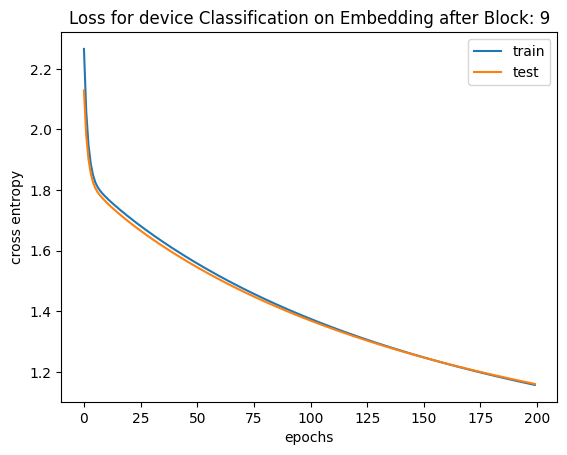

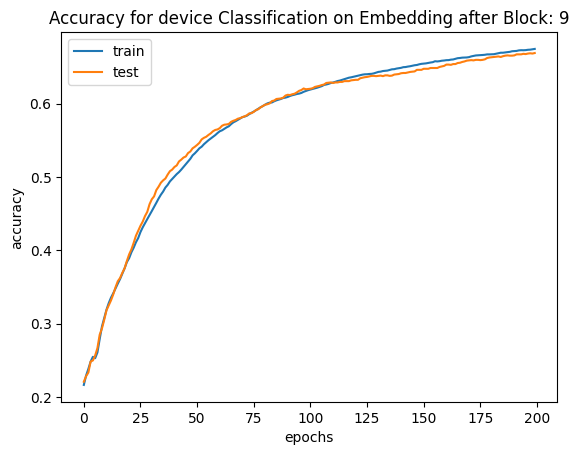

In [175]:
n_epochs = 200
batch_size = b_s
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# # Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters in the model are: {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of paramerters being trained: ", total_trainable_params)

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            labels = np.argmax(y_batch, axis=1)
            loss = criterion(y_pred, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if acc > best_acc:
        best_acc = acc

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)
list_val_acc.append(best_acc)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [176]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [177]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')

In [178]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
)

In [179]:
X_test=train_ready(test_data,col_name)

In [180]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred


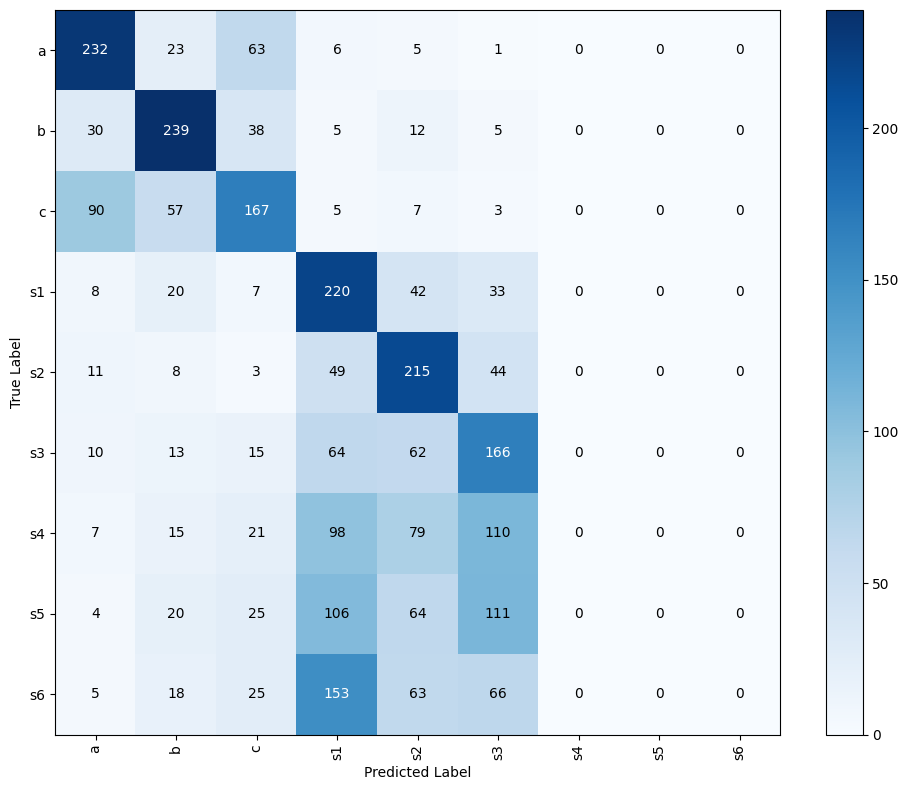

Accuracy: 0.4175


In [181]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-10

In [182]:
Block_number=10

In [183]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth',map_location=torch.device('cpu'))
new_fc3 = nn.Linear(256, 6)

# Replace the existing fc3 layer with the new one
model.fc3 = new_fc3

In [184]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [185]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [186]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [187]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 6)
(2793, 6)


In [188]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 198406
Number of parameters in the last layer is 1542


In [189]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [190]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)

In [191]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 1542


In [192]:
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(weights_array))
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Total number of paramerters in the model are: 198406
Total number of paramerters being trained:  1542


Epoch 0: 100%|██████████| 43/43 [00:00<00:00, 524.44batch/s, acc=0.168, loss=2.26] 


Epoch 0 validation: Cross-entropy=2.15, Accuracy=15.4%


Epoch 1: 100%|██████████| 43/43 [00:00<00:00, 269.29batch/s, acc=0.207, loss=2.04]


Epoch 1 validation: Cross-entropy=1.98, Accuracy=19.6%


Epoch 2: 100%|██████████| 43/43 [00:00<00:00, 360.20batch/s, acc=0.227, loss=1.92]


Epoch 2 validation: Cross-entropy=1.89, Accuracy=22.1%


Epoch 3: 100%|██████████| 43/43 [00:00<00:00, 379.69batch/s, acc=0.227, loss=1.86]


Epoch 3 validation: Cross-entropy=1.84, Accuracy=22.9%


Epoch 4: 100%|██████████| 43/43 [00:00<00:00, 277.13batch/s, acc=0.238, loss=1.82]


Epoch 4 validation: Cross-entropy=1.82, Accuracy=23.2%


Epoch 5: 100%|██████████| 43/43 [00:00<00:00, 513.78batch/s, acc=0.254, loss=1.8] 


Epoch 5 validation: Cross-entropy=1.81, Accuracy=24.0%


Epoch 6: 100%|██████████| 43/43 [00:00<00:00, 506.19batch/s, acc=0.242, loss=1.78]


Epoch 6 validation: Cross-entropy=1.80, Accuracy=24.1%


Epoch 7: 100%|██████████| 43/43 [00:00<00:00, 309.67batch/s, acc=0.266, loss=1.77]


Epoch 7 validation: Cross-entropy=1.79, Accuracy=24.8%


Epoch 8: 100%|██████████| 43/43 [00:00<00:00, 535.01batch/s, acc=0.262, loss=1.76]


Epoch 8 validation: Cross-entropy=1.78, Accuracy=25.2%


Epoch 9: 100%|██████████| 43/43 [00:00<00:00, 514.30batch/s, acc=0.277, loss=1.75]


Epoch 9 validation: Cross-entropy=1.77, Accuracy=26.3%


Epoch 10: 100%|██████████| 43/43 [00:00<00:00, 248.48batch/s, acc=0.281, loss=1.73]


Epoch 10 validation: Cross-entropy=1.77, Accuracy=27.5%


Epoch 11: 100%|██████████| 43/43 [00:00<00:00, 203.20batch/s, acc=0.285, loss=1.73]


Epoch 11 validation: Cross-entropy=1.76, Accuracy=28.4%


Epoch 12: 100%|██████████| 43/43 [00:00<00:00, 524.92batch/s, acc=0.281, loss=1.72]


Epoch 12 validation: Cross-entropy=1.75, Accuracy=29.0%


Epoch 13: 100%|██████████| 43/43 [00:00<00:00, 302.03batch/s, acc=0.281, loss=1.71]


Epoch 13 validation: Cross-entropy=1.75, Accuracy=29.9%


Epoch 14: 100%|██████████| 43/43 [00:00<00:00, 491.05batch/s, acc=0.305, loss=1.7] 


Epoch 14 validation: Cross-entropy=1.74, Accuracy=30.9%


Epoch 15: 100%|██████████| 43/43 [00:00<00:00, 545.10batch/s, acc=0.32, loss=1.69] 


Epoch 15 validation: Cross-entropy=1.73, Accuracy=32.2%


Epoch 16: 100%|██████████| 43/43 [00:00<00:00, 272.95batch/s, acc=0.332, loss=1.68]


Epoch 16 validation: Cross-entropy=1.73, Accuracy=33.1%


Epoch 17: 100%|██████████| 43/43 [00:00<00:00, 535.57batch/s, acc=0.352, loss=1.68]


Epoch 17 validation: Cross-entropy=1.72, Accuracy=34.3%


Epoch 18: 100%|██████████| 43/43 [00:00<00:00, 532.07batch/s, acc=0.359, loss=1.67]


Epoch 18 validation: Cross-entropy=1.72, Accuracy=34.9%


Epoch 19: 100%|██████████| 43/43 [00:00<00:00, 277.98batch/s, acc=0.367, loss=1.66]


Epoch 19 validation: Cross-entropy=1.71, Accuracy=35.6%


Epoch 20: 100%|██████████| 43/43 [00:00<00:00, 194.29batch/s, acc=0.387, loss=1.66]


Epoch 20 validation: Cross-entropy=1.70, Accuracy=36.2%


Epoch 21: 100%|██████████| 43/43 [00:00<00:00, 486.91batch/s, acc=0.387, loss=1.65]


Epoch 21 validation: Cross-entropy=1.70, Accuracy=37.2%


Epoch 22: 100%|██████████| 43/43 [00:00<00:00, 527.75batch/s, acc=0.402, loss=1.64]


Epoch 22 validation: Cross-entropy=1.69, Accuracy=37.9%


Epoch 23: 100%|██████████| 43/43 [00:00<00:00, 523.13batch/s, acc=0.41, loss=1.63] 


Epoch 23 validation: Cross-entropy=1.69, Accuracy=38.7%


Epoch 24: 100%|██████████| 43/43 [00:00<00:00, 255.23batch/s, acc=0.422, loss=1.63]


Epoch 24 validation: Cross-entropy=1.68, Accuracy=39.1%


Epoch 25: 100%|██████████| 43/43 [00:00<00:00, 507.54batch/s, acc=0.445, loss=1.62]


Epoch 25 validation: Cross-entropy=1.67, Accuracy=39.6%


Epoch 26: 100%|██████████| 43/43 [00:00<00:00, 274.39batch/s, acc=0.453, loss=1.61]


Epoch 26 validation: Cross-entropy=1.67, Accuracy=40.0%


Epoch 27: 100%|██████████| 43/43 [00:00<00:00, 476.21batch/s, acc=0.465, loss=1.61]


Epoch 27 validation: Cross-entropy=1.66, Accuracy=40.9%


Epoch 28: 100%|██████████| 43/43 [00:00<00:00, 545.34batch/s, acc=0.48, loss=1.6]  


Epoch 28 validation: Cross-entropy=1.66, Accuracy=41.6%


Epoch 29: 100%|██████████| 43/43 [00:00<00:00, 358.62batch/s, acc=0.484, loss=1.59]


Epoch 29 validation: Cross-entropy=1.65, Accuracy=42.0%


Epoch 30: 100%|██████████| 43/43 [00:00<00:00, 449.12batch/s, acc=0.488, loss=1.59]


Epoch 30 validation: Cross-entropy=1.65, Accuracy=43.0%


Epoch 31: 100%|██████████| 43/43 [00:00<00:00, 300.20batch/s, acc=0.496, loss=1.58]


Epoch 31 validation: Cross-entropy=1.64, Accuracy=43.9%


Epoch 32: 100%|██████████| 43/43 [00:00<00:00, 256.09batch/s, acc=0.496, loss=1.58]


Epoch 32 validation: Cross-entropy=1.64, Accuracy=44.7%


Epoch 33: 100%|██████████| 43/43 [00:00<00:00, 545.10batch/s, acc=0.5, loss=1.57]  


Epoch 33 validation: Cross-entropy=1.63, Accuracy=45.4%


Epoch 34: 100%|██████████| 43/43 [00:00<00:00, 263.47batch/s, acc=0.52, loss=1.56] 


Epoch 34 validation: Cross-entropy=1.63, Accuracy=45.9%


Epoch 35: 100%|██████████| 43/43 [00:00<00:00, 526.29batch/s, acc=0.523, loss=1.56]


Epoch 35 validation: Cross-entropy=1.62, Accuracy=46.6%


Epoch 36: 100%|██████████| 43/43 [00:00<00:00, 514.93batch/s, acc=0.535, loss=1.55]


Epoch 36 validation: Cross-entropy=1.62, Accuracy=47.2%


Epoch 37: 100%|██████████| 43/43 [00:00<00:00, 251.60batch/s, acc=0.547, loss=1.54]


Epoch 37 validation: Cross-entropy=1.61, Accuracy=47.8%


Epoch 38: 100%|██████████| 43/43 [00:00<00:00, 520.73batch/s, acc=0.547, loss=1.54]


Epoch 38 validation: Cross-entropy=1.61, Accuracy=48.3%


Epoch 39: 100%|██████████| 43/43 [00:00<00:00, 576.07batch/s, acc=0.551, loss=1.53]


Epoch 39 validation: Cross-entropy=1.60, Accuracy=48.8%


Epoch 40: 100%|██████████| 43/43 [00:00<00:00, 201.98batch/s, acc=0.555, loss=1.53]


Epoch 40 validation: Cross-entropy=1.60, Accuracy=49.3%


Epoch 41: 100%|██████████| 43/43 [00:00<00:00, 479.56batch/s, acc=0.555, loss=1.52]


Epoch 41 validation: Cross-entropy=1.59, Accuracy=49.5%


Epoch 42: 100%|██████████| 43/43 [00:00<00:00, 259.83batch/s, acc=0.559, loss=1.52]


Epoch 42 validation: Cross-entropy=1.59, Accuracy=49.9%


Epoch 43: 100%|██████████| 43/43 [00:00<00:00, 540.28batch/s, acc=0.566, loss=1.51]


Epoch 43 validation: Cross-entropy=1.58, Accuracy=50.6%


Epoch 44: 100%|██████████| 43/43 [00:00<00:00, 532.78batch/s, acc=0.562, loss=1.5] 


Epoch 44 validation: Cross-entropy=1.58, Accuracy=51.1%


Epoch 45: 100%|██████████| 43/43 [00:00<00:00, 299.39batch/s, acc=0.574, loss=1.5] 


Epoch 45 validation: Cross-entropy=1.57, Accuracy=51.7%


Epoch 46: 100%|██████████| 43/43 [00:00<00:00, 518.40batch/s, acc=0.574, loss=1.49]


Epoch 46 validation: Cross-entropy=1.57, Accuracy=51.8%


Epoch 47: 100%|██████████| 43/43 [00:00<00:00, 541.10batch/s, acc=0.574, loss=1.49]


Epoch 47 validation: Cross-entropy=1.57, Accuracy=52.0%


Epoch 48: 100%|██████████| 43/43 [00:00<00:00, 306.32batch/s, acc=0.578, loss=1.48]


Epoch 48 validation: Cross-entropy=1.56, Accuracy=52.2%


Epoch 49: 100%|██████████| 43/43 [00:00<00:00, 527.63batch/s, acc=0.586, loss=1.48]


Epoch 49 validation: Cross-entropy=1.56, Accuracy=52.4%


Epoch 50: 100%|██████████| 43/43 [00:00<00:00, 205.26batch/s, acc=0.586, loss=1.47]


Epoch 50 validation: Cross-entropy=1.55, Accuracy=52.8%


Epoch 51: 100%|██████████| 43/43 [00:00<00:00, 500.29batch/s, acc=0.586, loss=1.47]


Epoch 51 validation: Cross-entropy=1.55, Accuracy=53.5%


Epoch 52: 100%|██████████| 43/43 [00:00<00:00, 259.06batch/s, acc=0.59, loss=1.46] 


Epoch 52 validation: Cross-entropy=1.54, Accuracy=53.9%


Epoch 53: 100%|██████████| 43/43 [00:00<00:00, 370.34batch/s, acc=0.59, loss=1.46] 


Epoch 53 validation: Cross-entropy=1.54, Accuracy=54.2%


Epoch 54: 100%|██████████| 43/43 [00:00<00:00, 506.74batch/s, acc=0.594, loss=1.45]


Epoch 54 validation: Cross-entropy=1.54, Accuracy=54.2%


Epoch 55: 100%|██████████| 43/43 [00:00<00:00, 268.92batch/s, acc=0.602, loss=1.44]


Epoch 55 validation: Cross-entropy=1.53, Accuracy=54.3%


Epoch 56: 100%|██████████| 43/43 [00:00<00:00, 551.10batch/s, acc=0.602, loss=1.44]


Epoch 56 validation: Cross-entropy=1.53, Accuracy=54.5%


Epoch 57: 100%|██████████| 43/43 [00:00<00:00, 260.92batch/s, acc=0.602, loss=1.43]


Epoch 57 validation: Cross-entropy=1.52, Accuracy=54.8%


Epoch 58: 100%|██████████| 43/43 [00:00<00:00, 544.61batch/s, acc=0.602, loss=1.43]


Epoch 58 validation: Cross-entropy=1.52, Accuracy=55.1%


Epoch 59: 100%|██████████| 43/43 [00:00<00:00, 205.27batch/s, acc=0.605, loss=1.43]


Epoch 59 validation: Cross-entropy=1.52, Accuracy=55.3%


Epoch 60: 100%|██████████| 43/43 [00:00<00:00, 445.24batch/s, acc=0.605, loss=1.42]


Epoch 60 validation: Cross-entropy=1.51, Accuracy=55.7%


Epoch 61: 100%|██████████| 43/43 [00:00<00:00, 533.35batch/s, acc=0.605, loss=1.42]


Epoch 61 validation: Cross-entropy=1.51, Accuracy=56.0%


Epoch 62: 100%|██████████| 43/43 [00:00<00:00, 254.39batch/s, acc=0.602, loss=1.41]


Epoch 62 validation: Cross-entropy=1.50, Accuracy=56.2%


Epoch 63: 100%|██████████| 43/43 [00:00<00:00, 476.58batch/s, acc=0.602, loss=1.41]


Epoch 63 validation: Cross-entropy=1.50, Accuracy=56.4%


Epoch 64: 100%|██████████| 43/43 [00:00<00:00, 428.05batch/s, acc=0.605, loss=1.4] 


Epoch 64 validation: Cross-entropy=1.50, Accuracy=56.6%


Epoch 65: 100%|██████████| 43/43 [00:00<00:00, 312.40batch/s, acc=0.605, loss=1.4] 


Epoch 65 validation: Cross-entropy=1.49, Accuracy=56.8%


Epoch 66: 100%|██████████| 43/43 [00:00<00:00, 544.11batch/s, acc=0.609, loss=1.39]


Epoch 66 validation: Cross-entropy=1.49, Accuracy=56.9%


Epoch 67: 100%|██████████| 43/43 [00:00<00:00, 558.16batch/s, acc=0.609, loss=1.39]


Epoch 67 validation: Cross-entropy=1.48, Accuracy=56.9%


Epoch 68: 100%|██████████| 43/43 [00:00<00:00, 298.90batch/s, acc=0.609, loss=1.38]


Epoch 68 validation: Cross-entropy=1.48, Accuracy=57.1%


Epoch 69: 100%|██████████| 43/43 [00:00<00:00, 522.65batch/s, acc=0.609, loss=1.38]


Epoch 69 validation: Cross-entropy=1.48, Accuracy=57.1%


Epoch 70: 100%|██████████| 43/43 [00:00<00:00, 182.50batch/s, acc=0.609, loss=1.37]


Epoch 70 validation: Cross-entropy=1.47, Accuracy=57.3%


Epoch 71: 100%|██████████| 43/43 [00:00<00:00, 478.88batch/s, acc=0.609, loss=1.37]


Epoch 71 validation: Cross-entropy=1.47, Accuracy=57.4%


Epoch 72: 100%|██████████| 43/43 [00:00<00:00, 263.42batch/s, acc=0.609, loss=1.37]


Epoch 72 validation: Cross-entropy=1.47, Accuracy=57.7%


Epoch 73: 100%|██████████| 43/43 [00:00<00:00, 510.47batch/s, acc=0.602, loss=1.36]


Epoch 73 validation: Cross-entropy=1.46, Accuracy=57.8%


Epoch 74: 100%|██████████| 43/43 [00:00<00:00, 306.53batch/s, acc=0.605, loss=1.36]


Epoch 74 validation: Cross-entropy=1.46, Accuracy=58.0%


Epoch 75: 100%|██████████| 43/43 [00:00<00:00, 452.12batch/s, acc=0.605, loss=1.35]


Epoch 75 validation: Cross-entropy=1.46, Accuracy=58.1%


Epoch 76: 100%|██████████| 43/43 [00:00<00:00, 334.63batch/s, acc=0.621, loss=1.35]


Epoch 76 validation: Cross-entropy=1.45, Accuracy=58.1%


Epoch 77: 100%|██████████| 43/43 [00:00<00:00, 456.68batch/s, acc=0.621, loss=1.34]


Epoch 77 validation: Cross-entropy=1.45, Accuracy=58.2%


Epoch 78: 100%|██████████| 43/43 [00:00<00:00, 347.89batch/s, acc=0.621, loss=1.34]


Epoch 78 validation: Cross-entropy=1.45, Accuracy=58.5%


Epoch 79: 100%|██████████| 43/43 [00:00<00:00, 448.46batch/s, acc=0.621, loss=1.34]


Epoch 79 validation: Cross-entropy=1.44, Accuracy=58.6%


Epoch 80: 100%|██████████| 43/43 [00:00<00:00, 247.12batch/s, acc=0.625, loss=1.33]


Epoch 80 validation: Cross-entropy=1.44, Accuracy=59.0%


Epoch 81: 100%|██████████| 43/43 [00:00<00:00, 397.02batch/s, acc=0.629, loss=1.33]


Epoch 81 validation: Cross-entropy=1.44, Accuracy=59.3%


Epoch 82: 100%|██████████| 43/43 [00:00<00:00, 538.64batch/s, acc=0.625, loss=1.32]


Epoch 82 validation: Cross-entropy=1.43, Accuracy=59.3%


Epoch 83: 100%|██████████| 43/43 [00:00<00:00, 268.35batch/s, acc=0.633, loss=1.32]


Epoch 83 validation: Cross-entropy=1.43, Accuracy=59.4%


Epoch 84: 100%|██████████| 43/43 [00:00<00:00, 549.77batch/s, acc=0.633, loss=1.32]


Epoch 84 validation: Cross-entropy=1.43, Accuracy=59.5%


Epoch 85: 100%|██████████| 43/43 [00:00<00:00, 530.84batch/s, acc=0.633, loss=1.31]


Epoch 85 validation: Cross-entropy=1.42, Accuracy=59.4%


Epoch 86: 100%|██████████| 43/43 [00:00<00:00, 266.42batch/s, acc=0.633, loss=1.31]


Epoch 86 validation: Cross-entropy=1.42, Accuracy=59.5%


Epoch 87: 100%|██████████| 43/43 [00:00<00:00, 543.73batch/s, acc=0.633, loss=1.3] 


Epoch 87 validation: Cross-entropy=1.42, Accuracy=59.7%


Epoch 88: 100%|██████████| 43/43 [00:00<00:00, 543.49batch/s, acc=0.633, loss=1.3] 


Epoch 88 validation: Cross-entropy=1.41, Accuracy=59.9%


Epoch 89: 100%|██████████| 43/43 [00:00<00:00, 271.89batch/s, acc=0.633, loss=1.3] 


Epoch 89 validation: Cross-entropy=1.41, Accuracy=60.0%


Epoch 90: 100%|██████████| 43/43 [00:00<00:00, 525.30batch/s, acc=0.633, loss=1.29]


Epoch 90 validation: Cross-entropy=1.41, Accuracy=60.1%


Epoch 91: 100%|██████████| 43/43 [00:00<00:00, 302.95batch/s, acc=0.633, loss=1.29]


Epoch 91 validation: Cross-entropy=1.40, Accuracy=60.2%


Epoch 92: 100%|██████████| 43/43 [00:00<00:00, 462.97batch/s, acc=0.637, loss=1.29]


Epoch 92 validation: Cross-entropy=1.40, Accuracy=60.3%


Epoch 93: 100%|██████████| 43/43 [00:00<00:00, 532.75batch/s, acc=0.637, loss=1.28]


Epoch 93 validation: Cross-entropy=1.40, Accuracy=60.4%


Epoch 94: 100%|██████████| 43/43 [00:00<00:00, 266.09batch/s, acc=0.637, loss=1.28]


Epoch 94 validation: Cross-entropy=1.39, Accuracy=60.5%


Epoch 95: 100%|██████████| 43/43 [00:00<00:00, 518.39batch/s, acc=0.637, loss=1.27]


Epoch 95 validation: Cross-entropy=1.39, Accuracy=60.5%


Epoch 96: 100%|██████████| 43/43 [00:00<00:00, 321.97batch/s, acc=0.637, loss=1.27]


Epoch 96 validation: Cross-entropy=1.39, Accuracy=60.7%


Epoch 97: 100%|██████████| 43/43 [00:00<00:00, 411.17batch/s, acc=0.637, loss=1.27]


Epoch 97 validation: Cross-entropy=1.39, Accuracy=60.8%


Epoch 98: 100%|██████████| 43/43 [00:00<00:00, 506.75batch/s, acc=0.637, loss=1.26]


Epoch 98 validation: Cross-entropy=1.38, Accuracy=60.9%


Epoch 99: 100%|██████████| 43/43 [00:00<00:00, 540.93batch/s, acc=0.633, loss=1.26]


Epoch 99 validation: Cross-entropy=1.38, Accuracy=60.9%


Epoch 100: 100%|██████████| 43/43 [00:00<00:00, 270.13batch/s, acc=0.637, loss=1.26]


Epoch 100 validation: Cross-entropy=1.38, Accuracy=61.0%


Epoch 101: 100%|██████████| 43/43 [00:00<00:00, 514.47batch/s, acc=0.637, loss=1.25]


Epoch 101 validation: Cross-entropy=1.37, Accuracy=61.2%


Epoch 102: 100%|██████████| 43/43 [00:00<00:00, 286.51batch/s, acc=0.641, loss=1.25]


Epoch 102 validation: Cross-entropy=1.37, Accuracy=61.3%


Epoch 103: 100%|██████████| 43/43 [00:00<00:00, 232.18batch/s, acc=0.641, loss=1.25]


Epoch 103 validation: Cross-entropy=1.37, Accuracy=61.4%


Epoch 104: 100%|██████████| 43/43 [00:00<00:00, 385.20batch/s, acc=0.645, loss=1.24]


Epoch 104 validation: Cross-entropy=1.37, Accuracy=61.6%


Epoch 105: 100%|██████████| 43/43 [00:00<00:00, 552.73batch/s, acc=0.645, loss=1.24]


Epoch 105 validation: Cross-entropy=1.36, Accuracy=61.7%


Epoch 106: 100%|██████████| 43/43 [00:00<00:00, 249.00batch/s, acc=0.652, loss=1.24]


Epoch 106 validation: Cross-entropy=1.36, Accuracy=61.8%


Epoch 107: 100%|██████████| 43/43 [00:00<00:00, 550.70batch/s, acc=0.652, loss=1.23]


Epoch 107 validation: Cross-entropy=1.36, Accuracy=62.0%


Epoch 108: 100%|██████████| 43/43 [00:00<00:00, 567.72batch/s, acc=0.652, loss=1.23]


Epoch 108 validation: Cross-entropy=1.36, Accuracy=61.9%


Epoch 109: 100%|██████████| 43/43 [00:00<00:00, 323.18batch/s, acc=0.652, loss=1.23]


Epoch 109 validation: Cross-entropy=1.35, Accuracy=62.0%


Epoch 110: 100%|██████████| 43/43 [00:00<00:00, 462.73batch/s, acc=0.652, loss=1.22]


Epoch 110 validation: Cross-entropy=1.35, Accuracy=62.0%


Epoch 111: 100%|██████████| 43/43 [00:00<00:00, 496.11batch/s, acc=0.652, loss=1.22]


Epoch 111 validation: Cross-entropy=1.35, Accuracy=62.0%


Epoch 112: 100%|██████████| 43/43 [00:00<00:00, 272.30batch/s, acc=0.66, loss=1.22] 


Epoch 112 validation: Cross-entropy=1.34, Accuracy=62.1%


Epoch 113: 100%|██████████| 43/43 [00:00<00:00, 481.28batch/s, acc=0.66, loss=1.21] 


Epoch 113 validation: Cross-entropy=1.34, Accuracy=62.1%


Epoch 114: 100%|██████████| 43/43 [00:00<00:00, 271.98batch/s, acc=0.66, loss=1.21] 


Epoch 114 validation: Cross-entropy=1.34, Accuracy=62.2%


Epoch 115: 100%|██████████| 43/43 [00:00<00:00, 521.45batch/s, acc=0.66, loss=1.21] 


Epoch 115 validation: Cross-entropy=1.34, Accuracy=62.2%


Epoch 116: 100%|██████████| 43/43 [00:00<00:00, 290.08batch/s, acc=0.66, loss=1.21] 


Epoch 116 validation: Cross-entropy=1.33, Accuracy=62.3%


Epoch 117: 100%|██████████| 43/43 [00:00<00:00, 538.06batch/s, acc=0.66, loss=1.2]  


Epoch 117 validation: Cross-entropy=1.33, Accuracy=62.4%


Epoch 118: 100%|██████████| 43/43 [00:00<00:00, 576.94batch/s, acc=0.668, loss=1.2] 


Epoch 118 validation: Cross-entropy=1.33, Accuracy=62.4%


Epoch 119: 100%|██████████| 43/43 [00:00<00:00, 250.37batch/s, acc=0.672, loss=1.2] 


Epoch 119 validation: Cross-entropy=1.33, Accuracy=62.4%


Epoch 120: 100%|██████████| 43/43 [00:00<00:00, 535.45batch/s, acc=0.676, loss=1.19]


Epoch 120 validation: Cross-entropy=1.32, Accuracy=62.4%


Epoch 121: 100%|██████████| 43/43 [00:00<00:00, 258.27batch/s, acc=0.676, loss=1.19]


Epoch 121 validation: Cross-entropy=1.32, Accuracy=62.5%


Epoch 122: 100%|██████████| 43/43 [00:00<00:00, 512.32batch/s, acc=0.676, loss=1.19]


Epoch 122 validation: Cross-entropy=1.32, Accuracy=62.7%


Epoch 123: 100%|██████████| 43/43 [00:00<00:00, 554.84batch/s, acc=0.676, loss=1.18]


Epoch 123 validation: Cross-entropy=1.32, Accuracy=62.8%


Epoch 124: 100%|██████████| 43/43 [00:00<00:00, 344.55batch/s, acc=0.676, loss=1.18]


Epoch 124 validation: Cross-entropy=1.31, Accuracy=62.7%


Epoch 125: 100%|██████████| 43/43 [00:00<00:00, 392.55batch/s, acc=0.676, loss=1.18]


Epoch 125 validation: Cross-entropy=1.31, Accuracy=62.8%


Epoch 126: 100%|██████████| 43/43 [00:00<00:00, 519.63batch/s, acc=0.676, loss=1.18]


Epoch 126 validation: Cross-entropy=1.31, Accuracy=62.9%


Epoch 127: 100%|██████████| 43/43 [00:00<00:00, 348.62batch/s, acc=0.676, loss=1.17]


Epoch 127 validation: Cross-entropy=1.31, Accuracy=62.9%


Epoch 128: 100%|██████████| 43/43 [00:00<00:00, 371.55batch/s, acc=0.676, loss=1.17]


Epoch 128 validation: Cross-entropy=1.31, Accuracy=63.0%


Epoch 129: 100%|██████████| 43/43 [00:00<00:00, 529.85batch/s, acc=0.676, loss=1.17]


Epoch 129 validation: Cross-entropy=1.30, Accuracy=63.1%


Epoch 130: 100%|██████████| 43/43 [00:00<00:00, 268.00batch/s, acc=0.676, loss=1.17]


Epoch 130 validation: Cross-entropy=1.30, Accuracy=63.2%


Epoch 131: 100%|██████████| 43/43 [00:00<00:00, 547.72batch/s, acc=0.676, loss=1.16]


Epoch 131 validation: Cross-entropy=1.30, Accuracy=63.3%


Epoch 132: 100%|██████████| 43/43 [00:00<00:00, 310.57batch/s, acc=0.676, loss=1.16]


Epoch 132 validation: Cross-entropy=1.30, Accuracy=63.4%


Epoch 133: 100%|██████████| 43/43 [00:00<00:00, 465.96batch/s, acc=0.676, loss=1.16]


Epoch 133 validation: Cross-entropy=1.29, Accuracy=63.4%


Epoch 134: 100%|██████████| 43/43 [00:00<00:00, 283.47batch/s, acc=0.676, loss=1.15]


Epoch 134 validation: Cross-entropy=1.29, Accuracy=63.4%


Epoch 135: 100%|██████████| 43/43 [00:00<00:00, 344.69batch/s, acc=0.676, loss=1.15]


Epoch 135 validation: Cross-entropy=1.29, Accuracy=63.4%


Epoch 136: 100%|██████████| 43/43 [00:00<00:00, 541.95batch/s, acc=0.676, loss=1.15]


Epoch 136 validation: Cross-entropy=1.29, Accuracy=63.4%


Epoch 137: 100%|██████████| 43/43 [00:00<00:00, 228.01batch/s, acc=0.676, loss=1.15]


Epoch 137 validation: Cross-entropy=1.29, Accuracy=63.4%


Epoch 138: 100%|██████████| 43/43 [00:00<00:00, 461.97batch/s, acc=0.676, loss=1.14]


Epoch 138 validation: Cross-entropy=1.28, Accuracy=63.5%


Epoch 139: 100%|██████████| 43/43 [00:00<00:00, 495.71batch/s, acc=0.676, loss=1.14]


Epoch 139 validation: Cross-entropy=1.28, Accuracy=63.5%


Epoch 140: 100%|██████████| 43/43 [00:00<00:00, 244.20batch/s, acc=0.676, loss=1.14]


Epoch 140 validation: Cross-entropy=1.28, Accuracy=63.5%


Epoch 141: 100%|██████████| 43/43 [00:00<00:00, 559.90batch/s, acc=0.68, loss=1.14] 


Epoch 141 validation: Cross-entropy=1.28, Accuracy=63.6%


Epoch 142: 100%|██████████| 43/43 [00:00<00:00, 423.64batch/s, acc=0.68, loss=1.13] 


Epoch 142 validation: Cross-entropy=1.27, Accuracy=63.5%


Epoch 143: 100%|██████████| 43/43 [00:00<00:00, 455.45batch/s, acc=0.684, loss=1.13]


Epoch 143 validation: Cross-entropy=1.27, Accuracy=63.6%


Epoch 144: 100%|██████████| 43/43 [00:00<00:00, 561.80batch/s, acc=0.684, loss=1.13]


Epoch 144 validation: Cross-entropy=1.27, Accuracy=63.7%


Epoch 145: 100%|██████████| 43/43 [00:00<00:00, 527.76batch/s, acc=0.684, loss=1.13]


Epoch 145 validation: Cross-entropy=1.27, Accuracy=63.8%


Epoch 146: 100%|██████████| 43/43 [00:00<00:00, 266.04batch/s, acc=0.684, loss=1.12]


Epoch 146 validation: Cross-entropy=1.27, Accuracy=63.7%


Epoch 147: 100%|██████████| 43/43 [00:00<00:00, 512.92batch/s, acc=0.684, loss=1.12]


Epoch 147 validation: Cross-entropy=1.26, Accuracy=63.7%


Epoch 148: 100%|██████████| 43/43 [00:00<00:00, 248.43batch/s, acc=0.684, loss=1.12]


Epoch 148 validation: Cross-entropy=1.26, Accuracy=63.7%


Epoch 149: 100%|██████████| 43/43 [00:00<00:00, 421.27batch/s, acc=0.68, loss=1.12] 


Epoch 149 validation: Cross-entropy=1.26, Accuracy=63.8%


Epoch 150: 100%|██████████| 43/43 [00:00<00:00, 260.18batch/s, acc=0.68, loss=1.11] 


Epoch 150 validation: Cross-entropy=1.26, Accuracy=64.0%


Epoch 151: 100%|██████████| 43/43 [00:00<00:00, 532.86batch/s, acc=0.684, loss=1.11]


Epoch 151 validation: Cross-entropy=1.26, Accuracy=64.0%


Epoch 152: 100%|██████████| 43/43 [00:00<00:00, 278.78batch/s, acc=0.684, loss=1.11]


Epoch 152 validation: Cross-entropy=1.25, Accuracy=64.2%


Epoch 153: 100%|██████████| 43/43 [00:00<00:00, 469.19batch/s, acc=0.684, loss=1.11]


Epoch 153 validation: Cross-entropy=1.25, Accuracy=64.2%


Epoch 154: 100%|██████████| 43/43 [00:00<00:00, 536.35batch/s, acc=0.684, loss=1.11]


Epoch 154 validation: Cross-entropy=1.25, Accuracy=64.3%


Epoch 155: 100%|██████████| 43/43 [00:00<00:00, 558.74batch/s, acc=0.684, loss=1.1] 


Epoch 155 validation: Cross-entropy=1.25, Accuracy=64.3%


Epoch 156: 100%|██████████| 43/43 [00:00<00:00, 283.00batch/s, acc=0.684, loss=1.1] 


Epoch 156 validation: Cross-entropy=1.25, Accuracy=64.3%


Epoch 157: 100%|██████████| 43/43 [00:00<00:00, 486.91batch/s, acc=0.684, loss=1.1] 


Epoch 157 validation: Cross-entropy=1.24, Accuracy=64.4%


Epoch 158: 100%|██████████| 43/43 [00:00<00:00, 250.21batch/s, acc=0.684, loss=1.1] 


Epoch 158 validation: Cross-entropy=1.24, Accuracy=64.4%


Epoch 159: 100%|██████████| 43/43 [00:00<00:00, 539.12batch/s, acc=0.684, loss=1.09]


Epoch 159 validation: Cross-entropy=1.24, Accuracy=64.4%


Epoch 160: 100%|██████████| 43/43 [00:00<00:00, 261.51batch/s, acc=0.684, loss=1.09]


Epoch 160 validation: Cross-entropy=1.24, Accuracy=64.4%


Epoch 161: 100%|██████████| 43/43 [00:00<00:00, 545.73batch/s, acc=0.684, loss=1.09]


Epoch 161 validation: Cross-entropy=1.24, Accuracy=64.4%


Epoch 162: 100%|██████████| 43/43 [00:00<00:00, 549.43batch/s, acc=0.688, loss=1.09]


Epoch 162 validation: Cross-entropy=1.23, Accuracy=64.4%


Epoch 163: 100%|██████████| 43/43 [00:00<00:00, 249.30batch/s, acc=0.688, loss=1.09]


Epoch 163 validation: Cross-entropy=1.23, Accuracy=64.5%


Epoch 164: 100%|██████████| 43/43 [00:00<00:00, 490.39batch/s, acc=0.688, loss=1.08]


Epoch 164 validation: Cross-entropy=1.23, Accuracy=64.8%


Epoch 165: 100%|██████████| 43/43 [00:00<00:00, 503.64batch/s, acc=0.688, loss=1.08]


Epoch 165 validation: Cross-entropy=1.23, Accuracy=64.9%


Epoch 166: 100%|██████████| 43/43 [00:00<00:00, 259.18batch/s, acc=0.691, loss=1.08]


Epoch 166 validation: Cross-entropy=1.23, Accuracy=64.9%


Epoch 167: 100%|██████████| 43/43 [00:00<00:00, 531.12batch/s, acc=0.691, loss=1.08]


Epoch 167 validation: Cross-entropy=1.23, Accuracy=64.9%


Epoch 168: 100%|██████████| 43/43 [00:00<00:00, 540.70batch/s, acc=0.695, loss=1.07]


Epoch 168 validation: Cross-entropy=1.22, Accuracy=65.0%


Epoch 169: 100%|██████████| 43/43 [00:00<00:00, 212.41batch/s, acc=0.695, loss=1.07]


Epoch 169 validation: Cross-entropy=1.22, Accuracy=65.0%


Epoch 170: 100%|██████████| 43/43 [00:00<00:00, 515.06batch/s, acc=0.695, loss=1.07]


Epoch 170 validation: Cross-entropy=1.22, Accuracy=65.1%


Epoch 171: 100%|██████████| 43/43 [00:00<00:00, 345.84batch/s, acc=0.695, loss=1.07]


Epoch 171 validation: Cross-entropy=1.22, Accuracy=65.2%


Epoch 172: 100%|██████████| 43/43 [00:00<00:00, 493.31batch/s, acc=0.695, loss=1.07]


Epoch 172 validation: Cross-entropy=1.22, Accuracy=65.2%


Epoch 173: 100%|██████████| 43/43 [00:00<00:00, 515.86batch/s, acc=0.699, loss=1.06]


Epoch 173 validation: Cross-entropy=1.22, Accuracy=65.2%


Epoch 174: 100%|██████████| 43/43 [00:00<00:00, 258.98batch/s, acc=0.699, loss=1.06]


Epoch 174 validation: Cross-entropy=1.21, Accuracy=65.2%


Epoch 175: 100%|██████████| 43/43 [00:00<00:00, 533.22batch/s, acc=0.699, loss=1.06]


Epoch 175 validation: Cross-entropy=1.21, Accuracy=65.2%


Epoch 176: 100%|██████████| 43/43 [00:00<00:00, 275.74batch/s, acc=0.707, loss=1.06]


Epoch 176 validation: Cross-entropy=1.21, Accuracy=65.2%


Epoch 177: 100%|██████████| 43/43 [00:00<00:00, 517.39batch/s, acc=0.707, loss=1.06]


Epoch 177 validation: Cross-entropy=1.21, Accuracy=65.3%


Epoch 178: 100%|██████████| 43/43 [00:00<00:00, 540.09batch/s, acc=0.707, loss=1.05]


Epoch 178 validation: Cross-entropy=1.21, Accuracy=65.4%


Epoch 179: 100%|██████████| 43/43 [00:00<00:00, 561.72batch/s, acc=0.707, loss=1.05]


Epoch 179 validation: Cross-entropy=1.20, Accuracy=65.4%


Epoch 180: 100%|██████████| 43/43 [00:00<00:00, 331.70batch/s, acc=0.707, loss=1.05]


Epoch 180 validation: Cross-entropy=1.20, Accuracy=65.4%


Epoch 181: 100%|██████████| 43/43 [00:00<00:00, 544.81batch/s, acc=0.707, loss=1.05]


Epoch 181 validation: Cross-entropy=1.20, Accuracy=65.4%


Epoch 182: 100%|██████████| 43/43 [00:00<00:00, 486.24batch/s, acc=0.707, loss=1.05]


Epoch 182 validation: Cross-entropy=1.20, Accuracy=65.4%


Epoch 183: 100%|██████████| 43/43 [00:00<00:00, 536.21batch/s, acc=0.707, loss=1.04]


Epoch 183 validation: Cross-entropy=1.20, Accuracy=65.3%


Epoch 184: 100%|██████████| 43/43 [00:00<00:00, 274.23batch/s, acc=0.707, loss=1.04]


Epoch 184 validation: Cross-entropy=1.20, Accuracy=65.4%


Epoch 185: 100%|██████████| 43/43 [00:00<00:00, 509.66batch/s, acc=0.711, loss=1.04]


Epoch 185 validation: Cross-entropy=1.20, Accuracy=65.4%


Epoch 186: 100%|██████████| 43/43 [00:00<00:00, 250.27batch/s, acc=0.711, loss=1.04]


Epoch 186 validation: Cross-entropy=1.19, Accuracy=65.4%


Epoch 187: 100%|██████████| 43/43 [00:00<00:00, 515.44batch/s, acc=0.711, loss=1.04]


Epoch 187 validation: Cross-entropy=1.19, Accuracy=65.5%


Epoch 188: 100%|██████████| 43/43 [00:00<00:00, 265.22batch/s, acc=0.711, loss=1.04]


Epoch 188 validation: Cross-entropy=1.19, Accuracy=65.6%


Epoch 189: 100%|██████████| 43/43 [00:00<00:00, 528.23batch/s, acc=0.711, loss=1.03]


Epoch 189 validation: Cross-entropy=1.19, Accuracy=65.6%


Epoch 190: 100%|██████████| 43/43 [00:00<00:00, 559.67batch/s, acc=0.711, loss=1.03]


Epoch 190 validation: Cross-entropy=1.19, Accuracy=65.5%


Epoch 191: 100%|██████████| 43/43 [00:00<00:00, 251.88batch/s, acc=0.711, loss=1.03]


Epoch 191 validation: Cross-entropy=1.19, Accuracy=65.6%


Epoch 192: 100%|██████████| 43/43 [00:00<00:00, 537.61batch/s, acc=0.711, loss=1.03]


Epoch 192 validation: Cross-entropy=1.18, Accuracy=65.6%


Epoch 193: 100%|██████████| 43/43 [00:00<00:00, 548.26batch/s, acc=0.711, loss=1.03]


Epoch 193 validation: Cross-entropy=1.18, Accuracy=65.7%


Epoch 194: 100%|██████████| 43/43 [00:00<00:00, 519.69batch/s, acc=0.711, loss=1.02]


Epoch 194 validation: Cross-entropy=1.18, Accuracy=65.7%


Epoch 195: 100%|██████████| 43/43 [00:00<00:00, 364.27batch/s, acc=0.711, loss=1.02]


Epoch 195 validation: Cross-entropy=1.18, Accuracy=65.7%


Epoch 196: 100%|██████████| 43/43 [00:00<00:00, 502.26batch/s, acc=0.715, loss=1.02]


Epoch 196 validation: Cross-entropy=1.18, Accuracy=65.7%


Epoch 197: 100%|██████████| 43/43 [00:00<00:00, 558.25batch/s, acc=0.715, loss=1.02]


Epoch 197 validation: Cross-entropy=1.18, Accuracy=65.5%


Epoch 198: 100%|██████████| 43/43 [00:00<00:00, 259.50batch/s, acc=0.715, loss=1.02]


Epoch 198 validation: Cross-entropy=1.17, Accuracy=65.6%


Epoch 199: 100%|██████████| 43/43 [00:00<00:00, 523.49batch/s, acc=0.715, loss=1.02]


Epoch 199 validation: Cross-entropy=1.17, Accuracy=65.6%


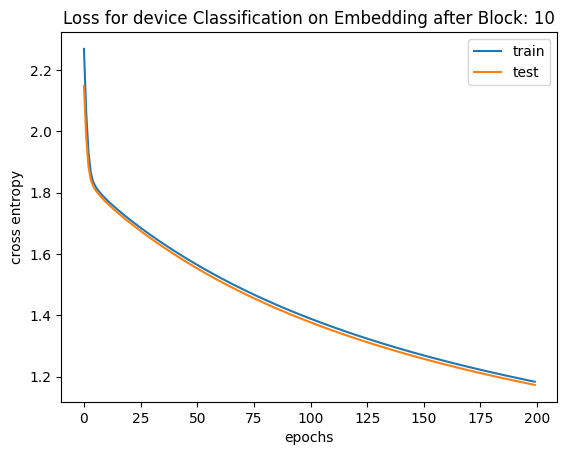

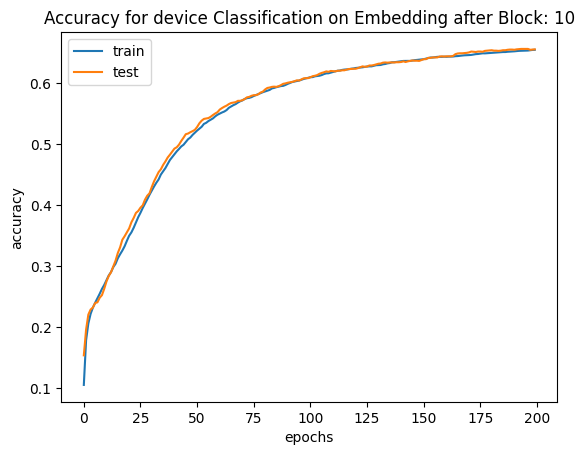

In [193]:
n_epochs = 200
batch_size = b_s
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# # Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters in the model are: {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of paramerters being trained: ", total_trainable_params)

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            labels = np.argmax(y_batch, axis=1)
            loss = criterion(y_pred, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if acc > best_acc:
        best_acc = acc

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)
list_val_acc.append(best_acc)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [194]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [195]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')

In [196]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
)

In [197]:
X_test=train_ready(test_data,col_name)

In [198]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred


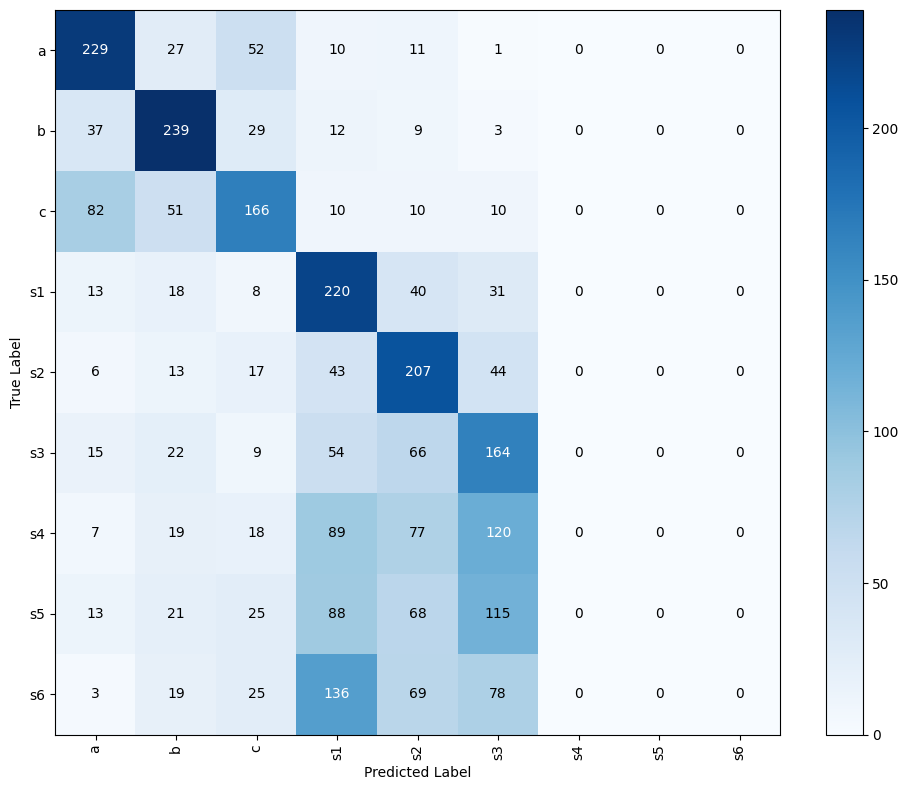

Accuracy: 0.4127


In [199]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-11

In [200]:
Block_number=11

In [201]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth',map_location=torch.device('cpu'))
new_fc3 = nn.Linear(256, 6)

# Replace the existing fc3 layer with the new one
model.fc3 = new_fc3

In [202]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [203]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [204]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [205]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 6)
(2793, 6)


In [206]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 198406
Number of parameters in the last layer is 1542


In [207]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [208]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)

In [209]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 1542


In [210]:
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(weights_array))
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Total number of paramerters in the model are: 198406
Total number of paramerters being trained:  1542


Epoch 0: 100%|██████████| 43/43 [00:00<00:00, 568.11batch/s, acc=0.0938, loss=2.04]


Epoch 0 validation: Cross-entropy=2.15, Accuracy=9.7%


Epoch 1: 100%|██████████| 43/43 [00:00<00:00, 300.69batch/s, acc=0.195, loss=1.92]


Epoch 1 validation: Cross-entropy=2.01, Accuracy=19.1%


Epoch 2: 100%|██████████| 43/43 [00:00<00:00, 342.55batch/s, acc=0.23, loss=1.86] 


Epoch 2 validation: Cross-entropy=1.92, Accuracy=20.8%


Epoch 3: 100%|██████████| 43/43 [00:00<00:00, 295.17batch/s, acc=0.242, loss=1.82]


Epoch 3 validation: Cross-entropy=1.86, Accuracy=22.5%


Epoch 4: 100%|██████████| 43/43 [00:00<00:00, 506.59batch/s, acc=0.242, loss=1.79]


Epoch 4 validation: Cross-entropy=1.82, Accuracy=23.8%


Epoch 5: 100%|██████████| 43/43 [00:00<00:00, 297.00batch/s, acc=0.246, loss=1.77]


Epoch 5 validation: Cross-entropy=1.79, Accuracy=24.9%


Epoch 6: 100%|██████████| 43/43 [00:00<00:00, 567.12batch/s, acc=0.254, loss=1.75]


Epoch 6 validation: Cross-entropy=1.78, Accuracy=25.6%


Epoch 7: 100%|██████████| 43/43 [00:00<00:00, 533.59batch/s, acc=0.273, loss=1.74]


Epoch 7 validation: Cross-entropy=1.77, Accuracy=27.0%


Epoch 8: 100%|██████████| 43/43 [00:00<00:00, 529.60batch/s, acc=0.273, loss=1.72]


Epoch 8 validation: Cross-entropy=1.76, Accuracy=28.3%


Epoch 9: 100%|██████████| 43/43 [00:00<00:00, 208.52batch/s, acc=0.277, loss=1.71]


Epoch 9 validation: Cross-entropy=1.75, Accuracy=29.0%


Epoch 10: 100%|██████████| 43/43 [00:00<00:00, 533.06batch/s, acc=0.289, loss=1.7] 


Epoch 10 validation: Cross-entropy=1.74, Accuracy=29.6%


Epoch 11: 100%|██████████| 43/43 [00:00<00:00, 538.81batch/s, acc=0.301, loss=1.69]


Epoch 11 validation: Cross-entropy=1.73, Accuracy=30.3%


Epoch 12: 100%|██████████| 43/43 [00:00<00:00, 476.12batch/s, acc=0.309, loss=1.68]


Epoch 12 validation: Cross-entropy=1.72, Accuracy=31.4%


Epoch 13: 100%|██████████| 43/43 [00:00<00:00, 491.65batch/s, acc=0.316, loss=1.67]


Epoch 13 validation: Cross-entropy=1.71, Accuracy=32.2%


Epoch 14: 100%|██████████| 43/43 [00:00<00:00, 564.70batch/s, acc=0.336, loss=1.66]


Epoch 14 validation: Cross-entropy=1.70, Accuracy=33.3%


Epoch 15: 100%|██████████| 43/43 [00:00<00:00, 528.20batch/s, acc=0.363, loss=1.65]


Epoch 15 validation: Cross-entropy=1.69, Accuracy=34.1%


Epoch 16: 100%|██████████| 43/43 [00:00<00:00, 490.82batch/s, acc=0.383, loss=1.64]


Epoch 16 validation: Cross-entropy=1.69, Accuracy=35.0%


Epoch 17: 100%|██████████| 43/43 [00:00<00:00, 318.19batch/s, acc=0.395, loss=1.63]


Epoch 17 validation: Cross-entropy=1.68, Accuracy=35.8%


Epoch 18: 100%|██████████| 43/43 [00:00<00:00, 463.47batch/s, acc=0.402, loss=1.62]


Epoch 18 validation: Cross-entropy=1.67, Accuracy=36.8%


Epoch 19: 100%|██████████| 43/43 [00:00<00:00, 522.00batch/s, acc=0.402, loss=1.61]


Epoch 19 validation: Cross-entropy=1.66, Accuracy=37.7%


Epoch 20: 100%|██████████| 43/43 [00:00<00:00, 234.37batch/s, acc=0.418, loss=1.6] 


Epoch 20 validation: Cross-entropy=1.66, Accuracy=38.2%


Epoch 21: 100%|██████████| 43/43 [00:00<00:00, 326.25batch/s, acc=0.418, loss=1.59]


Epoch 21 validation: Cross-entropy=1.65, Accuracy=39.0%


Epoch 22: 100%|██████████| 43/43 [00:00<00:00, 525.15batch/s, acc=0.438, loss=1.59]


Epoch 22 validation: Cross-entropy=1.64, Accuracy=39.6%


Epoch 23: 100%|██████████| 43/43 [00:00<00:00, 254.66batch/s, acc=0.441, loss=1.58]


Epoch 23 validation: Cross-entropy=1.64, Accuracy=40.2%


Epoch 24: 100%|██████████| 43/43 [00:00<00:00, 483.30batch/s, acc=0.449, loss=1.57]


Epoch 24 validation: Cross-entropy=1.63, Accuracy=40.5%


Epoch 25: 100%|██████████| 43/43 [00:00<00:00, 252.25batch/s, acc=0.465, loss=1.56]


Epoch 25 validation: Cross-entropy=1.62, Accuracy=41.1%


Epoch 26: 100%|██████████| 43/43 [00:00<00:00, 457.46batch/s, acc=0.465, loss=1.55]


Epoch 26 validation: Cross-entropy=1.62, Accuracy=41.4%


Epoch 27: 100%|██████████| 43/43 [00:00<00:00, 510.83batch/s, acc=0.48, loss=1.55] 


Epoch 27 validation: Cross-entropy=1.61, Accuracy=42.3%


Epoch 28: 100%|██████████| 43/43 [00:00<00:00, 313.09batch/s, acc=0.484, loss=1.54]


Epoch 28 validation: Cross-entropy=1.60, Accuracy=42.9%


Epoch 29: 100%|██████████| 43/43 [00:00<00:00, 293.34batch/s, acc=0.492, loss=1.53]


Epoch 29 validation: Cross-entropy=1.60, Accuracy=43.4%


Epoch 30: 100%|██████████| 43/43 [00:00<00:00, 321.54batch/s, acc=0.516, loss=1.52]


Epoch 30 validation: Cross-entropy=1.59, Accuracy=43.8%


Epoch 31: 100%|██████████| 43/43 [00:00<00:00, 357.10batch/s, acc=0.516, loss=1.52]


Epoch 31 validation: Cross-entropy=1.58, Accuracy=44.1%


Epoch 32: 100%|██████████| 43/43 [00:00<00:00, 521.11batch/s, acc=0.52, loss=1.51] 


Epoch 32 validation: Cross-entropy=1.58, Accuracy=44.4%


Epoch 33: 100%|██████████| 43/43 [00:00<00:00, 370.60batch/s, acc=0.52, loss=1.5]  


Epoch 33 validation: Cross-entropy=1.57, Accuracy=44.9%


Epoch 34: 100%|██████████| 43/43 [00:00<00:00, 397.08batch/s, acc=0.523, loss=1.49]


Epoch 34 validation: Cross-entropy=1.57, Accuracy=45.3%


Epoch 35: 100%|██████████| 43/43 [00:00<00:00, 519.96batch/s, acc=0.523, loss=1.49]


Epoch 35 validation: Cross-entropy=1.56, Accuracy=45.9%


Epoch 36: 100%|██████████| 43/43 [00:00<00:00, 242.70batch/s, acc=0.523, loss=1.48]


Epoch 36 validation: Cross-entropy=1.55, Accuracy=46.2%


Epoch 37: 100%|██████████| 43/43 [00:00<00:00, 515.01batch/s, acc=0.527, loss=1.47]


Epoch 37 validation: Cross-entropy=1.55, Accuracy=46.9%


Epoch 38: 100%|██████████| 43/43 [00:00<00:00, 211.27batch/s, acc=0.535, loss=1.47]


Epoch 38 validation: Cross-entropy=1.54, Accuracy=47.5%


Epoch 39: 100%|██████████| 43/43 [00:00<00:00, 459.48batch/s, acc=0.531, loss=1.46]


Epoch 39 validation: Cross-entropy=1.54, Accuracy=47.9%


Epoch 40: 100%|██████████| 43/43 [00:00<00:00, 554.99batch/s, acc=0.531, loss=1.45]


Epoch 40 validation: Cross-entropy=1.53, Accuracy=48.2%


Epoch 41: 100%|██████████| 43/43 [00:00<00:00, 526.96batch/s, acc=0.531, loss=1.45]


Epoch 41 validation: Cross-entropy=1.53, Accuracy=48.6%


Epoch 42: 100%|██████████| 43/43 [00:00<00:00, 275.53batch/s, acc=0.535, loss=1.44]


Epoch 42 validation: Cross-entropy=1.52, Accuracy=49.1%


Epoch 43: 100%|██████████| 43/43 [00:00<00:00, 528.81batch/s, acc=0.547, loss=1.43]


Epoch 43 validation: Cross-entropy=1.51, Accuracy=49.5%


Epoch 44: 100%|██████████| 43/43 [00:00<00:00, 551.00batch/s, acc=0.555, loss=1.43]


Epoch 44 validation: Cross-entropy=1.51, Accuracy=49.8%


Epoch 45: 100%|██████████| 43/43 [00:00<00:00, 244.16batch/s, acc=0.559, loss=1.42]


Epoch 45 validation: Cross-entropy=1.50, Accuracy=50.2%


Epoch 46: 100%|██████████| 43/43 [00:00<00:00, 532.03batch/s, acc=0.562, loss=1.42]


Epoch 46 validation: Cross-entropy=1.50, Accuracy=50.7%


Epoch 47: 100%|██████████| 43/43 [00:00<00:00, 269.45batch/s, acc=0.562, loss=1.41]


Epoch 47 validation: Cross-entropy=1.49, Accuracy=51.1%


Epoch 48: 100%|██████████| 43/43 [00:00<00:00, 325.24batch/s, acc=0.562, loss=1.4] 


Epoch 48 validation: Cross-entropy=1.49, Accuracy=51.4%


Epoch 49: 100%|██████████| 43/43 [00:00<00:00, 237.43batch/s, acc=0.57, loss=1.4]  


Epoch 49 validation: Cross-entropy=1.48, Accuracy=52.1%


Epoch 50: 100%|██████████| 43/43 [00:00<00:00, 499.86batch/s, acc=0.574, loss=1.39]


Epoch 50 validation: Cross-entropy=1.48, Accuracy=52.2%


Epoch 51: 100%|██████████| 43/43 [00:00<00:00, 555.01batch/s, acc=0.574, loss=1.39]


Epoch 51 validation: Cross-entropy=1.47, Accuracy=52.5%


Epoch 52: 100%|██████████| 43/43 [00:00<00:00, 530.57batch/s, acc=0.578, loss=1.38]


Epoch 52 validation: Cross-entropy=1.47, Accuracy=53.1%


Epoch 53: 100%|██████████| 43/43 [00:00<00:00, 309.89batch/s, acc=0.582, loss=1.38]


Epoch 53 validation: Cross-entropy=1.46, Accuracy=53.5%


Epoch 54: 100%|██████████| 43/43 [00:00<00:00, 498.06batch/s, acc=0.582, loss=1.37]


Epoch 54 validation: Cross-entropy=1.46, Accuracy=54.0%


Epoch 55: 100%|██████████| 43/43 [00:00<00:00, 550.48batch/s, acc=0.586, loss=1.37]


Epoch 55 validation: Cross-entropy=1.46, Accuracy=54.1%


Epoch 56: 100%|██████████| 43/43 [00:00<00:00, 383.93batch/s, acc=0.59, loss=1.36] 


Epoch 56 validation: Cross-entropy=1.45, Accuracy=54.4%


Epoch 57: 100%|██████████| 43/43 [00:00<00:00, 409.03batch/s, acc=0.59, loss=1.35] 


Epoch 57 validation: Cross-entropy=1.45, Accuracy=54.7%


Epoch 58: 100%|██████████| 43/43 [00:00<00:00, 536.09batch/s, acc=0.594, loss=1.35]


Epoch 58 validation: Cross-entropy=1.44, Accuracy=55.2%


Epoch 59: 100%|██████████| 43/43 [00:00<00:00, 193.81batch/s, acc=0.594, loss=1.34]


Epoch 59 validation: Cross-entropy=1.44, Accuracy=55.4%


Epoch 60: 100%|██████████| 43/43 [00:00<00:00, 384.00batch/s, acc=0.598, loss=1.34]


Epoch 60 validation: Cross-entropy=1.43, Accuracy=55.7%


Epoch 61: 100%|██████████| 43/43 [00:00<00:00, 363.54batch/s, acc=0.598, loss=1.33]


Epoch 61 validation: Cross-entropy=1.43, Accuracy=55.7%


Epoch 62: 100%|██████████| 43/43 [00:00<00:00, 505.46batch/s, acc=0.602, loss=1.33]


Epoch 62 validation: Cross-entropy=1.42, Accuracy=56.3%


Epoch 63: 100%|██████████| 43/43 [00:00<00:00, 266.31batch/s, acc=0.602, loss=1.32]


Epoch 63 validation: Cross-entropy=1.42, Accuracy=56.6%


Epoch 64: 100%|██████████| 43/43 [00:00<00:00, 527.79batch/s, acc=0.605, loss=1.32]


Epoch 64 validation: Cross-entropy=1.42, Accuracy=56.7%


Epoch 65: 100%|██████████| 43/43 [00:00<00:00, 480.96batch/s, acc=0.598, loss=1.31]


Epoch 65 validation: Cross-entropy=1.41, Accuracy=56.9%


Epoch 66: 100%|██████████| 43/43 [00:00<00:00, 412.58batch/s, acc=0.598, loss=1.31]


Epoch 66 validation: Cross-entropy=1.41, Accuracy=57.2%


Epoch 67: 100%|██████████| 43/43 [00:00<00:00, 549.42batch/s, acc=0.598, loss=1.31]


Epoch 67 validation: Cross-entropy=1.40, Accuracy=57.5%


Epoch 68: 100%|██████████| 43/43 [00:00<00:00, 524.20batch/s, acc=0.605, loss=1.3] 


Epoch 68 validation: Cross-entropy=1.40, Accuracy=57.9%


Epoch 69: 100%|██████████| 43/43 [00:00<00:00, 201.92batch/s, acc=0.605, loss=1.3] 


Epoch 69 validation: Cross-entropy=1.39, Accuracy=58.1%


Epoch 70: 100%|██████████| 43/43 [00:00<00:00, 518.38batch/s, acc=0.605, loss=1.29]


Epoch 70 validation: Cross-entropy=1.39, Accuracy=58.2%


Epoch 71: 100%|██████████| 43/43 [00:00<00:00, 258.16batch/s, acc=0.605, loss=1.29]


Epoch 71 validation: Cross-entropy=1.39, Accuracy=58.3%


Epoch 72: 100%|██████████| 43/43 [00:00<00:00, 555.04batch/s, acc=0.617, loss=1.28]


Epoch 72 validation: Cross-entropy=1.38, Accuracy=58.4%


Epoch 73: 100%|██████████| 43/43 [00:00<00:00, 349.43batch/s, acc=0.621, loss=1.28]


Epoch 73 validation: Cross-entropy=1.38, Accuracy=58.8%


Epoch 74: 100%|██████████| 43/43 [00:00<00:00, 456.91batch/s, acc=0.629, loss=1.27]


Epoch 74 validation: Cross-entropy=1.38, Accuracy=59.1%


Epoch 75: 100%|██████████| 43/43 [00:00<00:00, 306.44batch/s, acc=0.629, loss=1.27]


Epoch 75 validation: Cross-entropy=1.37, Accuracy=59.4%


Epoch 76: 100%|██████████| 43/43 [00:00<00:00, 455.10batch/s, acc=0.629, loss=1.27]


Epoch 76 validation: Cross-entropy=1.37, Accuracy=59.6%


Epoch 77: 100%|██████████| 43/43 [00:00<00:00, 535.85batch/s, acc=0.633, loss=1.26]


Epoch 77 validation: Cross-entropy=1.36, Accuracy=59.8%


Epoch 78: 100%|██████████| 43/43 [00:00<00:00, 255.22batch/s, acc=0.637, loss=1.26]


Epoch 78 validation: Cross-entropy=1.36, Accuracy=59.9%


Epoch 79: 100%|██████████| 43/43 [00:00<00:00, 539.71batch/s, acc=0.637, loss=1.25]


Epoch 79 validation: Cross-entropy=1.36, Accuracy=60.2%


Epoch 80: 100%|██████████| 43/43 [00:00<00:00, 547.50batch/s, acc=0.645, loss=1.25]


Epoch 80 validation: Cross-entropy=1.35, Accuracy=60.4%


Epoch 81: 100%|██████████| 43/43 [00:00<00:00, 277.08batch/s, acc=0.645, loss=1.24]


Epoch 81 validation: Cross-entropy=1.35, Accuracy=60.7%


Epoch 82: 100%|██████████| 43/43 [00:00<00:00, 507.74batch/s, acc=0.648, loss=1.24]


Epoch 82 validation: Cross-entropy=1.35, Accuracy=60.9%


Epoch 83: 100%|██████████| 43/43 [00:00<00:00, 265.44batch/s, acc=0.652, loss=1.24]


Epoch 83 validation: Cross-entropy=1.34, Accuracy=60.9%


Epoch 84: 100%|██████████| 43/43 [00:00<00:00, 551.15batch/s, acc=0.652, loss=1.23]


Epoch 84 validation: Cross-entropy=1.34, Accuracy=61.2%


Epoch 85: 100%|██████████| 43/43 [00:00<00:00, 526.63batch/s, acc=0.656, loss=1.23]


Epoch 85 validation: Cross-entropy=1.34, Accuracy=61.3%


Epoch 86: 100%|██████████| 43/43 [00:00<00:00, 269.04batch/s, acc=0.656, loss=1.23]


Epoch 86 validation: Cross-entropy=1.33, Accuracy=61.5%


Epoch 87: 100%|██████████| 43/43 [00:00<00:00, 499.47batch/s, acc=0.656, loss=1.22]


Epoch 87 validation: Cross-entropy=1.33, Accuracy=61.7%


Epoch 88: 100%|██████████| 43/43 [00:00<00:00, 553.99batch/s, acc=0.656, loss=1.22]


Epoch 88 validation: Cross-entropy=1.33, Accuracy=62.0%


Epoch 89: 100%|██████████| 43/43 [00:00<00:00, 289.96batch/s, acc=0.656, loss=1.21]


Epoch 89 validation: Cross-entropy=1.32, Accuracy=62.0%


Epoch 90: 100%|██████████| 43/43 [00:00<00:00, 411.16batch/s, acc=0.656, loss=1.21]


Epoch 90 validation: Cross-entropy=1.32, Accuracy=62.2%


Epoch 91: 100%|██████████| 43/43 [00:00<00:00, 506.66batch/s, acc=0.656, loss=1.21]


Epoch 91 validation: Cross-entropy=1.32, Accuracy=62.3%


Epoch 92: 100%|██████████| 43/43 [00:00<00:00, 256.14batch/s, acc=0.656, loss=1.2] 


Epoch 92 validation: Cross-entropy=1.31, Accuracy=62.5%


Epoch 93: 100%|██████████| 43/43 [00:00<00:00, 523.31batch/s, acc=0.656, loss=1.2] 


Epoch 93 validation: Cross-entropy=1.31, Accuracy=62.7%


Epoch 94: 100%|██████████| 43/43 [00:00<00:00, 260.78batch/s, acc=0.656, loss=1.2] 


Epoch 94 validation: Cross-entropy=1.31, Accuracy=62.8%


Epoch 95: 100%|██████████| 43/43 [00:00<00:00, 501.37batch/s, acc=0.66, loss=1.19] 


Epoch 95 validation: Cross-entropy=1.30, Accuracy=62.8%


Epoch 96: 100%|██████████| 43/43 [00:00<00:00, 542.37batch/s, acc=0.66, loss=1.19] 


Epoch 96 validation: Cross-entropy=1.30, Accuracy=62.9%


Epoch 97: 100%|██████████| 43/43 [00:00<00:00, 560.93batch/s, acc=0.66, loss=1.19] 


Epoch 97 validation: Cross-entropy=1.30, Accuracy=63.1%


Epoch 98: 100%|██████████| 43/43 [00:00<00:00, 291.31batch/s, acc=0.66, loss=1.18] 


Epoch 98 validation: Cross-entropy=1.29, Accuracy=63.2%


Epoch 99: 100%|██████████| 43/43 [00:00<00:00, 553.14batch/s, acc=0.66, loss=1.18] 


Epoch 99 validation: Cross-entropy=1.29, Accuracy=63.4%


Epoch 100: 100%|██████████| 43/43 [00:00<00:00, 180.84batch/s, acc=0.66, loss=1.18] 


Epoch 100 validation: Cross-entropy=1.29, Accuracy=63.6%


Epoch 101: 100%|██████████| 43/43 [00:00<00:00, 564.90batch/s, acc=0.66, loss=1.17] 


Epoch 101 validation: Cross-entropy=1.29, Accuracy=63.7%


Epoch 102: 100%|██████████| 43/43 [00:00<00:00, 554.22batch/s, acc=0.664, loss=1.17]


Epoch 102 validation: Cross-entropy=1.28, Accuracy=63.8%


Epoch 103: 100%|██████████| 43/43 [00:00<00:00, 275.26batch/s, acc=0.668, loss=1.17]


Epoch 103 validation: Cross-entropy=1.28, Accuracy=63.9%


Epoch 104: 100%|██████████| 43/43 [00:00<00:00, 537.47batch/s, acc=0.672, loss=1.16]


Epoch 104 validation: Cross-entropy=1.28, Accuracy=63.8%


Epoch 105: 100%|██████████| 43/43 [00:00<00:00, 251.31batch/s, acc=0.672, loss=1.16]


Epoch 105 validation: Cross-entropy=1.27, Accuracy=63.9%


Epoch 106: 100%|██████████| 43/43 [00:00<00:00, 445.15batch/s, acc=0.676, loss=1.16]


Epoch 106 validation: Cross-entropy=1.27, Accuracy=63.8%


Epoch 107: 100%|██████████| 43/43 [00:00<00:00, 552.82batch/s, acc=0.676, loss=1.16]


Epoch 107 validation: Cross-entropy=1.27, Accuracy=63.9%


Epoch 108: 100%|██████████| 43/43 [00:00<00:00, 534.37batch/s, acc=0.676, loss=1.15]


Epoch 108 validation: Cross-entropy=1.27, Accuracy=64.0%


Epoch 109: 100%|██████████| 43/43 [00:00<00:00, 295.60batch/s, acc=0.676, loss=1.15]


Epoch 109 validation: Cross-entropy=1.26, Accuracy=63.9%


Epoch 110: 100%|██████████| 43/43 [00:00<00:00, 539.06batch/s, acc=0.676, loss=1.15]


Epoch 110 validation: Cross-entropy=1.26, Accuracy=64.1%


Epoch 111: 100%|██████████| 43/43 [00:00<00:00, 549.82batch/s, acc=0.676, loss=1.14]


Epoch 111 validation: Cross-entropy=1.26, Accuracy=64.2%


Epoch 112: 100%|██████████| 43/43 [00:00<00:00, 372.90batch/s, acc=0.68, loss=1.14] 


Epoch 112 validation: Cross-entropy=1.26, Accuracy=64.3%


Epoch 113: 100%|██████████| 43/43 [00:00<00:00, 422.19batch/s, acc=0.68, loss=1.14] 


Epoch 113 validation: Cross-entropy=1.25, Accuracy=64.3%


Epoch 114: 100%|██████████| 43/43 [00:00<00:00, 544.93batch/s, acc=0.68, loss=1.13] 


Epoch 114 validation: Cross-entropy=1.25, Accuracy=64.3%


Epoch 115: 100%|██████████| 43/43 [00:00<00:00, 265.82batch/s, acc=0.68, loss=1.13] 


Epoch 115 validation: Cross-entropy=1.25, Accuracy=64.4%


Epoch 116: 100%|██████████| 43/43 [00:00<00:00, 460.08batch/s, acc=0.68, loss=1.13] 


Epoch 116 validation: Cross-entropy=1.25, Accuracy=64.6%


Epoch 117: 100%|██████████| 43/43 [00:00<00:00, 284.54batch/s, acc=0.68, loss=1.13] 


Epoch 117 validation: Cross-entropy=1.24, Accuracy=64.6%


Epoch 118: 100%|██████████| 43/43 [00:00<00:00, 454.73batch/s, acc=0.68, loss=1.12] 


Epoch 118 validation: Cross-entropy=1.24, Accuracy=64.7%


Epoch 119: 100%|██████████| 43/43 [00:00<00:00, 553.85batch/s, acc=0.68, loss=1.12] 


Epoch 119 validation: Cross-entropy=1.24, Accuracy=64.7%


Epoch 120: 100%|██████████| 43/43 [00:00<00:00, 280.48batch/s, acc=0.68, loss=1.12] 


Epoch 120 validation: Cross-entropy=1.24, Accuracy=64.6%


Epoch 121: 100%|██████████| 43/43 [00:00<00:00, 546.50batch/s, acc=0.68, loss=1.12] 


Epoch 121 validation: Cross-entropy=1.23, Accuracy=64.8%


Epoch 122: 100%|██████████| 43/43 [00:00<00:00, 530.67batch/s, acc=0.68, loss=1.11] 


Epoch 122 validation: Cross-entropy=1.23, Accuracy=64.8%


Epoch 123: 100%|██████████| 43/43 [00:00<00:00, 291.77batch/s, acc=0.68, loss=1.11] 


Epoch 123 validation: Cross-entropy=1.23, Accuracy=64.9%


Epoch 124: 100%|██████████| 43/43 [00:00<00:00, 532.03batch/s, acc=0.68, loss=1.11] 


Epoch 124 validation: Cross-entropy=1.23, Accuracy=64.9%


Epoch 125: 100%|██████████| 43/43 [00:00<00:00, 556.57batch/s, acc=0.68, loss=1.11] 


Epoch 125 validation: Cross-entropy=1.22, Accuracy=65.0%


Epoch 126: 100%|██████████| 43/43 [00:00<00:00, 262.20batch/s, acc=0.684, loss=1.1] 


Epoch 126 validation: Cross-entropy=1.22, Accuracy=65.0%


Epoch 127: 100%|██████████| 43/43 [00:00<00:00, 519.86batch/s, acc=0.684, loss=1.1] 


Epoch 127 validation: Cross-entropy=1.22, Accuracy=65.0%


Epoch 128: 100%|██████████| 43/43 [00:00<00:00, 267.94batch/s, acc=0.684, loss=1.1] 


Epoch 128 validation: Cross-entropy=1.22, Accuracy=65.1%


Epoch 129: 100%|██████████| 43/43 [00:00<00:00, 473.35batch/s, acc=0.688, loss=1.1] 


Epoch 129 validation: Cross-entropy=1.21, Accuracy=65.2%


Epoch 130: 100%|██████████| 43/43 [00:00<00:00, 548.37batch/s, acc=0.688, loss=1.09]


Epoch 130 validation: Cross-entropy=1.21, Accuracy=65.4%


Epoch 131: 100%|██████████| 43/43 [00:00<00:00, 550.93batch/s, acc=0.688, loss=1.09]


Epoch 131 validation: Cross-entropy=1.21, Accuracy=65.3%


Epoch 132: 100%|██████████| 43/43 [00:00<00:00, 276.78batch/s, acc=0.688, loss=1.09]


Epoch 132 validation: Cross-entropy=1.21, Accuracy=65.3%


Epoch 133: 100%|██████████| 43/43 [00:00<00:00, 308.65batch/s, acc=0.688, loss=1.09]


Epoch 133 validation: Cross-entropy=1.20, Accuracy=65.2%


Epoch 134: 100%|██████████| 43/43 [00:00<00:00, 493.32batch/s, acc=0.688, loss=1.08]


Epoch 134 validation: Cross-entropy=1.20, Accuracy=65.3%


Epoch 135: 100%|██████████| 43/43 [00:00<00:00, 261.12batch/s, acc=0.688, loss=1.08]


Epoch 135 validation: Cross-entropy=1.20, Accuracy=65.3%


Epoch 136: 100%|██████████| 43/43 [00:00<00:00, 509.58batch/s, acc=0.684, loss=1.08]


Epoch 136 validation: Cross-entropy=1.20, Accuracy=65.2%


Epoch 137: 100%|██████████| 43/43 [00:00<00:00, 539.29batch/s, acc=0.684, loss=1.08]


Epoch 137 validation: Cross-entropy=1.20, Accuracy=65.3%


Epoch 138: 100%|██████████| 43/43 [00:00<00:00, 246.33batch/s, acc=0.676, loss=1.07]


Epoch 138 validation: Cross-entropy=1.19, Accuracy=65.3%


Epoch 139: 100%|██████████| 43/43 [00:00<00:00, 567.71batch/s, acc=0.676, loss=1.07]


Epoch 139 validation: Cross-entropy=1.19, Accuracy=65.3%


Epoch 140: 100%|██████████| 43/43 [00:00<00:00, 244.48batch/s, acc=0.676, loss=1.07]


Epoch 140 validation: Cross-entropy=1.19, Accuracy=65.3%


Epoch 141: 100%|██████████| 43/43 [00:00<00:00, 326.22batch/s, acc=0.676, loss=1.07]


Epoch 141 validation: Cross-entropy=1.19, Accuracy=65.5%


Epoch 142: 100%|██████████| 43/43 [00:00<00:00, 404.01batch/s, acc=0.676, loss=1.07]


Epoch 142 validation: Cross-entropy=1.19, Accuracy=65.5%


Epoch 143: 100%|██████████| 43/43 [00:00<00:00, 523.19batch/s, acc=0.676, loss=1.06]


Epoch 143 validation: Cross-entropy=1.18, Accuracy=65.4%


Epoch 144: 100%|██████████| 43/43 [00:00<00:00, 552.38batch/s, acc=0.68, loss=1.06] 


Epoch 144 validation: Cross-entropy=1.18, Accuracy=65.4%


Epoch 145: 100%|██████████| 43/43 [00:00<00:00, 296.43batch/s, acc=0.68, loss=1.06] 


Epoch 145 validation: Cross-entropy=1.18, Accuracy=65.4%


Epoch 146: 100%|██████████| 43/43 [00:00<00:00, 548.31batch/s, acc=0.68, loss=1.06] 


Epoch 146 validation: Cross-entropy=1.18, Accuracy=65.5%


Epoch 147: 100%|██████████| 43/43 [00:00<00:00, 528.83batch/s, acc=0.684, loss=1.06]


Epoch 147 validation: Cross-entropy=1.18, Accuracy=65.6%


Epoch 148: 100%|██████████| 43/43 [00:00<00:00, 282.99batch/s, acc=0.684, loss=1.05]


Epoch 148 validation: Cross-entropy=1.17, Accuracy=65.6%


Epoch 149: 100%|██████████| 43/43 [00:00<00:00, 523.14batch/s, acc=0.684, loss=1.05]


Epoch 149 validation: Cross-entropy=1.17, Accuracy=65.6%


Epoch 150: 100%|██████████| 43/43 [00:00<00:00, 289.70batch/s, acc=0.684, loss=1.05]


Epoch 150 validation: Cross-entropy=1.17, Accuracy=65.7%


Epoch 151: 100%|██████████| 43/43 [00:00<00:00, 535.69batch/s, acc=0.688, loss=1.05]


Epoch 151 validation: Cross-entropy=1.17, Accuracy=65.6%


Epoch 152: 100%|██████████| 43/43 [00:00<00:00, 280.30batch/s, acc=0.688, loss=1.05]


Epoch 152 validation: Cross-entropy=1.17, Accuracy=65.6%


Epoch 153: 100%|██████████| 43/43 [00:00<00:00, 512.80batch/s, acc=0.688, loss=1.04]


Epoch 153 validation: Cross-entropy=1.16, Accuracy=65.7%


Epoch 154: 100%|██████████| 43/43 [00:00<00:00, 550.70batch/s, acc=0.688, loss=1.04]


Epoch 154 validation: Cross-entropy=1.16, Accuracy=65.7%


Epoch 155: 100%|██████████| 43/43 [00:00<00:00, 288.41batch/s, acc=0.688, loss=1.04]


Epoch 155 validation: Cross-entropy=1.16, Accuracy=65.7%


Epoch 156: 100%|██████████| 43/43 [00:00<00:00, 506.49batch/s, acc=0.688, loss=1.04]


Epoch 156 validation: Cross-entropy=1.16, Accuracy=65.8%


Epoch 157: 100%|██████████| 43/43 [00:00<00:00, 526.40batch/s, acc=0.688, loss=1.04]


Epoch 157 validation: Cross-entropy=1.16, Accuracy=66.0%


Epoch 158: 100%|██████████| 43/43 [00:00<00:00, 293.04batch/s, acc=0.688, loss=1.03]


Epoch 158 validation: Cross-entropy=1.16, Accuracy=65.9%


Epoch 159: 100%|██████████| 43/43 [00:00<00:00, 488.74batch/s, acc=0.688, loss=1.03]


Epoch 159 validation: Cross-entropy=1.15, Accuracy=66.0%


Epoch 160: 100%|██████████| 43/43 [00:00<00:00, 484.10batch/s, acc=0.684, loss=1.03]


Epoch 160 validation: Cross-entropy=1.15, Accuracy=66.0%


Epoch 161: 100%|██████████| 43/43 [00:00<00:00, 211.15batch/s, acc=0.684, loss=1.03]


Epoch 161 validation: Cross-entropy=1.15, Accuracy=66.1%


Epoch 162: 100%|██████████| 43/43 [00:00<00:00, 547.50batch/s, acc=0.684, loss=1.03]


Epoch 162 validation: Cross-entropy=1.15, Accuracy=66.2%


Epoch 163: 100%|██████████| 43/43 [00:00<00:00, 555.90batch/s, acc=0.684, loss=1.02]


Epoch 163 validation: Cross-entropy=1.15, Accuracy=66.2%


Epoch 164: 100%|██████████| 43/43 [00:00<00:00, 249.36batch/s, acc=0.684, loss=1.02]


Epoch 164 validation: Cross-entropy=1.14, Accuracy=66.2%


Epoch 165: 100%|██████████| 43/43 [00:00<00:00, 541.25batch/s, acc=0.684, loss=1.02]


Epoch 165 validation: Cross-entropy=1.14, Accuracy=66.2%


Epoch 166: 100%|██████████| 43/43 [00:00<00:00, 257.85batch/s, acc=0.684, loss=1.02]


Epoch 166 validation: Cross-entropy=1.14, Accuracy=66.1%


Epoch 167: 100%|██████████| 43/43 [00:00<00:00, 279.99batch/s, acc=0.684, loss=1.02]


Epoch 167 validation: Cross-entropy=1.14, Accuracy=66.2%


Epoch 168: 100%|██████████| 43/43 [00:00<00:00, 249.75batch/s, acc=0.684, loss=1.02]


Epoch 168 validation: Cross-entropy=1.14, Accuracy=66.2%


Epoch 169: 100%|██████████| 43/43 [00:00<00:00, 547.61batch/s, acc=0.684, loss=1.01]


Epoch 169 validation: Cross-entropy=1.14, Accuracy=66.3%


Epoch 170: 100%|██████████| 43/43 [00:00<00:00, 546.78batch/s, acc=0.684, loss=1.01]


Epoch 170 validation: Cross-entropy=1.13, Accuracy=66.3%


Epoch 171: 100%|██████████| 43/43 [00:00<00:00, 264.78batch/s, acc=0.684, loss=1.01]


Epoch 171 validation: Cross-entropy=1.13, Accuracy=66.4%


Epoch 172: 100%|██████████| 43/43 [00:00<00:00, 358.12batch/s, acc=0.684, loss=1.01]


Epoch 172 validation: Cross-entropy=1.13, Accuracy=66.4%


Epoch 173: 100%|██████████| 43/43 [00:00<00:00, 395.81batch/s, acc=0.684, loss=1.01]


Epoch 173 validation: Cross-entropy=1.13, Accuracy=66.4%


Epoch 174: 100%|██████████| 43/43 [00:00<00:00, 527.24batch/s, acc=0.684, loss=1.01]


Epoch 174 validation: Cross-entropy=1.13, Accuracy=66.3%


Epoch 175: 100%|██████████| 43/43 [00:00<00:00, 254.74batch/s, acc=0.684, loss=1]   


Epoch 175 validation: Cross-entropy=1.13, Accuracy=66.2%


Epoch 176: 100%|██████████| 43/43 [00:00<00:00, 513.83batch/s, acc=0.684, loss=1]   


Epoch 176 validation: Cross-entropy=1.12, Accuracy=66.2%


Epoch 177: 100%|██████████| 43/43 [00:00<00:00, 533.37batch/s, acc=0.684, loss=1]   


Epoch 177 validation: Cross-entropy=1.12, Accuracy=66.2%


Epoch 178: 100%|██████████| 43/43 [00:00<00:00, 289.21batch/s, acc=0.684, loss=0.999]


Epoch 178 validation: Cross-entropy=1.12, Accuracy=66.1%


Epoch 179: 100%|██████████| 43/43 [00:00<00:00, 527.85batch/s, acc=0.684, loss=0.998]


Epoch 179 validation: Cross-entropy=1.12, Accuracy=66.1%


Epoch 180: 100%|██████████| 43/43 [00:00<00:00, 539.20batch/s, acc=0.684, loss=0.996]


Epoch 180 validation: Cross-entropy=1.12, Accuracy=66.2%


Epoch 181: 100%|██████████| 43/43 [00:00<00:00, 265.94batch/s, acc=0.684, loss=0.995]


Epoch 181 validation: Cross-entropy=1.12, Accuracy=66.2%


Epoch 182: 100%|██████████| 43/43 [00:00<00:00, 549.55batch/s, acc=0.684, loss=0.993]


Epoch 182 validation: Cross-entropy=1.12, Accuracy=66.2%


Epoch 183: 100%|██████████| 43/43 [00:00<00:00, 561.69batch/s, acc=0.684, loss=0.991]


Epoch 183 validation: Cross-entropy=1.11, Accuracy=66.1%


Epoch 184: 100%|██████████| 43/43 [00:00<00:00, 266.14batch/s, acc=0.684, loss=0.99]


Epoch 184 validation: Cross-entropy=1.11, Accuracy=66.1%


Epoch 185: 100%|██████████| 43/43 [00:00<00:00, 547.98batch/s, acc=0.684, loss=0.988]


Epoch 185 validation: Cross-entropy=1.11, Accuracy=66.1%


Epoch 186: 100%|██████████| 43/43 [00:00<00:00, 303.47batch/s, acc=0.684, loss=0.987]


Epoch 186 validation: Cross-entropy=1.11, Accuracy=66.1%


Epoch 187: 100%|██████████| 43/43 [00:00<00:00, 501.67batch/s, acc=0.684, loss=0.985]


Epoch 187 validation: Cross-entropy=1.11, Accuracy=66.1%


Epoch 188: 100%|██████████| 43/43 [00:00<00:00, 250.96batch/s, acc=0.684, loss=0.984]


Epoch 188 validation: Cross-entropy=1.11, Accuracy=66.2%


Epoch 189: 100%|██████████| 43/43 [00:00<00:00, 472.70batch/s, acc=0.684, loss=0.982]


Epoch 189 validation: Cross-entropy=1.11, Accuracy=66.2%


Epoch 190: 100%|██████████| 43/43 [00:00<00:00, 577.91batch/s, acc=0.684, loss=0.981]


Epoch 190 validation: Cross-entropy=1.10, Accuracy=66.2%


Epoch 191: 100%|██████████| 43/43 [00:00<00:00, 300.07batch/s, acc=0.684, loss=0.98] 


Epoch 191 validation: Cross-entropy=1.10, Accuracy=66.2%


Epoch 192: 100%|██████████| 43/43 [00:00<00:00, 520.15batch/s, acc=0.684, loss=0.978]


Epoch 192 validation: Cross-entropy=1.10, Accuracy=66.2%


Epoch 193: 100%|██████████| 43/43 [00:00<00:00, 275.67batch/s, acc=0.684, loss=0.977]


Epoch 193 validation: Cross-entropy=1.10, Accuracy=66.3%


Epoch 194: 100%|██████████| 43/43 [00:00<00:00, 542.51batch/s, acc=0.684, loss=0.975]


Epoch 194 validation: Cross-entropy=1.10, Accuracy=66.3%


Epoch 195: 100%|██████████| 43/43 [00:00<00:00, 276.77batch/s, acc=0.684, loss=0.974]


Epoch 195 validation: Cross-entropy=1.10, Accuracy=66.3%


Epoch 196: 100%|██████████| 43/43 [00:00<00:00, 468.66batch/s, acc=0.684, loss=0.972]


Epoch 196 validation: Cross-entropy=1.10, Accuracy=66.3%


Epoch 197: 100%|██████████| 43/43 [00:00<00:00, 563.39batch/s, acc=0.684, loss=0.971]


Epoch 197 validation: Cross-entropy=1.09, Accuracy=66.5%


Epoch 198: 100%|██████████| 43/43 [00:00<00:00, 210.36batch/s, acc=0.688, loss=0.97] 


Epoch 198 validation: Cross-entropy=1.09, Accuracy=66.5%


Epoch 199: 100%|██████████| 43/43 [00:00<00:00, 543.06batch/s, acc=0.688, loss=0.968]


Epoch 199 validation: Cross-entropy=1.09, Accuracy=66.5%


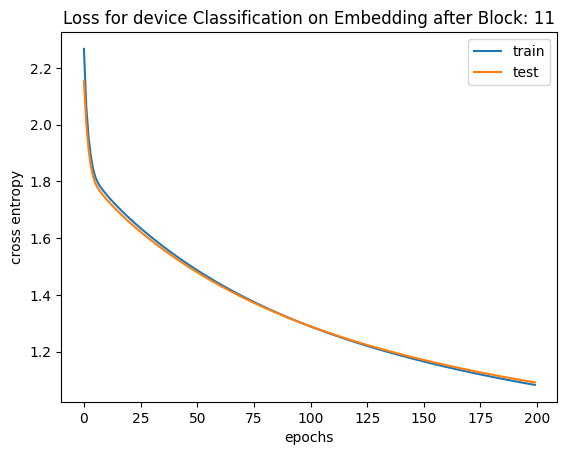

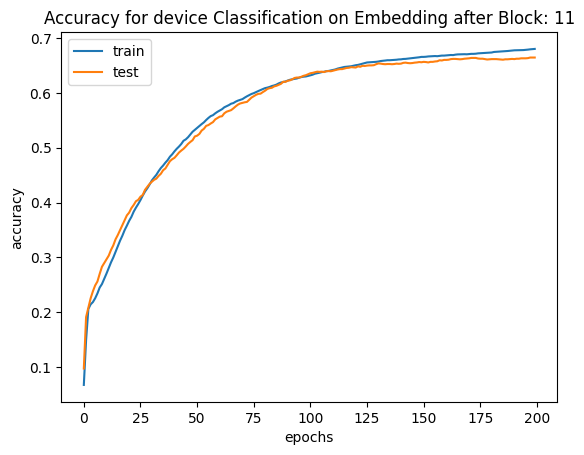

In [211]:
n_epochs = 200
batch_size = b_s
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# # Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters in the model are: {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of paramerters being trained: ", total_trainable_params)

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            labels = np.argmax(y_batch, axis=1)
            loss = criterion(y_pred, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if acc > best_acc:
        best_acc = acc

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)
list_val_acc.append(best_acc)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [212]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [213]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')

In [214]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
)

In [215]:
X_test=train_ready(test_data,col_name)

In [216]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred


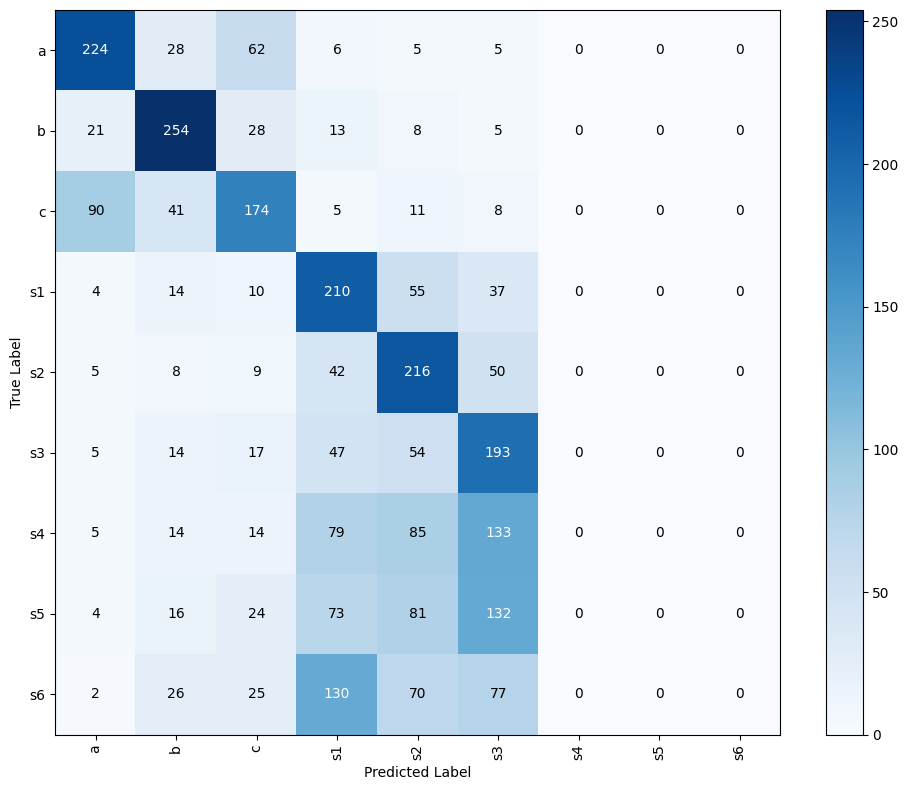

Accuracy: 0.4282


In [217]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-12

In [218]:
Block_number=12

In [219]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth',map_location=torch.device('cpu'))
new_fc3 = nn.Linear(256, 6)

# Replace the existing fc3 layer with the new one
model.fc3 = new_fc3

In [220]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [221]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [222]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [223]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 6)
(2793, 6)


In [224]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 198406
Number of parameters in the last layer is 1542


In [225]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [226]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)

In [227]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 1542


In [228]:
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(weights_array))
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Total number of paramerters in the model are: 198406
Total number of paramerters being trained:  1542


Epoch 0: 100%|██████████| 43/43 [00:00<00:00, 499.12batch/s, acc=0.082, loss=2.53] 


Epoch 0 validation: Cross-entropy=2.42, Accuracy=6.9%


Epoch 1: 100%|██████████| 43/43 [00:00<00:00, 268.35batch/s, acc=0.105, loss=2.29] 


Epoch 1 validation: Cross-entropy=2.21, Accuracy=8.1%


Epoch 2: 100%|██████████| 43/43 [00:00<00:00, 483.35batch/s, acc=0.117, loss=2.12] 


Epoch 2 validation: Cross-entropy=2.07, Accuracy=9.2%


Epoch 3: 100%|██████████| 43/43 [00:00<00:00, 202.75batch/s, acc=0.129, loss=1.99] 


Epoch 3 validation: Cross-entropy=1.97, Accuracy=10.5%


Epoch 4: 100%|██████████| 43/43 [00:00<00:00, 458.89batch/s, acc=0.133, loss=1.9]  


Epoch 4 validation: Cross-entropy=1.91, Accuracy=11.9%


Epoch 5: 100%|██████████| 43/43 [00:00<00:00, 278.36batch/s, acc=0.121, loss=1.86] 


Epoch 5 validation: Cross-entropy=1.87, Accuracy=12.5%


Epoch 6: 100%|██████████| 43/43 [00:00<00:00, 452.54batch/s, acc=0.137, loss=1.83]


Epoch 6 validation: Cross-entropy=1.85, Accuracy=13.3%


Epoch 7: 100%|██████████| 43/43 [00:00<00:00, 487.95batch/s, acc=0.152, loss=1.82]


Epoch 7 validation: Cross-entropy=1.84, Accuracy=14.3%


Epoch 8: 100%|██████████| 43/43 [00:00<00:00, 250.53batch/s, acc=0.16, loss=1.81] 


Epoch 8 validation: Cross-entropy=1.83, Accuracy=15.0%


Epoch 9: 100%|██████████| 43/43 [00:00<00:00, 483.39batch/s, acc=0.16, loss=1.8]  


Epoch 9 validation: Cross-entropy=1.82, Accuracy=15.6%


Epoch 10: 100%|██████████| 43/43 [00:00<00:00, 303.14batch/s, acc=0.168, loss=1.79]


Epoch 10 validation: Cross-entropy=1.81, Accuracy=16.2%


Epoch 11: 100%|██████████| 43/43 [00:00<00:00, 307.49batch/s, acc=0.172, loss=1.78]


Epoch 11 validation: Cross-entropy=1.81, Accuracy=16.4%


Epoch 12: 100%|██████████| 43/43 [00:00<00:00, 520.36batch/s, acc=0.172, loss=1.78]


Epoch 12 validation: Cross-entropy=1.80, Accuracy=17.1%


Epoch 13: 100%|██████████| 43/43 [00:00<00:00, 257.50batch/s, acc=0.18, loss=1.77] 


Epoch 13 validation: Cross-entropy=1.79, Accuracy=17.9%


Epoch 14: 100%|██████████| 43/43 [00:00<00:00, 524.88batch/s, acc=0.18, loss=1.76] 


Epoch 14 validation: Cross-entropy=1.79, Accuracy=18.7%


Epoch 15: 100%|██████████| 43/43 [00:00<00:00, 431.66batch/s, acc=0.188, loss=1.76]


Epoch 15 validation: Cross-entropy=1.78, Accuracy=19.3%


Epoch 16: 100%|██████████| 43/43 [00:00<00:00, 330.46batch/s, acc=0.195, loss=1.75]


Epoch 16 validation: Cross-entropy=1.77, Accuracy=19.5%


Epoch 17: 100%|██████████| 43/43 [00:00<00:00, 505.97batch/s, acc=0.203, loss=1.74]


Epoch 17 validation: Cross-entropy=1.77, Accuracy=20.3%


Epoch 18: 100%|██████████| 43/43 [00:00<00:00, 253.77batch/s, acc=0.203, loss=1.74]


Epoch 18 validation: Cross-entropy=1.76, Accuracy=21.2%


Epoch 19: 100%|██████████| 43/43 [00:00<00:00, 476.57batch/s, acc=0.211, loss=1.73]


Epoch 19 validation: Cross-entropy=1.76, Accuracy=21.8%


Epoch 20: 100%|██████████| 43/43 [00:00<00:00, 468.92batch/s, acc=0.23, loss=1.72] 


Epoch 20 validation: Cross-entropy=1.75, Accuracy=22.3%


Epoch 21: 100%|██████████| 43/43 [00:00<00:00, 192.25batch/s, acc=0.234, loss=1.72]


Epoch 21 validation: Cross-entropy=1.75, Accuracy=23.0%


Epoch 22: 100%|██████████| 43/43 [00:00<00:00, 515.57batch/s, acc=0.234, loss=1.71]


Epoch 22 validation: Cross-entropy=1.74, Accuracy=23.7%


Epoch 23: 100%|██████████| 43/43 [00:00<00:00, 259.44batch/s, acc=0.242, loss=1.71]


Epoch 23 validation: Cross-entropy=1.74, Accuracy=24.3%


Epoch 24: 100%|██████████| 43/43 [00:00<00:00, 520.19batch/s, acc=0.246, loss=1.7] 


Epoch 24 validation: Cross-entropy=1.73, Accuracy=24.7%


Epoch 25: 100%|██████████| 43/43 [00:00<00:00, 481.57batch/s, acc=0.258, loss=1.69]


Epoch 25 validation: Cross-entropy=1.73, Accuracy=25.3%


Epoch 26: 100%|██████████| 43/43 [00:00<00:00, 240.15batch/s, acc=0.262, loss=1.69]


Epoch 26 validation: Cross-entropy=1.72, Accuracy=25.7%


Epoch 27: 100%|██████████| 43/43 [00:00<00:00, 514.67batch/s, acc=0.277, loss=1.68]


Epoch 27 validation: Cross-entropy=1.72, Accuracy=26.2%


Epoch 28: 100%|██████████| 43/43 [00:00<00:00, 249.24batch/s, acc=0.285, loss=1.68]


Epoch 28 validation: Cross-entropy=1.71, Accuracy=26.8%


Epoch 29: 100%|██████████| 43/43 [00:00<00:00, 517.51batch/s, acc=0.289, loss=1.67]


Epoch 29 validation: Cross-entropy=1.71, Accuracy=27.5%


Epoch 30: 100%|██████████| 43/43 [00:00<00:00, 508.80batch/s, acc=0.297, loss=1.67]


Epoch 30 validation: Cross-entropy=1.70, Accuracy=28.4%


Epoch 31: 100%|██████████| 43/43 [00:00<00:00, 202.10batch/s, acc=0.293, loss=1.66]


Epoch 31 validation: Cross-entropy=1.70, Accuracy=29.0%


Epoch 32: 100%|██████████| 43/43 [00:00<00:00, 510.43batch/s, acc=0.301, loss=1.66]


Epoch 32 validation: Cross-entropy=1.69, Accuracy=29.6%


Epoch 33: 100%|██████████| 43/43 [00:00<00:00, 256.23batch/s, acc=0.297, loss=1.65]


Epoch 33 validation: Cross-entropy=1.69, Accuracy=30.5%


Epoch 34: 100%|██████████| 43/43 [00:00<00:00, 501.46batch/s, acc=0.297, loss=1.65]


Epoch 34 validation: Cross-entropy=1.68, Accuracy=31.0%


Epoch 35: 100%|██████████| 43/43 [00:00<00:00, 251.93batch/s, acc=0.305, loss=1.64]


Epoch 35 validation: Cross-entropy=1.68, Accuracy=31.5%


Epoch 36: 100%|██████████| 43/43 [00:00<00:00, 471.12batch/s, acc=0.305, loss=1.64]


Epoch 36 validation: Cross-entropy=1.68, Accuracy=32.0%


Epoch 37: 100%|██████████| 43/43 [00:00<00:00, 338.95batch/s, acc=0.316, loss=1.63]


Epoch 37 validation: Cross-entropy=1.67, Accuracy=32.4%


Epoch 38: 100%|██████████| 43/43 [00:00<00:00, 391.63batch/s, acc=0.324, loss=1.63]


Epoch 38 validation: Cross-entropy=1.67, Accuracy=32.8%


Epoch 39: 100%|██████████| 43/43 [00:00<00:00, 516.17batch/s, acc=0.328, loss=1.62]


Epoch 39 validation: Cross-entropy=1.66, Accuracy=33.3%


Epoch 40: 100%|██████████| 43/43 [00:00<00:00, 311.80batch/s, acc=0.328, loss=1.62]


Epoch 40 validation: Cross-entropy=1.66, Accuracy=33.8%


Epoch 41: 100%|██████████| 43/43 [00:00<00:00, 247.29batch/s, acc=0.344, loss=1.61]


Epoch 41 validation: Cross-entropy=1.65, Accuracy=34.1%


Epoch 42: 100%|██████████| 43/43 [00:00<00:00, 307.91batch/s, acc=0.363, loss=1.61]


Epoch 42 validation: Cross-entropy=1.65, Accuracy=34.6%


Epoch 43: 100%|██████████| 43/43 [00:00<00:00, 479.96batch/s, acc=0.375, loss=1.6] 


Epoch 43 validation: Cross-entropy=1.65, Accuracy=34.9%


Epoch 44: 100%|██████████| 43/43 [00:00<00:00, 496.79batch/s, acc=0.383, loss=1.6] 


Epoch 44 validation: Cross-entropy=1.64, Accuracy=35.5%


Epoch 45: 100%|██████████| 43/43 [00:00<00:00, 249.24batch/s, acc=0.398, loss=1.6] 


Epoch 45 validation: Cross-entropy=1.64, Accuracy=35.7%


Epoch 46: 100%|██████████| 43/43 [00:00<00:00, 466.74batch/s, acc=0.406, loss=1.59]


Epoch 46 validation: Cross-entropy=1.64, Accuracy=36.1%


Epoch 47: 100%|██████████| 43/43 [00:00<00:00, 261.09batch/s, acc=0.418, loss=1.59]


Epoch 47 validation: Cross-entropy=1.63, Accuracy=36.6%


Epoch 48: 100%|██████████| 43/43 [00:00<00:00, 455.86batch/s, acc=0.426, loss=1.58]


Epoch 48 validation: Cross-entropy=1.63, Accuracy=37.2%


Epoch 49: 100%|██████████| 43/43 [00:00<00:00, 492.69batch/s, acc=0.434, loss=1.58]


Epoch 49 validation: Cross-entropy=1.62, Accuracy=37.4%


Epoch 50: 100%|██████████| 43/43 [00:00<00:00, 240.80batch/s, acc=0.441, loss=1.57]


Epoch 50 validation: Cross-entropy=1.62, Accuracy=37.7%


Epoch 51: 100%|██████████| 43/43 [00:00<00:00, 279.23batch/s, acc=0.449, loss=1.57]


Epoch 51 validation: Cross-entropy=1.62, Accuracy=38.2%


Epoch 52: 100%|██████████| 43/43 [00:00<00:00, 245.38batch/s, acc=0.449, loss=1.57]


Epoch 52 validation: Cross-entropy=1.61, Accuracy=38.9%


Epoch 53: 100%|██████████| 43/43 [00:00<00:00, 426.73batch/s, acc=0.453, loss=1.56]


Epoch 53 validation: Cross-entropy=1.61, Accuracy=39.3%


Epoch 54: 100%|██████████| 43/43 [00:00<00:00, 493.99batch/s, acc=0.457, loss=1.56]


Epoch 54 validation: Cross-entropy=1.61, Accuracy=39.5%


Epoch 55: 100%|██████████| 43/43 [00:00<00:00, 238.98batch/s, acc=0.461, loss=1.55]


Epoch 55 validation: Cross-entropy=1.60, Accuracy=39.8%


Epoch 56: 100%|██████████| 43/43 [00:00<00:00, 505.20batch/s, acc=0.465, loss=1.55]


Epoch 56 validation: Cross-entropy=1.60, Accuracy=40.5%


Epoch 57: 100%|██████████| 43/43 [00:00<00:00, 241.30batch/s, acc=0.465, loss=1.55]


Epoch 57 validation: Cross-entropy=1.60, Accuracy=40.8%


Epoch 58: 100%|██████████| 43/43 [00:00<00:00, 433.31batch/s, acc=0.469, loss=1.54]


Epoch 58 validation: Cross-entropy=1.59, Accuracy=41.3%


Epoch 59: 100%|██████████| 43/43 [00:00<00:00, 501.21batch/s, acc=0.473, loss=1.54]


Epoch 59 validation: Cross-entropy=1.59, Accuracy=41.6%


Epoch 60: 100%|██████████| 43/43 [00:00<00:00, 244.86batch/s, acc=0.484, loss=1.53]


Epoch 60 validation: Cross-entropy=1.59, Accuracy=42.1%


Epoch 61: 100%|██████████| 43/43 [00:00<00:00, 489.67batch/s, acc=0.484, loss=1.53]


Epoch 61 validation: Cross-entropy=1.58, Accuracy=42.4%


Epoch 62: 100%|██████████| 43/43 [00:00<00:00, 490.98batch/s, acc=0.488, loss=1.53]


Epoch 62 validation: Cross-entropy=1.58, Accuracy=42.7%


Epoch 63: 100%|██████████| 43/43 [00:00<00:00, 237.07batch/s, acc=0.488, loss=1.52]


Epoch 63 validation: Cross-entropy=1.58, Accuracy=43.3%


Epoch 64: 100%|██████████| 43/43 [00:00<00:00, 508.18batch/s, acc=0.492, loss=1.52]


Epoch 64 validation: Cross-entropy=1.57, Accuracy=43.7%


Epoch 65: 100%|██████████| 43/43 [00:00<00:00, 271.92batch/s, acc=0.496, loss=1.52]


Epoch 65 validation: Cross-entropy=1.57, Accuracy=44.0%


Epoch 66: 100%|██████████| 43/43 [00:00<00:00, 417.80batch/s, acc=0.496, loss=1.51]


Epoch 66 validation: Cross-entropy=1.57, Accuracy=44.4%


Epoch 67: 100%|██████████| 43/43 [00:00<00:00, 486.28batch/s, acc=0.496, loss=1.51]


Epoch 67 validation: Cross-entropy=1.56, Accuracy=44.9%


Epoch 68: 100%|██████████| 43/43 [00:00<00:00, 255.60batch/s, acc=0.5, loss=1.5]   


Epoch 68 validation: Cross-entropy=1.56, Accuracy=45.3%


Epoch 69: 100%|██████████| 43/43 [00:00<00:00, 515.13batch/s, acc=0.508, loss=1.5] 


Epoch 69 validation: Cross-entropy=1.56, Accuracy=45.7%


Epoch 70: 100%|██████████| 43/43 [00:00<00:00, 458.75batch/s, acc=0.512, loss=1.5] 


Epoch 70 validation: Cross-entropy=1.55, Accuracy=45.8%


Epoch 71: 100%|██████████| 43/43 [00:00<00:00, 313.75batch/s, acc=0.508, loss=1.49]


Epoch 71 validation: Cross-entropy=1.55, Accuracy=46.1%


Epoch 72: 100%|██████████| 43/43 [00:00<00:00, 501.12batch/s, acc=0.508, loss=1.49]


Epoch 72 validation: Cross-entropy=1.55, Accuracy=46.5%


Epoch 73: 100%|██████████| 43/43 [00:00<00:00, 278.50batch/s, acc=0.512, loss=1.49]


Epoch 73 validation: Cross-entropy=1.55, Accuracy=46.5%


Epoch 74: 100%|██████████| 43/43 [00:00<00:00, 424.88batch/s, acc=0.512, loss=1.48]


Epoch 74 validation: Cross-entropy=1.54, Accuracy=46.7%


Epoch 75: 100%|██████████| 43/43 [00:00<00:00, 189.65batch/s, acc=0.508, loss=1.48]


Epoch 75 validation: Cross-entropy=1.54, Accuracy=46.8%


Epoch 76: 100%|██████████| 43/43 [00:00<00:00, 490.59batch/s, acc=0.508, loss=1.48]


Epoch 76 validation: Cross-entropy=1.54, Accuracy=47.3%


Epoch 77: 100%|██████████| 43/43 [00:00<00:00, 252.92batch/s, acc=0.512, loss=1.47]


Epoch 77 validation: Cross-entropy=1.53, Accuracy=47.7%


Epoch 78: 100%|██████████| 43/43 [00:00<00:00, 510.87batch/s, acc=0.512, loss=1.47]


Epoch 78 validation: Cross-entropy=1.53, Accuracy=47.8%


Epoch 79: 100%|██████████| 43/43 [00:00<00:00, 259.38batch/s, acc=0.512, loss=1.47]


Epoch 79 validation: Cross-entropy=1.53, Accuracy=48.1%


Epoch 80: 100%|██████████| 43/43 [00:00<00:00, 461.92batch/s, acc=0.52, loss=1.46] 


Epoch 80 validation: Cross-entropy=1.53, Accuracy=48.3%


Epoch 81: 100%|██████████| 43/43 [00:00<00:00, 325.03batch/s, acc=0.52, loss=1.46] 


Epoch 81 validation: Cross-entropy=1.52, Accuracy=48.4%


Epoch 82: 100%|██████████| 43/43 [00:00<00:00, 440.82batch/s, acc=0.523, loss=1.46]


Epoch 82 validation: Cross-entropy=1.52, Accuracy=48.5%


Epoch 83: 100%|██████████| 43/43 [00:00<00:00, 498.22batch/s, acc=0.523, loss=1.45]


Epoch 83 validation: Cross-entropy=1.52, Accuracy=48.8%


Epoch 84: 100%|██████████| 43/43 [00:00<00:00, 242.78batch/s, acc=0.523, loss=1.45]


Epoch 84 validation: Cross-entropy=1.51, Accuracy=49.1%


Epoch 85: 100%|██████████| 43/43 [00:00<00:00, 507.66batch/s, acc=0.527, loss=1.45]


Epoch 85 validation: Cross-entropy=1.51, Accuracy=49.2%


Epoch 86: 100%|██████████| 43/43 [00:00<00:00, 262.28batch/s, acc=0.527, loss=1.45]


Epoch 86 validation: Cross-entropy=1.51, Accuracy=49.2%


Epoch 87: 100%|██████████| 43/43 [00:00<00:00, 428.16batch/s, acc=0.527, loss=1.44]


Epoch 87 validation: Cross-entropy=1.51, Accuracy=49.4%


Epoch 88: 100%|██████████| 43/43 [00:00<00:00, 487.95batch/s, acc=0.539, loss=1.44]


Epoch 88 validation: Cross-entropy=1.50, Accuracy=49.5%


Epoch 89: 100%|██████████| 43/43 [00:00<00:00, 257.19batch/s, acc=0.543, loss=1.44]


Epoch 89 validation: Cross-entropy=1.50, Accuracy=49.8%


Epoch 90: 100%|██████████| 43/43 [00:00<00:00, 537.00batch/s, acc=0.543, loss=1.43]


Epoch 90 validation: Cross-entropy=1.50, Accuracy=49.9%


Epoch 91: 100%|██████████| 43/43 [00:00<00:00, 284.58batch/s, acc=0.551, loss=1.43]


Epoch 91 validation: Cross-entropy=1.50, Accuracy=49.9%


Epoch 92: 100%|██████████| 43/43 [00:00<00:00, 422.78batch/s, acc=0.551, loss=1.43]


Epoch 92 validation: Cross-entropy=1.49, Accuracy=49.9%


Epoch 93: 100%|██████████| 43/43 [00:00<00:00, 221.68batch/s, acc=0.551, loss=1.42]


Epoch 93 validation: Cross-entropy=1.49, Accuracy=50.3%


Epoch 94: 100%|██████████| 43/43 [00:00<00:00, 460.58batch/s, acc=0.555, loss=1.42]


Epoch 94 validation: Cross-entropy=1.49, Accuracy=50.4%


Epoch 95: 100%|██████████| 43/43 [00:00<00:00, 503.39batch/s, acc=0.555, loss=1.42]


Epoch 95 validation: Cross-entropy=1.49, Accuracy=50.6%


Epoch 96: 100%|██████████| 43/43 [00:00<00:00, 253.92batch/s, acc=0.559, loss=1.42]


Epoch 96 validation: Cross-entropy=1.48, Accuracy=50.8%


Epoch 97: 100%|██████████| 43/43 [00:00<00:00, 498.40batch/s, acc=0.562, loss=1.41]


Epoch 97 validation: Cross-entropy=1.48, Accuracy=51.0%


Epoch 98: 100%|██████████| 43/43 [00:00<00:00, 261.72batch/s, acc=0.566, loss=1.41]


Epoch 98 validation: Cross-entropy=1.48, Accuracy=50.9%


Epoch 99: 100%|██████████| 43/43 [00:00<00:00, 466.13batch/s, acc=0.57, loss=1.41] 


Epoch 99 validation: Cross-entropy=1.48, Accuracy=51.2%


Epoch 100: 100%|██████████| 43/43 [00:00<00:00, 343.89batch/s, acc=0.566, loss=1.41]


Epoch 100 validation: Cross-entropy=1.47, Accuracy=51.4%


Epoch 101: 100%|██████████| 43/43 [00:00<00:00, 364.72batch/s, acc=0.57, loss=1.4]  


Epoch 101 validation: Cross-entropy=1.47, Accuracy=51.7%


Epoch 102: 100%|██████████| 43/43 [00:00<00:00, 291.97batch/s, acc=0.57, loss=1.4]  


Epoch 102 validation: Cross-entropy=1.47, Accuracy=51.8%


Epoch 103: 100%|██████████| 43/43 [00:00<00:00, 218.15batch/s, acc=0.574, loss=1.4] 


Epoch 103 validation: Cross-entropy=1.47, Accuracy=52.0%


Epoch 104: 100%|██████████| 43/43 [00:00<00:00, 492.02batch/s, acc=0.574, loss=1.4] 


Epoch 104 validation: Cross-entropy=1.47, Accuracy=52.1%


Epoch 105: 100%|██████████| 43/43 [00:00<00:00, 310.75batch/s, acc=0.578, loss=1.39]


Epoch 105 validation: Cross-entropy=1.46, Accuracy=52.2%


Epoch 106: 100%|██████████| 43/43 [00:00<00:00, 363.25batch/s, acc=0.578, loss=1.39]


Epoch 106 validation: Cross-entropy=1.46, Accuracy=52.3%


Epoch 107: 100%|██████████| 43/43 [00:00<00:00, 346.75batch/s, acc=0.578, loss=1.39]


Epoch 107 validation: Cross-entropy=1.46, Accuracy=52.5%


Epoch 108: 100%|██████████| 43/43 [00:00<00:00, 382.41batch/s, acc=0.578, loss=1.39]


Epoch 108 validation: Cross-entropy=1.46, Accuracy=52.6%


Epoch 109: 100%|██████████| 43/43 [00:00<00:00, 504.88batch/s, acc=0.582, loss=1.38]


Epoch 109 validation: Cross-entropy=1.45, Accuracy=52.8%


Epoch 110: 100%|██████████| 43/43 [00:00<00:00, 254.00batch/s, acc=0.582, loss=1.38]


Epoch 110 validation: Cross-entropy=1.45, Accuracy=53.0%


Epoch 111: 100%|██████████| 43/43 [00:00<00:00, 409.43batch/s, acc=0.582, loss=1.38]


Epoch 111 validation: Cross-entropy=1.45, Accuracy=53.1%


Epoch 112: 100%|██████████| 43/43 [00:00<00:00, 518.86batch/s, acc=0.586, loss=1.38]


Epoch 112 validation: Cross-entropy=1.45, Accuracy=53.3%


Epoch 113: 100%|██████████| 43/43 [00:00<00:00, 259.86batch/s, acc=0.586, loss=1.37]


Epoch 113 validation: Cross-entropy=1.45, Accuracy=53.3%


Epoch 114: 100%|██████████| 43/43 [00:00<00:00, 423.77batch/s, acc=0.586, loss=1.37]


Epoch 114 validation: Cross-entropy=1.44, Accuracy=53.3%


Epoch 115: 100%|██████████| 43/43 [00:00<00:00, 233.73batch/s, acc=0.586, loss=1.37]


Epoch 115 validation: Cross-entropy=1.44, Accuracy=53.5%


Epoch 116: 100%|██████████| 43/43 [00:00<00:00, 510.41batch/s, acc=0.586, loss=1.37]


Epoch 116 validation: Cross-entropy=1.44, Accuracy=53.6%


Epoch 117: 100%|██████████| 43/43 [00:00<00:00, 238.45batch/s, acc=0.59, loss=1.36] 


Epoch 117 validation: Cross-entropy=1.44, Accuracy=53.5%


Epoch 118: 100%|██████████| 43/43 [00:00<00:00, 547.19batch/s, acc=0.59, loss=1.36] 


Epoch 118 validation: Cross-entropy=1.44, Accuracy=53.5%


Epoch 119: 100%|██████████| 43/43 [00:00<00:00, 471.76batch/s, acc=0.59, loss=1.36] 


Epoch 119 validation: Cross-entropy=1.43, Accuracy=53.6%


Epoch 120: 100%|██████████| 43/43 [00:00<00:00, 251.21batch/s, acc=0.598, loss=1.36]


Epoch 120 validation: Cross-entropy=1.43, Accuracy=53.7%


Epoch 121: 100%|██████████| 43/43 [00:00<00:00, 494.17batch/s, acc=0.598, loss=1.35]


Epoch 121 validation: Cross-entropy=1.43, Accuracy=53.9%


Epoch 122: 100%|██████████| 43/43 [00:00<00:00, 509.53batch/s, acc=0.602, loss=1.35]


Epoch 122 validation: Cross-entropy=1.43, Accuracy=54.1%


Epoch 123: 100%|██████████| 43/43 [00:00<00:00, 297.15batch/s, acc=0.602, loss=1.35]


Epoch 123 validation: Cross-entropy=1.43, Accuracy=54.1%


Epoch 124: 100%|██████████| 43/43 [00:00<00:00, 516.34batch/s, acc=0.602, loss=1.35]


Epoch 124 validation: Cross-entropy=1.42, Accuracy=54.1%


Epoch 125: 100%|██████████| 43/43 [00:00<00:00, 261.62batch/s, acc=0.602, loss=1.35]


Epoch 125 validation: Cross-entropy=1.42, Accuracy=54.2%


Epoch 126: 100%|██████████| 43/43 [00:00<00:00, 482.29batch/s, acc=0.602, loss=1.34]


Epoch 126 validation: Cross-entropy=1.42, Accuracy=54.3%


Epoch 127: 100%|██████████| 43/43 [00:00<00:00, 495.09batch/s, acc=0.602, loss=1.34]


Epoch 127 validation: Cross-entropy=1.42, Accuracy=54.4%


Epoch 128: 100%|██████████| 43/43 [00:00<00:00, 295.95batch/s, acc=0.602, loss=1.34]


Epoch 128 validation: Cross-entropy=1.42, Accuracy=54.3%


Epoch 129: 100%|██████████| 43/43 [00:00<00:00, 493.39batch/s, acc=0.605, loss=1.34]


Epoch 129 validation: Cross-entropy=1.41, Accuracy=54.4%


Epoch 130: 100%|██████████| 43/43 [00:00<00:00, 211.15batch/s, acc=0.605, loss=1.33]


Epoch 130 validation: Cross-entropy=1.41, Accuracy=54.4%


Epoch 131: 100%|██████████| 43/43 [00:00<00:00, 489.60batch/s, acc=0.602, loss=1.33]


Epoch 131 validation: Cross-entropy=1.41, Accuracy=54.5%


Epoch 132: 100%|██████████| 43/43 [00:00<00:00, 514.15batch/s, acc=0.602, loss=1.33]


Epoch 132 validation: Cross-entropy=1.41, Accuracy=54.7%


Epoch 133: 100%|██████████| 43/43 [00:00<00:00, 267.44batch/s, acc=0.602, loss=1.33]


Epoch 133 validation: Cross-entropy=1.41, Accuracy=54.6%


Epoch 134: 100%|██████████| 43/43 [00:00<00:00, 495.16batch/s, acc=0.602, loss=1.33]


Epoch 134 validation: Cross-entropy=1.41, Accuracy=54.7%


Epoch 135: 100%|██████████| 43/43 [00:00<00:00, 305.78batch/s, acc=0.602, loss=1.32]


Epoch 135 validation: Cross-entropy=1.40, Accuracy=54.8%


Epoch 136: 100%|██████████| 43/43 [00:00<00:00, 489.46batch/s, acc=0.605, loss=1.32]


Epoch 136 validation: Cross-entropy=1.40, Accuracy=54.9%


Epoch 137: 100%|██████████| 43/43 [00:00<00:00, 241.01batch/s, acc=0.605, loss=1.32]


Epoch 137 validation: Cross-entropy=1.40, Accuracy=54.9%


Epoch 138: 100%|██████████| 43/43 [00:00<00:00, 485.75batch/s, acc=0.605, loss=1.32]


Epoch 138 validation: Cross-entropy=1.40, Accuracy=54.9%


Epoch 139: 100%|██████████| 43/43 [00:00<00:00, 269.02batch/s, acc=0.605, loss=1.32]


Epoch 139 validation: Cross-entropy=1.40, Accuracy=55.1%


Epoch 140: 100%|██████████| 43/43 [00:00<00:00, 447.94batch/s, acc=0.605, loss=1.31]


Epoch 140 validation: Cross-entropy=1.39, Accuracy=55.1%


Epoch 141: 100%|██████████| 43/43 [00:00<00:00, 527.05batch/s, acc=0.609, loss=1.31]


Epoch 141 validation: Cross-entropy=1.39, Accuracy=55.0%


Epoch 142: 100%|██████████| 43/43 [00:00<00:00, 338.72batch/s, acc=0.609, loss=1.31]


Epoch 142 validation: Cross-entropy=1.39, Accuracy=55.1%


Epoch 143: 100%|██████████| 43/43 [00:00<00:00, 364.46batch/s, acc=0.605, loss=1.31]


Epoch 143 validation: Cross-entropy=1.39, Accuracy=55.2%


Epoch 144: 100%|██████████| 43/43 [00:00<00:00, 506.94batch/s, acc=0.605, loss=1.31]


Epoch 144 validation: Cross-entropy=1.39, Accuracy=55.2%


Epoch 145: 100%|██████████| 43/43 [00:00<00:00, 498.90batch/s, acc=0.605, loss=1.31]


Epoch 145 validation: Cross-entropy=1.39, Accuracy=55.2%


Epoch 146: 100%|██████████| 43/43 [00:00<00:00, 244.60batch/s, acc=0.605, loss=1.3] 


Epoch 146 validation: Cross-entropy=1.38, Accuracy=55.2%


Epoch 147: 100%|██████████| 43/43 [00:00<00:00, 437.74batch/s, acc=0.605, loss=1.3] 


Epoch 147 validation: Cross-entropy=1.38, Accuracy=55.4%


Epoch 148: 100%|██████████| 43/43 [00:00<00:00, 249.85batch/s, acc=0.605, loss=1.3] 


Epoch 148 validation: Cross-entropy=1.38, Accuracy=55.5%


Epoch 149: 100%|██████████| 43/43 [00:00<00:00, 503.28batch/s, acc=0.609, loss=1.3] 


Epoch 149 validation: Cross-entropy=1.38, Accuracy=55.5%


Epoch 150: 100%|██████████| 43/43 [00:00<00:00, 501.80batch/s, acc=0.609, loss=1.3] 


Epoch 150 validation: Cross-entropy=1.38, Accuracy=55.5%


Epoch 151: 100%|██████████| 43/43 [00:00<00:00, 295.78batch/s, acc=0.609, loss=1.29]


Epoch 151 validation: Cross-entropy=1.38, Accuracy=55.5%


Epoch 152: 100%|██████████| 43/43 [00:00<00:00, 494.64batch/s, acc=0.613, loss=1.29]


Epoch 152 validation: Cross-entropy=1.37, Accuracy=55.5%


Epoch 153: 100%|██████████| 43/43 [00:00<00:00, 296.68batch/s, acc=0.617, loss=1.29]


Epoch 153 validation: Cross-entropy=1.37, Accuracy=55.5%


Epoch 154: 100%|██████████| 43/43 [00:00<00:00, 389.56batch/s, acc=0.621, loss=1.29]


Epoch 154 validation: Cross-entropy=1.37, Accuracy=55.6%


Epoch 155: 100%|██████████| 43/43 [00:00<00:00, 505.24batch/s, acc=0.621, loss=1.29]


Epoch 155 validation: Cross-entropy=1.37, Accuracy=55.6%


Epoch 156: 100%|██████████| 43/43 [00:00<00:00, 230.43batch/s, acc=0.621, loss=1.29]


Epoch 156 validation: Cross-entropy=1.37, Accuracy=55.7%


Epoch 157: 100%|██████████| 43/43 [00:00<00:00, 501.84batch/s, acc=0.621, loss=1.28]


Epoch 157 validation: Cross-entropy=1.37, Accuracy=55.8%


Epoch 158: 100%|██████████| 43/43 [00:00<00:00, 266.23batch/s, acc=0.621, loss=1.28]


Epoch 158 validation: Cross-entropy=1.37, Accuracy=55.9%


Epoch 159: 100%|██████████| 43/43 [00:00<00:00, 267.94batch/s, acc=0.621, loss=1.28]


Epoch 159 validation: Cross-entropy=1.36, Accuracy=55.9%


Epoch 160: 100%|██████████| 43/43 [00:00<00:00, 264.16batch/s, acc=0.621, loss=1.28]


Epoch 160 validation: Cross-entropy=1.36, Accuracy=56.1%


Epoch 161: 100%|██████████| 43/43 [00:00<00:00, 469.93batch/s, acc=0.621, loss=1.28]


Epoch 161 validation: Cross-entropy=1.36, Accuracy=56.1%


Epoch 162: 100%|██████████| 43/43 [00:00<00:00, 256.92batch/s, acc=0.621, loss=1.28]


Epoch 162 validation: Cross-entropy=1.36, Accuracy=56.2%


Epoch 163: 100%|██████████| 43/43 [00:00<00:00, 486.47batch/s, acc=0.621, loss=1.27]


Epoch 163 validation: Cross-entropy=1.36, Accuracy=56.2%


Epoch 164: 100%|██████████| 43/43 [00:00<00:00, 525.89batch/s, acc=0.625, loss=1.27]


Epoch 164 validation: Cross-entropy=1.36, Accuracy=56.3%


Epoch 165: 100%|██████████| 43/43 [00:00<00:00, 249.46batch/s, acc=0.629, loss=1.27]


Epoch 165 validation: Cross-entropy=1.35, Accuracy=56.3%


Epoch 166: 100%|██████████| 43/43 [00:00<00:00, 498.33batch/s, acc=0.629, loss=1.27]


Epoch 166 validation: Cross-entropy=1.35, Accuracy=56.4%


Epoch 167: 100%|██████████| 43/43 [00:00<00:00, 483.89batch/s, acc=0.629, loss=1.27]


Epoch 167 validation: Cross-entropy=1.35, Accuracy=56.5%


Epoch 168: 100%|██████████| 43/43 [00:00<00:00, 262.04batch/s, acc=0.629, loss=1.27]


Epoch 168 validation: Cross-entropy=1.35, Accuracy=56.5%


Epoch 169: 100%|██████████| 43/43 [00:00<00:00, 510.20batch/s, acc=0.629, loss=1.26]


Epoch 169 validation: Cross-entropy=1.35, Accuracy=56.5%


Epoch 170: 100%|██████████| 43/43 [00:00<00:00, 278.92batch/s, acc=0.629, loss=1.26]


Epoch 170 validation: Cross-entropy=1.35, Accuracy=56.5%


Epoch 171: 100%|██████████| 43/43 [00:00<00:00, 456.88batch/s, acc=0.629, loss=1.26]


Epoch 171 validation: Cross-entropy=1.35, Accuracy=56.4%


Epoch 172: 100%|██████████| 43/43 [00:00<00:00, 502.95batch/s, acc=0.633, loss=1.26]


Epoch 172 validation: Cross-entropy=1.34, Accuracy=56.5%


Epoch 173: 100%|██████████| 43/43 [00:00<00:00, 515.20batch/s, acc=0.633, loss=1.26]


Epoch 173 validation: Cross-entropy=1.34, Accuracy=56.6%


Epoch 174: 100%|██████████| 43/43 [00:00<00:00, 265.43batch/s, acc=0.633, loss=1.26]


Epoch 174 validation: Cross-entropy=1.34, Accuracy=56.6%


Epoch 175: 100%|██████████| 43/43 [00:00<00:00, 488.39batch/s, acc=0.633, loss=1.26]


Epoch 175 validation: Cross-entropy=1.34, Accuracy=56.7%


Epoch 176: 100%|██████████| 43/43 [00:00<00:00, 244.75batch/s, acc=0.637, loss=1.25]


Epoch 176 validation: Cross-entropy=1.34, Accuracy=56.8%


Epoch 177: 100%|██████████| 43/43 [00:00<00:00, 499.08batch/s, acc=0.637, loss=1.25]


Epoch 177 validation: Cross-entropy=1.34, Accuracy=56.9%


Epoch 178: 100%|██████████| 43/43 [00:00<00:00, 292.52batch/s, acc=0.633, loss=1.25]


Epoch 178 validation: Cross-entropy=1.34, Accuracy=56.9%


Epoch 179: 100%|██████████| 43/43 [00:00<00:00, 401.21batch/s, acc=0.629, loss=1.25]


Epoch 179 validation: Cross-entropy=1.33, Accuracy=57.1%


Epoch 180: 100%|██████████| 43/43 [00:00<00:00, 411.88batch/s, acc=0.625, loss=1.25]


Epoch 180 validation: Cross-entropy=1.33, Accuracy=57.2%


Epoch 181: 100%|██████████| 43/43 [00:00<00:00, 313.43batch/s, acc=0.625, loss=1.25]


Epoch 181 validation: Cross-entropy=1.33, Accuracy=57.3%


Epoch 182: 100%|██████████| 43/43 [00:00<00:00, 494.26batch/s, acc=0.625, loss=1.24]


Epoch 182 validation: Cross-entropy=1.33, Accuracy=57.3%


Epoch 183: 100%|██████████| 43/43 [00:00<00:00, 248.85batch/s, acc=0.625, loss=1.24]


Epoch 183 validation: Cross-entropy=1.33, Accuracy=57.3%


Epoch 184: 100%|██████████| 43/43 [00:00<00:00, 508.99batch/s, acc=0.625, loss=1.24]


Epoch 184 validation: Cross-entropy=1.33, Accuracy=57.3%


Epoch 185: 100%|██████████| 43/43 [00:00<00:00, 487.51batch/s, acc=0.625, loss=1.24]


Epoch 185 validation: Cross-entropy=1.33, Accuracy=57.4%


Epoch 186: 100%|██████████| 43/43 [00:00<00:00, 312.03batch/s, acc=0.625, loss=1.24]


Epoch 186 validation: Cross-entropy=1.33, Accuracy=57.4%


Epoch 187: 100%|██████████| 43/43 [00:00<00:00, 516.08batch/s, acc=0.625, loss=1.24]


Epoch 187 validation: Cross-entropy=1.32, Accuracy=57.4%


Epoch 188: 100%|██████████| 43/43 [00:00<00:00, 274.15batch/s, acc=0.625, loss=1.24]


Epoch 188 validation: Cross-entropy=1.32, Accuracy=57.4%


Epoch 189: 100%|██████████| 43/43 [00:00<00:00, 402.53batch/s, acc=0.625, loss=1.23]


Epoch 189 validation: Cross-entropy=1.32, Accuracy=57.5%


Epoch 190: 100%|██████████| 43/43 [00:00<00:00, 532.14batch/s, acc=0.625, loss=1.23]


Epoch 190 validation: Cross-entropy=1.32, Accuracy=57.5%


Epoch 191: 100%|██████████| 43/43 [00:00<00:00, 257.38batch/s, acc=0.625, loss=1.23]


Epoch 191 validation: Cross-entropy=1.32, Accuracy=57.6%


Epoch 192: 100%|██████████| 43/43 [00:00<00:00, 491.95batch/s, acc=0.625, loss=1.23]


Epoch 192 validation: Cross-entropy=1.32, Accuracy=57.6%


Epoch 193: 100%|██████████| 43/43 [00:00<00:00, 258.13batch/s, acc=0.625, loss=1.23]


Epoch 193 validation: Cross-entropy=1.32, Accuracy=57.7%


Epoch 194: 100%|██████████| 43/43 [00:00<00:00, 515.25batch/s, acc=0.625, loss=1.23]


Epoch 194 validation: Cross-entropy=1.32, Accuracy=57.8%


Epoch 195: 100%|██████████| 43/43 [00:00<00:00, 240.69batch/s, acc=0.625, loss=1.23]


Epoch 195 validation: Cross-entropy=1.31, Accuracy=57.8%


Epoch 196: 100%|██████████| 43/43 [00:00<00:00, 508.46batch/s, acc=0.625, loss=1.23]


Epoch 196 validation: Cross-entropy=1.31, Accuracy=57.9%


Epoch 197: 100%|██████████| 43/43 [00:00<00:00, 240.14batch/s, acc=0.625, loss=1.22]


Epoch 197 validation: Cross-entropy=1.31, Accuracy=58.0%


Epoch 198: 100%|██████████| 43/43 [00:00<00:00, 539.53batch/s, acc=0.625, loss=1.22]


Epoch 198 validation: Cross-entropy=1.31, Accuracy=58.0%


Epoch 199: 100%|██████████| 43/43 [00:00<00:00, 261.32batch/s, acc=0.625, loss=1.22]


Epoch 199 validation: Cross-entropy=1.31, Accuracy=58.1%


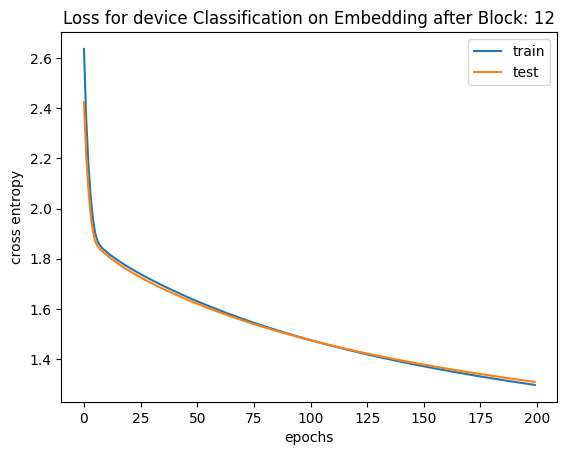

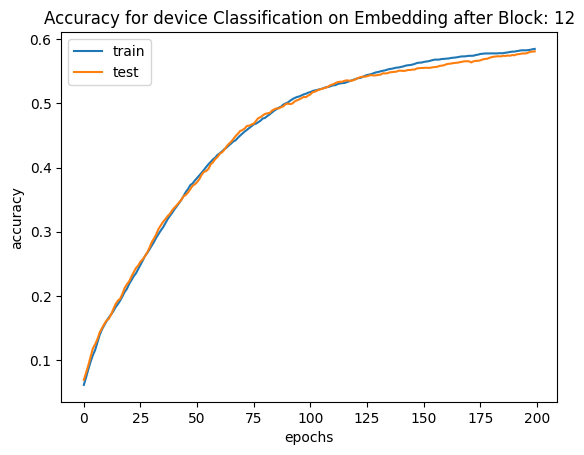

In [229]:
n_epochs = 200
batch_size = b_s
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# # Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters in the model are: {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of paramerters being trained: ", total_trainable_params)

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            labels = np.argmax(y_batch, axis=1)
            loss = criterion(y_pred, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if acc > best_acc:
        best_acc = acc

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)
list_val_acc.append(best_acc)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [230]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [231]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')


In [232]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
)

In [233]:
X_test=train_ready(test_data,col_name)

In [234]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred


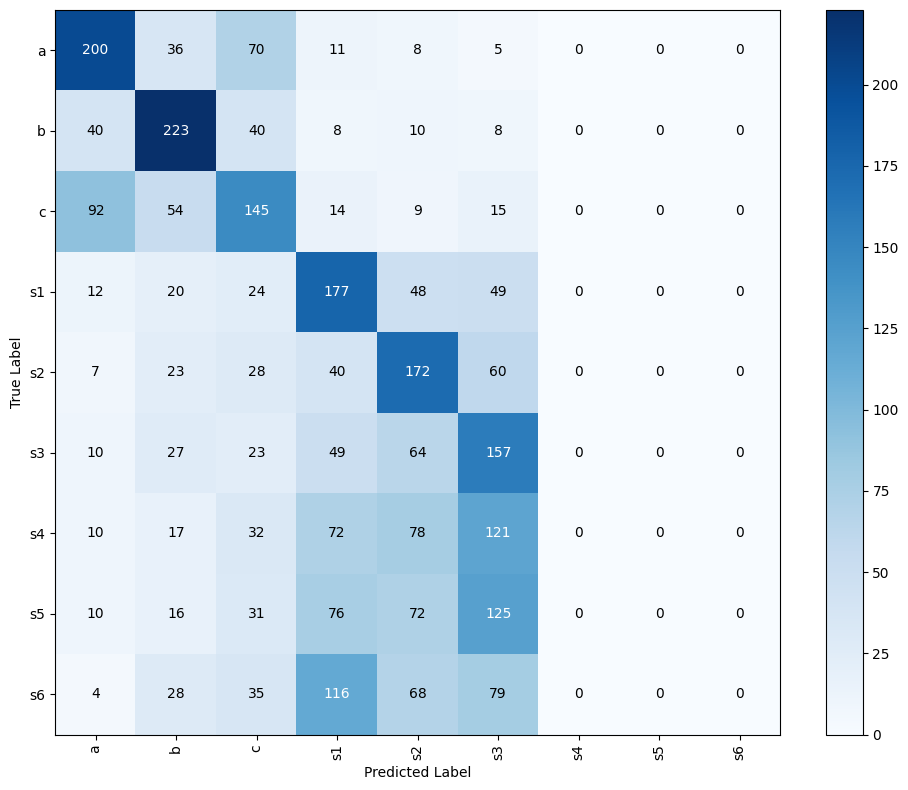

Accuracy: 0.3619


In [235]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

In [236]:
df.to_csv(fr'{run_mode}_predictions.csv')

# Accuracy Plots of Block-by-Block

In [237]:
acc_list


[0.2813342318059299,
 0.37567385444743934,
 0.35680592991913745,
 0.38140161725067384,
 0.3999326145552561,
 0.431266846361186,
 0.41543126684636117,
 0.3972371967654987,
 0.41745283018867924,
 0.41273584905660377,
 0.4282345013477089,
 0.3618598382749326]

In [238]:
list_val_acc

[0.43465808033943176,
 0.5614035129547119,
 0.4815610349178314,
 0.577157199382782,
 0.5853920578956604,
 0.6609380841255188,
 0.646258533000946,
 0.6258503198623657,
 0.6691729426383972,
 0.6566416025161743,
 0.664518415927887,
 0.5807375311851501]

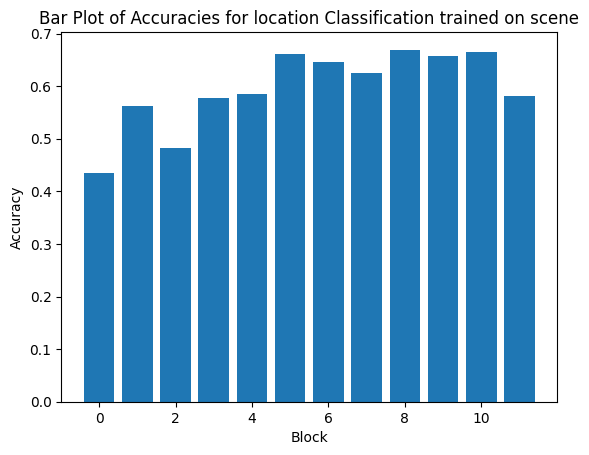

In [239]:
import matplotlib.pyplot as plt

# Example list of numbers
numbers = list_val_acc

# Create the plot
plt.bar(range(len(numbers)), numbers)

# Add labels and title
plt.xlabel('Block')
plt.ylabel('Accuracy')
plt.title('Bar Plot of Accuracies for location Classification trained on scene')

# Display the plot
plt.show()
